Here I want to write for loops to summarize the differences of variable selection methods (VIF, LSR, high correlation, my own 'guesses', LASSO, divided by 'category' of variable (same day, day before, etc.)) between classification models (random forests, logistic, SVC). 

NB: going to have to think about how I want to analyze this data. Soil features appeared regularly in the feature importances, but many fields are missing this data. I'm going to use only non-soil features for the bulk of the analysis so I can use more data points   

In [229]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingRegressor, StackingRegressor

from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import precision_score, f1_score, accuracy_score, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sk{
 "cells": [
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Here I want to write for loops to summarize the differences of variable selection methods (VIF, LSR, high correlation, my own 'guesses', LASSO, divided by 'category' of variable (same day, day before, etc.)) between classification models (random forests, logistic, SVC). \n",
    "\n",
    "NB: going to have to think about how I want to analyze this data. Soil features appeared regularly in the feature importances, but many fields are missing this data. I'm going to use only non-soil features for the bulk of the analysis so I can use more data points   "
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 229,
   "metadata": {},
   "outputs": [],
   "source": [
    "import numpy as np\n",
    "import pandas as pd\n",
    "import scipy.stats\n",
    "\n",
    "import matplotlib.pyplot as plt\n",
    "%matplotlib inline\n",
    "\n",
    "from sklearn.model_selection import train_test_split, cross_val_score, cross_validate\n",
    "from sklearn.model_selection import RandomizedSearchCV, GridSearchCV\n",
    "from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer\n",
    "from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, LassoCV\n",
    "from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingRegressor, StackingRegressor\n",
    "\n",
    "from sklearn.dummy import DummyRegressor, DummyClassifier\n",
    "from sklearn.experimental import enable_iterative_imputer\n",
    "from sklearn.impute import IterativeImputer, SimpleImputer\n",
    "from sklearn.compose import ColumnTransformer\n",
    "from sklearn.pipeline import Pipeline\n",
    "\n",
    "from sklearn import metrics\n",
    "from sklearn.metrics import r2_score, mean_squared_error\n",
    "from sklearn.metrics import precision_score, f1_score, accuracy_score, roc_curve, roc_auc_score, make_scorer\n",
    "from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay\n",
    "from sklearn.metrics import plot_confusion_matrix\n",
    "from sklearn.inspection import permutation_importance\n",
    "\n",
    "from sklearn.svm import SVR, SVC\n",
    "from sklearn.datasets import make_blobs\n",
    "from sklearn.tree import DecisionTreeRegressor\n",
    "\n",
    "from pandas_profiling import ProfileReport\n",
    "from sklearn.metrics import roc_curve, auc, roc_auc_score\n",
    "\n",
    "from matplotlib import cm\n",
    "from matplotlib.colors import ListedColormap, LinearSegmentedColormap\n",
    "\n",
    "from statistics import mean\n",
    "\n",
    "from pprint import pprint\n"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Functions:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 2,
   "metadata": {},
   "outputs": [],
   "source": [
    "def score_metrics(y_true, y_proba, prob_threshold):\n",
    "    \"\"\"\"\n",
    "    Produces a table of the most relevant model evaluation metrics for classification problems\n",
    "    \n",
    "    Requires a vector of the true target values and a vector of predicted probabilities (from the model) for\n",
    "       those values\n",
    "    \"\"\"\n",
    "    y_pred = y_proba >= prob_threshold\n",
    "    cm = confusion_matrix(y_true, y_pred)\n",
    "    tn, fp, fn, tp = cm.ravel()\n",
    "    \n",
    "    accuracy = (tp + tn) / (tp + fp + tn + fn)\n",
    "    precision = tp / (tp + fp)\n",
    "    recall = tp / (tp + fn)\n",
    "    specificity = tn / (tn + fp)\n",
    "    f1 = 2*(precision*recall)/(precision+recall)\n",
    "    AUC = roc_auc_score(y_true, y_proba)\n",
    "    \n",
    "    row_names = ['accuracy', 'precision', 'recall', 'specificity', 'F1', 'AUC']\n",
    "    df = pd.DataFrame(data=[accuracy, precision, recall, specificity, f1, AUC], \n",
    "                      index=row_names, columns=[\"value\"])\n",
    "    return df"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 3,
   "metadata": {},
   "outputs": [],
   "source": [
    "def score_metrics_no_prob(y_true, y_pred):\n",
    "    \"\"\"\"\n",
    "    Produces a table of the most relevant model evaluation metrics for classification problems\n",
    "    \n",
    "    Requires a vector of the true target values and a vector of predicted classes (not probabilities)\n",
    "       for those values\n",
    "    \"\"\"\n",
    "    #y_pred = y_proba >= 0.5\n",
    "    cm = confusion_matrix(y_true, y_pred)\n",
    "    tn, fp, fn, tp = cm.ravel()\n",
    "    \n",
    "    accuracy = (tp + tn) / (tp + fp + tn + fn)\n",
    "    precision = tp / (tp + fp)\n",
    "    recall = tp / (tp + fn)\n",
    "    specificity = tn / (tn + fp)\n",
    "    f1 = 2*(precision*recall)/(precision+recall)\n",
    "    AUC = roc_auc_score(y_true, y_pred)\n",
    "    \n",
    "    row_names = ['accuracy', 'precision', 'recall', 'specificity', 'F1', 'AUC'\n",
    "                ]\n",
    "    df = pd.DataFrame(data=[accuracy, precision, recall, specificity, f1, AUC\n",
    "                           ], \n",
    "                      index=row_names, columns=[\"value\"])\n",
    "    return df"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Intro:\n",
    "This is a practice with `for` loops to get some sense of how these models are performing. May or may not be the best code/data analysis procedures."
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 4,
   "metadata": {},
   "outputs": [],
   "source": [
    "# load in my data:\n",
    "ascospores = pd.read_csv(\"/Users/jreich/Desktop/Data/Modeling Data/2018-21 burkard and weather data for modelling.csv\", index_col = False)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 5,
   "metadata": {},
   "outputs": [],
   "source": [
    "# convert the 'RainYN' column to a character, since I think this may cause issues with\n",
    "# the analysis downstream:\n",
    "ascospores['RainYN'] = ascospores.RainYN.astype(str)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 6,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>Date</th>\n",
       "      <th>Year</th>\n",
       "      <th>Province</th>\n",
       "      <th>SamplerNo.x</th>\n",
       "      <th>FieldID</th>\n",
       "      <th>SamplerType</th>\n",
       "      <th>ExtractionGroup</th>\n",
       "      <th>qPCRPlate</th>\n",
       "      <th>JDay</th>\n",
       "      <th>SampleID</th>\n",
       "      <th>...</th>\n",
       "      <th>MeanSoilTemp</th>\n",
       "      <th>DiffMeanSoilT</th>\n",
       "      <th>MeanSoilT_1d</th>\n",
       "      <th>MaxSoilTemp</th>\n",
       "      <th>DiffMaxSoilT</th>\n",
       "      <th>MaxSoilT_1d</th>\n",
       "      <th>MinSoilTemp</th>\n",
       "      <th>DiffMinSoilT</th>\n",
       "      <th>MinSoilT_1d</th>\n",
       "      <th>jday</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>0</th>\n",
       "      <td>2018-06-13</td>\n",
       "      <td>2018</td>\n",
       "      <td>Alberta</td>\n",
       "      <td>Taber</td>\n",
       "      <td>1804</td>\n",
       "      <td>Burkard</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>164.0</td>\n",
       "      <td>NaN</td>\n",
       "      <td>...</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>1</th>\n",
       "      <td>2018-06-14</td>\n",
       "      <td>2018</td>\n",
       "      <td>Alberta</td>\n",
       "      <td>Taber</td>\n",
       "      <td>1804</td>\n",
       "      <td>Burkard</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>165.0</td>\n",
       "      <td>NaN</td>\n",
       "      <td>...</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>165.0</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>2</th>\n",
       "      <td>2018-06-15</td>\n",
       "      <td>2018</td>\n",
       "      <td>Alberta</td>\n",
       "      <td>Taber</td>\n",
       "      <td>1804</td>\n",
       "      <td>Burkard</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>166.0</td>\n",
       "      <td>NaN</td>\n",
       "      <td>...</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>166.0</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>3</th>\n",
       "      <td>2018-06-16</td>\n",
       "      <td>2018</td>\n",
       "      <td>Alberta</td>\n",
       "      <td>Taber</td>\n",
       "      <td>1804</td>\n",
       "      <td>Burkard</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>167.0</td>\n",
       "      <td>NaN</td>\n",
       "      <td>...</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>167.0</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>4</th>\n",
       "      <td>2018-06-17</td>\n",
       "      <td>2018</td>\n",
       "      <td>Alberta</td>\n",
       "      <td>Taber</td>\n",
       "      <td>1804</td>\n",
       "      <td>Burkard</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>168.0</td>\n",
       "      <td>NaN</td>\n",
       "      <td>...</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>168.0</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>...</th>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "      <td>...</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>2692</th>\n",
       "      <td>2021-08-12</td>\n",
       "      <td>2021</td>\n",
       "      <td>Manitoba</td>\n",
       "      <td>NaN</td>\n",
       "      <td>Morden21</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>...</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>224.0</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>2693</th>\n",
       "      <td>2021-08-15</td>\n",
       "      <td>2021</td>\n",
       "      <td>Manitoba</td>\n",
       "      <td>NaN</td>\n",
       "      <td>Morden21</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>...</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>227.0</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>2694</th>\n",
       "      <td>2021-08-17</td>\n",
       "      <td>2021</td>\n",
       "      <td>Manitoba</td>\n",
       "      <td>NaN</td>\n",
       "      <td>Morden21</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>...</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>229.0</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>2695</th>\n",
       "      <td>2021-08-18</td>\n",
       "      <td>2021</td>\n",
       "      <td>Manitoba</td>\n",
       "      <td>NaN</td>\n",
       "      <td>Morden21</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>...</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>230.0</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>2696</th>\n",
       "      <td>2021-08-26</td>\n",
       "      <td>2021</td>\n",
       "      <td>Manitoba</td>\n",
       "      <td>NaN</td>\n",
       "      <td>Morden21</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>...</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "      <td>238.0</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "<p>2697 rows × 97 columns</p>\n",
       "</div>"
      ],
      "text/plain": [
       "            Date  Year  Province SamplerNo.x   FieldID SamplerType  \\\n",
       "0     2018-06-13  2018   Alberta       Taber      1804     Burkard   \n",
       "1     2018-06-14  2018   Alberta       Taber      1804     Burkard   \n",
       "2     2018-06-15  2018   Alberta       Taber      1804     Burkard   \n",
       "3     2018-06-16  2018   Alberta       Taber      1804     Burkard   \n",
       "4     2018-06-17  2018   Alberta       Taber      1804     Burkard   \n",
       "...          ...   ...       ...         ...       ...         ...   \n",
       "2692  2021-08-12  2021  Manitoba         NaN  Morden21         NaN   \n",
       "2693  2021-08-15  2021  Manitoba         NaN  Morden21         NaN   \n",
       "2694  2021-08-17  2021  Manitoba         NaN  Morden21         NaN   \n",
       "2695  2021-08-18  2021  Manitoba         NaN  Morden21         NaN   \n",
       "2696  2021-08-26  2021  Manitoba         NaN  Morden21         NaN   \n",
       "\n",
       "     ExtractionGroup qPCRPlate   JDay SampleID  ...  MeanSoilTemp  \\\n",
       "0                NaN       NaN  164.0      NaN  ...           NaN   \n",
       "1                NaN       NaN  165.0      NaN  ...           NaN   \n",
       "2                NaN       NaN  166.0      NaN  ...           NaN   \n",
       "3                NaN       NaN  167.0      NaN  ...           NaN   \n",
       "4                NaN       NaN  168.0      NaN  ...           NaN   \n",
       "...              ...       ...    ...      ...  ...           ...   \n",
       "2692             NaN       NaN    NaN      NaN  ...           NaN   \n",
       "2693             NaN       NaN    NaN      NaN  ...           NaN   \n",
       "2694             NaN       NaN    NaN      NaN  ...           NaN   \n",
       "2695             NaN       NaN    NaN      NaN  ...           NaN   \n",
       "2696             NaN       NaN    NaN      NaN  ...           NaN   \n",
       "\n",
       "      DiffMeanSoilT  MeanSoilT_1d  MaxSoilTemp  DiffMaxSoilT  MaxSoilT_1d  \\\n",
       "0               NaN           NaN          NaN           NaN          NaN   \n",
       "1               NaN           NaN          NaN           NaN          NaN   \n",
       "2               NaN           NaN          NaN           NaN          NaN   \n",
       "3               NaN           NaN          NaN           NaN          NaN   \n",
       "4               NaN           NaN          NaN           NaN          NaN   \n",
       "...             ...           ...          ...           ...          ...   \n",
       "2692            NaN           NaN          NaN           NaN          NaN   \n",
       "2693            NaN           NaN          NaN           NaN          NaN   \n",
       "2694            NaN           NaN          NaN           NaN          NaN   \n",
       "2695            NaN           NaN          NaN           NaN          NaN   \n",
       "2696            NaN           NaN          NaN           NaN          NaN   \n",
       "\n",
       "      MinSoilTemp DiffMinSoilT  MinSoilT_1d   jday  \n",
       "0             NaN          NaN          NaN    NaN  \n",
       "1             NaN          NaN          NaN  165.0  \n",
       "2             NaN          NaN          NaN  166.0  \n",
       "3             NaN          NaN          NaN  167.0  \n",
       "4             NaN          NaN          NaN  168.0  \n",
       "...           ...          ...          ...    ...  \n",
       "2692          NaN          NaN          NaN  224.0  \n",
       "2693          NaN          NaN          NaN  227.0  \n",
       "2694          NaN          NaN          NaN  229.0  \n",
       "2695          NaN          NaN          NaN  230.0  \n",
       "2696          NaN          NaN          NaN  238.0  \n",
       "\n",
       "[2697 rows x 97 columns]"
      ]
     },
     "execution_count": 6,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# I think different types of NA values are getting in the way of downstream analysis, so here I'll try to \n",
    "#  change them all into the exact same format:\n",
    "ascospores.replace(dict.fromkeys(['N/A', '', 'NA'], None))"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 7,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "Index(['Date', 'Year', 'Province', 'SamplerNo.x', 'FieldID', 'SamplerType',\n",
       "       'ExtractionGroup', 'qPCRPlate', 'JDay', 'SampleID', 'SsCtMean',\n",
       "       'SsCtSD', 'SsMean', 'logSsMean', 'VolumeSampled', 'TtCt', 'TtSD',\n",
       "       'Water', 'week', 'month', 'SsMean_t1', 'logSs_t1', 'SamplerNo.y',\n",
       "       'MeanWetness', 'DiffMeanWet', 'MeanWet_1d', 'MaxWetness', 'DiffMaxWet',\n",
       "       'MaxWet_1d', 'MinWetness', 'DiffMinWet', 'MinWet_1d', 'MeanTemp',\n",
       "       'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp',\n",
       "       'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH',\n",
       "       'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d',\n",
       "       'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD',\n",
       "       'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d',\n",
       "       'MinVPD', 'DiffMinVPD', 'MinVPD_1d', 'TotalPrecip', 'Precip_1d',\n",
       "       'RainYN', 'MaxRain', 'MinRain', 'MeanWC', 'DiffMeanWC', 'MeanWC_1d',\n",
       "       'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC', 'MinWC_1d',\n",
       "       'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP', 'DiffMaxDP', 'MaxDP_1d',\n",
       "       'MinDP', 'DiffMinDP', 'MinDP_1d', 'MeanSoilTemp', 'DiffMeanSoilT',\n",
       "       'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT', 'MaxSoilT_1d',\n",
       "       'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d', 'jday'],\n",
       "      dtype='object')"
      ]
     },
     "execution_count": 7,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "ascospores.columns"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 8,
   "metadata": {},
   "outputs": [],
   "source": [
    "# remove any lines for which the response variable is missing:\n",
    "ascospores = ascospores.dropna(subset=['SsMean'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": [
    "# make sure that RainYN is a categorical variable:\n",
    "ascospores['RainYN'] = ascospores['RainYN'].astype('category')"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 9,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "(1046, 97)"
      ]
     },
     "execution_count": 9,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# select only AB fields and remove the one sampler that was collecting from outside the field;\n",
    "#  also remove the fields that didn't collect weather data (can see R 'Correlations of Ascospores and Weather...R'\n",
    "#  file to assess this):\n",
    "\n",
    "to_keep = [\"1804\", \"1810\", \"1814\", \"1904\", \"1906\", \"1910\", \"1915\", \"1917\", \"1919\", \n",
    "           \"2001\", \"2003\", \"2004\", \"2006\", \"2007\", \"2042\", \"2104\", \"2105-in\", \"2125\",\n",
    "           \"2128\", \"2144\", \"2146\"]\n",
    "\n",
    "asco_ab = ascospores.loc[ascospores['FieldID'].isin(to_keep)]\n",
    "\n",
    "asco_ab.shape"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 10,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "array(['1804', '1810', '1814', '1904', '1906', '1910', '1915', '1917',\n",
       "       '1919', '2001', '2004', '2006', '2007', '2042', '2104', '2105-in',\n",
       "       '2125', '2128', '2144', '2146'], dtype=object)"
      ]
     },
     "execution_count": 10,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "asco_ab['FieldID'].unique()"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "#\"nan\" fields include rotorods and potato spore samplers; remove these:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 11,
   "metadata": {},
   "outputs": [],
   "source": [
    "#asco_ab_bean = asco_ab.dropna(subset = ['FieldID'])\n",
    "#asco_ab_bean.shape"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 12,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "Index(['Date', 'Year', 'Province', 'SamplerNo.x', 'FieldID', 'SamplerType',\n",
       "       'ExtractionGroup', 'qPCRPlate', 'JDay', 'SampleID', 'SsCtMean',\n",
       "       'SsCtSD', 'SsMean', 'logSsMean', 'VolumeSampled', 'TtCt', 'TtSD',\n",
       "       'Water', 'week', 'month', 'SsMean_t1', 'logSs_t1', 'SamplerNo.y',\n",
       "       'MeanWetness', 'DiffMeanWet', 'MeanWet_1d', 'MaxWetness', 'DiffMaxWet',\n",
       "       'MaxWet_1d', 'MinWetness', 'DiffMinWet', 'MinWet_1d', 'MeanTemp',\n",
       "       'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp',\n",
       "       'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH',\n",
       "       'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d',\n",
       "       'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD',\n",
       "       'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d',\n",
       "       'MinVPD', 'DiffMinVPD', 'MinVPD_1d', 'TotalPrecip', 'Precip_1d',\n",
       "       'RainYN', 'MaxRain', 'MinRain', 'MeanWC', 'DiffMeanWC', 'MeanWC_1d',\n",
       "       'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC', 'MinWC_1d',\n",
       "       'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP', 'DiffMaxDP', 'MaxDP_1d',\n",
       "       'MinDP', 'DiffMinDP', 'MinDP_1d', 'MeanSoilTemp', 'DiffMeanSoilT',\n",
       "       'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT', 'MaxSoilT_1d',\n",
       "       'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d', 'jday'],\n",
       "      dtype='object')"
      ]
     },
     "execution_count": 12,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "asco_ab.columns"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 13,
   "metadata": {},
   "outputs": [],
   "source": [
    "# drop columns that are redundant, not relevant, or contain no useful information;\n",
    "asco_minimal = asco_ab.drop(['Date', 'Year', 'Province', 'SamplerNo.x', \n",
    "                             #'FieldID', \n",
    "                             'SamplerType', \n",
    "                             'ExtractionGroup','qPCRPlate', 'JDay', 'SampleID', 'SsCtMean', \n",
    "                             'SsCtSD', 'VolumeSampled', 'TtCt', 'TtSD', 'Water', \n",
    "                             #'week', 'month', \n",
    "                             'SamplerNo.y', 'MeanWetness',\n",
    "                             'DiffMeanWet', 'MeanWet_1d', 'MaxWetness', 'DiffMaxWet', 'MaxWet_1d',\n",
    "                             'MinWetness', 'DiffMinWet', 'MinWet_1d', #'RainYN', \n",
    "                             'MaxRain', 'MinRain', \n",
    "                             #'MeanWC', 'DiffMeanWC', 'MeanWC_1d',\n",
    "                             #'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC', 'MinWC_1d',\n",
    "                             #'MeanSoilTemp', 'DiffMeanSoilT',\n",
    "                             #'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT', 'MaxSoilT_1d',\n",
    "                             #'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d', \n",
    "                             'jday'], axis = 1)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 14,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "(1046, 69)\n"
     ]
    },
    {
     "data": {
      "text/plain": [
       "Index(['FieldID', 'SsMean', 'logSsMean', 'week', 'month', 'SsMean_t1',\n",
       "       'logSs_t1', 'MeanTemp', 'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT',\n",
       "       'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH',\n",
       "       'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH',\n",
       "       'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h',\n",
       "       'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD',\n",
       "       'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD', 'MinVPD_1d',\n",
       "       'TotalPrecip', 'Precip_1d', 'RainYN', 'MeanWC', 'DiffMeanWC',\n",
       "       'MeanWC_1d', 'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC',\n",
       "       'MinWC_1d', 'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP', 'DiffMaxDP',\n",
       "       'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d', 'MeanSoilTemp',\n",
       "       'DiffMeanSoilT', 'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT',\n",
       "       'MaxSoilT_1d', 'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d'],\n",
       "      dtype='object')"
      ]
     },
     "execution_count": 14,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "print(asco_minimal.shape)\n",
    "asco_minimal.columns"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Create data sets with and without soil data:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 15,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "(620, 69)\n",
      "(1046, 51)\n"
     ]
    }
   ],
   "source": [
    "# in Alberta, filtering by complete Soil Temp variables will ensure that this there are also\n",
    "#   complete Soil WC variables:\n",
    "asco_soil = asco_minimal.dropna(subset=['MeanSoilTemp'])\n",
    "asco_nosoil = asco_minimal.drop(['MeanWC', 'DiffMeanWC', 'MeanWC_1d', 'MaxWC',\n",
    "       'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC', 'MinWC_1d', 'MeanSoilTemp', \n",
    "       'DiffMeanSoilT', 'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT', 'MaxSoilT_1d',\n",
    "       'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d'], axis = 1)\n",
    "print(asco_soil.shape)\n",
    "print(asco_nosoil.shape)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 16,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "70"
      ]
     },
     "execution_count": 16,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "sum(asco_soil.apply(lambda x: sum(x.isnull().values), axis = 1)>0)"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Create train and test data sets: \n",
    "\n",
    "#### NB: rather than doing a random split, I'm going to select one field from each year for the test set, and use the remainder for the training set - this seems more realistic in terms of what we want to predict"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 17,
   "metadata": {},
   "outputs": [],
   "source": [
    "asco_trainvalid_nosoil = asco_nosoil.loc[asco_nosoil['FieldID'].isin([\"1804\",  \"1814\", \"1904\", \"1906\", \"1915\", \"1917\", \"1919\", \n",
    "           \"2001\", \"2003\",  \"2006\", \"2007\", \"2042\", \"2104\", \"2105-in\", \"2125\",\n",
    "            \"2144\", \"2146\"])]\n",
    "asco_test_nosoil = asco_nosoil.loc[asco_nosoil['FieldID'].isin([\"1810\", \"1910\", \"2004\", \"2128\"])]\n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 18,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "(855, 51)\n",
      "(191, 51)\n"
     ]
    }
   ],
   "source": [
    "print(asco_trainvalid_nosoil.shape)\n",
    "print(asco_test_nosoil.shape)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 19,
   "metadata": {},
   "outputs": [],
   "source": [
    "# drop the 'FieldID' column for these data sets:\n",
    "asco_trainvalid_nosoil = asco_trainvalid_nosoil.drop(['FieldID'], axis = 1)\n",
    "asco_test_nosoil = asco_test_nosoil.drop(['FieldID'], axis = 1)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 20,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "Index(['SsMean', 'logSsMean', 'week', 'month', 'SsMean_t1', 'logSs_t1',\n",
       "       'MeanTemp', 'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT', 'MaxT_1d',\n",
       "       'MinTemp', 'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH', 'MeanRH_1d',\n",
       "       'MaxRH', 'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH', 'MinRH_1d',\n",
       "       'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h', 'MaxDiffRH_3h',\n",
       "       'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD', 'DiffMaxVPD',\n",
       "       'MaxVPD_1d', 'MinVPD', 'DiffMinVPD', 'MinVPD_1d', 'TotalPrecip',\n",
       "       'Precip_1d', 'RainYN', 'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP',\n",
       "       'DiffMaxDP', 'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d'],\n",
       "      dtype='object')"
      ]
     },
     "execution_count": 20,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "asco_trainvalid_nosoil.columns"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 21,
   "metadata": {},
   "outputs": [],
   "source": [
    "#asco_trainvalid_soil, asco_test_soil = train_test_split(asco_soil, test_size = 0.2, random_state = 44)\n",
    "#asco_trainvalid_nosoil, asco_test_nosoil = train_test_split(asco_nosoil, test_size = 0.2, random_state = 44)"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Ok, so now I've got a bunch of data sets to do the same modeling with:\n",
    "- data set WITH soil\n",
    "    - SsMean (raw data)\n",
    "    - logSs (log-transformed data)\n",
    "- data set WITHOUT soil\n",
    "    - SsMean\n",
    "    - logSs"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 22,
   "metadata": {},
   "outputs": [],
   "source": [
    "# the y datasets with soil variables:\n",
    "#y_trainvalid_soil = asco_trainvalid_soil['SsMean']\n",
    "#y_test_soil = asco_test_soil['SsMean']\n",
    "\n",
    "#y_trainvalid_soil_log = asco_trainvalid_soil['logSsMean']\n",
    "#y_test_soil_log = asco_test_soil['logSsMean']\n",
    "\n",
    "# the y datasets without soil variables:\n",
    "y_trainvalid_nosoil = asco_trainvalid_nosoil['SsMean']\n",
    "y_test_nosoil = asco_test_nosoil['SsMean']\n",
    "\n",
    "y_trainvalid_nosoil_log = asco_trainvalid_nosoil['logSsMean']\n",
    "y_test_nosoil_log = asco_test_nosoil['logSsMean']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 23,
   "metadata": {},
   "outputs": [],
   "source": [
    "# the X data sets with soil variables:\n",
    "#X_trainvalid_soil = asco_trainvalid_soil.drop(['SsMean', 'logSsMean', 'logSs_t1'], axis = 1)\n",
    "#X_test_soil = asco_test_soil.drop(['SsMean', 'logSsMean', 'logSs_t1'], axis = 1)\n",
    "\n",
    "#X_trainvalid_soil_log = asco_trainvalid_soil.drop(['SsMean', 'logSsMean', 'SsMean_t1'], axis = 1)\n",
    "#X_test_soil_log = asco_test_soil.drop(['SsMean', 'logSsMean', 'SsMean_t1'], axis = 1)\n",
    "\n",
    "\n",
    "# the X data sets without soil variables:\n",
    "X_trainvalid_nosoil = asco_trainvalid_nosoil.drop(['SsMean', 'logSsMean', 'logSs_t1'], axis = 1)\n",
    "X_test_nosoil = asco_test_nosoil.drop(['SsMean', 'logSsMean', 'logSs_t1'], axis = 1)\n",
    "\n",
    "X_trainvalid_nosoil_log = asco_trainvalid_nosoil.drop(['SsMean', 'logSsMean', 'SsMean_t1'], axis = 1)\n",
    "X_test_nosoil_log = asco_test_nosoil.drop(['SsMean', 'logSsMean', 'SsMean_t1'], axis = 1)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 24,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "(855, 47)\n",
      "(855, 47)\n",
      "(191, 47)\n",
      "(191, 47)\n"
     ]
    }
   ],
   "source": [
    "print(X_trainvalid_nosoil.shape)\n",
    "print(X_trainvalid_nosoil_log.shape)\n",
    "print(X_test_nosoil.shape)\n",
    "print(X_test_nosoil_log.shape)"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Make two data sets: first, make one of the log(no. ascospores) for regression modeling; second, make one of (no. ascospores > x) for classification modeling"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 25,
   "metadata": {},
   "outputs": [],
   "source": [
    "# data sets for regression modeling:\n",
    "### make data frames for X data sets; export these for use in other programs (R)\n",
    "\n",
    "#X_trainvalid_soil_log_df = pd.DataFrame(X_trainvalid_soil_log)\n",
    "#X_test_soil_log_df = pd.DataFrame(X_test_soil_log)\n",
    "X_trainvalid_nosoil_log_df = pd.DataFrame(X_trainvalid_nosoil_log)\n",
    "X_test_nosoil_log_df = pd.DataFrame(X_test_nosoil_log)\n",
    "\n",
    "#X_train_df.columns = new_columns\n",
    "#X_valid_df.columns = new_columns\n",
    "#X_test_df.columns = new_columns\n",
    "\n",
    "#X_trainvalid_soil_log_df.to_csv(\"~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/X_trainvalid_soil.csv\")\n",
    "#X_test_soil_log_df.to_csv(\"~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/X_test_soil.csv\")\n",
    "X_trainvalid_nosoil_log_df.to_csv(\"~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/X_trainvalid_nosoil.csv\")\n",
    "X_test_nosoil_log_df.to_csv(\"~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/X_test_nosoil.csv\")\n",
    "\n",
    "#y_trainvalid_soil_log.to_csv(\"~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/y_trainvalid_soil.csv\")\n",
    "#y_test_soil_log.to_csv(\"~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/y_test_soil.csv\")\n",
    "y_trainvalid_nosoil_log.to_csv(\"~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/y_trainvalid_nosoil.csv\")\n",
    "y_test_nosoil_log.to_csv(\"~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/y_test_nosoil.csv\")\n",
    "\n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 899,
   "metadata": {},
   "outputs": [],
   "source": [
    "# data sets WITH soil data:\n",
    "### data sets for classification modeling:\n",
    "#y100_trainvalid_soil = np.where(y_trainvalid_soil >= 100, 1, 0)\n",
    "#y100_test_soil = np.where(y_test_soil >= 100, 1, 0)\n",
    "#y100_all = np.where(y_all >= 100, 1, 0)\n",
    "\n",
    "#y200_trainvalid_soil = np.where(y_trainvalid_soil >= 200, 1, 0)\n",
    "#y200_test_soil = np.where(y_test_soil >= 200, 1, 0)\n",
    "#y200_all = np.where(y_all >= 200, 1, 0)\n",
    "\n",
    "#y500_trainvalid_soil = np.where(y_trainvalid_soil >= 500, 1, 0)\n",
    "#y500_test_soil = np.where(y_test_soil >= 500, 1, 0)\n",
    "#y500_all = np.where(y_all >= 500, 1, 0)\n",
    "\n",
    "#y1000_trainvalid_soil = np.where(y_trainvalid_soil >= 1000, 1, 0)\n",
    "#y1000_test_soil = np.where(y_test_soil >= 1000, 1, 0)\n",
    "#y1000_all = np.where(y_all >= 1000, 1, 0)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 26,
   "metadata": {},
   "outputs": [],
   "source": [
    "# data sets WITHOUT soil data:\n",
    "### data sets for classification modeling:\n",
    "y100_trainvalid_nosoil = np.where(y_trainvalid_nosoil >= 100, 1, 0)\n",
    "y100_test_nosoil = np.where(y_test_nosoil >= 100, 1, 0)\n",
    "#y100_all = np.where(y_all >= 100, 1, 0)\n",
    "\n",
    "y200_trainvalid_nosoil = np.where(y_trainvalid_nosoil >= 200, 1, 0)\n",
    "y200_test_nosoil = np.where(y_test_nosoil >= 200, 1, 0)\n",
    "#y200_all = np.where(y_all >= 200, 1, 0)\n",
    "\n",
    "y500_trainvalid_nosoil = np.where(y_trainvalid_nosoil >= 500, 1, 0)\n",
    "y500_test_nosoil = np.where(y_test_nosoil >= 500, 1, 0)\n",
    "#y500_all = np.where(y_all >= 500, 1, 0)\n",
    "\n",
    "y1000_trainvalid_nosoil = np.where(y_trainvalid_nosoil >= 1000, 1, 0)\n",
    "y1000_test_nosoil = np.where(y_test_nosoil >= 1000, 1, 0)\n",
    "#y1000_all = np.where(y_all >= 1000, 1, 0)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 27,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>Proportion of Ones</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>y100_trainvalid_nosoil</th>\n",
       "      <td>0.753216</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>y100_test_nosoil</th>\n",
       "      <td>0.612565</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>y200_trainvalid_nosoil</th>\n",
       "      <td>0.618713</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>y200_test_nosoil</th>\n",
       "      <td>0.455497</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>y500_trainvalid_nosoil</th>\n",
       "      <td>0.403509</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>y500_test_nosoil</th>\n",
       "      <td>0.287958</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>y1000_trainvalid_nosoil</th>\n",
       "      <td>0.249123</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>y1000_test_nosoil</th>\n",
       "      <td>0.225131</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                         Proportion of Ones\n",
       "y100_trainvalid_nosoil             0.753216\n",
       "y100_test_nosoil                   0.612565\n",
       "y200_trainvalid_nosoil             0.618713\n",
       "y200_test_nosoil                   0.455497\n",
       "y500_trainvalid_nosoil             0.403509\n",
       "y500_test_nosoil                   0.287958\n",
       "y1000_trainvalid_nosoil            0.249123\n",
       "y1000_test_nosoil                  0.225131"
      ]
     },
     "execution_count": 27,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "all_y = [#y100_trainvalid_soil, y100_test_soil,\n",
    "         #y200_trainvalid_soil, y200_test_soil,\n",
    "         #y500_trainvalid_soil, y500_test_soil,\n",
    "         #y1000_trainvalid_soil, y1000_test_soil,\n",
    "         y100_trainvalid_nosoil, y100_test_nosoil,\n",
    "         y200_trainvalid_nosoil, y200_test_nosoil,\n",
    "         y500_trainvalid_nosoil, y500_test_nosoil,\n",
    "         y1000_trainvalid_nosoil, y1000_test_nosoil]\n",
    "\n",
    "y_means = []\n",
    "for y in all_y: \n",
    "    y_means.append(y.mean())\n",
    "\n",
    "y_names = [#'y100_trainvalid_soil', 'y100_test_soil',\n",
    "           #'y200_trainvalid_soil', 'y200_test_soil', \n",
    "           #'y500_trainvalid_soil', 'y500_test_soil',\n",
    "           #'y1000_trainvalid_soil', 'y1000_test_soil',\n",
    "           'y100_trainvalid_nosoil', 'y100_test_nosoil',\n",
    "           'y200_trainvalid_nosoil', 'y200_test_nosoil', \n",
    "           'y500_trainvalid_nosoil', 'y500_test_nosoil',\n",
    "           'y1000_trainvalid_nosoil', 'y1000_test_nosoil']\n",
    "\n",
    "y_df = pd.DataFrame(data=y_means, index=y_names, columns=[\"Proportion of Ones\"])\n",
    "y_df"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 28,
   "metadata": {},
   "outputs": [],
   "source": [
    "# determine how many 'cases' there are in the y1000_test group - the low number of test cases in this set is\n",
    "#   an issue in interpreting the AUC below\n",
    "#len(y1000_test_soil) * 0.22"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 29,
   "metadata": {},
   "outputs": [],
   "source": [
    "### Saving the test sets for use in R, or other programs:\n",
    "# y_names defined above\n",
    "y_names = [#'y100_trainvalid_soil', 'y100_test_soil',\n",
    "           #'y200_trainvalid_soil', 'y200_test_soil', \n",
    "           #'y500_trainvalid_soil', 'y500_test_soil',\n",
    "           #'y1000_trainvalid_soil', 'y1000_test_soil',\n",
    "           'y100_trainvalid_nosoil', 'y100_test_nosoil',\n",
    "           'y200_trainvalid_nosoil', 'y200_test_nosoil', \n",
    "           'y500_trainvalid_nosoil', 'y500_test_nosoil',\n",
    "           'y1000_trainvalid_nosoil', 'y1000_test_nosoil']\n",
    "\n",
    "y_data = [#y100_trainvalid_soil, y100_test_soil,\n",
    "         #y200_trainvalid_soil, y200_test_soil,\n",
    "         #y500_trainvalid_soil, y500_test_soil,\n",
    "         #y1000_trainvalid_soil, y1000_test_soil,\n",
    "         y100_trainvalid_nosoil, y100_test_nosoil,\n",
    "         y200_trainvalid_nosoil, y200_test_nosoil,\n",
    "         y500_trainvalid_nosoil, y500_test_nosoil,\n",
    "         y1000_trainvalid_nosoil, y1000_test_nosoil]\n",
    "file_path = \"~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/\"\n",
    "\n",
    "for i in np.arange(0, len(y_data)):\n",
    "    to_save = pd.DataFrame(list(y_data[i]))\n",
    "    to_save.to_csv(file_path + y_names[i] + \".csv\")"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 476,
   "metadata": {},
   "outputs": [],
   "source": [
    "# also save the raw y-data\n",
    "#ylog_all = np.log10(y_all + 1)\n",
    "#ylog_all.to_csv(file_path + \"ylog_all.csv\")"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "### LASSO regression for variable selection:\n",
    "- with soil data\n",
    "- without soil data\n",
    "- without ascospores from previous day"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 30,
   "metadata": {},
   "outputs": [
    {
     "ename": "NameError",
     "evalue": "name 'X_trainvalid_soil_log' is not defined",
     "output_type": "error",
     "traceback": [
      "\u001b[0;31m---------------------------------------------------------------------------\u001b[0m",
      "\u001b[0;31mNameError\u001b[0m                                 Traceback (most recent call last)",
      "\u001b[0;32m<ipython-input-30-3046ade0daaf>\u001b[0m in \u001b[0;36m<module>\u001b[0;34m\u001b[0m\n\u001b[0;32m----> 1\u001b[0;31m \u001b[0mprint\u001b[0m\u001b[0;34m(\u001b[0m\u001b[0mX_trainvalid_soil_log\u001b[0m\u001b[0;34m.\u001b[0m\u001b[0mcolumns\u001b[0m\u001b[0;34m)\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[0m\u001b[1;32m      2\u001b[0m \u001b[0mprint\u001b[0m\u001b[0;34m(\u001b[0m\u001b[0mX_trainvalid_nosoil_log\u001b[0m\u001b[0;34m.\u001b[0m\u001b[0mcolumns\u001b[0m\u001b[0;34m)\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n",
      "\u001b[0;31mNameError\u001b[0m: name 'X_trainvalid_soil_log' is not defined"
     ]
    }
   ],
   "source": [
    "print(X_trainvalid_soil_log.columns)\n",
    "print(X_trainvalid_nosoil_log.columns)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 31,
   "metadata": {},
   "outputs": [],
   "source": [
    "numeric_feat_soil = ['logSs_t1', 'MeanTemp', 'DiffMeanT', 'MeanT_1d',\n",
    "       'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d',\n",
    "       'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d',\n",
    "       'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d',\n",
    "       'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d',\n",
    "       'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD',\n",
    "       'MinVPD_1d', 'TotalPrecip', 'Precip_1d', 'MeanWC', 'DiffMeanWC',\n",
    "       'MeanWC_1d', 'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC',\n",
    "       'MinWC_1d', 'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP', 'DiffMaxDP',\n",
    "       'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d', 'MeanSoilTemp',\n",
    "       'DiffMeanSoilT', 'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT',\n",
    "       'MaxSoilT_1d', 'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d']\n",
    "numeric_feat_nosoil = ['logSs_t1', 'MeanTemp', 'DiffMeanT', 'MeanT_1d',\n",
    "       'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d',\n",
    "       'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d',\n",
    "       'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d',\n",
    "       'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d',\n",
    "       'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD',\n",
    "       'MinVPD_1d', 'TotalPrecip', 'Precip_1d', 'MeanDP', 'DiffMeanDP',\n",
    "       'MeanDP_1d', 'MaxDP', 'DiffMaxDP', 'MaxDP_1d', 'MinDP', 'DiffMinDP',\n",
    "       'MinDP_1d']\n",
    "\n",
    "numeric_feat_noasco = ['MeanTemp', 'DiffMeanT', 'MeanT_1d',\n",
    "       'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d',\n",
    "       'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d',\n",
    "       'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d',\n",
    "       'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d',\n",
    "       'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD',\n",
    "       'MinVPD_1d', 'TotalPrecip', 'Precip_1d', 'MeanDP', 'DiffMeanDP',\n",
    "       'MeanDP_1d', 'MaxDP', 'DiffMaxDP', 'MaxDP_1d', 'MinDP', 'DiffMinDP',\n",
    "       'MinDP_1d']\n",
    "\n",
    "categorical_features = [#'week', 'month', \n",
    "    'RainYN']\n",
    "\n",
    "drop_features = ['logSs_t1']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 32,
   "metadata": {},
   "outputs": [],
   "source": [
    "# create numeric transformer\n",
    "numeric_transformer = Pipeline([\n",
    "    ('imputer', IterativeImputer()),\n",
    "    ('scaler', StandardScaler())\n",
    "])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 33,
   "metadata": {},
   "outputs": [],
   "source": [
    "# create categorical transformer\n",
    "categorical_transformer = Pipeline([\n",
    "    ('imputer', SimpleImputer(strategy = 'most_frequent')),\n",
    "    ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first'))\n",
    "])"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "##### Ok, first do for data set WITH soil characteristics: \n",
    "(doing this WITHOUT soil characteristics happens below)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 34,
   "metadata": {},
   "outputs": [],
   "source": [
    "# create preprocessor\n",
    "preprocessor = ColumnTransformer([\n",
    "    ('numeric', numeric_transformer, numeric_feat_soil),\n",
    "    ('categorical', categorical_transformer, categorical_features)\n",
    "])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 44,
   "metadata": {},
   "outputs": [],
   "source": [
    "#X_trainvalid_soil_log[X_trainvalid_soil_log.apply(lambda row: row.astype(str).str.contains('VALUE').any(), axis=1)]\n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 45,
   "metadata": {},
   "outputs": [
    {
     "ename": "NameError",
     "evalue": "name 'X_trainvalid_soil_log' is not defined",
     "output_type": "error",
     "traceback": [
      "\u001b[0;31m---------------------------------------------------------------------------\u001b[0m",
      "\u001b[0;31mNameError\u001b[0m                                 Traceback (most recent call last)",
      "\u001b[0;32m<ipython-input-45-a7c6ed3f7233>\u001b[0m in \u001b[0;36m<module>\u001b[0;34m\u001b[0m\n\u001b[0;32m----> 1\u001b[0;31m \u001b[0mpreprocessor\u001b[0m\u001b[0;34m.\u001b[0m\u001b[0mfit\u001b[0m\u001b[0;34m(\u001b[0m\u001b[0mX_trainvalid_soil_log\u001b[0m\u001b[0;34m)\u001b[0m\u001b[0;34m;\u001b[0m\u001b[0;34m\u001b[0m\u001b[0;34m\u001b[0m\u001b[0m\n\u001b[0m",
      "\u001b[0;31mNameError\u001b[0m: name 'X_trainvalid_soil_log' is not defined"
     ]
    }
   ],
   "source": [
    "preprocessor.fit(X_trainvalid_soil_log);"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 46,
   "metadata": {},
   "outputs": [
    {
     "name": "stderr",
     "output_type": "stream",
     "text": [
      "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.\n",
      "  warnings.warn(msg, category=FutureWarning)\n"
     ]
    }
   ],
   "source": [
    "ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']\n",
    "ohe_feature_names = list(ohe.get_feature_names(categorical_features))\n",
    "new_columns = numeric_feat_soil + ohe_feature_names\n",
    "new_columns;"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 921,
   "metadata": {},
   "outputs": [],
   "source": [
    "# make data frames of the features\n",
    "X_trainvalid = pd.DataFrame(preprocessor.transform(X_trainvalid_soil_log),  index=X_trainvalid_soil_log.index, \n",
    "                            columns=new_columns)\n",
    "X_test = pd.DataFrame(preprocessor.transform(X_test_soil_log),  index=X_test_soil_log.index,  columns=new_columns)\n",
    "#X_all = pd.DataFrame(preprocessor.transform(asco_2019),  index=asco_2019.index,  columns=new_columns) "
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Run LASSO on the data set:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 922,
   "metadata": {},
   "outputs": [],
   "source": [
    "# LASSO feature selection - need scaled features\n",
    "# ONE OPTION FOR DOING THIS BELOW: this is using the transformed/encoded X data set and using the binary y\n",
    "#                                  target\n",
    "# Lasso:\n",
    "larcv = LassoCV(n_alphas=100, cv = 10, max_iter = 10000) \n",
    "\n",
    "#y_data_sets = [y100_trainvalid, y200_trainvalid, y500_trainvalid, y1000_trainvalid]\n",
    "#y_data_sets = [ylog_all, y100_all, y200_all, y500_all, y1000_all]\n",
    "y_data_sets = [y_trainvalid_soil_log]\n",
    "larcv_coefs = pd.DataFrame(index = X_trainvalid.columns)\n",
    "\n",
    "# a for loop to perform all fits at once:\n",
    "for y in y_data_sets:\n",
    "    larcv.fit(X_trainvalid, y)\n",
    "    larcv_ycoefs = pd.DataFrame(data=abs(larcv.coef_), index=X_trainvalid.columns)\n",
    "    \n",
    "    larcv_coefs = pd.concat([larcv_coefs, larcv_ycoefs], axis=1)\n",
    "    \n",
    "#larcv_coefs.columns = ['ylog', 'y100', 'y200', 'y500', 'y1000']\n",
    "larcv_coefs.columns = ['logSs']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 923,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>logSs</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>logSs_t1</th>\n",
       "      <td>0.272197</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>TotalPrecip</th>\n",
       "      <td>0.113073</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxSoilTemp</th>\n",
       "      <td>0.101105</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MinT_1d</th>\n",
       "      <td>0.100400</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanRH</th>\n",
       "      <td>0.088824</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>DiffMaxDP</th>\n",
       "      <td>0.064030</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxVPD_1d</th>\n",
       "      <td>0.059900</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>DiffMeanWC</th>\n",
       "      <td>0.036249</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>DiffMinSoilT</th>\n",
       "      <td>0.032108</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanTemp</th>\n",
       "      <td>0.016997</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanSoilT_1d</th>\n",
       "      <td>0.014569</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxSoilT_1d</th>\n",
       "      <td>0.014085</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>DiffMaxWC</th>\n",
       "      <td>0.003881</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanVPD</th>\n",
       "      <td>0.002830</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>DiffMeanDP</th>\n",
       "      <td>0.002770</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxDiffRH_3h</th>\n",
       "      <td>0.001473</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>DiffRH_2d</th>\n",
       "      <td>0.000319</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                 logSs\n",
       "logSs_t1      0.272197\n",
       "TotalPrecip   0.113073\n",
       "MaxSoilTemp   0.101105\n",
       "MinT_1d       0.100400\n",
       "MeanRH        0.088824\n",
       "DiffMaxDP     0.064030\n",
       "MaxVPD_1d     0.059900\n",
       "DiffMeanWC    0.036249\n",
       "DiffMinSoilT  0.032108\n",
       "MeanTemp      0.016997\n",
       "MeanSoilT_1d  0.014569\n",
       "MaxSoilT_1d   0.014085\n",
       "DiffMaxWC     0.003881\n",
       "MeanVPD       0.002830\n",
       "DiffMeanDP    0.002770\n",
       "MaxDiffRH_3h  0.001473\n",
       "DiffRH_2d     0.000319"
      ]
     },
     "execution_count": 923,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# display results; remove variables that weren't selected in any of the models (i.e. their coefficient = 0)\n",
    "lasso_soil_log = larcv_coefs[(larcv_coefs.T > 1e-6).any()].sort_values(by='logSs', ascending=False)\n",
    "lasso_soil_log_names = list(lasso_soil_log.index)\n",
    "lasso_soil_log"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "##### next, do it on the data set without soil data:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 50,
   "metadata": {},
   "outputs": [],
   "source": [
    "# create preprocessor\n",
    "preprocessor = ColumnTransformer([\n",
    "    ('numeric', numeric_transformer, numeric_feat_nosoil),\n",
    "    ('categorical', categorical_transformer, categorical_features)\n",
    "])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 51,
   "metadata": {},
   "outputs": [],
   "source": [
    "preprocessor.fit(X_trainvalid_nosoil_log);"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 53,
   "metadata": {},
   "outputs": [],
   "source": [
    "ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']\n",
    "ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))\n",
    "new_columns = numeric_feat_nosoil + ohe_feature_names\n",
    "new_columns;"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 54,
   "metadata": {},
   "outputs": [],
   "source": [
    "# make data frames of the features\n",
    "X_trainvalid = pd.DataFrame(preprocessor.transform(X_trainvalid_nosoil_log),  index=X_trainvalid_nosoil_log.index, \n",
    "                            columns=new_columns)\n",
    "X_test = pd.DataFrame(preprocessor.transform(X_test_nosoil_log),  index=X_test_nosoil_log.index,  columns=new_columns)\n",
    "#X_all = pd.DataFrame(preprocessor.transform(asco_2019),  index=asco_2019.index,  columns=new_columns) "
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Run LASSO on the data set:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 55,
   "metadata": {},
   "outputs": [],
   "source": [
    "# LASSO feature selection - need scaled features\n",
    "# ONE OPTION FOR DOING THIS BELOW: this is using the transformed/encoded X data set and using the binary y\n",
    "#                                  target\n",
    "# Lasso:\n",
    "larcv = LassoCV(n_alphas=100, cv = 10, max_iter = 10000) \n",
    "\n",
    "#y_data_sets = [y100_trainvalid, y200_trainvalid, y500_trainvalid, y1000_trainvalid]\n",
    "#y_data_sets = [ylog_all, y100_all, y200_all, y500_all, y1000_all]\n",
    "y_data_sets = [y_trainvalid_nosoil_log]\n",
    "larcv_coefs = pd.DataFrame(index = X_trainvalid.columns)\n",
    "\n",
    "# a for loop to perform all fits at once:\n",
    "for y in y_data_sets:\n",
    "    larcv.fit(X_trainvalid, y)\n",
    "    larcv_ycoefs = pd.DataFrame(data=abs(larcv.coef_), index=X_trainvalid.columns)\n",
    "    \n",
    "    larcv_coefs = pd.concat([larcv_coefs, larcv_ycoefs], axis=1)\n",
    "    \n",
    "#larcv_coefs.columns = ['ylog', 'y100', 'y200', 'y500', 'y1000']\n",
    "larcv_coefs.columns = ['logSs']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 56,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>logSs</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>logSs_t1</th>\n",
       "      <td>0.368919</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanRH</th>\n",
       "      <td>0.073477</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>TotalPrecip</th>\n",
       "      <td>0.063709</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxDP</th>\n",
       "      <td>0.058479</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MinTemp</th>\n",
       "      <td>0.022787</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanVPD_1d</th>\n",
       "      <td>0.005459</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MinDP_1d</th>\n",
       "      <td>0.002043</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                logSs\n",
       "logSs_t1     0.368919\n",
       "MeanRH       0.073477\n",
       "TotalPrecip  0.063709\n",
       "MaxDP        0.058479\n",
       "MinTemp      0.022787\n",
       "MeanVPD_1d   0.005459\n",
       "MinDP_1d     0.002043"
      ]
     },
     "execution_count": 56,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# display results; remove variables that weren't selected in any of the models (i.e. their coefficient = 0)\n",
    "lasso_nosoil_log = larcv_coefs[(larcv_coefs.T > 1e-6).any()].sort_values(by='logSs', ascending=False)\n",
    "lasso_nosoil_log_names = list(lasso_nosoil_log.index)\n",
    "lasso_nosoil_log"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "##### try the above again, but without logSs_t1 in the X data set; use the no-soil data set:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 35,
   "metadata": {},
   "outputs": [],
   "source": [
    "# create preprocessor\n",
    "preprocessor = ColumnTransformer([\n",
    "    ('numeric', numeric_transformer, numeric_feat_noasco),\n",
    "    ('categorical', categorical_transformer, categorical_features)\n",
    "])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 36,
   "metadata": {},
   "outputs": [],
   "source": [
    "preprocessor.fit(X_trainvalid_nosoil_log);"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 38,
   "metadata": {},
   "outputs": [],
   "source": [
    "ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']\n",
    "ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))\n",
    "new_columns = numeric_feat_noasco + ohe_feature_names\n",
    "new_columns;"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 39,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "(855, 47)"
      ]
     },
     "execution_count": 39,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "X_trainvalid_nosoil_log.shape"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 40,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "Index(['week', 'month', 'logSs_t1', 'MeanTemp', 'DiffMeanT', 'MeanT_1d',\n",
       "       'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d',\n",
       "       'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d',\n",
       "       'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d',\n",
       "       'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d',\n",
       "       'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD',\n",
       "       'MinVPD_1d', 'TotalPrecip', 'Precip_1d', 'RainYN', 'MeanDP',\n",
       "       'DiffMeanDP', 'MeanDP_1d', 'MaxDP', 'DiffMaxDP', 'MaxDP_1d', 'MinDP',\n",
       "       'DiffMinDP', 'MinDP_1d'],\n",
       "      dtype='object')"
      ]
     },
     "execution_count": 40,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "X_trainvalid_nosoil_log.columns"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 41,
   "metadata": {},
   "outputs": [],
   "source": [
    "# make data frames of the features\n",
    "# remove 'logSs_t1' from feature data frame:\n",
    "#X_trainvalid_nosoil_log = X_trainvalid_nosoil_log.drop(['logSs_t1'], axis = 1)\n",
    "#X_test_nosoil_log = X_test_nosoil_log.drop(['logSs_t1'], axis = 1)\n",
    "\n",
    "# and then continue on as above\n",
    "X_trainvalid = pd.DataFrame(preprocessor.transform(X_trainvalid_nosoil_log),  index=X_trainvalid_nosoil_log.index, \n",
    "                            columns=new_columns)\n",
    "X_test = pd.DataFrame(preprocessor.transform(X_test_nosoil_log),  index=X_test_nosoil_log.index,  columns=new_columns)\n",
    "#X_all = pd.DataFrame(preprocessor.transform(asco_2019),  index=asco_2019.index,  columns=new_columns) "
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Run LASSO on the data set:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 42,
   "metadata": {},
   "outputs": [],
   "source": [
    "# LASSO feature selection - need scaled features\n",
    "# ONE OPTION FOR DOING THIS BELOW: this is using the transformed/encoded X data set and using the binary y\n",
    "#                                  target\n",
    "# Lasso:\n",
    "larcv = LassoCV(n_alphas=100, cv = 10, max_iter = 10000) \n",
    "\n",
    "#y_data_sets = [y100_trainvalid, y200_trainvalid, y500_trainvalid, y1000_trainvalid]\n",
    "#y_data_sets = [ylog_all, y100_all, y200_all, y500_all, y1000_all]\n",
    "y_data_sets = [y_trainvalid_nosoil_log]\n",
    "larcv_coefs = pd.DataFrame(index = X_trainvalid.columns)\n",
    "\n",
    "# a for loop to perform all fits at once:\n",
    "for y in y_data_sets:\n",
    "    larcv.fit(X_trainvalid, y)\n",
    "    larcv_ycoefs = pd.DataFrame(data=abs(larcv.coef_), index=X_trainvalid.columns)\n",
    "    \n",
    "    larcv_coefs = pd.concat([larcv_coefs, larcv_ycoefs], axis=1)\n",
    "    \n",
    "#larcv_coefs.columns = ['ylog', 'y100', 'y200', 'y500', 'y1000']\n",
    "larcv_coefs.columns = ['logSs']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 48,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>logSs</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>MeanRH</th>\n",
       "      <td>0.070405</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>TotalPrecip</th>\n",
       "      <td>0.057926</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxDP</th>\n",
       "      <td>0.048025</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MinDP</th>\n",
       "      <td>0.047075</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxT_1d</th>\n",
       "      <td>0.021800</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanVPD_1d</th>\n",
       "      <td>0.013874</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxDP_1d</th>\n",
       "      <td>0.009024</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MinDP_1d</th>\n",
       "      <td>0.004583</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                logSs\n",
       "MeanRH       0.070405\n",
       "TotalPrecip  0.057926\n",
       "MaxDP        0.048025\n",
       "MinDP        0.047075\n",
       "MaxT_1d      0.021800\n",
       "MeanVPD_1d   0.013874\n",
       "MaxDP_1d     0.009024\n",
       "MinDP_1d     0.004583"
      ]
     },
     "execution_count": 48,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# display results; remove variables that weren't selected in any of the models (i.e. their coefficient = 0)\n",
    "lasso_nosoil_noasco_log = larcv_coefs[(larcv_coefs.T > 1e-6).any()].sort_values(by='logSs', ascending=False)\n",
    "lasso_nosoil_noasco_log_names = list(lasso_nosoil_noasco_log.index)\n",
    "lasso_nosoil_noasco_log"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": 57,
   "metadata": {},
   "outputs": [],
   "source": [
    "## Variable selection sets:\n",
    "features_all = ['logSsMean_t1', #'MeanWetness', 'DiffMeanWet', 'MeanWet_1d',\n",
    "       #'MaxWetness', 'DiffMaxWet', 'MaxWet_1d', 'MinWetness', 'DiffMinWet',\n",
    "       #'MinWet_1d', \n",
    "                'MeanTemp', 'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT',\n",
    "       'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH',\n",
    "       'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH',\n",
    "       'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h',\n",
    "       'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD',\n",
    "       'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD', 'TotalPrecip',\n",
    "       'Precip_1d', 'RainYN', 'MaxRain', 'MinRain', 'MeanWC', 'DiffMeanWC',\n",
    "       'MeanWC_1d', 'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC',\n",
    "       'MinWC_1d', 'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP', 'DiffMaxDP',\n",
    "       'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d', 'MeanSoilTemp',\n",
    "       'DiffMeanSoilT', 'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT',\n",
    "       'MaxSoilT_1d', 'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d']\n",
    "# see code below for LASSO feature selection\n",
    "# this set of variables depends on what the response variable is - i.e. where I set the threshold or whether I use \n",
    "#   a continuous response variable. So... for now I'll stick with the continuous response variable \n",
    "#   (ylog_all = log(SsMean +1))\n",
    "features_lasso = lasso_nosoil_log_names#.remove('week_29.0') # alternatively, lasso_nosoil_log_names\n",
    "    # NB: accidentally included week and month in this analysis, but not in subsequent analysis;\n",
    "    #     SOOOOO, needed to remove the 'week' variable for workflow below\n",
    "\n",
    "# identified by VIF function in R - found this algorithm on internet; NB, these were found based on the \n",
    "#   nosoil feature data set and predicting the log-values of ascospores:\n",
    "features_VIF = [\"logSs_t1\",     \"DiffMinT\",     \"MinT_1d\",      \"DiffMeanRH\",   \"MaxRH_1d\",    \n",
    "                \"DiffRH_0d\",    \"DiffRH_1d\",    \"DiffRH_2d\",    \"MaxDiffRH_2h\", \"DiffMaxVPD\",  \n",
    "                \"MaxVPD_1d\",   \"TotalPrecip\",  \"Precip_1d\",    \"RainYN\",       \"DiffMaxDP\",   \n",
    "                \"MaxDP_1d\",    \"DiffMinDP\"]\n",
    "\n",
    "features_biology = [\"logSsMean_t1\", \"MaxTemp\", \"MeanRH\", \"Precip_1d\"]\n",
    "features_no_correlation = [\"logSs_t1\",     \"MeanTemp\",     \"DiffMeanT\",    \"MeanT_1d\",     \"MinTemp\",     \n",
    "                            \"DiffMinT\",     \"MinT_1d\",      \"MeanRH\",       \"DiffMeanRH\",   \"MeanRH_1d\",   \n",
    "                            \"DiffRH_0d\",    \"DiffRH_1d\",    \"DiffRH_2d\",    \"MaxDiffRH_2h\", \"MaxDiffRH_3h\",\n",
    "                            \"MinVPD\",       \"TotalPrecip\",  \"Precip_1d\",    \"RainYN\",       \"MeanDP\",      \n",
    "                            \"DiffMeanDP\",   \"MeanDP_1d\"]\n",
    "# omit this approach for now - I don't totally understand the theory/applications behind partial least squares\n",
    "#    regression\n",
    "#features_LSR = []\n",
    "## Same sets as in the R code\n",
    "features_same_day = ['MeanWetness', 'MaxWetness', 'MinWetness', 'MeanTemp', 'MaxTemp', 'MinTemp',\n",
    "                      'MeanRH', 'MaxRH', 'MinRH', 'MeanVPD', 'MaxVPD', 'MinVPD', 'TotalPrecip',\n",
    "                      'RainYN', 'MeanWC', 'MaxWC', 'MinWC', 'MeanDP', 'MaxDP', 'MinDP',\n",
    "                      'MeanSoilTemp', 'MaxSoilTemp', 'MinSoilTemp']\n",
    "features_previous_day = ['logSsMean_t1', 'MeanWet_1d', 'MaxWet_1d', 'MinWet_1d', 'MeanT_1d', 'MaxT_1d', 'MinT_1d',\n",
    "                        'MeanRH_1d', 'MaxRH_1d', 'MinRH_1d', 'DiffRH_1d', 'MeanVPD_1d', \n",
    "                        'MaxVPD_1d', 'Precip_1d', 'MeanWC_1d', 'MaxWC_1d', 'MinWC_1d', 'MeanDP_1d',\n",
    "                        'MaxDP_1d', 'MinDP_1d', 'MeanSoilT_1d', 'MaxSoilT_1d', 'MinSoilT_1d']\n",
    "features_differences = [#'DiffMeanWet', 'DiffMaxWet', 'DiffMinWet', \n",
    "    'DiffMeanT', 'DiffMaxT', 'DiffMinT',\n",
    "                  'DiffMeanRH', 'DiffMaxRH', 'DiffMinRH', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d',\n",
    "                  'MaxDiffRH_2h', 'MaxDiffRH_3h', 'DiffMeanVPD', 'DiffMaxVPD', 'DiffMinVPD', \n",
    "                  'DiffMeanWC', 'DiffMaxWC', 'DiffMinWC', 'DiffMeanDP', 'DiffMaxDP', 'DiffMinDP',\n",
    "                  'DiffMeanSoilT', 'DiffMaxSoilT', 'DiffMinSoilT']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 58,
   "metadata": {},
   "outputs": [],
   "source": [
    "feature_sets = [features_all, features_lasso, features_VIF, features_biology, features_no_correlation,\n",
    "               features_same_day, features_previous_day, features_differences]\n",
    "feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_biology', 'features_no_correlation',\n",
    "                     'features_same_day', 'features_previous_day', 'features_differences']"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "### LASSO feature selection - for all data sets"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Prior to LASSO I need to impute and scale my data set"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "#### NB: I'm going to violate the Golden Rule here by using the whole data set to do the variable selection - then I will use the trainvalid and test data sets to evaluate the model. I'm doing this because my data set is relatively small, and I'll be using which ever methods I determine are best for analysis of data over the next ~2 years (i.e. this is model development mid-way through the research)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 59,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "Index(['SsMean', 'logSsMean', 'week', 'month', 'SsMean_t1', 'logSs_t1',\n",
       "       'MeanTemp', 'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT', 'MaxT_1d',\n",
       "       'MinTemp', 'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH', 'MeanRH_1d',\n",
       "       'MaxRH', 'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH', 'MinRH_1d',\n",
       "       'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h', 'MaxDiffRH_3h',\n",
       "       'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD', 'DiffMaxVPD',\n",
       "       'MaxVPD_1d', 'MinVPD', 'DiffMinVPD', 'MinVPD_1d', 'TotalPrecip',\n",
       "       'Precip_1d', 'RainYN', 'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP',\n",
       "       'DiffMaxDP', 'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d'],\n",
       "      dtype='object')"
      ]
     },
     "execution_count": 59,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "asco_trainvalid_nosoil.columns"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 60,
   "metadata": {},
   "outputs": [],
   "source": [
    "numeric_features = ['logSs_t1', \n",
    "                    #'MeanWetness', 'DiffMeanWet', 'MeanWet_1d', 'MaxWetness', 'DiffMaxWet',\n",
    "       #'MaxWet_1d', 'MinWetness', 'DiffMinWet', 'MinWet_1d', \n",
    "                    'MeanTemp',\n",
    "       'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp',\n",
    "       'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH',\n",
    "       'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d',\n",
    "       'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD',\n",
    "       'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d',\n",
    "       'MinVPD', 'DiffMinVPD', 'TotalPrecip', 'Precip_1d',  \n",
    "       # 'MeanWC', 'DiffMeanWC', 'MeanWC_1d', 'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC',\n",
    "       # 'DiffMinWC', 'MinWC_1d', \n",
    "                    'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP',\n",
    "       'DiffMaxDP', 'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d',\n",
    "       #'MeanSoilTemp', 'DiffMeanSoilT', 'MeanSoilT_1d', 'MaxSoilTemp',\n",
    "       #'DiffMaxSoilT', 'MaxSoilT_1d', 'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d'\n",
    "                   ]\n",
    "categorical_features = ['RainYN']\n",
    "drop_features = ['JDay', 'Year', 'SsMean', 'logSsMean', 'logSPCM',]"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 61,
   "metadata": {},
   "outputs": [],
   "source": [
    "# create numeric transformer\n",
    "numeric_transformer = Pipeline([\n",
    "    ('imputer', IterativeImputer()),\n",
    "    ('scaler', StandardScaler())\n",
    "])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 62,
   "metadata": {},
   "outputs": [],
   "source": [
    "# create categorical transformer\n",
    "categorical_transformer = Pipeline([\n",
    "    ('imputer', SimpleImputer(strategy = 'most_frequent')),\n",
    "    ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first'))\n",
    "])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 63,
   "metadata": {},
   "outputs": [],
   "source": [
    "# create preprocessor\n",
    "preprocessor = ColumnTransformer([\n",
    "    ('numeric', numeric_transformer, numeric_features),\n",
    "    ('categorical', categorical_transformer, categorical_features)\n",
    "])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 64,
   "metadata": {},
   "outputs": [],
   "source": [
    "preprocessor.fit(asco_trainvalid_nosoil);"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 65,
   "metadata": {},
   "outputs": [
    {
     "name": "stderr",
     "output_type": "stream",
     "text": [
      "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.\n",
      "  warnings.warn(msg, category=FutureWarning)\n"
     ]
    }
   ],
   "source": [
    "ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']\n",
    "ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))\n",
    "new_columns = numeric_features + ohe_feature_names\n",
    "new_columns;"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 66,
   "metadata": {},
   "outputs": [],
   "source": [
    "# make data frames of the features\n",
    "X_trainvalid = pd.DataFrame(preprocessor.transform(asco_trainvalid_nosoil),  index=asco_trainvalid_nosoil.index, \n",
    "                            columns=new_columns)\n",
    "X_test = pd.DataFrame(preprocessor.transform(asco_test_nosoil),  index=asco_test_nosoil.index,  columns=new_columns)\n",
    "#X_all = pd.DataFrame(preprocessor.transform(asco_2019),  index=asco_2019.index,  columns=new_columns) "
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Finally I can do LASSO:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 67,
   "metadata": {},
   "outputs": [],
   "source": [
    "# LASSO feature selection - need scaled features\n",
    "# ONE OPTION FOR DOING THIS BELOW: this is using the transformed/encoded X data set and using the binary y\n",
    "#                                  target\n",
    "# Lasso:\n",
    "larcv = LassoCV(n_alphas=100, cv = 10, max_iter = 10000) \n",
    "\n",
    "y_data_sets = [y_trainvalid_nosoil_log, y100_trainvalid_nosoil, y200_trainvalid_nosoil, \n",
    "               y500_trainvalid_nosoil, y1000_trainvalid_nosoil]\n",
    "#y_data_sets = [ylog_all, y100_all, y200_all, y500_all, y1000_all]\n",
    "#larcv_coefs = pd.DataFrame(index = X_all.columns)\n",
    "larcv_coefs = pd.DataFrame(index = X_trainvalid.columns)\n",
    "\n",
    "# a for loop to perform all fits at once:\n",
    "for y in y_data_sets:\n",
    "    larcv.fit(X_trainvalid, y)\n",
    "    larcv_ycoefs = pd.DataFrame(data=abs(larcv.coef_), index=X_trainvalid.columns)\n",
    "    \n",
    "    larcv_coefs = pd.concat([larcv_coefs, larcv_ycoefs], axis=1)\n",
    "    \n",
    "larcv_coefs.columns = ['ylog', 'y100', 'y200', 'y500', 'y1000']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 68,
   "metadata": {
    "scrolled": false
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>ylog</th>\n",
       "      <th>y100</th>\n",
       "      <th>y200</th>\n",
       "      <th>y500</th>\n",
       "      <th>y1000</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>logSs_t1</th>\n",
       "      <td>0.368919</td>\n",
       "      <td>0.128645</td>\n",
       "      <td>0.155954</td>\n",
       "      <td>0.181878</td>\n",
       "      <td>0.14188</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanRH</th>\n",
       "      <td>0.073478</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.035407</td>\n",
       "      <td>0.019537</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>TotalPrecip</th>\n",
       "      <td>0.063709</td>\n",
       "      <td>0.025243</td>\n",
       "      <td>0.019007</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxDP</th>\n",
       "      <td>0.058479</td>\n",
       "      <td>0.030315</td>\n",
       "      <td>0.032696</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MinTemp</th>\n",
       "      <td>0.022790</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.040527</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanVPD_1d</th>\n",
       "      <td>0.005460</td>\n",
       "      <td>0.017325</td>\n",
       "      <td>0.031176</td>\n",
       "      <td>0.001569</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MinDP_1d</th>\n",
       "      <td>0.002042</td>\n",
       "      <td>0.003667</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>DiffRH_0d</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.004352</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanTemp</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.020870</td>\n",
       "      <td>0.001591</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxDiffRH_3h</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000830</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanVPD</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.018441</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>DiffMinRH</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.006337</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MinT_1d</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.002379</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxTemp</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.009255</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.003816</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxDP_1d</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.001350</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MinDP</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.020043</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxDiffRH_2h</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.004291</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                  ylog      y100      y200      y500    y1000\n",
       "logSs_t1      0.368919  0.128645  0.155954  0.181878  0.14188\n",
       "MeanRH        0.073478  0.000000  0.035407  0.019537  0.00000\n",
       "TotalPrecip   0.063709  0.025243  0.019007  0.000000  0.00000\n",
       "MaxDP         0.058479  0.030315  0.032696  0.000000  0.00000\n",
       "MinTemp       0.022790  0.000000  0.040527  0.000000  0.00000\n",
       "MeanVPD_1d    0.005460  0.017325  0.031176  0.001569  0.00000\n",
       "MinDP_1d      0.002042  0.003667  0.000000  0.000000  0.00000\n",
       "DiffRH_0d     0.000000  0.000000  0.004352  0.000000  0.00000\n",
       "MeanTemp      0.000000  0.000000  0.020870  0.001591  0.00000\n",
       "MaxDiffRH_3h  0.000000  0.000830  0.000000  0.000000  0.00000\n",
       "MeanVPD       0.000000  0.018441  0.000000  0.000000  0.00000\n",
       "DiffMinRH     0.000000  0.000000  0.006337  0.000000  0.00000\n",
       "MinT_1d       0.000000  0.000000  0.002379  0.000000  0.00000\n",
       "MaxTemp       0.000000  0.009255  0.000000  0.003816  0.00000\n",
       "MaxDP_1d      0.000000  0.001350  0.000000  0.000000  0.00000\n",
       "MinDP         0.000000  0.020043  0.000000  0.000000  0.00000\n",
       "MaxDiffRH_2h  0.000000  0.004291  0.000000  0.000000  0.00000"
      ]
     },
     "execution_count": 68,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# display results; remove variables that weren't selected in any of the models (i.e. their coefficient = 0)\n",
    "larcv_coefs[(larcv_coefs.T > 1e-6).any()].sort_values(by='ylog', ascending=False)"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Ok, so some similarities between data sets, but mostly pretty different"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Random Forest Regressor:"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Mmmmkay, so here I'll try the random forest with a regression approach. The benefit of this is that I don't need to run it for each different threshold."
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": 111,
   "metadata": {},
   "outputs": [],
   "source": [
    "# this set of variables depends on what the response variable is - i.e. where I set the threshold or whether I use \n",
    "#   a continuous response variable. So... for now I'll stick with the continuous response variable \n",
    "#   (ylog_all = log(SsMean +1))\n",
    "\n",
    "features_lasso = list(larcv_coefs[larcv_coefs['ylog'] > 1e-6].index.values)\n",
    "\n",
    "feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,\n",
    "               features_same_day, features_previous_day, features_differences]\n",
    "feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',\n",
    "                     'features_same_day', 'features_previous_day', 'features_differences']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 116,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n"
     ]
    }
   ],
   "source": [
    "# no threshold, this is regression:\n",
    "\n",
    "ylog_test_scores = []\n",
    "ylog_rf_models = []\n",
    "\n",
    "ylog_rf_objects = []\n",
    "\n",
    "\n",
    "## NB: data sets called in this loop have not been preprocessed - doing so is part of the pipeline/program\n",
    "for features in feature_sets:\n",
    "    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from\n",
    "    #     above\n",
    "    num_features = [i for i in features if i in numeric_features] # some function to select numeric features\n",
    "    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine\n",
    "    \n",
    "    # create preprocessor\n",
    "    numeric_transformer = Pipeline([\n",
    "        ('scaler', StandardScaler()),\n",
    "        ('imputer', IterativeImputer(sample_posterior = False, \n",
    "                                     max_iter = 500, random_state = 356))\n",
    "    ])\n",
    "    \n",
    "    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline\n",
    "    categorical_transformer = Pipeline([\n",
    "        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),\n",
    "        ('imputer', SimpleImputer(strategy='most_frequent'))\n",
    "     ])\n",
    "    \n",
    "    preprocessor = ColumnTransformer([\n",
    "        ('numeric', numeric_transformer, num_features),\n",
    "        ('categorical', categorical_transformer, cat_features)\n",
    "    ])\n",
    "    \n",
    "    # create rf pipeline\n",
    "    rf_pipeline = Pipeline([\n",
    "        ('preprocessor', preprocessor),\n",
    "        ('model', RandomForestRegressor(random_state = 545))\n",
    "    ])\n",
    "    # create param_dist dict\n",
    "    param_dist = {\n",
    "        'model__n_estimators'     : scipy.stats.randint(low=10, high=100),\n",
    "        'model__max_depth'        : scipy.stats.randint(low=3, high=10)\n",
    "    }\n",
    "\n",
    "    # create randomized search CV\n",
    "    random_search_auc = RandomizedSearchCV(rf_pipeline,\n",
    "                                    param_distributions= param_dist,\n",
    "                                     n_iter = 30,\n",
    "                                     cv = 5,\n",
    "                                     scoring = 'r2', # maximize the auc score (ways to do multiple criteria)\n",
    "                                     verbose = 1,\n",
    "                                     random_state = 454)\n",
    "    \n",
    "    # obtain AUC values from each of the models\n",
    "    random_search_auc.fit(X_trainvalid_nosoil_log, y_trainvalid_nosoil_log) \n",
    "    r2_value = ()\n",
    "    \n",
    "    preds = random_search_auc.best_estimator_.predict(X_test_nosoil_log)\n",
    "    \n",
    "    ###\n",
    "    r2_value = r2_score(y_test_nosoil_log, preds)\n",
    "    ylog_test_scores.append(r2_value)\n",
    "    \n",
    "    # save models in a dict\n",
    "    model = ()\n",
    "    model = random_search_auc.best_estimator_.steps[1][1]\n",
    "    ylog_rf_models.append(model)\n",
    "    \n",
    "    ylog_rf_objects.append(random_search_auc.best_estimator_)\n",
    "\n",
    "    ylog_test_scores\n",
    "    ylog_rf_models\n",
    "    \n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 117,
   "metadata": {},
   "outputs": [],
   "source": [
    "ylog_rf_results = ylog_test_scores.copy()\n",
    "ylog_rf_models = ylog_rf_objects.copy()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 118,
   "metadata": {
    "scrolled": false
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>ylog</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>-0.035255</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.291463</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.284545</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.288417</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>-0.045399</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>-0.046910</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>-0.037870</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                             ylog\n",
       "features_all            -0.035255\n",
       "features_lasso           0.291463\n",
       "features_VIF             0.284545\n",
       "features_no_correlation  0.288417\n",
       "features_same_day       -0.045399\n",
       "features_previous_day   -0.046910\n",
       "features_differences    -0.037870"
      ]
     },
     "execution_count": 118,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "pd.DataFrame(data = ylog_rf_results, index = feature_set_names, columns = ['ylog'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 197,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "0.2845454791283738\n",
      "inf\n",
      "0.4655828529258227\n"
     ]
    }
   ],
   "source": [
    "# get r2, MAPE, and MSE for comparison:\n",
    "preds = ylog_rf_models[2].predict(X_test_nosoil_log)\n",
    "print(r2_score(y_test_nosoil_log, preds))\n",
    "print(100*np.mean(np.abs((preds - y_test_nosoil_log)/y_test_nosoil_log)))\n",
    "print(mean_squared_error(y_test_nosoil_log, preds))"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 201,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "2"
      ]
     },
     "execution_count": 201,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "sum(y_test_nosoil_log < 0.005)\n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 100,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>value</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>accuracy</th>\n",
       "      <td>0.649215</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>precision</th>\n",
       "      <td>0.771739</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>recall</th>\n",
       "      <td>0.606838</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>specificity</th>\n",
       "      <td>0.716216</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>F1</th>\n",
       "      <td>0.679426</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>AUC</th>\n",
       "      <td>0.702934</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                value\n",
       "accuracy     0.649215\n",
       "precision    0.771739\n",
       "recall       0.606838\n",
       "specificity  0.716216\n",
       "F1           0.679426\n",
       "AUC          0.702934"
      ]
     },
     "execution_count": 100,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "preds = y100_rf_objects[2].predict_proba(X_test_nosoil_log)\n",
    "#np.array(preds[:,1])\n",
    "score_metrics(y100_test_nosoil, preds[:,1], 0.5)\n",
    "#print(roc_auc_score(y100_test_nosoil, preds[:,1]))"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1384,
   "metadata": {},
   "outputs": [],
   "source": [
    "#pprint(vars(rf_objects[1]));"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1304,
   "metadata": {},
   "outputs": [],
   "source": [
    "#rf_objects[2].steps[1][1].feature_importances_"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": [
    "# def encode_and_bind(original_dataframe, features_to_encode):\n",
    "#     dummies = pd.get_dummies(original_dataframe[features_to_encode])\n",
    "#     res = pd.concat([dummies, original_dataframe], axis=1)\n",
    "#     res = res.drop(features_to_encode, axis=1)\n",
    "#     return(res)\n",
    "# X_train_encoded = encode_and_bind(X_train, features_to_encode)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 103,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "['logSs_t1',\n",
       " 'DiffMinT',\n",
       " 'MinT_1d',\n",
       " 'DiffMeanRH',\n",
       " 'MaxRH_1d',\n",
       " 'DiffRH_0d',\n",
       " 'DiffRH_1d',\n",
       " 'DiffRH_2d',\n",
       " 'MaxDiffRH_2h',\n",
       " 'DiffMaxVPD',\n",
       " 'MaxVPD_1d',\n",
       " 'TotalPrecip',\n",
       " 'Precip_1d',\n",
       " 'DiffMaxDP',\n",
       " 'MaxDP_1d',\n",
       " 'DiffMinDP',\n",
       " 'RainYN_1.0',\n",
       " 'RainYN_nan']"
      ]
     },
     "execution_count": 103,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "#fitting = fit()\n",
    "cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL\n",
    "cols.remove('RainYN') # remove this variable from the list of variables; alternatively,\n",
    "                                    # could use a separate 'numeric' variable list and add that, but\n",
    "                                    # that has some complications\n",
    "\n",
    "ohe = y100_rf_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']\n",
    "ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))\n",
    "new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:\n",
    "                        # feature_sets[2].remove('RainYN')\n",
    "new_columns"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 951,
   "metadata": {},
   "outputs": [],
   "source": [
    "# feats = {} # a dict to hold feature_name: feature_importance\n",
    "# for feature, importance in zip(new_columns, rf_objects[1].steps[1][1].feature_importances_\n",
    "# ):\n",
    "#     feats[feature] = importance #add the name/value pair \n",
    "# \n",
    "# importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})\n",
    "# importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 110,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAacAAAEICAYAAAD7pTujAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAAlvElEQVR4nO3de7xc873/8ddbRFBEK0kbUTaVn2vYOd202sqJtqqUlhbREyUtDeccdVCX/HqJ22mrqkXqqOS07g5x6cVJtPxUSN1NZCcR1yJKUoKSIqnL9vn9sb7DZMzee2b27D1rJ+/n47EfmfleP7MS8/Fda+31VURgZmaWJ2s0OwAzM7NyTk5mZpY7Tk5mZpY7Tk5mZpY7Tk5mZpY7Tk5mZpY7Tk5mdZJ0gaTvNzuOZpG0n6SnJb0qaXSz47FVi5OT5Ub6kiv+vC1pRcn78Q2a40BJd0paLunWCvWtkuak+jmSWjsbKyKOjIjTGxFXT0m6WNJ/NnC8WyUd3k2zs4CjImK9iJjbw/lC0pY9GcNWLU5OlhvpS269iFgP+AuwT0nZFQ2a5m/AOcAZ5RWS1gJ+B1wOvB+4BPhdKs8tSQOaNPVmwMImzb2SJh4D6yVOTpZ7kgZJOkfSkvRzjqRBqW6spGckfUfSC5IWdbXKioibI+JqYEmF6rHAmsA5EfF6REwBBHy6k7jeWa2UxHGipKWS/ippX0l7SXpU0t8kfaek7ymSrpU0XdIrku6XtGNJ/TZp9fKypIWSvlg27y8k3SDpNeAwYDxwYlpl/m9qN0nS42n8ByXtVzLGBEm3SzpL0kuSnpS0Z6r7AbArcF4a77wKfx+vAgOAeZIeT+UbS7pO0vNpvKNL+uws6a70ef4q6bxi0pc0OzWbl+YbV4yvbN53VlcVjsFuVcxfkPR3Sc9J+lmlv1PLDycn6w++C3wcaAV2BHYGvldS/yFgCDACOBSYJmmrOubZDpgfKz/Ta34qr8aHgLVTHJOB/wYOBj5K9mU/WdIWJe2/BFwDfAD4H+C3kgZKGgj8L3ATMAz4FnBF2Wf6F+AHwPrApcAVwJlplblPavN4mncwcCpwuaThJWN8DHiE7NidCfxKkiLiu8CfePeU3VGlHzIl7vXS2x0j4iOS1kgxz0uf/zPAMZL2SO06gGPTXLuk+n9L440pGWu9iJje5VGufAzu7Gb+c4FzI2ID4CPA1VXOYU3i5GT9wXjgtIhYGhHPk33Rfq2szffTl+ZtwEzgwDrmWQ9YVla2jOzLrxpvAj+IiDeBq8i+iM+NiFciYiHZKbAdStrPiYhrU/ufkSW2j6ef9YAzIuKNiLgFmAF8taTv7yLijoh4OyL+USmYiLgmIpakNtOBx8gSe9FTEfHfEdFBdgpzOPDBKj9ruZ2AoRFxWor5CbLkfFCKZU5E3B0Rb0XEImAq8M91zlX0zjEARnU1P9nfzZaShkTEqxFxdw/ntl62ZrMDMKvCxsBTJe+fSmVFL0XEa13UV+tVYIOysg2AV6rs/2L6ogdYkf58rqR+BVnSKXq6+CIi3pb0DO/G/XT60i16imxF8J6+nZF0CHAc0JKK1iNLmEXPlsy/XFKxTT02AzaW9HJJ2QCyFRiS/g9ZAm4D1iX77plT51xFpcegy/nJTn2eBjws6Ung1IiY0cP5rRd55WT9wRKyL5+iTVn5mtH7Jb2vi/pqLQR2UPqWTnag9y76f7j4Ip0W24Qs7iXAh1NZ0abA4pL35dsJrPRe0mZkK4ejgI0iYkPgAbJraNWodbuCp4EnI2LDkp/1I2KvVP8L4GFgZDq19p1uYnmNLIkBIOlD3cTY5fwR8VhEfJXsNOmPgWvL/s1Yzjg5WX9wJfA9SUMlDSG7nnN5WZtTJa0laVdgb7JrOe8haYCktcn+z30NSWunazwAt5JdGzk6XfQvXmu5pcGfp+ijkr4saU3gGOB14G7gHrIv5xPTNaixwD5kpwo78xxQej3rfWRf3s8DSPo6sH0NsZWP1517gb9LOknSOuk4by9pp1S/PvB34FVJWwP/2s1884DtlN3avzZwSk/ml3SwpKFpNfpy6tPR2WDWfE5O1h/8J1AguzlhAXB/Kit6FniJbMVxBXBkRDzcyVhfIzu99guymwVWkK0wiIg3gH2BQ8i+wL4B7JvKe8PvgHEp9q8BX46IN9N8XwT2BF4AzgcO6eIzAfwK2DbdDffbiHgQ+ClwF9kX/yjgjhpiOxfYP93JN6W7xul05j5kN608meL+JdnNGADHk93A8ArZ8S6/6eEU4JIU/4ER8SjZabibya6V3U4Xqpj/88DCdJfhucBBnV2rs3yQNxu0/iytKi6PiE2aHEpNJJ0CbBkRBzc7FrM88srJzMxyx8nJzMxyx6f1zMwsd7xyMjOz3PEv4VZpyJAh0dLS0uwwzMz6lTlz5rwQEUNr7efkVKWWlhYKhUKzwzAz61ckPdV9q/fyaT0zM8sdJyczM8sdJyczM8sdJyczM8sd3xBRpQWLl9EyaWazwzAz61OLzvhCU+b1ysnMzHLHycnMzHKnz5JTelR9vX33ljRX0jxJD0o6osb+rZL2Knm/taS7JL0u6fh64zIzs96R+2tOaSO4acDOEfGMpEG8u+10tVrJtoe+Ib3/G3A02d49ZmaWM31+Wk+Zn0h6QNICSeNS+RqSzpe0UNIMSTdI2p9sB801gRcBIuL1iHgk9TkgjTNP0uxO5luLbNOycZLaJY2LiKURcR/wZjexTpRUkFToWL6scQfBzMy61IyV05fJVjI7AkOA+1Ji+STZimgUMAx4CLgwIv4m6XrgKUl/BGYAV6btlicDe0TEYkkbVposIt6QNBloi4ijKrXpTERMI1u1MWj4SD++3cysjzTjhohPkSWXjoh4DrgN2CmVXxMRb0fEs8CsYoeIOBz4DHAv2XbPF6aqO4CLJX0TGNCHn8HMzHpRM5KTaiwHICIWRMTZwO7AV1LZkcD3gA8D7ZI2amSgZmbWHM1ITrPJrv8MkDQUGEO2Irod+Eq69vRBYCyApPUkjS3p3wo8leo+EhH3RMRk4AWyJFXJK2TXrszMrB9oxjWn3wC7APOAAE6MiGclXUd26u4B4FHgHmAZ2YrqRElTgRXAa8CENNZPJI1Mbf6YxqxkFjBJUjvwI7JTiQVgA+BtSccA20bE3xv6Sc3MrC652qZd0noR8Wo6PXcv8Ml0/anp2trawvs5mZnVRtKciGirtV/efs9pRrrrbi3g9LwkJjMz61u5Sk4RMbYn/SXtAfy4rPjJiNivJ+OamVnfylVy6qmIuBG4sdlxmJlZz/jBr2ZmljtOTmZmljtOTmZmljtOTmZmljtOTmZmljtOTmZmljtOTmZmljur1O859aYFi5fRMmlms8NomEVnfKHZIZiZdcorJzMzyx0nJzMzy50eJydJIemykvdrSnpe0ow6x5uQ+s+V9JikGyV9oqT+YklPSmqXdL+kXboY6wBJCyW9LanTp+JKurWrejMz61uNWDm9BmwvaZ30fndgcQ/HnB4RoyNiJHAG8GtJ25TUnxARrcAkYGoX4zwAfJlsg0MzM+snGnVa7/dA8Qr7V4ErixWSdpZ0Z1oJ3Slpq1R+nKQL0+tRkh6QtG75wBExC5gGTKww72xgy86CioiHIuKR8nJJ60i6StJ8SdOBdSp0R9JESQVJhY7lyzqbxszMGqxRyekq4CBJawM7kO1iW/QwMCYiRgOTgR+m8nOALSXtB1wEHBERyzsZ/35g6wrl+wAL6oj3X4HlEbED8APgo5UaRcS0iGiLiLYB6w6uYxozM6tHQ24lj4j5klrIVk03lFUPBi5J26kHMDD1eVvSBGA+MDUi7uhiCpW9/4mk7wHPA4fVEfIYYEpJ7PPrGMPMzHpJI3/P6XrgLGAssFFJ+enArIjYLyWwW0vqRgKvAht3M/Zo4KGS9ydExLU9jDc/+9ObmdlKGnkr+YXAaRFRfpptMO/eIDGhWChpMHAu2SpmI0n7VxpU0j+TXW/67wbGOhsYn8bfnuxUpJmZ5UTDVk4R8QxZsil3JtlpveOAW0rKzwbOj4hHJR0GzJJUvKtunKRPAesCTwJfiYiHqFG6nvVzYCgwU1J7ROwB/AK4KJ3Oawfu7W6sUSMGU/BTFczM+oQifHarGm1tbVEoFJodhplZvyJpTkTU/HukfkKEmZnlzirx4FdJ/wV8sqz43Ii4qBnxmJlZz6wSySki/r3ZMZiZWeP4tJ6ZmeWOk5OZmeWOk5OZmeWOk5OZmeWOk5OZmeWOk5OZmeXOKnEreV9YsHgZLZNmNjuMHlvkRzCZWT/glZOZmeWOk5OZmeVOVclJUki6rOT9mpKelzSj1gkltUh6RtIaZeXtaUv3UyQtTu8fkPTFVF9a/pikX0vatpu5jpL05xT/kC7aLeqq3szM+la1K6fXgO0lrZPe7867ezTVJCIWAU8DuxbLJG0NrB8Rxa0rzo6IVuAA4MKSRHZ2RLRGxEhgOnCLpKFdTHcH8FngqXpiNTOz5qjltN7vgeLV9K8CVxYr0ornTklz059bpfLjJF2YXo9KK6F1U9+DSsY+qHS8orSH01vAe1Y1ETEduAn4l84Cjoi5KRmuRNJGkm5K8U7lvdvAm5lZE9WSnK4CDpK0NtnOsfeU1D0MjImI0cBk4Iep/Bxgy7Tp30XAERGxHLga2FdS8W7BcWn8lUj6GPA28HwnMd0PbF3DZyg6Gbg9xXs9sGmlRpImSipIKnQsX1bHNGZmVo+qbyWPiPmSWshWTTeUVQ8m2+12JBDAwNTnbUkTgPnA1Ii4I5U/K2kh8BlJzwFvRsQDJeMdK+lg4BVgXESEVHFxU++KZwzw5RTLTEkvVWoUEdOAaQCDho/0roxmZn2k1t9zuh44CxgLbFRSfjowKyL2Swns1pK6kcCrwMZlYxVP7T3He0/pnR0RZ1URz2ig3u1pnWzMzHKq1lvJLwROi4gFZeWDefcGiQnFQkmDgXPJViobSdq/pM91wF50ckqvO5K+AnyOCteqqjAbGJ/G2RN4fx1jmJlZL6kpOUXEMxFxboWqM4EfSboDGFBSfjZwfkQ8ChwGnCFpWBrrZeBu4LmIeLLKEI4t3koOHAx8OiI6ux6FpKMlPQNsAsyX9MtUdSowRtL9ZAnuL1XOb2ZmfUARPrtVjba2tigU6j2DaGa2epI0JyLaau3nJ0SYmVnurBIPfpX0G2DzsuKTIuLGZsRjZmY9s0okp4jYr9kxmJlZ4/i0npmZ5Y6Tk5mZ5Y6Tk5mZ5Y6Tk5mZ5Y6Tk5mZ5Y6Tk5mZ5Y6Tk5mZ5c4q8XtOfWHB4mW0TJrZ7DC6tOiML3TfyMysH/DKyczMcqfb5CSpIz0JfKGkeWnr9TVSXZukKen1IEk3p7bjJO2a+rRL2kZSSDq9ZNwhkt6UdF6jP5SkRZIWSJov6TZJm5XUvVrWdkJvxGBmZvWrZuW0IiJaI2I7YHeyPZhOBoiIQkQcndqNBgamttPJ9ks6KyJagRXAE8DeJeMeACxszMeoaLeI2IFs48Pv9eI8ZmbWYLXu57QUmAgcpcxYSTPSHk2XA61ppXQEcCAwWdIVqfsK4CFJxUenjwOuLo4taaik6yTdl34+mcp3lnSnpLnpz61S+QRJv5b0B0mPSTqzk7DvAkbU8jnNzKy5ar4hIiKeSKf1hpWULZV0OHB8ROwNIGkXYEZEXJu2bodsx9uDJD0LdABLeHf79nPJtme/XdKmwI3ANsDDwJiIeEvSZ4EfAl9JfVrJVmyvA49I+nlEPF0W8ueB35a8X0dSe8n7D5BtP/8ekiaSJWMGbDC0u0NjZmYNUu/deqqz3x+A04HngOlldZ8FtpXeGXoDSeuTbQF/iaSRQAADS/r8MSKWAUh6ENgMKCanWZI+CCxl5dN6K9KpRlK/CUDFjbAiYhowDWDQ8JHeldHMrI/UfLeepC3IVj1La+0bEW8Ac4BvA9dViGWXdM2qNSJGRMQrZMlsVkRsD+wDrF3S5/WS1x2snGx3I0tWC4HTao3VzMyap6bkJGkocAFwXtS/v/tPyTYCfLGs/CbgqJK5WtPLwcDi9HpCLRNFxArgGOAQSR+oI1YzM2uCapLTOsVbyYGbyZLIqfVOGBELI+KSClVHA23p9u8HgSNT+ZnAjyTdAQyoY76/AlcC/15vzGZm1rdU/wJo9TJo+MgYfug5zQ6jS35ChJnljaQ5EVHxun5X/PiiKo0aMZiCv/zNzPqEH19kZma54+RkZma54+RkZma54+RkZma54+RkZma54+RkZma54+RkZma54+RkZma54+RkZma54+RkZma548cXVWnB4mW0TJrZ7DA65efqmdmqxCsnMzPLnbqSk6SN0jYa7ZKelbS45P1aZW2PkbRuFWPeKqktvV4kaYGkeZJukvSheuIsG/9ISYf0dBwzM+t9dSWniHixuGMt2eaDZ5fsYPtGWfNjgG6TUwW7RcSOQAH4TmmFMjXFHhEXRMSldcRhZmZ9rGGn9SR9RtLctOK5UNIgSUcDGwOzJM1K7X4hqSBpoaRqNi2cDWwpqUXSQ5LOB+4HPizpBEn3pQ0K3xlL0iGpbJ6ky1LZKZKOT69vlXSOpDslPSBp50YdBzMz67lGJae1gYuBcRExiuxGi3+NiCnAErJV0G6p7XfTxlM7AP8saYduxt4bWJBebwVcGhGj0+uRwM5AK/BRSWMkbQd8F/h0Wnn9Ryfjvi8iPgH8G3BhpQaSJqZEWuhYvqybMM3MrFEalZwGAE9GxKPp/SXAmE7aHijpfmAusB2wbSftZklqBzYAfpTKnoqIu9Prz6WfuWQrqa3JktWngWsj4gWAiPhbJ+NfmepnAxtI2rC8QURMi4i2iGgbsO7gToYxM7NGa9St5K9V00jS5sDxwE4R8ZKki8lWXZXsVkwwqe+GZfMI+FFETC2b42igmr3ny9t4v3ozs5xo5Gm9FklbpvdfA25Lr18B1k+vNyBLMMskfRDYswdz3gh8Q9J6AJJGSBoG/JFsdbZRKv9AJ/3HpfpPAcsiwuftzMxyolErp38AXweukbQmcB/ZXXwA04DfS/prROwmaS6wEHgCuKPeCSPiJknbAHdJAngVODgiFkr6AXCbpA6y034TKgzxkqQ7yRLmN+qNw8zMGk8Rq9/ZLEm3AsdHRKHaPoOGj4zhh57TazH1lJ8QYWZ5JGlOugmuJn58UZVGjRhMwQnAzKxPrJbJKSLGNjsGMzPrnJ+tZ2ZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmubNaPiGiHgsWL6Nl0sxmh7ESP0/PzFZVXjmZmVnuODmZmVnu9Cg5SQpJl5W8X1PS85Jm1DnehNS/XdLDko4tqTtF0vFl7RdJGtLFeBdKWirpgS7atHRVb2Zmfa+nK6fXgO0lrZPe7w4s7uGY0yOiFfgk8F1JH+7BWBcDn+9hPGZm1scacVrv90DxyvxXgSuLFZJ2lnSnpLnpz61S+XGSLkyvR0l6QNK6pYNGxIvAn4Hh9QYWEbOBv5WXS/qopHmS7gL+vbP+kiZKKkgqdCz3Lu5mZn2lEcnpKuAgSWsDOwD3lNQ9DIyJiNHAZOCHqfwcYEtJ+wEXAUdExPLSQSVtCqwNzC8pPjad8muX1A5sXGfMFwFHR8QuXTWKiGkR0RYRbQPWHVznVGZmVqse30oeEfMltZCtmm4oqx4MXCJpJBDAwNTnbUkTyBLP1Ii4o6TPOEm7AVsB34yIf5TUnR0RZxXfSFpUa7ySBgMbRsRtqegyYM9axzEzs97TqLv1rgfOouSUXnI6MCsitgf2IVsJFY0EXuW9q5/pEbEdsCvwU0kfalCMRSJLlGZmllONSk4XAqdFxIKy8sG8e4PEhGJhWr2cC4wBNpK0f/mAEXEX2armPxoUY3Hcl4Flkj6VisY3cnwzM+u5hjwhIiKeIUs25c4kO613HHBLSfnZwPkR8aikw4BZkmZX6P9j4H5JP6xQ1y1JVwJjgSGSngFOjohfAV8HLpS0HLixmrFGjRhMwU9kMDPrE4rwGa5qtLW1RaFQaHYYZmb9iqQ5EdFWaz8/IcLMzHKn3z/4VdJGwB8rVH0m/a6UmZn1M/0+OaUE1NrsOMzMrHF8Ws/MzHLHycnMzHLHycnMzHLHycnMzHLHycnMzHLHycnMzHKn399K3lcWLF5Gy6SZzQ5jJYv8OCUzW0V55WRmZrnj5GRmZrnTo+QkqSPtSrswbXt+nKQ1Ul2bpCnp9SBJN6e24yTtmvq0S9pGUkg6vWTcIZLelHRenXGdImlxGv8xSb+WtG1J/a2SHkkx31HcPt7MzPKhpyunFRHRmjYH3B3YCzgZICIKEXF0ajcaGJjaTifbQ+msiGgFVgBPAHuXjHsAsLCHsZ2d5hsJTAdukTS0pH58ROwIXAL8pIdzmZlZAzXstF5ELAUmAkcpM1bSDEnDgMuB1rSSOQI4EJgs6YrUfQXwkKTiY9XHAVcXx5a0j6R7JM1NK7APpvIpkian13tIml1cuZXFNh24CfiXCqHPBrZsxDEwM7PGaOg1p4h4Io05rKRsKXA48Ke0kplKtq37CRFRugvtVcBBkjYBOoAlJXW3Ax+PiNGp3YmpfBIwTtJuwBTg6xHxdifh3Q9sXaF8H6B8B18AJE2UVJBU6Fi+rKuPbmZmDdQbt5Krzn5/AE4HniM7DVdqE2C6pOHAWsCTABGxXNI3yVY/x0bE4zXEdYWkFcAi4FuVOkTENGAawKDhI70ro5lZH2noyknSFmSrnqW19o2IN4A5wLeB68qqfw6cFxGjgCOAtUvqRgEvAht3M8Vo4KGS9+PTSm7fiHi61njNzKz3NCw5pZsNLiBLIvWuMn4KnFRhk8DBwOL0+tCSOTcjS2ajgT0lfayT2L4CfA64ss64zMysD/X0tN46ktqBgcBbwGXAz+odLCIWUvkuvVOAayQtBu4GNpck4FfA8RGxRNJhwMWSdkp9jpV0MPA+4AHg0xHxfL2xmZlZ31H9i5zVS1tbWxQKhWaHYWbWr0iaExFt3bdcmZ8QYWZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmudMbW2askhYsXkbLpJnNDmMli874QrNDMDPrFV45mZlZ7lSVnCR1pC3WF0qaJ+m44nboktokTUmvB6Vt1NsljZO0a+rTLmkbSSHp9JJxh0h6U9J5tQaetoG/q6xsTUnPSRou6WJJT6a575e0S2pTLJ8n6VFJl0oaUev8ZmbWe6pdOa1IG/NtB+wO7AWcDBARhYg4OrUbDQxMbacD44GzIqIVWAE8AexdMu4BVN4ioxqzgU0ktZSUfRZ4ICL+mt6fkOaeBEwtaXdCROwIbAXMBWZJWqvOOMzMrMFqPq0XEUuBicBRyoyVNEPSMOByoDWtVo4ADgQmS7oidV8BPCSp+Pj0ccDVxbEl7SPpHklz0wrsg6l8iqTJ6fUekmanLtekMYoOovKGgrOBLSt8loiIs4FngT1rPRZmZtY76rrmFBFPpL7DSsqWAocDf0orp6nA9WSrlPEl3a8CDpK0CdmW7ktK6m4HPh4Ro1O7E1P5JGCcpN2AKcDXI+JtskR0EGSnFMlWdOVbvAPsAyzo4iPdD2xdXihpoqSCpELH8mVddDczs0bqyd16qrPfH4DTgeeA6WV1mwDTJQ0H1gKeBIiI5ZK+SbYCOjYiHk/l90laT9JWwDbA3RHxUsl4P5H0PeB54LBaP0tETAOmAQwaPtK7MpqZ9ZG6Vk6StiBb9SyttW9EvAHMAb7Ne1c5PwfOi4hRwBHA2iV1o4AXgY3L+lxFtnqqdErvhLSK2z0iHugirNHAQzV9EDMz6zU1r5wkDQUuIEsiIdW1gPopcFtEvFjWfzCwOL0+tGTOzciS2WjgBkm/jYh7UvWVwO9S365WR5U+i4BvAcPJVnRmZpYD1SandSS1AwOBt4DLgJ/VO2lELKTyXXqnANdIWgzcDWyeEsivgOMjYomkw4CLJe0UEf+IiAclLQfmRMRrVYbwE0nfB9ZN8+yWVnRmZpYDivCllGoMGj4yhh96TrPDWImfEGFmeSdpTkS0dd9yZX58UZVGjRhMwcnAzKxP+PFFZmaWO05OZmaWO05OZmaWO05OZmaWO05OZmaWO05OZmaWO05OZmaWO05OZmaWO05OZmaWO05OZmaWO358UZUWLF5Gy6SZzQ4D8DP1zGzV55WTmZnljpOTmZnlTsOSk6QOSe2SFkqaJ+k4SWukujZJU9LrQZJuTm3HSdo19WmXtI2kFen1g5IulTQw9RsraUbZnBdL2r+LmDaXdI+kxyRNl7RWJ+0WSRrSqGNhZmY908iV04q0Jfp2wO7AXsDJABFRiIijU7vRwMDUdjowHjgrIlqBFcDj6fUoYBPgwB7E9GPg7IgYCbxEjTvlmplZc/TKab2IWApMBI5SZqykGZKGAZcDrWl1dARZ8pks6YqyMTqAe4ER9cSQdtD9NHBtKroE2DfVbSTpJklzJU0FKu41L2mipIKkQsfyZfWEYWZmdei1a04R8UQaf1hJ2VLgcOBPaeU0FbgeOCEixpf2l7Q28DHgDyXFu6ak1p62jf9iFyFsBLwcEW+l98/wbqI7Gbg9Ikan+Tft5DNMi4i2iGgbsO7gqj63mZn1XG/fEFFxRdKNj6TE8yLwl4iYX1JXTGqt6dTf9TXOXdyTfgzZCo6ImEl2ys/MzHKi15KTpC2ADmBpjV2L15y2BD4uqavVUVdeADaUVPxdrk2AJSX18d4uZmaWB72SnCQNBS4AzouIupJARPwVmAT83zr7BzALKN7Ndyjwu/R6NtmNGEjaE3h/PXOYmVnvaGRyWqd4KzlwM3ATcGoPx/wtsK6kXevsfxJwnKQ/k12D+lUqPxUYI+l+4HPAX3oYp5mZNZDqXNisdtra2qJQKDQ7DDOzfkXSnIhoq7WfnxBhZma5s0o8+FXSb4DNy4pPiogbmxGPmZn1zCqRnCJiv2bHYGZmjePTemZmljtOTmZmljtOTmZmljtOTmZmljtOTmZmljtOTmZmljurxK3kfWHB4mW0TJrZ1BgWnfGFps5vZtZXvHIyM7PccXIyM7Pc6bPkJKmj+NRySfMkHSdpjVTXJmlKej1I0s2p7ThJu6Y+7ZK2kRSSTi8Zd4ikNyWdl94fKemQLuLYo2Q33VclPZJeX9rbx8DMzKrTl9ecVqRNBJE0DPgfYDBwckQUgOIjv0cDA0vaXgCcFREXSWoBngD2Br6f2h8ALCxOEhEXdBVEet7ejWnsW4Hj0/xmZpYTTTmtFxFLgYnAUcqMlTQjJa3Lgda0mjkCOBCYLOmK1H0F8JCk4iPYxwFXF8eWdIqk49PrWyX9WNK9kh7twb5QZmbWh5p2zSkinkjzDyspWwocDvwpIlojYipwPXBCRIwv6X4VcJCkTci2gi/dfr3cmhGxM3AMcHItMUqaKKkgqdCxfFktXc3MrAeafUOE6uz3B2B34KvA9G7a/jr9OQdoqWWSiJgWEW0R0TZg3cE1B2lmZvVpWnKStAXZqmdprX0j4g2yZPNt4Lpumr+e/uzAv9dlZtYvNOXLWtJQ4ALgvIgIqa4F1E+B2yLixTr7m5lZTvVlclpHUjswEHgLuAz4Wb2DRcRCSu7SMzOzVYciotkx9AttbW1RKPiOczOzWkiaExFt3bdcWbNviDAzM3sPJyczM8sdJyczM8sdJyczM8sdJyczM8sd361XJUmvAI80O45uDAFeaHYQVegPcfaHGKF/xNkfYoT+EWd/iBFWjnOziBha6wB+YkL1Hqnndsi+JKmQ9xihf8TZH2KE/hFnf4gR+kec/SFGaEycPq1nZma54+RkZma54+RUvWnNDqAK/SFG6B9x9ocYoX/E2R9ihP4RZ3+IERoQp2+IMDOz3PHKyczMcsfJyczMcme1T06SPi/pEUl/ljSpQr0kTUn18yX9U7V9cxTnIkkLJLVL6rVHq1cR49aS7pL0uqTja+mbozjzcizHp7/n+ZLulLRjtX1zFGdejuWXUnztkgqSPlVt3xzFmYtjWdJuJ0kdkvavte87ImK1/QEGAI8DWwBrAfOAbcva7AX8nmxL+Y8D91TbNw9xprpFwJAcHMthwE7AD4Dja+mbhzhzdiw/Abw/vd4zx/8uK8aZs2O5Hu9ef98BeDinx7JinHk6liXtbgFuAPav91iu7iunnYE/R8QTkW39fhXwpbI2XwIujczdwIaShlfZNw9x9pVuY4yIpRFxH/BmrX1zEmdfqSbGOyPipfT2bmCTavvmJM6+Uk2Mr0b6BgXeB0S1fXMSZ1+p9nh8C7gOWFpH33es7slpBPB0yftnUlk1barp2yg9iROyf8Q3SZojaWITY+yNvrXq6Vx5PJaHka2a6+nbEz2JE3J0LCXtJ+lhYCbwjVr65iBOyMmxlDQC2A+4oNa+5Vb3xxepQln5/4101qaavo3SkzgBPhkRSyQNA/6fpIcjYnZDI+zZ8cjbsexKro6lpN3IvvSL1x9yeSwrxAk5OpYR8RvgN5LGAKcDn622b4P0JE7Iz7E8BzgpIjqklZrXfCxX95XTM8CHS95vAiypsk01fRulJ3ESEcU/lwK/IVtiNyPG3uhbqx7NladjKWkH4JfAlyLixVr65iDOXB3LkphmAx+RNKTWvj3UkzjzdCzbgKskLQL2B86XtG+VfVfWmxfQ8v5DtnJ8Aticdy/SbVfW5gusfKPBvdX2zUmc7wPWL3l9J/D5ZsRY0vYUVr4hIlfHsos4c3MsgU2BPwOfqPfzNTnOPB3LLXn3RoN/Ahan/47ydiw7izM3x7Ks/cW8e0NEzcey4Qe5v/2Q3eX2KNmdJN9NZUcCR6bXAv4r1S8A2rrqm7c4ye6OmZd+FvZmnFXE+CGy/4P6O/Byer1BDo9lxThzdix/CbwEtKefQk7/XVaMM2fH8qQUQztwF/CpnB7LinHm6ViWtb2YlJzqOZZ+fJGZmeXO6n7NyczMcsjJyczMcsfJyczMcsfJyczMcsfJyczMcsfJyczMcsfJyczMcuf/AzuM22coJSk+AAAAAElFTkSuQmCC\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "feat_importances = pd.Series(y100_rf_models[2].steps[1][1].feature_importances_,\n",
    "                             index=new_columns)\n",
    "feat_importances.nlargest(10).sort_values(ascending = True).plot(kind='barh')\n",
    "plt.title(\"Top 10 important features\")\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 996,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAagAAAEYCAYAAAAJeGK1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAA7MklEQVR4nO2defylc/n/ny9jTca+DtMgkZTKoNAXlbKENkIpW/KLpF3pW2ghbVqUZPmioiIik6VlSLKMsi+ZBhlDdiZlGV6/P973MffnzPmcz33f574/c+ZzrufjcR7n3NvrXGe57+t+X+/rfb1lmyAIgiDoNxaa3wYEQRAEQSfCQQVBEAR9STioIAiCoC8JBxUEQRD0JeGggiAIgr4kHFQQBEHQl4SDCgYSSZ+TdOL8tmOQiO88KItiHFRQFkl3ASsDz+VWv8z2rB4197P9u96sW/CQdDjwUtvvm9+2LKhIMvAAMMH2nGzdwsAsYEXbytZNBV4HPAsYuAP4JfBt209n+xxO/B59QbSggqrsaPvFuUdl51QH2cVogWNBtbtPeQzYLre8PfBoh/0Osr0UsCrwCWA3YIokNW5hUIpwUEFtSFpa0kmS7pN0r6QvSxqXbVtb0h8kPSzpIUk/lbRMtu10YCJwvqR/S/q0pK0kzWzTv0vSm7PXh0s6S9JPJD0B7NXt/TvYerikn2SvJ0mypL0l3SPpUUkHSNpY0g2SHpP0/dyxe0n6s6TvSXpc0m2S3pTbvpqk8yQ9Imm6pA+2vW/e7gOAzwHvyT779dl+e0u6VdJsSTMkfSinsZWkmZI+IemB7PPundu+hKRvSro7s+9ySUtk214n6YrsM10vaau2zzUje887Jb13mO/u/yR9ud2e3PJnsu9/tqTbW9/NMN/5ByT9M/tPHNb2GU7Nfotbs//EkP9DB04H3p9bfj9w2nA7237S9lRgJ+D1wA4j6AejTDiooE5OBeYALwVeA7wF2C/bJuAoYDXg5cAawOEAtvcE/sncVtkxBd9vZ+AsYBngpyO8fxE2BdYB3gMcCxwGvBl4BbCrpC3b9p0BrAB8EfiVpOWybWcAM7PP+m7gq3kH1mb3ScBXgZ9nn33DbJ8HgLcB44G9gW9Lem1OYxVgaWACsC9wnKRls23fADYCNgOWAz4NPC9pAnAB8OVs/SeBsyWtKGlJ4LvAdlnrYjPguhLfHQCS1gUOAjbOdN4K3NXlkC2AdYE3AV+Q9PJs/ReBScBawDZAkXDbucD/SFomu/l5A/DrkQ6y/U9gWrZ/0EeEgwqqcm52F/6YpHMlrUwKrxyS3Zk+AHybFD7B9nTbl9h+2vaDwLeALYeXL8RfbJ9r+3nShXzY9y/Il2w/Zfti4EngDNsP2L4X+BPJ6bV4ADjW9rO2fw7cDuwgaQ3SRfczmdZ1wInAnp3stv3fTobYvsD2P5y4FLiYoRfQZ4Ejs/efAvwbWFfSQsA+wEdt32v7OdtXZP0r7wOm2J6SvfclpAvz9pnm88AGkpawfZ/tm0t8dy2eAxYD1pe0iO27bP+jy/5H2P6v7euB64GWg94V+KrtR23PJDnPkXgKOJ90g7EbcF62rgizSE476CPCQQVVebvtZbLH24GXAIsA97UcF/AjYCUASStJOjML/TwB/ITU+uiFe3Kvu75/Qf6Ve/3fDssvzi3f66EZRneTWkyrAY/Ynt22bcIwdndE0naSrszChI+RnEj++3q4lQyQ8Z/MvhWAxYFOTuElwC65G4vHSM50VdtPki7sB5C+wwskrTeSne3Yng4cQmodP5D95qt1OeT+Dp8B0veY/55G/M4yTiOF9rqG9zowAXikxP7BKBAOKqiLe4CngRVyjmu87Vdk248iZU29yvZ40t18vlO6PZ30SeBFrYWsL2nFtn3yx4z0/nUzQRrSqT6RdBc+C1hO0lJt2+4dxu55liUtBpxNCtWtbHsZYApDv6/heIjUali7w7Z7gNNz388ytpe0fTSA7Ytsb0NKHrgN+PEw7zHktyGFG+d+GPtntrcgOUQDXytgdzv3AavnltcoeNyfSPavDFxe5ICs1btRdmzQR4SDCmrB9n2kMNQ3JY2XtJBSYkQrjLcUKQz1WNYX8qk2iX+R+hta/B1YXNIOkhYBPk8KHVV9/7pZCThY0iKSdiH1q02xfQ9wBXCUpMUlvYrUR/TTLlr/AiZl4TmARUmf9UFgjqTtSP1pI5KFO08GvpUla4yT9PrM6f0E2FHSW7P1i2cJDqtLWlnSTllf1NOk3+q5Yd7mOmB7SctJWoXUYgJSH5SkN2bv9xSp5TmcTjd+AXxW0rLZ/+Wggp/fwI7ATm0t3HmQ9KLs//Fr4GrSTUDQR4SDCurk/aSL6y2k9N6zSHezAEcArwUeJ3XU/6rt2KOAz2ehp0/afhz4MKn/5l7SXftIWVzd3r9uriIlVDwEfAV4t+2Hs227kzr4ZwHnAF/M+nuG45fZ88OS/pqFBw8mXaQfBfYg9acU5ZPAjcA1pLDV14CFMue5Mylr8EFSi+pTpOvAQqSU61nZMVuSvv9OnE7qL7qLdFPw89y2xYCjSd/L/SRH/rkStrc4kvR73wn8jvRbPl3kQNs3j9B/9n1Js0k3BseSWqvbZs496CNioG4QlETSXqRBxVvMb1sGBUn/D9jNdlMt4qAPiRZUEAR9h6RVJW2ehWrXJbXuzpnfdgWjS4xiD4KgH1mUlIW5JqlCxJnAD+anQcHoEyG+IAiCoC+JEF8QBEHQl4ypEN8KK6zgSZMmzW8zgiAIghJce+21D9luH+fYrIOStC3wHWAccGJrQGBu+87Al0glVuaQytRcXuTYTkyaNIlp06bV+yGCIAiCRpF0d6f1jYX4spH/x5Hqo60P7C5p/bbdfg9saPvVpPphJ5Y4NgiCIBjDNNkHtQkw3fYM28+QsnB2zu9g+9+50d5LMrfky4jHBkEQBGObJh3UBIYWeJzJ0IKZAEh6h6TbSNUF9ilzbBAEQTB2adJBdSpsOU9Ou+1zbK8HvJ3UH1X4WABJ+0uaJmnagw8+WNXWIAiCoM9o0kHNZGgF4tVJdb46YvsyYG1JK5Q51vYJtifbnrziivMkgQRBEAQLKE06qGuAdSStKWlR5k4g9gKSXtqasiCbLXRR4OEixwZBEARjm8bSzG3PkXQQcBEpVfxk2zdLOiDbfjzwLuD9kp4lleV/T5Y00fHYOuzaaqutAJg6dWodckEQBEFDNDoOKpuKekrbuuNzr7/GMJOZdTo2CIIgGByi1FEQBEHQl4SDCoIgCPqScFBBEARBXxIOKgiCIOhLwkEFQRAEfUk4qCAIgqAvCQcVBEEQ9CXhoIIgCIK+JBxUEARB0JeEgwqCIAj6knBQQRAEQV8SDioIgiDoS0Z0UNlkgAdKWnY0DAqCIAgCKNaC2g1YDbhG0pmS3tqawykIgiAImmJEB2V7uu3DgJcBPwNOBv4p6QhJyzVtYBAEQTCYFOqDkvQq4JvA14GzgXcDTwB/aM60IAiCYJAZccJCSdcCjwEnAYfafjrbdJWkzRu0LQiCIBhgisyou4vtGfkVkta0faftdzZkVxAEQTDgFAnxnVVw3TxI2lbS7ZKmSzq0w/b3Srohe1whacPctrsk3SjpOknTirxfEARBMHYYtgUlaT3gFcDSkvItpfHA4iMJSxoHHAdsA8wkZQGeZ/uW3G53AlvaflTSdsAJwKa57VvbfqjwpwmCIAjGDN1CfOsCbwOWAXbMrZ8NfLCA9ibA9FZ4UNKZwM7ACw7K9hW5/a8EVi9kdRAEQTDmGdZB2f418GtJr7f9lwraE4B7csszGdo6amdf4Ld5E4CLJRn4ke0TOh0kaX9gf4CJEydWMDMIgiDoR7qF+D5t+xhgD0m7t2+3ffAI2p0G83qY99qa5KC2yK3e3PYsSSsBl0i6zfZlHew4gRQaZPLkyR31gyAIggWPbiG+W7PnqgkKM4E1csurA7Pad8rGWJ0IbGf74dZ627Oy5wcknUMKGc7joIIgCIKxSbcQ3/lZosMGtj9VQfsaYB1JawL3kkom7ZHfQdJE4FfAnrb/nlu/JLCQ7dnZ67cAR1awIQiCIFhA6ToOyvZzkjaqImx7jqSDgIuAccDJtm+WdEC2/XjgC8DywA+y8n5zbE8GVgbOydYtDPzM9oVV7AiCIAgWTIoM1P2bpPOAXwJPtlba/tVIB9qeAkxpW3d87vV+wH4djpsBbNi+PgiCIBgcijio5YCHgTfm1pkUmguCIAiCRhjRQdneezQMCYIgCII8RYrFnkKH9HDb+zRiURAEQRBQLMT3m9zrxYF30CFdPAiCIAjqpEiI7+z8sqQzgN81ZlHNTDr0giHL9894uOP6u47eYdRsCoIgCEam0ISFbawDRE2hIAiCoFGK9EHNJvVBKXu+H/hMw3YFQRAEA06REN9So2FIEARBEOQpkiRBNh/UFqQW1J9sn9ukUUEQBEEwYh+UpB8ABwA3AjcBB0g6rmnDgiAIgsGmSAtqS1LBWANIOpXkrIIgCIKgMYpk8d3O0Ky9NYAbmjEnCIIgCBJFWlDLA7dKujpb3hj4S1ZAFts7NWVcEARBMLgUcVBfaNyKIAiCIGijSJr5pQCSxuf3t/1Ig3YFQRAEA06Rgbr7A18C/gs8z9wBu2s1a1oQBEEwyBQJ8X0KeIXth5o2JgiCIAhaFMni+wfwnyrikraVdLuk6ZIO7bD9vZJuyB5XSNqw6LFBEATB2KZIC+qzwBWSrgKebq20fXC3gySNA44DtgFmAtdIOs/2Lbnd7gS2tP2opO2AE4BNCx4bBEEQjGGKOKgfAX8gDc59voT2JsB02zMAJJ0J7Ay84GRsX5Hb/0pg9aLHBkEQBGObIg5qju2PV9CeANyTW54JbNpl/32B31Y8NgiCIBhjFHFQf8wy+c5naIhvpDRzdVg3z9TxAJK2JjmoLSocuz+wP8DEiTFNVRAEwVihiIPaI3v+bG5dkTTzmaSySC1Wp8NU8ZJeBZwIbGf74TLHAtg+gdR3xeTJkzs6sSAIgmDBo8hA3TUral8DrCNpTeBeYDfmOjsAJE0EfgXsafvvZY4NgiAIxjbDOihJb7T9h2wuqHmw/atuwrbnSDoIuAgYB5xs+2ZJB2TbjyeVUVoe+IEkSP1dk4c7tsLnC4IgCBZQurWgtiRl7+3YYZtJLZ+u2J4CTGlbd3zu9X7AfkWPDYIgCAaHYR2U7S9mz3uPnjlBEARBkChSSSIIgiAIRp1wUEEQBEFfEg4qCIIg6EuKjINC0mbAJIbOB3VaQzYFQRAEQaH5oE4H1gauA57LVhsIBxUEQRA0RpEW1GRgfdtRpSEIgiAYNYr0Qd0ErNK0IUEQBEGQp0gLagXgFklXM7RY7E6NWRUEQRAMPEUc1OFNGxEEQRAE7RQpFnvpaBgSBEEQBHm6FYu93PYWkmYzdC4mAbY9vnHrGmCVPY6e3yYEQRAEBehWi2+L7Hmp0TMnCIIgCBJRSSIIgiDoS8JBBUEQBH1JOKggCIKgLynkoCS9RNKbs9dLSIp+qSAIgqBRRnRQkj4InAX8KFu1OnBugzYFQRAEQaEW1IHA5sATALbvAFYqIi5pW0m3S5ou6dAO29eT9BdJT0v6ZNu2uyTdKOk6SdOKvF8QBEEwdihSSeJp289IAkDSwgwdF9URSeOA44BtgJnANZLOs31LbrdHgIOBtw8js7XthwrYGARBEIwxirSgLpX0OWAJSdsAvwTOL3DcJsB02zNsPwOcCeyc38H2A7avAZ4taXcQBEEwxinioA4FHgRuBD4ETAE+X+C4CcA9ueWZ2bqiGLhY0rWS9h9uJ0n7S5omadqDDz5YQj4IgiDoZ4rU4nse+DHwY0nLAasXnBtKneRK2La57VmSVgIukXSb7cs62HcCcALA5MmTY86qIAiCMUKRLL6pksZnzuk64BRJ3yqgPRNYI7e8OjCrqGG2Z2XPDwDnkEKGQRAEwYBQJMS3tO0ngHcCp9jeCHhzgeOuAdaRtKakRYHdgPOKGCVpydZYK0lLAm8hTZwYBEEQDAhFsvgWlrQqsCtwWFFh23MkHQRcBIwDTrZ9s6QDsu3HS1oFmAaMB56XdAiwPmmSxHOyzMGFgZ/ZvrD4xwqCIAgWdIo4qCNJTuZy29dIWgu4o4i47SmkpIr8uuNzr+8nhf7aeQLYsMh7BEEQBGOTIkkSvySllreWZwDvatKoIAiCIBjRQUlaHNgXeAWweGu97X0atCsIgiAYcIokSZwOrAK8FbiUFJKb3aRRQRAEQVDEQb3U9v8CT9o+FdgBeGWzZgVBEASDThEH1SpD9JikDYClgUmNWRQEQRAEFMviO0HSssD/ksYxvRj4QqNWBUEQBANPkSy+E7OXlwJrNWtOEARBECSKlDpaWdJJkn6bLa8vad/mTQuCIAgGmSJ9UP9HGqi7Wrb8d+CQhuwJgiAIAqCYg1rB9i+A5yGVMAKea9SqIAiCYOAp4qCelLQ82VQZkl4HPN6oVUEQBMHAUySL7+Ok7L21Jf0ZWBF4d6NWBUEQBANPVwclaRywZfZYlzQJ4e22Y4r2IAiCoFG6hvhsPwfsbHuO7Ztt3xTOKQiCIBgNioT4/izp+8DPgSdbK23/tTGrgiAIgoGniIPaLHs+MrfOwBvrNycIgiAIEkUqSWw9GoYEQRAEQZ4ilSS+KmmZ3PKykr5cRFzStpJulzRd0qEdtq8n6S+Snpb0yTLHBkEQBGObIuOgtrP9WGvB9qPA9iMdlGUAHgdsB6wP7C5p/bbdHgEOBr5R4dggCIJgDFPEQY2TtFhrQdISwGJd9m+xCTDd9gzbzwBnAjvnd7D9gO1rmDulR+FjgyAIgrFNEQf1E+D3kvaVtA9wCXBqgeMmAPfklmdm64pQ+FhJ+0uaJmnagw8+WFA+CIIg6HeKJEkcI+kG4M2kgbpfsn1RAW11kitoV+FjbZ8AnAAwefLkovpBEARBn1MkzRzgVmCO7d9JepGkpWzPHuGYmcAaueXVgVkF36+XY0eVrbbaCoCpU6fOVzuCoAni/x3MT4pk8X0QOAv4UbZqAnBuAe1rgHUkrSlpUWA3Uk2/IvRybNDGVltt9cKFph/1giAIOlGkBXUgKWnhKgDbd0haaaSDbM+RdBBpLqlxwMm2b5Z0QLb9eEmrANOA8cDzkg4B1rf9RKdjy3+8IAiCYEGliIN62vYzUuoWkrQwBfuSbE8BprStOz73+n5S+K7QsUEQBMHgUCSL71JJnwOWkLQN8Evg/GbNCoLeGMQw5CB+5mBsU8RBHQo8CNwIfIjUqvl8k0YFQRAEQZE08+eBH2ePIGiEyBYLgqCdYR2UpBvp0tdk+1WNWBQEA0I45SDoTrcW1Nuy5wOz59Oz5/cC/2nMoiAIgiCgi4OyfTeApM1tb57bdKikPzN0fqggCIKgA9FSrk6RJIklJW3RWpC0GbBkcyYFQRAUo4nMxciG7B+KjIPaFzhZ0tKkPqnHgX0atSoIgiAYeIpk8V0LbChpPCDbjzdv1mATIYFgrBL/7aAMRYvFYvuJJg0JgiAIgjxF+qCCICD6JoJgtAkHFQRBEPQlhUJ8WebepPz+tk9ryKYgCIKgC4PSlzeig5J0OrA2cB3wXLbaQDioIAiCoDGKtKAmk+ZoiunUgyAIglGjSB/UTcAqTRsSBEEQBHmKtKBWAG6RdDXwdGul7Z0asyoIgvnCpEMvGLJ8/4yHO66/6+gdRs2mYHAp4qAOb9qIBYkF4QReEGwMgiAYiSKVJC6tKi5pW+A7wDjgRNtHt21Xtn17UoX0vWz/Ndt2FzCblJgxx/bkqnYEY59BdMqD+JmDwWLEPihJr5N0jaR/S3pG0nOSRqwqIWkccBywHbA+sLuk9dt22w5YJ3vsD/ywbfvWtl8dzikIgmDwKBLi+z6wG/BLUkbf+0kOZSQ2AabbngEg6UxgZ+CW3D47A6dlGYJXSlpG0qq27yvxGYKGiTv1eojvMQjKUWigru3pksbZfg44RdIVBQ6bANyTW54JbFpgnwnAfaSxVhdLMvAj2yd0ehNJ+5NaX0ycOLHIxwn6gLhYDwYLwu+8INg4qBRxUP+RtChwnaRjSM6jyHxQ6rCufSxVt302tz1L0krAJZJus33ZPDsnx3UCwOTJkxe4sVrtJwHECRIECzLh8OqjyDioPbP9DgKeBNYA3lXguJnZvi1WB2YV3cd26/kB4BxSyDAIgiAYEIpk8d0taQlgVdtHlNC+BlhH0prAvaR+rD3a9jkPOCjrn9oUeNz2fZKWBBayPTt7/RZiivkgGHiKtk4gWihjgSJZfDuS6vBdmC2/WtJ5Ix1new6p1XURcCvwC9s3SzpA0gHZblOAGcB04MfAh7P1KwOXS7oeuBq4wPaFZT5YEARBsGBTdKDuJsBUANvXSZpURNz2FJITyq87PvfawIEdjpsBbFjkPYKgCaJvMOgnBrVfq0gf1JyY5j0IgiAYbYq0oG6StAcwTtI6wMFAkTTzIAiCIKhMkRbUR4BXkArFngE8ARzSoE1BEARBUCiL7z/AYdkjCIIgCEaFYR3USJl6Md1GEARB0CTdWlCvJ5UhOgO4is5VH4IgCIKgEbo5qFWAbYDdSQNsLwDOsH3zaBgWBEEQDDbDOqisMOyFwIWSFiM5qqmSjrT9vdEyMAiCscMqexw98k5BkNE1SSJzTDuQnNMk4LvAr5o3KwiCssTFvx7ie+wfuiVJnApsAPwWOML2TaNm1YATJ0jvxHdYD/E9BvOTbi2oPUnVy18GHJxmZwdSsoRtj2/YtiAY08TFPwi6060Pqsgg3oFnQbjILAg2BkEQtFNoRt0gaJpwokFQnEE5X8JBBUEQNMiC4Ey22morAKZOnTpf7WgnwnhBEARBrWy11VYvOL1eiBZUUJoF4Y4wGAzivzi2CQcVBAWJi2EQjC6NhvgkbSvpdknTJR3aYbskfTfbfoOk1xY9NgiCIBjbNNaCkjQOOI5Uz28mcI2k82zfktttO2Cd7LEp8ENg04LHBkEQBBWoewr5onplNKHZFtQmwHTbM2w/A5wJ7Ny2z87AaU5cCSwjadWCxwZBEARjGNluRlh6N7Ct7f2y5T2BTW0flNvnN8DRti/Pln8PfIZU96/rsTmN/YH9ASZOnLjR3Xff3cjnCYIgGKvUnWZeVk/StbYnt69vsgXVaf6odm843D5Fjk0r7RNsT7Y9ecUVVyxpYhAEQdCvNJnFNxNYI7e8OjCr4D6LFjg2CIIgqIG6B+jWpddkC+oaYB1Ja0paFNgNaJ9G/jzg/Vk23+uAx23fV/DYIAiCYAzTWAvK9hxJBwEXAeOAk23fLOmAbPvxwBRge2A68B9g727HNmVrEARB0H80liQxP5g8ebKnTZs2v80IgiAISjA/kiSCIAiCoDLhoIIgCIK+JBxUEARB0JeEgwqCIAj6kjGVJCHpQaBIKYkVgIdqfOu69ZrQ7He9JjQH0cb4zP2pOYg2ltF7ie15Ki2MKQdVFEnTOmWM9IteE5r9rteE5iDaGJ+5PzUH0cY69CLEFwRBEPQl4aCCIAiCvmRQHdQJfa7XhGa/6zWhOYg2xmfuT81BtLFnvYHsgwqCIAj6n0FtQQVBEAR9TjioIAiCoC8JBxUEQRD0JeGggiAYFSSNl7TU/LZjQUbSCvPbhtFkoJMkJL3Y9r9LHvN/tvdqyKRakPQ9YNgf1vbBo2hORyQt12277Ufmt2YTNtaNpIWB7YD1slW3AhfanlNRr4nfZTJwCrAUIOAxYB/b11a08Z0j2PirknrrAN8A1gZuBD5p+94qtuU0X9ttu+2/ltTbETgZmAM8B+xq+4rqFoKktwJvByaQrhezgF/bvrBH3cWAdwGTyM05aPvI0loD7qD+aXtiyWP+arvrn6+CHefT3aHsVFLvA7nFI4AvtumdWsrApHkj3W18VUm9OzM9AROBR7PXywD/tL1mBRtr1WzCxkz3ZcCngJcw9AR+Y0md1YA/AvcBf8tsew2wCrC17VkVbGvid7kBOND2n7LlLYAflP3P5PROyV6uBGwG/CFb3hqYarurA+ug9yfgNOAyYCfg9WU1Omj+MXu5ODAZuJ70Pb4KuMr2FiX1biA5pdskbQocY3vLHuw7FngZ6XPPzFavDrwfuMP2R3vQvhB4HLiW5EwBsP3NslqNzajbL0j6+HCbgBdXkHyRpNdkx89D2TujjG9kz+8kXVx+ki3vDtxVVizvgCQdUsUhdeBt2fOB2fPp2fN7SbMhl6J1oZN0PHCe7SnZ8nbAm6sYWLdmEzZm/BI4HvgxuRO4Al8Ffmj72PxKSQcDRwEf6HRQNxr6zLNbzil7j8slza6ohe29M5t+A6xv+75seVXguAqSS9n+cfb665KqnMPtNm6d2XQmsL/tG7PlDYBPVpCcY/u2TPuqGkKl29t+WftKST8H/g5UdlDA6ra37eH4ufaM9RaUpKeAr5Oaxu18zPYyJfVmA9fQ2UG57F1wm/Zltv9npHUlNWtt8Un6s+3NR1pXQu9a2xu1reuphlfdmqOhV1HnNtvrDbPtdtvr9qBd22eW9G3gRcAZpNbZe0gts7Oh8k0dkm6yvUFueSHghvy6gjq3kW4GW+f0T4E9WstV7cu0r7P96pHWFdCZCXwrt+rj+WXb35rnoO56NwD72b66bf0mwEm2X1lGr03jBOB7LafcC2O+BQX8FTi3U7xb0n4V9Kb34oRGYEVJa9meASBpTWCeCr/zmSUlbWH7cgBJmwFL9qD3kKTPk1qNBt4HPNyjjXVr1qKX6985X9KHgXOAp1vbK/Tv/LfLttKt2jbq/A5fnT1/sW39Zpl21fNpqqSLmOv4diOFPMtyH0Mv/vfnlnuxD+BWSScy9Hu8tYLOj0l9eMMtl2Uv4IdZS6wV4lsDeCLb1gtbAHtl4eKnSY7eVUK6g9CCWhd42PY8Zd8lrWz7XyX1/mb7NbUZOFR7W1J5kBnZqknAh2xfVFJnNnP7i17E3ItV648yvgcbNyJ11i6dvcfjpA7vqnfBy5EuXK1W4qXAkb0kILRpmtS3UFmzLr22/p12bHutknoz6BwuEqmPYu0yem3atX6HTSHpHcz971xm+5z5aU87khYH/h85G0lh2afmn1VzkbQKKUlCwEzb99eg+ZJO620XmQppqNZYd1AtJO1i+5cjrSug8xbbF9dr3RD9xZibkXWb7ae77T+/kDSe9P95fH7bMqjkkgU60uqrmV9Iep/tnwzXD1w2LNUkkpYnhfXy2ZA/6yeHLGlr4CCG2vh921Pnm1FdkLQSKUkEANv/LKsxSOOgPltwXVdazknS5pIukfR3STMk3Znd0faE7adtX589npa0Ta+aLSQtI+mwOrRsP9FyTpJKXwglLSzpQ5IulHSDpOsl/VbSAZIWqcPGtvcrXbhS0rjMxi9locz8ts9XtGO8pHlaNpJKhz9s793tUcW+blT4Dluh36WGedSOUrZp2WNeDtwEbERKELgD2Bi4SVLHPr5ekPTbCsfsQIpc/IbkSN8LTAFOlrR9zfb1lCQiaSdJdwB3kiIidwGlPzMMQAsqyz7aHtgV+Hlu03hSBtAmFXVvAz7GvKmUvfaftL9PlVT4NYD/BVYDzgV+BnyJlEL6s15SSGu08QzSeJhTGZrm+gFgOdvvqWDHcGN4BFxve/WSeieSQqRXA3sCl9r+eLatdPKJpF2BY4EHgEWAvWxf04PepqSQcGv8zj62q/Rv5DVr/Q6bQMOPgxJwvDvMzDqC3lnAL2z/om39u4A9bL+rgo3D/ZYCfmN71ZJ6U4GP2r6+bf2rSAkJlVPO60bS9aR+u9/Zfk3W8tvd9v5ltQYhSWIWMI00viGfKDGb5GCq8rjtSncF7Ug6b7hNwPIVJE8j3bmcDWwLXAncDLyyaow5y/oZzsaVK0i+tkOW2UzgSkl/r6AH8CBwN0P7eFp9PitV0Nuk1bEr6fvADyT9iqEZX2X4HLCR7fuybKnTJX3OaWBpFb3jSH1QrfE7xwJvraCTp+7vEEmnki6uj2XLywLftL1PRRt/Tsq063R3vXiHdSPxStvvbl9p+2xJX62gBynT91I6/67LVNBbpd05Adi+QVKV869JnrX9sKSFJC1k+4+SvlZFaMw7qOxHvV7Sz2w/O9x+ks4ueaf0R0lfB37F0EysKs3jN5Cye9qrWgio0sJbzvbh2euLJP0L2LjH/qyVSRe/R9vWC6gyov1RSbsAZ9t+Hl5IE96lw3sUZQbwpk6xbkn3VNBbtPXCqTLD/pK+QBoYWmUM3ThnY3ZsX53dWf5G0up0GQTdhYVsX5K9/qWk0iHrDtT9HQK8quWcAGw/qjSWsCo3AN+wfVP7BklVxmo9WXFbN24lJTjd0b6h4vfYhI0dkXRjL2nmwGOSXky6cfqppAfoPMxnRMa8g2rRzTlllMqgAjbNnvPjQqqmpF4J/Mf2pe0bJN1eQa91l9q6e7ufNMB4Sahcouc3wIttX9fhvaZW0NsN+BqpVdJySMuQ0oR3q6AHqQWxLNCpM/aYCnrTJG3rXOkX20dKmgX8sILebElr2/5HpnWfpK1IYdhXVNBbpi3cNWTZJUv+ZBxLvd8hwEKSlrX9KLwQRuzl2nMIKR26E++ooLfSMIkcovowj8MZvo//IxX01h4m0iLKX7tGCpOuUlavjZ2Bp0gRqveSMn5LlzmCAeiDKkqVPoB+RdJdwPPUlM5c8r1fuBCVOGZ50n+x01CAbXKthFqoW7OonqQNgSdtT29bvwipjM1PS75vtyw+9xBCK/Lehb9DSe8nJSSdRbqJ2xX4iu3Tux7YI5I+a/uoAvu1j88agu0j6rNqnvf+gAtUepHUtY+p083tCHrPMnyY9N22+6KobziojKIOSvMxdVbSX2y/vin9Oqjb0Tdx49DvNhb9nVVhHF9dlP3MktYnRRcE/N72LY0ZN/c9e/5dJC1q+5m6bOqgP19ujCVdC3xgmDDpPbbX6EH7naToyEqk37vy+MuBCfEVoGgndT51drQp3QEsaQLzFiW9rE6j2t+yz/Wa0Kxbr+jvfH2WVn0GqS9vNMeklf3My5Faj6dIWlHSmrbvbMKwHKVszELVe9m+K1veGDgR2LB2y3JvW2pnaXNS+LB1Trcu/mWjIodQb5g0zzHAjr1mlMKAOqisf2YN2/nMtM8UOdb2j7Lnxpr93d6+zM5Z5sx7gFuYmwrfqgrQFHU3yZto4ve7jUX1JpAKuO4GHCXpLyRndZ7tbmWQ6qDwZ85CaJOBdUnTbixCKv1TqX5jCcr+LkcBF0r6Lum73Q5oerBzWRtPosPwltJvmive22HbtNbromHSNv5Vh3OCAXJQ2d3RTqTPfB3woKQXxrW4YHWI7M87LO6DuZZyvB1Yt8fsvaBPsf0ccBEpU3NR0gV1N+A7kn5v+73z1cC5vIM0DchfAWzP0uhMXFiqdWL7IkkHAJcADwGvqTosowRlW6K1DW8pyC4kx12GaUpV0c9laIZz6aSdgXFQwNK2n1AqEHuK7S92GdvTjQNIo85/QRpj1UQIajjKvtcM0t3qaDqour+Pu2rWa0Kzbr3S36HtZyTdQkpv3ghYv2ab2rmrxL7P2LYkA7SySUeBsmXM/peUwPE/pHmbpkr6hO0LmjAu488l969zeEsRqpzP40n1P9+SW2eSzeXefFCSJLJY/VtIlQsOs32NpBtcfqK95Ul3Fe8h5fb/nBT/rzp2B0kX235Lgf026NSp2WX/s0nx898z9M9cupWngjOtSlquSBp7lzTXll75P3P9M63WbmPB9y38O0uaSPov7k7qHz0TOLOXEIs616U7wxWrpEj6JLAOsA3pbnwfUkWT71W1MdNdC/gO8HpS1upfSFPoVCo5Juk7wKGt8KhS0dMTbZcuN6Z5q3zsW0diiOZOhJjHbmiGhYaSlAqHDQfJQe1CKv9zue0PZ3/ur7tCGZOc5gTSheHjwGeqps2qoQrpGjqz7gsUSWvtoJWvxL0qQ1uPpTtp21KkdwTOH2pi+RTpujUb0MtXmR+yiQpZTpKuIPWVnEVyINNGOKSI5stJA5EvYugsvdsAb3Q2aV4JPZFKWK1HukEUcFEdaf6SriRV0zgjW7Ub8BHbmw5/1OggaRoptb5V5WM/271W+Rh1mrg2lXF6A+Og6kap1tbupBP3WlLplkp3SBp+2gSguTv1qtT9p23oJOhrG+vQy8bGXOYOJ3HV9Gg1U5eulgkaO+he1e6MJF1p+3UV9VYkJUutz9Aq3KVbJ+0X4V5bIvNreItSKa6q5Z6G0yz83x/zfVCSPghMtX1Hdjd3EvBuUgz9A7b/VlLvCNL057eSwimfdSqD0wtLZ5odB9ZSIXYLIGkdUkil/YTrdaBuv2fBNaHZd3rOBmd2SI/ehDShXZX06Cbq0l0paWNnhXFr5I+SDiWdh62Zei9ohaOLhJrb+CkpZL8Dqa/5A6TahFWou8pHrcNblEp2DYdtfyl7UatzaukX3XHMt6Ak3UTKxnlW0h7AJ0ihhtcAX7T9hpJ6z5OSD1ppvK0vsPqskQ0N1pN0OWnSuW+TQlR7k37zriPnC+j29UDXJjT7WU/SW0l9Mfn06P2qdJx3s6uqzVnyxrqkm8In6eFcadPtNo6qStj5Wtsb5fums0zf0pXCNR+rfBRB0ic6rH4RsB+wvO0qtSaLvne0oHLM8dw6fG8DTss6e38nqUptsfXpPtV2FZrKBFzC9u8lyWk2y8Ml/Yl5p94ekbbQwjy1y8qGGCSdz1znvpba6ozZ3qmCjbVqNqA37B11pleppex606ObqEu3XcXjumJ7zZolW9eJ+5TmX5pF6j8rjWuej6vu4S22v5nTXgr4KCl55Uzgm8MdVxOFsysHwUE9L2lVUoXsNwFfyW1booLez2y/VtLptvesxcI011ATPKVUIfwOSQcB91JxygSGhhZ+TO+hhm/kXtd1QtStWbfejrnXl7Yt9xLKrTM9uttve2JJu1YiTTHyUlIm21G2h6teUEb3jbb/MFyWZQ99tl+WtDQpyvI9Urp05Sl5JK0L7M/QbMgTbFeZTqb24S1ZKPTjpIKup5KmwOklG7n2sOEghPjeBvwIGAecb/uD2fotgU/b3qGk3k3A14EvAJ9q395LQoNqrGGV6W1MOimWIU1YOJ6UuXhlVRuHeZ8lbddW8l/S5rbLjg8ZVc0mbKxKnenROc0V3KF4b0mNC0kJRJeRohdL2d6rF81M9wincYydwmjzPXwGIOn1pBuOE0gDlFvZkB8E3ln2HFTNw1uUxlK9M7PvONvtU/1U0aw9bDjmHRSApIVJJ8ejuXVLkj5/qR9G0hakO45dgfby9z2dHJKmU1MNqzbdWhxIlla/KnCD08DQlUg1vfayvVpJrXGk73ACcKHtm7Kbic+RQpOlM9zq1mzQxmVbF3+lChB7kcbvvLysXt1kn+8UUrjreVKV9SrzfSHpOtuvzi335YwBdYfPMs3fAl+zPbVt/Zakm4nKYU/VMLwl60t/muTs8k6gp5vinH4rbLgvqdX3TdsPlNUZhBAftudI2jol8Q3hcaXJucp8cava/n9ZR98JNZoJNdawghfu4k4iTa43UWm6hw/Z/nAFrUOAw4DpwGLZXfu3SLP3VkkhPglYgzSd+ncl3U0acHmo7XMr6DWhWauepN1IrfknJd1BKvp5Omn21cpliVRjejTwVeANtm9TGmx6DFB1OnFp6Lxk4/LLFbLs2sW/ChzjoTP1fsL250tKNVEdZu125wQp81JS5euGhg5v+S1DZwkvjO3h5qrqibrDhtgeiAdwAfAIaRr0s4GHs3V3AHuW0Plr/rlmG79DarrvTmp+v5MUDqiqdxXpAvu33LqbKmrdQpqpF2Ai8Azwuh5su4k0Iyyki+q/SdNa9/L91arZkN5Ls9evJd3BvqOG/83FpDvVW0nO5GTS3XsVrb92Wy6pdRcp4/XODo8ZNXzuv41kf0Gd5UlO6o+kRJP9SK3cXmy7tuh3XFDvCJIz+gkpXLpwj/ZNASb1+hu0aX4d+AfpZunFdWgORAsq43ng5c7mz5G0MmlW1E1JMfKizeSHlcqNrNme1QXVss9y1FbDKmfPPW0tx6oVkJ9ydsdr+5+S/u7e+rKecTbVu+2nMr1eC3PWrdmE3vRM76+S7rR9Tg96LZa3fZKkjzqNjbpUUqkJ7HK0Z/ENWXaJbE3bkyraUJRxkhZzVgxZ0hLAYmVFnLJ6jweOz4XPbpZUuToMsMYwoUORQsZl+V+Ss98we3w1O6+rpuz/H3CxpFNJrdCRZhwvwidIN12fBw7LXXdiPqgCTPLQyd0eAF5m+xGl2SWLsgPp7vd0ak7HdM2pqcA9kjYDnPV1HEy6y67C6m0n3Er5ZZeP06+nucV6RZrS+gZ6GyNTt2bdeu0X/xdXvfi3UVt6NPNm8VXO2MzCUcPi3guc/gT4fZYsYVKadOkyXi3qCp9lzJNAlaNKSapah7fY/oWkC0jJXtMknU66iW9tL/1fdANhw0FyUH+S9Bvm5uC/G7gsS5Z4rKiIU/mYKyVtZrvqKPMhSPq07WMkfY8Oo6wrXPxbHEAKG04AZpJCQQdW1Go/4Xo5eSE5+brHk9WtWbdebRf/NupMj77ANdT0y+h2A2fSDLuVyc6ZG0hzYgn4ku2LyuqogeowzupdSlrc9lNt77dCBckmhrc8Sxo4vRjpf/h89927I2kK8GFnFU3qYCCy+IBW0cp3AluQ/syXk9I0y04CeKztQzR0EOcLVAnxSdrR9vmqsbhrUwx3wrlkSnIro6vOE65uzQb0vmb7M5J2sV1qKojRQtLfSEk1Z5Cqojc+NXsvKKXUr2P7d5JeBIyzPbukRu3VYXLaNwD7t8LhSjUNj7L9spI6tQ5vkbQtKcnpPOBI2/8pc/wwmrsCXya1YmsJGw5MC8q2lUr/PEP6A15d1jlltGLS3+i6Vznbzs+ea3FETaTN5rha0jwnHFDqhAMWzRzyZuow4LLsCdeQZt1620v6PKnKdc8Oqonf2fZrlAaY7gacJekZ5jqru6tZCpI2YN4sw9Oq6mWaHyQNhF2ONK3FBFJf0ptKSjVRHabFe4GTleolrkZKyKjScjwg01qGoQO8oVo/9WHALrZvrmBLR5oIGw6Mg8q8+9eBqaQ7o+9J+pTts8ro2L42e740S++l11Bfp2SLtvcs2yprclLFfj3hmtCsW+9CUimiJSXlKypU7URu5He2fTspa+yIbGjCbsAfJN1vu/Q07UpTvm9FcgRTSKWPLicNUeiFA4FNSNmqOBWErlIppYnwGZlNN0r6CunGdjbwP7ZnVpCqdXiLczVIlcbmrUzOH9j+Z0XpWsOGtaUY9vsDuB5YKbe8InB9BR2Rxq88REpVf5RU8fgLPdj2IGm0+adI5Wq2zD8q6NWeNtum/3bSyTaLLG26gsYu2fP+NdpVq2YDeotlz7+uSa/p33khUsLAycD9wLkVdW7MtK7PllcmVXXp1b6rsue/Zc8LkwaRl9W5iVS5/B/khnfQ4zCPTPsk0k3xmsBbSf1cB1bQaWR4C/CR7Fp2c/Y73VjlO8y0tiUNRzkaeFEt9tX5Yfv5AdzYtrxQ+7qCOh/LLgZr5tatRZrg7WMVbRuX/binkiaJ+zLwipo+9wTSXFOzKDHeq4te355wdWs2qHd6XZ+5id8ZeAPwg0zrYlJ23NI96F2dPV9LSuAQcHMNn/kYUlWP2zJHeg7wlQo6W5CGnDxMqqKRf5zco40fI+vrz5aXBk6qoHMJ6UbkUVK/0ZBHD/ZNJw1TqOM/+Ke6rlutx8CE+IALJV3E3Nk330MKN5Tl/cA2ziUF2J4h6X2kk/nbZQVtP0cK/1woaTFSqutUSUe6h2mxa06bbXETaSoHA3dKeh2ps7UsTYwnq1uzbr0m+t1q/Z0l3QP8k5TNdoSHDs2oyjRJy5CyFq8lDXi+ugbdz5BajTcCHyKdz6UK2mY0Vh3G9rfblh8nDaouS1PDW+4BHq9DyA2EDQcmiw9e6NDfnHQHd5krDJKUdJPtDcpuK6C7GOlPuDswiXRndLLteytotafNXujeJ1WslWxcVuuE2699u7PJ+OanZgN6tdZxbOJ3lvQS23fXla3ZQX8SMN72DSPtO4LOQqRQVKXzrU2rla3ZxLxktU4aKmlF1zS8JdM7iTRX1wWkQbZAT2PykPQR0pQ+/2JuH5RdZa68QXJQddDtT1z1D640mnsD0t3vmbZv6tHGJtNm+/qEa0KzAb19bZ9Ug07fp0dnx/7e9ptGWldB96ekMUtVO/RbOpeQ7vRfTQpTDaFia76lXcukoU0Mb8l0O9ph+4gqepnmdGBTpwodPTHmHZSk2XSeYrhS5pSk50hZKp30Fre9SAUbn89p5m2tauN6dEmbdW/pwn17wtWt2YBerfMYNfw7v5KUHDGVudma+7lEBpqkxUnTLfyRlMXXyjIcD/zWPVZvl/QHYGNSuPCFc7LC71J7az6n3Zql90bbr8zW/cnlZ/LeyPa1StXQ56EXG+smC4tvU0fUZsz3QdmuY6R+Xm9cnXqZZt0lQhpLm6W+WXprH0/WgGbdelsCf2DelHWolrbe7+nRHyJNx7IaKUu1xRPAcTWYWfkuP48bqA6To5ZJQ13z8JamWmQZM0h96D2HDcd8C2oQUbOTKv6ZlOV1Fuliey9wtO11e9CsZTxZk5pN2NgrDf/OJ5EGv+5NGoR9LPB926Udi6SP9JLs00FvcVJ6fWum3pN6uVtv8mKteScNXZpUZaHshIUi3QQeRGqJLkSay+l7to+sYFdjLbI6w4bhoMYgdXfGt2n35QnXhGZDNtY2DXjDv/PHgGOdXSCUav19y3bpDLQshHYAaYwfpLDhj1yxFI6kn5MGhP6JNOj3btsfraKV6fV9+Cz7PbYn9Qvema1bi5Qef6HbsgXHCuGgxiDKar0plSSqe1LFWmjihKtbswG9uqcB7/vfGUDSicAizK00vifwnO15+nsK6uX7cxYmjbOqJfuurpayaq4Oo1Qjccjwlmz9isDFrjC7c3Z8bUlPjfQrh4MaezSRNrsgnHB1azagV+s04E38zjntni9ckhZ2ms36etsbtm2bZ10J3SGft9fP31BL+UHSGKMzSKWYhpShKtsqU3PDW2pJesq0am+JjvkkiQGliUGwr6fLCVeBRdov/JltD0oqnQnZkGbdenVPA97k5JmnMPfCtTXZhaukxtWk7LjnJK1t+x/wQiu06sSZABtqbi1DAUtky1VrGh5CGh+5cXtLWdLHKobPViENnN4d2IM0zugMVy/O+kzFbSNRV9LTkESOHuwZQjiosUkTo84XhBOubs269bpNA9Fp6MJINDZ5JvVcuFoO7ZPAHyXNyJYnkRxeJRrIpF0QqsPknXIekWvhVqCWLMMhBtUZNowQ39hFDQyCzXRbJ9zXSXPJlD7h1Mx4slo1G9B7gFTxoZPerrZXLqOX021isHPP2ZqSZjK3DNYSpJqTT5IuWv+tknbcBA2Gz2qrDtMUwyQ9fc32VT1o1hY2jBbUGKTVWUmaFqPOUeftJ9x3qTYtRlPjyWrVbMDGWqcBb+p3zjiENMj2YNKF642kit9lGEea/DAfGnxx9lzr+MQeqb01r6HVYY5wj9VhmsL2NdnLfwN7Z0kn7yGbwqQitYUNowU1Bmmis1I1l2MaZFTfrMR9nR7dRPJGEzTUmq+1OkzdSBpPmk9rAqlld0m2/EnStCg796Bd21jJcFBjnBrTZvv6hFuQUI117nKafZcerVQdvFL6c9Askn5NmrrjL6QZiJcFFgU+avu6HrVrCxuGgxqDNJE2G9SHaqhzl+n0dXq0pOVsP1LFjqBZ2saSjSNNWjjRdrdEnqrvtTDwHts/LXts3TXggv7gEOamzS5ve1lgU2BzpcGnwXzE9o3AV0jVFbYGDirrnDIOof7feRXSJIAbAN8hZW4+ZPvSsiHDcE59zQtVPLKMwzt7dU6Sxkv6rKTvS3qLEgeRJkXctZJmtKDGHk0Mgg3qQzXVuWv6d64jWzPoT9r63UTKsvwPPYTsmwgbRhbf2KSJQbBBfdQ1K3Ejv3Od2ZpBf9JEFi2wVi5seCI1hA3DQY1Nmhp1HtRAe2UCV58GfGDTo4O+ZEjYUFLvYcMI8Y09mkibDeqjrpH2g5geHfQvTYQNowU1Bmmo+R7URx117haUyTODAaGJ/2P8GYNg9FnC9u9JEYy7bR9OqtQQBEGOaEEFwehTe4HOIBiLRB9UEIwyw4y0Lz0rcRCMdcJBBUEQBH1JhPiCYJSos85dEAwC4aCCYPSoe1biIBjTRIgvCEaJrChna1biV9H7rMRBMKaJNPMgGCVsP2f7QtsfAF5HKqI5VdJH5rNpQdCXRIgvCEaRqHMXBMWJEF8QjBIxK3EQlCMcVBCMElHnLgjKEQ4qCIIg6EsiSSIIgiDoS8JBBUEQBH1JOKggCIKgLwkHFQRBEPQl/x8ws4bVsnnfsQAAAABJRU5ErkJggg==\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "# plot feature importances with error bars:\n",
    "# this probably only works if I save all the random forests rather than just the best \n",
    "#   estimator??? mmmm.... not sure if that makes sense; see this link for code:\n",
    "# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html\n",
    "importances = rf_objects[2].steps[1][1].feature_importances_\n",
    "\n",
    "forest_importances = pd.Series(importances, index=new_columns)\n",
    "std = np.std([tree.feature_importances_ for tree in rf_objects[2].steps[1][1].estimators_], axis=0)\n",
    "\n",
    "fig, ax = plt.subplots()\n",
    "forest_importances.plot.bar(yerr=std, ax=ax)\n",
    "ax.set_title(\"Feature importances using MDI\")\n",
    "ax.set_ylabel(\"Mean decrease in impurity\")\n",
    "fig.tight_layout()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Random Forest Classifier:"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "#### Continuing on with the remainder of the analysis..."
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Here I've written a `for` loop to perform a random forests analysis (hyperparameters determined by `RandomizedSearchCV()`) for the y100 data set. The code performs 7 sets of analysis (one for each subset of features), and is repeated below for each threshold (100, 200, 500, 1000)... eventually this could all be in one loop."
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Scoring criteria is for AUC. I wasn't certain this was doing what I wanted it to do, so I eventually included some lines in the `for` loop (see the two iterations of the 1000-threshold loops below) wherein I calculated it manually. The results are similar, but not the same, and I'm not sure why."
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "##### Mmmmmmmkay, so I need to update my 'feature_sets' list with the different LASSO feature selections for each of the thresholds I've chosen. So I'll do this before each run of this loop:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 93,
   "metadata": {},
   "outputs": [],
   "source": [
    "# this set of variables depends on what the response variable is - i.e. where I set the threshold or whether I use \n",
    "#   a continuous response variable. So... for now I'll stick with the continuous response variable \n",
    "#   (ylog_all = log(SsMean +1))\n",
    "\n",
    "features_lasso = list(larcv_coefs[larcv_coefs['y100'] > 1e-6].index.values)\n",
    "\n",
    "feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,\n",
    "               features_same_day, features_previous_day, features_differences]\n",
    "feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',\n",
    "                     'features_same_day', 'features_previous_day', 'features_differences']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 96,
   "metadata": {
    "scrolled": false
   },
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n"
     ]
    }
   ],
   "source": [
    "# threshold = 100 spores per day\n",
    "\n",
    "y100_auc_test_scores = []\n",
    "y100_rf_models = []\n",
    "\n",
    "y100_rf_objects = []\n",
    "\n",
    "\n",
    "## NB: data sets called in this loop have not been preprocessed - doing so is part of the pipeline/program\n",
    "for features in feature_sets:\n",
    "    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from\n",
    "    #     above\n",
    "    num_features = [i for i in features if i in numeric_features] # some function to select numeric features\n",
    "    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine\n",
    "    \n",
    "    # create preprocessor\n",
    "    numeric_transformer = Pipeline([\n",
    "        ('scaler', StandardScaler()),\n",
    "        ('imputer', IterativeImputer(sample_posterior = False, \n",
    "                                     max_iter = 500, random_state = 356))\n",
    "    ])\n",
    "    \n",
    "    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline\n",
    "    categorical_transformer = Pipeline([\n",
    "        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),\n",
    "        ('imputer', SimpleImputer(strategy='most_frequent'))\n",
    "     ])\n",
    "    \n",
    "    preprocessor = ColumnTransformer([\n",
    "        ('numeric', numeric_transformer, num_features),\n",
    "        ('categorical', categorical_transformer, cat_features)\n",
    "    ])\n",
    "    \n",
    "    # create rf pipeline\n",
    "    rf_pipeline = Pipeline([\n",
    "        ('preprocessor', preprocessor),\n",
    "        ('model', RandomForestClassifier(random_state = 545))\n",
    "    ])\n",
    "    # create param_dist dict\n",
    "    param_dist = {\n",
    "        'model__n_estimators'     : scipy.stats.randint(low=10, high=100),\n",
    "        'model__max_depth'        : scipy.stats.randint(low=3, high=10),\n",
    "        'model__class_weight'     : (None, \"balanced\")\n",
    "    }\n",
    "\n",
    "    # create randomized search CV\n",
    "    random_search_auc = RandomizedSearchCV(rf_pipeline,\n",
    "                                    param_distributions= param_dist,\n",
    "                                     n_iter = 30,\n",
    "                                     cv = 5,\n",
    "                                     scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)\n",
    "                                     verbose = 1,\n",
    "                                     random_state = 454)\n",
    "    \n",
    "    # obtain AUC values from each of the models\n",
    "    random_search_auc.fit(X_trainvalid_nosoil_log, y100_trainvalid_nosoil) \n",
    "    auc_score = ()\n",
    "    \n",
    "    preds = random_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    auc_score = roc_auc_score(y100_test_nosoil, preds[:,1])\n",
    "    y100_auc_test_scores.append(auc_score)\n",
    "    \n",
    "    # save models in a dict\n",
    "    model = ()\n",
    "    model = random_search_auc.best_estimator_.steps[1][1]\n",
    "    y100_rf_models.append(model)\n",
    "    \n",
    "    y100_rf_objects.append(random_search_auc.best_estimator_)\n",
    "\n",
    "    y100_auc_test_scores\n",
    "    y100_rf_models\n",
    "    \n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 97,
   "metadata": {},
   "outputs": [],
   "source": [
    "y100_rf_results = y100_auc_test_scores.copy()\n",
    "y100_rf_models = y100_rf_objects.copy()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 98,
   "metadata": {
    "scrolled": false
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y100</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>0.582583</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.675791</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.702934</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.694733</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>0.528991</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>0.506699</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>0.598868</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                             y100\n",
       "features_all             0.582583\n",
       "features_lasso           0.675791\n",
       "features_VIF             0.702934\n",
       "features_no_correlation  0.694733\n",
       "features_same_day        0.528991\n",
       "features_previous_day    0.506699\n",
       "features_differences     0.598868"
      ]
     },
     "execution_count": 98,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "pd.DataFrame(data = y100_rf_results, index = feature_set_names, columns = ['y100'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": 1392,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "Pipeline(steps=[('preprocessor',\n",
       "                 ColumnTransformer(transformers=[('numeric',\n",
       "                                                  Pipeline(steps=[('scaler',\n",
       "                                                                   StandardScaler()),\n",
       "                                                                  ('imputer',\n",
       "                                                                   IterativeImputer(random_state=356,\n",
       "                                                                                    sample_posterior=True))]),\n",
       "                                                  ['DiffMeanT', 'DiffMaxT',\n",
       "                                                   'DiffMinT', 'DiffMeanRH',\n",
       "                                                   'DiffMaxRH', 'DiffMinRH',\n",
       "                                                   'DiffRH_0d', 'DiffRH_1d',\n",
       "                                                   'DiffRH_2d', 'MaxDiffRH_2h',\n",
       "                                                   'MaxDiffRH_3h',\n",
       "                                                   'DiffMeanVPD', 'DiffMaxVPD',\n",
       "                                                   'DiffMinVPD', 'DiffMeanDP',\n",
       "                                                   'DiffMaxDP', 'DiffMinDP']),\n",
       "                                                 ('categorical',\n",
       "                                                  Pipeline(steps=[('onehot',\n",
       "                                                                   OneHotEncoder(drop='first',\n",
       "                                                                                 sparse=False)),\n",
       "                                                                  ('imputer',\n",
       "                                                                   SimpleImputer(strategy='most_frequent'))]),\n",
       "                                                  [])])),\n",
       "                ('model',\n",
       "                 SVC(C=100, gamma=0.01, probability=True, random_state=545))])"
      ]
     },
     "execution_count": 1392,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "#y100_rf_objects[2]"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 100,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>value</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>accuracy</th>\n",
       "      <td>0.649215</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>precision</th>\n",
       "      <td>0.771739</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>recall</th>\n",
       "      <td>0.606838</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>specificity</th>\n",
       "      <td>0.716216</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>F1</th>\n",
       "      <td>0.679426</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>AUC</th>\n",
       "      <td>0.702934</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                value\n",
       "accuracy     0.649215\n",
       "precision    0.771739\n",
       "recall       0.606838\n",
       "specificity  0.716216\n",
       "F1           0.679426\n",
       "AUC          0.702934"
      ]
     },
     "execution_count": 100,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "preds = y100_rf_objects[2].predict_proba(X_test_nosoil_log)\n",
    "#np.array(preds[:,1])\n",
    "score_metrics(y100_test_nosoil, preds[:,1], 0.5)\n",
    "#print(roc_auc_score(y100_test_nosoil, preds[:,1]))"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1384,
   "metadata": {},
   "outputs": [],
   "source": [
    "#pprint(vars(rf_objects[1]));"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1304,
   "metadata": {},
   "outputs": [],
   "source": [
    "#rf_objects[2].steps[1][1].feature_importances_"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": [
    "# def encode_and_bind(original_dataframe, features_to_encode):\n",
    "#     dummies = pd.get_dummies(original_dataframe[features_to_encode])\n",
    "#     res = pd.concat([dummies, original_dataframe], axis=1)\n",
    "#     res = res.drop(features_to_encode, axis=1)\n",
    "#     return(res)\n",
    "# X_train_encoded = encode_and_bind(X_train, features_to_encode)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 103,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "['logSs_t1',\n",
       " 'DiffMinT',\n",
       " 'MinT_1d',\n",
       " 'DiffMeanRH',\n",
       " 'MaxRH_1d',\n",
       " 'DiffRH_0d',\n",
       " 'DiffRH_1d',\n",
       " 'DiffRH_2d',\n",
       " 'MaxDiffRH_2h',\n",
       " 'DiffMaxVPD',\n",
       " 'MaxVPD_1d',\n",
       " 'TotalPrecip',\n",
       " 'Precip_1d',\n",
       " 'DiffMaxDP',\n",
       " 'MaxDP_1d',\n",
       " 'DiffMinDP',\n",
       " 'RainYN_1.0',\n",
       " 'RainYN_nan']"
      ]
     },
     "execution_count": 103,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "#fitting = fit()\n",
    "cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL\n",
    "cols.remove('RainYN') # remove this variable from the list of variables; alternatively,\n",
    "                                    # could use a separate 'numeric' variable list and add that, but\n",
    "                                    # that has some complications\n",
    "\n",
    "ohe = y100_rf_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']\n",
    "ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))\n",
    "new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:\n",
    "                        # feature_sets[2].remove('RainYN')\n",
    "new_columns"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 951,
   "metadata": {},
   "outputs": [],
   "source": [
    "# feats = {} # a dict to hold feature_name: feature_importance\n",
    "# for feature, importance in zip(new_columns, rf_objects[1].steps[1][1].feature_importances_\n",
    "# ):\n",
    "#     feats[feature] = importance #add the name/value pair \n",
    "# \n",
    "# importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})\n",
    "# importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 110,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAacAAAEICAYAAAD7pTujAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAAlvElEQVR4nO3de7xc873/8ddbRFBEK0kbUTaVn2vYOd202sqJtqqUlhbREyUtDeccdVCX/HqJ22mrqkXqqOS07g5x6cVJtPxUSN1NZCcR1yJKUoKSIqnL9vn9sb7DZMzee2b27D1rJ+/n47EfmfleP7MS8/Fda+31VURgZmaWJ2s0OwAzM7NyTk5mZpY7Tk5mZpY7Tk5mZpY7Tk5mZpY7Tk5mZpY7Tk5mdZJ0gaTvNzuOZpG0n6SnJb0qaXSz47FVi5OT5Ub6kiv+vC1pRcn78Q2a40BJd0paLunWCvWtkuak+jmSWjsbKyKOjIjTGxFXT0m6WNJ/NnC8WyUd3k2zs4CjImK9iJjbw/lC0pY9GcNWLU5OlhvpS269iFgP+AuwT0nZFQ2a5m/AOcAZ5RWS1gJ+B1wOvB+4BPhdKs8tSQOaNPVmwMImzb2SJh4D6yVOTpZ7kgZJOkfSkvRzjqRBqW6spGckfUfSC5IWdbXKioibI+JqYEmF6rHAmsA5EfF6REwBBHy6k7jeWa2UxHGipKWS/ippX0l7SXpU0t8kfaek7ymSrpU0XdIrku6XtGNJ/TZp9fKypIWSvlg27y8k3SDpNeAwYDxwYlpl/m9qN0nS42n8ByXtVzLGBEm3SzpL0kuSnpS0Z6r7AbArcF4a77wKfx+vAgOAeZIeT+UbS7pO0vNpvKNL+uws6a70ef4q6bxi0pc0OzWbl+YbV4yvbN53VlcVjsFuVcxfkPR3Sc9J+lmlv1PLDycn6w++C3wcaAV2BHYGvldS/yFgCDACOBSYJmmrOubZDpgfKz/Ta34qr8aHgLVTHJOB/wYOBj5K9mU/WdIWJe2/BFwDfAD4H+C3kgZKGgj8L3ATMAz4FnBF2Wf6F+AHwPrApcAVwJlplblPavN4mncwcCpwuaThJWN8DHiE7NidCfxKkiLiu8CfePeU3VGlHzIl7vXS2x0j4iOS1kgxz0uf/zPAMZL2SO06gGPTXLuk+n9L440pGWu9iJje5VGufAzu7Gb+c4FzI2ID4CPA1VXOYU3i5GT9wXjgtIhYGhHPk33Rfq2szffTl+ZtwEzgwDrmWQ9YVla2jOzLrxpvAj+IiDeBq8i+iM+NiFciYiHZKbAdStrPiYhrU/ufkSW2j6ef9YAzIuKNiLgFmAF8taTv7yLijoh4OyL+USmYiLgmIpakNtOBx8gSe9FTEfHfEdFBdgpzOPDBKj9ruZ2AoRFxWor5CbLkfFCKZU5E3B0Rb0XEImAq8M91zlX0zjEARnU1P9nfzZaShkTEqxFxdw/ntl62ZrMDMKvCxsBTJe+fSmVFL0XEa13UV+tVYIOysg2AV6rs/2L6ogdYkf58rqR+BVnSKXq6+CIi3pb0DO/G/XT60i16imxF8J6+nZF0CHAc0JKK1iNLmEXPlsy/XFKxTT02AzaW9HJJ2QCyFRiS/g9ZAm4D1iX77plT51xFpcegy/nJTn2eBjws6Ung1IiY0cP5rRd55WT9wRKyL5+iTVn5mtH7Jb2vi/pqLQR2UPqWTnag9y76f7j4Ip0W24Qs7iXAh1NZ0abA4pL35dsJrPRe0mZkK4ejgI0iYkPgAbJraNWodbuCp4EnI2LDkp/1I2KvVP8L4GFgZDq19p1uYnmNLIkBIOlD3cTY5fwR8VhEfJXsNOmPgWvL/s1Yzjg5WX9wJfA9SUMlDSG7nnN5WZtTJa0laVdgb7JrOe8haYCktcn+z30NSWunazwAt5JdGzk6XfQvXmu5pcGfp+ijkr4saU3gGOB14G7gHrIv5xPTNaixwD5kpwo78xxQej3rfWRf3s8DSPo6sH0NsZWP1517gb9LOknSOuk4by9pp1S/PvB34FVJWwP/2s1884DtlN3avzZwSk/ml3SwpKFpNfpy6tPR2WDWfE5O1h/8J1AguzlhAXB/Kit6FniJbMVxBXBkRDzcyVhfIzu99guymwVWkK0wiIg3gH2BQ8i+wL4B7JvKe8PvgHEp9q8BX46IN9N8XwT2BF4AzgcO6eIzAfwK2DbdDffbiHgQ+ClwF9kX/yjgjhpiOxfYP93JN6W7xul05j5kN608meL+JdnNGADHk93A8ArZ8S6/6eEU4JIU/4ER8SjZabibya6V3U4Xqpj/88DCdJfhucBBnV2rs3yQNxu0/iytKi6PiE2aHEpNJJ0CbBkRBzc7FrM88srJzMxyx8nJzMxyx6f1zMwsd7xyMjOz3PEv4VZpyJAh0dLS0uwwzMz6lTlz5rwQEUNr7efkVKWWlhYKhUKzwzAz61ckPdV9q/fyaT0zM8sdJyczM8sdJyczM8sdJyczM8sd3xBRpQWLl9EyaWazwzAz61OLzvhCU+b1ysnMzHLHycnMzHKnz5JTelR9vX33ljRX0jxJD0o6osb+rZL2Knm/taS7JL0u6fh64zIzs96R+2tOaSO4acDOEfGMpEG8u+10tVrJtoe+Ib3/G3A02d49ZmaWM31+Wk+Zn0h6QNICSeNS+RqSzpe0UNIMSTdI2p9sB801gRcBIuL1iHgk9TkgjTNP0uxO5luLbNOycZLaJY2LiKURcR/wZjexTpRUkFToWL6scQfBzMy61IyV05fJVjI7AkOA+1Ji+STZimgUMAx4CLgwIv4m6XrgKUl/BGYAV6btlicDe0TEYkkbVposIt6QNBloi4ijKrXpTERMI1u1MWj4SD++3cysjzTjhohPkSWXjoh4DrgN2CmVXxMRb0fEs8CsYoeIOBz4DHAv2XbPF6aqO4CLJX0TGNCHn8HMzHpRM5KTaiwHICIWRMTZwO7AV1LZkcD3gA8D7ZI2amSgZmbWHM1ITrPJrv8MkDQUGEO2Irod+Eq69vRBYCyApPUkjS3p3wo8leo+EhH3RMRk4AWyJFXJK2TXrszMrB9oxjWn3wC7APOAAE6MiGclXUd26u4B4FHgHmAZ2YrqRElTgRXAa8CENNZPJI1Mbf6YxqxkFjBJUjvwI7JTiQVgA+BtSccA20bE3xv6Sc3MrC652qZd0noR8Wo6PXcv8Ml0/anp2trawvs5mZnVRtKciGirtV/efs9pRrrrbi3g9LwkJjMz61u5Sk4RMbYn/SXtAfy4rPjJiNivJ+OamVnfylVy6qmIuBG4sdlxmJlZz/jBr2ZmljtOTmZmljtOTmZmljtOTmZmljtOTmZmljtOTmZmljtOTmZmljur1O859aYFi5fRMmlms8NomEVnfKHZIZiZdcorJzMzyx0nJzMzy50eJydJIemykvdrSnpe0ow6x5uQ+s+V9JikGyV9oqT+YklPSmqXdL+kXboY6wBJCyW9LanTp+JKurWrejMz61uNWDm9BmwvaZ30fndgcQ/HnB4RoyNiJHAG8GtJ25TUnxARrcAkYGoX4zwAfJlsg0MzM+snGnVa7/dA8Qr7V4ErixWSdpZ0Z1oJ3Slpq1R+nKQL0+tRkh6QtG75wBExC5gGTKww72xgy86CioiHIuKR8nJJ60i6StJ8SdOBdSp0R9JESQVJhY7lyzqbxszMGqxRyekq4CBJawM7kO1iW/QwMCYiRgOTgR+m8nOALSXtB1wEHBERyzsZ/35g6wrl+wAL6oj3X4HlEbED8APgo5UaRcS0iGiLiLYB6w6uYxozM6tHQ24lj4j5klrIVk03lFUPBi5J26kHMDD1eVvSBGA+MDUi7uhiCpW9/4mk7wHPA4fVEfIYYEpJ7PPrGMPMzHpJI3/P6XrgLGAssFFJ+enArIjYLyWwW0vqRgKvAht3M/Zo4KGS9ydExLU9jDc/+9ObmdlKGnkr+YXAaRFRfpptMO/eIDGhWChpMHAu2SpmI0n7VxpU0j+TXW/67wbGOhsYn8bfnuxUpJmZ5UTDVk4R8QxZsil3JtlpveOAW0rKzwbOj4hHJR0GzJJUvKtunKRPAesCTwJfiYiHqFG6nvVzYCgwU1J7ROwB/AK4KJ3Oawfu7W6sUSMGU/BTFczM+oQifHarGm1tbVEoFJodhplZvyJpTkTU/HukfkKEmZnlzirx4FdJ/wV8sqz43Ii4qBnxmJlZz6wSySki/r3ZMZiZWeP4tJ6ZmeWOk5OZmeWOk5OZmeWOk5OZmeWOk5OZmeWOk5OZmeXOKnEreV9YsHgZLZNmNjuMHlvkRzCZWT/glZOZmeWOk5OZmeVOVclJUki6rOT9mpKelzSj1gkltUh6RtIaZeXtaUv3UyQtTu8fkPTFVF9a/pikX0vatpu5jpL05xT/kC7aLeqq3szM+la1K6fXgO0lrZPe7867ezTVJCIWAU8DuxbLJG0NrB8Rxa0rzo6IVuAA4MKSRHZ2RLRGxEhgOnCLpKFdTHcH8FngqXpiNTOz5qjltN7vgeLV9K8CVxYr0ornTklz059bpfLjJF2YXo9KK6F1U9+DSsY+qHS8orSH01vAe1Y1ETEduAn4l84Cjoi5KRmuRNJGkm5K8U7lvdvAm5lZE9WSnK4CDpK0NtnOsfeU1D0MjImI0cBk4Iep/Bxgy7Tp30XAERGxHLga2FdS8W7BcWn8lUj6GPA28HwnMd0PbF3DZyg6Gbg9xXs9sGmlRpImSipIKnQsX1bHNGZmVo+qbyWPiPmSWshWTTeUVQ8m2+12JBDAwNTnbUkTgPnA1Ii4I5U/K2kh8BlJzwFvRsQDJeMdK+lg4BVgXESEVHFxU++KZwzw5RTLTEkvVWoUEdOAaQCDho/0roxmZn2k1t9zuh44CxgLbFRSfjowKyL2Swns1pK6kcCrwMZlYxVP7T3He0/pnR0RZ1URz2ig3u1pnWzMzHKq1lvJLwROi4gFZeWDefcGiQnFQkmDgXPJViobSdq/pM91wF50ckqvO5K+AnyOCteqqjAbGJ/G2RN4fx1jmJlZL6kpOUXEMxFxboWqM4EfSboDGFBSfjZwfkQ8ChwGnCFpWBrrZeBu4LmIeLLKEI4t3koOHAx8OiI6ux6FpKMlPQNsAsyX9MtUdSowRtL9ZAnuL1XOb2ZmfUARPrtVjba2tigU6j2DaGa2epI0JyLaau3nJ0SYmVnurBIPfpX0G2DzsuKTIuLGZsRjZmY9s0okp4jYr9kxmJlZ4/i0npmZ5Y6Tk5mZ5Y6Tk5mZ5Y6Tk5mZ5Y6Tk5mZ5Y6Tk5mZ5Y6Tk5mZ5c4q8XtOfWHB4mW0TJrZ7DC6tOiML3TfyMysH/DKyczMcqfb5CSpIz0JfKGkeWnr9TVSXZukKen1IEk3p7bjJO2a+rRL2kZSSDq9ZNwhkt6UdF6jP5SkRZIWSJov6TZJm5XUvVrWdkJvxGBmZvWrZuW0IiJaI2I7YHeyPZhOBoiIQkQcndqNBgamttPJ9ks6KyJagRXAE8DeJeMeACxszMeoaLeI2IFs48Pv9eI8ZmbWYLXu57QUmAgcpcxYSTPSHk2XA61ppXQEcCAwWdIVqfsK4CFJxUenjwOuLo4taaik6yTdl34+mcp3lnSnpLnpz61S+QRJv5b0B0mPSTqzk7DvAkbU8jnNzKy5ar4hIiKeSKf1hpWULZV0OHB8ROwNIGkXYEZEXJu2bodsx9uDJD0LdABLeHf79nPJtme/XdKmwI3ANsDDwJiIeEvSZ4EfAl9JfVrJVmyvA49I+nlEPF0W8ueB35a8X0dSe8n7D5BtP/8ekiaSJWMGbDC0u0NjZmYNUu/deqqz3x+A04HngOlldZ8FtpXeGXoDSeuTbQF/iaSRQAADS/r8MSKWAUh6ENgMKCanWZI+CCxl5dN6K9KpRlK/CUDFjbAiYhowDWDQ8JHeldHMrI/UfLeepC3IVj1La+0bEW8Ac4BvA9dViGWXdM2qNSJGRMQrZMlsVkRsD+wDrF3S5/WS1x2snGx3I0tWC4HTao3VzMyap6bkJGkocAFwXtS/v/tPyTYCfLGs/CbgqJK5WtPLwcDi9HpCLRNFxArgGOAQSR+oI1YzM2uCapLTOsVbyYGbyZLIqfVOGBELI+KSClVHA23p9u8HgSNT+ZnAjyTdAQyoY76/AlcC/15vzGZm1rdU/wJo9TJo+MgYfug5zQ6jS35ChJnljaQ5EVHxun5X/PiiKo0aMZiCv/zNzPqEH19kZma54+RkZma54+RkZma54+RkZma54+RkZma54+RkZma54+RkZma54+RkZma54+RkZma54+RkZma548cXVWnB4mW0TJrZ7DA65efqmdmqxCsnMzPLnbqSk6SN0jYa7ZKelbS45P1aZW2PkbRuFWPeKqktvV4kaYGkeZJukvSheuIsG/9ISYf0dBwzM+t9dSWniHixuGMt2eaDZ5fsYPtGWfNjgG6TUwW7RcSOQAH4TmmFMjXFHhEXRMSldcRhZmZ9rGGn9SR9RtLctOK5UNIgSUcDGwOzJM1K7X4hqSBpoaRqNi2cDWwpqUXSQ5LOB+4HPizpBEn3pQ0K3xlL0iGpbJ6ky1LZKZKOT69vlXSOpDslPSBp50YdBzMz67lGJae1gYuBcRExiuxGi3+NiCnAErJV0G6p7XfTxlM7AP8saYduxt4bWJBebwVcGhGj0+uRwM5AK/BRSWMkbQd8F/h0Wnn9Ryfjvi8iPgH8G3BhpQaSJqZEWuhYvqybMM3MrFEalZwGAE9GxKPp/SXAmE7aHijpfmAusB2wbSftZklqBzYAfpTKnoqIu9Prz6WfuWQrqa3JktWngWsj4gWAiPhbJ+NfmepnAxtI2rC8QURMi4i2iGgbsO7gToYxM7NGa9St5K9V00jS5sDxwE4R8ZKki8lWXZXsVkwwqe+GZfMI+FFETC2b42igmr3ny9t4v3ozs5xo5Gm9FklbpvdfA25Lr18B1k+vNyBLMMskfRDYswdz3gh8Q9J6AJJGSBoG/JFsdbZRKv9AJ/3HpfpPAcsiwuftzMxyolErp38AXweukbQmcB/ZXXwA04DfS/prROwmaS6wEHgCuKPeCSPiJknbAHdJAngVODgiFkr6AXCbpA6y034TKgzxkqQ7yRLmN+qNw8zMGk8Rq9/ZLEm3AsdHRKHaPoOGj4zhh57TazH1lJ8QYWZ5JGlOugmuJn58UZVGjRhMwQnAzKxPrJbJKSLGNjsGMzPrnJ+tZ2ZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmubNaPiGiHgsWL6Nl0sxmh7ESP0/PzFZVXjmZmVnuODmZmVnu9Cg5SQpJl5W8X1PS85Jm1DnehNS/XdLDko4tqTtF0vFl7RdJGtLFeBdKWirpgS7atHRVb2Zmfa+nK6fXgO0lrZPe7w4s7uGY0yOiFfgk8F1JH+7BWBcDn+9hPGZm1scacVrv90DxyvxXgSuLFZJ2lnSnpLnpz61S+XGSLkyvR0l6QNK6pYNGxIvAn4Hh9QYWEbOBv5WXS/qopHmS7gL+vbP+kiZKKkgqdCz3Lu5mZn2lEcnpKuAgSWsDOwD3lNQ9DIyJiNHAZOCHqfwcYEtJ+wEXAUdExPLSQSVtCqwNzC8pPjad8muX1A5sXGfMFwFHR8QuXTWKiGkR0RYRbQPWHVznVGZmVqse30oeEfMltZCtmm4oqx4MXCJpJBDAwNTnbUkTyBLP1Ii4o6TPOEm7AVsB34yIf5TUnR0RZxXfSFpUa7ySBgMbRsRtqegyYM9axzEzs97TqLv1rgfOouSUXnI6MCsitgf2IVsJFY0EXuW9q5/pEbEdsCvwU0kfalCMRSJLlGZmllONSk4XAqdFxIKy8sG8e4PEhGJhWr2cC4wBNpK0f/mAEXEX2armPxoUY3Hcl4Flkj6VisY3cnwzM+u5hjwhIiKeIUs25c4kO613HHBLSfnZwPkR8aikw4BZkmZX6P9j4H5JP6xQ1y1JVwJjgSGSngFOjohfAV8HLpS0HLixmrFGjRhMwU9kMDPrE4rwGa5qtLW1RaFQaHYYZmb9iqQ5EdFWaz8/IcLMzHKn3z/4VdJGwB8rVH0m/a6UmZn1M/0+OaUE1NrsOMzMrHF8Ws/MzHLHycnMzHLHycnMzHLHycnMzHLHycnMzHLHycnMzHKn399K3lcWLF5Gy6SZzQ5jJYv8OCUzW0V55WRmZrnj5GRmZrnTo+QkqSPtSrswbXt+nKQ1Ul2bpCnp9SBJN6e24yTtmvq0S9pGUkg6vWTcIZLelHRenXGdImlxGv8xSb+WtG1J/a2SHkkx31HcPt7MzPKhpyunFRHRmjYH3B3YCzgZICIKEXF0ajcaGJjaTifbQ+msiGgFVgBPAHuXjHsAsLCHsZ2d5hsJTAdukTS0pH58ROwIXAL8pIdzmZlZAzXstF5ELAUmAkcpM1bSDEnDgMuB1rSSOQI4EJgs6YrUfQXwkKTiY9XHAVcXx5a0j6R7JM1NK7APpvIpkian13tIml1cuZXFNh24CfiXCqHPBrZsxDEwM7PGaOg1p4h4Io05rKRsKXA48Ke0kplKtq37CRFRugvtVcBBkjYBOoAlJXW3Ax+PiNGp3YmpfBIwTtJuwBTg6xHxdifh3Q9sXaF8H6B8B18AJE2UVJBU6Fi+rKuPbmZmDdQbt5Krzn5/AE4HniM7DVdqE2C6pOHAWsCTABGxXNI3yVY/x0bE4zXEdYWkFcAi4FuVOkTENGAawKDhI70ro5lZH2noyknSFmSrnqW19o2IN4A5wLeB68qqfw6cFxGjgCOAtUvqRgEvAht3M8Vo4KGS9+PTSm7fiHi61njNzKz3NCw5pZsNLiBLIvWuMn4KnFRhk8DBwOL0+tCSOTcjS2ajgT0lfayT2L4CfA64ss64zMysD/X0tN46ktqBgcBbwGXAz+odLCIWUvkuvVOAayQtBu4GNpck4FfA8RGxRNJhwMWSdkp9jpV0MPA+4AHg0xHxfL2xmZlZ31H9i5zVS1tbWxQKhWaHYWbWr0iaExFt3bdcmZ8QYWZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmuePkZGZmudMbW2askhYsXkbLpJnNDmMli874QrNDMDPrFV45mZlZ7lSVnCR1pC3WF0qaJ+m44nboktokTUmvB6Vt1NsljZO0a+rTLmkbSSHp9JJxh0h6U9J5tQaetoG/q6xsTUnPSRou6WJJT6a575e0S2pTLJ8n6VFJl0oaUev8ZmbWe6pdOa1IG/NtB+wO7AWcDBARhYg4OrUbDQxMbacD44GzIqIVWAE8AexdMu4BVN4ioxqzgU0ktZSUfRZ4ICL+mt6fkOaeBEwtaXdCROwIbAXMBWZJWqvOOMzMrMFqPq0XEUuBicBRyoyVNEPSMOByoDWtVo4ADgQmS7oidV8BPCSp+Pj0ccDVxbEl7SPpHklz0wrsg6l8iqTJ6fUekmanLtekMYoOovKGgrOBLSt8loiIs4FngT1rPRZmZtY76rrmFBFPpL7DSsqWAocDf0orp6nA9WSrlPEl3a8CDpK0CdmW7ktK6m4HPh4Ro1O7E1P5JGCcpN2AKcDXI+JtskR0EGSnFMlWdOVbvAPsAyzo4iPdD2xdXihpoqSCpELH8mVddDczs0bqyd16qrPfH4DTgeeA6WV1mwDTJQ0H1gKeBIiI5ZK+SbYCOjYiHk/l90laT9JWwDbA3RHxUsl4P5H0PeB54LBaP0tETAOmAQwaPtK7MpqZ9ZG6Vk6StiBb9SyttW9EvAHMAb7Ne1c5PwfOi4hRwBHA2iV1o4AXgY3L+lxFtnqqdErvhLSK2z0iHugirNHAQzV9EDMz6zU1r5wkDQUuIEsiIdW1gPopcFtEvFjWfzCwOL0+tGTOzciS2WjgBkm/jYh7UvWVwO9S365WR5U+i4BvAcPJVnRmZpYD1SandSS1AwOBt4DLgJ/VO2lELKTyXXqnANdIWgzcDWyeEsivgOMjYomkw4CLJe0UEf+IiAclLQfmRMRrVYbwE0nfB9ZN8+yWVnRmZpYDivCllGoMGj4yhh96TrPDWImfEGFmeSdpTkS0dd9yZX58UZVGjRhMwcnAzKxP+PFFZmaWO05OZmaWO05OZmaWO05OZmaWO05OZmaWO05OZmaWO05OZmaWO05OZmaWO05OZmaWO05OZmaWO358UZUWLF5Gy6SZzQ4D8DP1zGzV55WTmZnljpOTmZnlTsOSk6QOSe2SFkqaJ+k4SWukujZJU9LrQZJuTm3HSdo19WmXtI2kFen1g5IulTQw9RsraUbZnBdL2r+LmDaXdI+kxyRNl7RWJ+0WSRrSqGNhZmY908iV04q0Jfp2wO7AXsDJABFRiIijU7vRwMDUdjowHjgrIlqBFcDj6fUoYBPgwB7E9GPg7IgYCbxEjTvlmplZc/TKab2IWApMBI5SZqykGZKGAZcDrWl1dARZ8pks6YqyMTqAe4ER9cSQdtD9NHBtKroE2DfVbSTpJklzJU0FKu41L2mipIKkQsfyZfWEYWZmdei1a04R8UQaf1hJ2VLgcOBPaeU0FbgeOCEixpf2l7Q28DHgDyXFu6ak1p62jf9iFyFsBLwcEW+l98/wbqI7Gbg9Ikan+Tft5DNMi4i2iGgbsO7gqj63mZn1XG/fEFFxRdKNj6TE8yLwl4iYX1JXTGqt6dTf9TXOXdyTfgzZCo6ImEl2ys/MzHKi15KTpC2ADmBpjV2L15y2BD4uqavVUVdeADaUVPxdrk2AJSX18d4uZmaWB72SnCQNBS4AzouIupJARPwVmAT83zr7BzALKN7Ndyjwu/R6NtmNGEjaE3h/PXOYmVnvaGRyWqd4KzlwM3ATcGoPx/wtsK6kXevsfxJwnKQ/k12D+lUqPxUYI+l+4HPAX3oYp5mZNZDqXNisdtra2qJQKDQ7DDOzfkXSnIhoq7WfnxBhZma5s0o8+FXSb4DNy4pPiogbmxGPmZn1zCqRnCJiv2bHYGZmjePTemZmljtOTmZmljtOTmZmljtOTmZmljtOTmZmljtOTmZmljurxK3kfWHB4mW0TJrZ1BgWnfGFps5vZtZXvHIyM7PccXIyM7Pc6bPkJKmj+NRySfMkHSdpjVTXJmlKej1I0s2p7ThJu6Y+7ZK2kRSSTi8Zd4ikNyWdl94fKemQLuLYo2Q33VclPZJeX9rbx8DMzKrTl9ecVqRNBJE0DPgfYDBwckQUgOIjv0cDA0vaXgCcFREXSWoBngD2Br6f2h8ALCxOEhEXdBVEet7ejWnsW4Hj0/xmZpYTTTmtFxFLgYnAUcqMlTQjJa3Lgda0mjkCOBCYLOmK1H0F8JCk4iPYxwFXF8eWdIqk49PrWyX9WNK9kh7twb5QZmbWh5p2zSkinkjzDyspWwocDvwpIlojYipwPXBCRIwv6X4VcJCkTci2gi/dfr3cmhGxM3AMcHItMUqaKKkgqdCxfFktXc3MrAeafUOE6uz3B2B34KvA9G7a/jr9OQdoqWWSiJgWEW0R0TZg3cE1B2lmZvVpWnKStAXZqmdprX0j4g2yZPNt4Lpumr+e/uzAv9dlZtYvNOXLWtJQ4ALgvIgIqa4F1E+B2yLixTr7m5lZTvVlclpHUjswEHgLuAz4Wb2DRcRCSu7SMzOzVYciotkx9AttbW1RKPiOczOzWkiaExFt3bdcWbNviDAzM3sPJyczM8sdJyczM8sdJyczM8sdJyczM8sd361XJUmvAI80O45uDAFeaHYQVegPcfaHGKF/xNkfYoT+EWd/iBFWjnOziBha6wB+YkL1Hqnndsi+JKmQ9xihf8TZH2KE/hFnf4gR+kec/SFGaEycPq1nZma54+RkZma54+RUvWnNDqAK/SFG6B9x9ocYoX/E2R9ihP4RZ3+IERoQp2+IMDOz3PHKyczMcsfJyczMcme1T06SPi/pEUl/ljSpQr0kTUn18yX9U7V9cxTnIkkLJLVL6rVHq1cR49aS7pL0uqTja+mbozjzcizHp7/n+ZLulLRjtX1zFGdejuWXUnztkgqSPlVt3xzFmYtjWdJuJ0kdkvavte87ImK1/QEGAI8DWwBrAfOAbcva7AX8nmxL+Y8D91TbNw9xprpFwJAcHMthwE7AD4Dja+mbhzhzdiw/Abw/vd4zx/8uK8aZs2O5Hu9ef98BeDinx7JinHk6liXtbgFuAPav91iu7iunnYE/R8QTkW39fhXwpbI2XwIujczdwIaShlfZNw9x9pVuY4yIpRFxH/BmrX1zEmdfqSbGOyPipfT2bmCTavvmJM6+Uk2Mr0b6BgXeB0S1fXMSZ1+p9nh8C7gOWFpH33es7slpBPB0yftnUlk1barp2yg9iROyf8Q3SZojaWITY+yNvrXq6Vx5PJaHka2a6+nbEz2JE3J0LCXtJ+lhYCbwjVr65iBOyMmxlDQC2A+4oNa+5Vb3xxepQln5/4101qaavo3SkzgBPhkRSyQNA/6fpIcjYnZDI+zZ8cjbsexKro6lpN3IvvSL1x9yeSwrxAk5OpYR8RvgN5LGAKcDn622b4P0JE7Iz7E8BzgpIjqklZrXfCxX95XTM8CHS95vAiypsk01fRulJ3ESEcU/lwK/IVtiNyPG3uhbqx7NladjKWkH4JfAlyLixVr65iDOXB3LkphmAx+RNKTWvj3UkzjzdCzbgKskLQL2B86XtG+VfVfWmxfQ8v5DtnJ8Aticdy/SbVfW5gusfKPBvdX2zUmc7wPWL3l9J/D5ZsRY0vYUVr4hIlfHsos4c3MsgU2BPwOfqPfzNTnOPB3LLXn3RoN/Ahan/47ydiw7izM3x7Ks/cW8e0NEzcey4Qe5v/2Q3eX2KNmdJN9NZUcCR6bXAv4r1S8A2rrqm7c4ye6OmZd+FvZmnFXE+CGy/4P6O/Byer1BDo9lxThzdix/CbwEtKefQk7/XVaMM2fH8qQUQztwF/CpnB7LinHm6ViWtb2YlJzqOZZ+fJGZmeXO6n7NyczMcsjJyczMcsfJyczMcsfJyczMcsfJyczMcsfJyczMcsfJyczMcuf/AzuM22coJSk+AAAAAElFTkSuQmCC\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "feat_importances = pd.Series(y100_rf_models[2].steps[1][1].feature_importances_,\n",
    "                             index=new_columns)\n",
    "feat_importances.nlargest(10).sort_values(ascending = True).plot(kind='barh')\n",
    "plt.title(\"Top 10 important features\")\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 996,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAagAAAEYCAYAAAAJeGK1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAA7MklEQVR4nO2defylc/n/ny9jTca+DtMgkZTKoNAXlbKENkIpW/KLpF3pW2ghbVqUZPmioiIik6VlSLKMsi+ZBhlDdiZlGV6/P973MffnzPmcz33f574/c+ZzrufjcR7n3NvrXGe57+t+X+/rfb1lmyAIgiDoNxaa3wYEQRAEQSfCQQVBEAR9STioIAiCoC8JBxUEQRD0JeGggiAIgr4kHFQQBEHQl4SDCgYSSZ+TdOL8tmOQiO88KItiHFRQFkl3ASsDz+VWv8z2rB4197P9u96sW/CQdDjwUtvvm9+2LKhIMvAAMMH2nGzdwsAsYEXbytZNBV4HPAsYuAP4JfBt209n+xxO/B59QbSggqrsaPvFuUdl51QH2cVogWNBtbtPeQzYLre8PfBoh/0Osr0UsCrwCWA3YIokNW5hUIpwUEFtSFpa0kmS7pN0r6QvSxqXbVtb0h8kPSzpIUk/lbRMtu10YCJwvqR/S/q0pK0kzWzTv0vSm7PXh0s6S9JPJD0B7NXt/TvYerikn2SvJ0mypL0l3SPpUUkHSNpY0g2SHpP0/dyxe0n6s6TvSXpc0m2S3pTbvpqk8yQ9Imm6pA+2vW/e7gOAzwHvyT779dl+e0u6VdJsSTMkfSinsZWkmZI+IemB7PPundu+hKRvSro7s+9ySUtk214n6YrsM10vaau2zzUje887Jb13mO/u/yR9ud2e3PJnsu9/tqTbW9/NMN/5ByT9M/tPHNb2GU7Nfotbs//EkP9DB04H3p9bfj9w2nA7237S9lRgJ+D1wA4j6AejTDiooE5OBeYALwVeA7wF2C/bJuAoYDXg5cAawOEAtvcE/sncVtkxBd9vZ+AsYBngpyO8fxE2BdYB3gMcCxwGvBl4BbCrpC3b9p0BrAB8EfiVpOWybWcAM7PP+m7gq3kH1mb3ScBXgZ9nn33DbJ8HgLcB44G9gW9Lem1OYxVgaWACsC9wnKRls23fADYCNgOWAz4NPC9pAnAB8OVs/SeBsyWtKGlJ4LvAdlnrYjPguhLfHQCS1gUOAjbOdN4K3NXlkC2AdYE3AV+Q9PJs/ReBScBawDZAkXDbucD/SFomu/l5A/DrkQ6y/U9gWrZ/0EeEgwqqcm52F/6YpHMlrUwKrxyS3Zk+AHybFD7B9nTbl9h+2vaDwLeALYeXL8RfbJ9r+3nShXzY9y/Il2w/Zfti4EngDNsP2L4X+BPJ6bV4ADjW9rO2fw7cDuwgaQ3SRfczmdZ1wInAnp3stv3fTobYvsD2P5y4FLiYoRfQZ4Ejs/efAvwbWFfSQsA+wEdt32v7OdtXZP0r7wOm2J6SvfclpAvz9pnm88AGkpawfZ/tm0t8dy2eAxYD1pe0iO27bP+jy/5H2P6v7euB64GWg94V+KrtR23PJDnPkXgKOJ90g7EbcF62rgizSE476CPCQQVVebvtZbLH24GXAIsA97UcF/AjYCUASStJOjML/TwB/ITU+uiFe3Kvu75/Qf6Ve/3fDssvzi3f66EZRneTWkyrAY/Ynt22bcIwdndE0naSrszChI+RnEj++3q4lQyQ8Z/MvhWAxYFOTuElwC65G4vHSM50VdtPki7sB5C+wwskrTeSne3Yng4cQmodP5D95qt1OeT+Dp8B0veY/55G/M4yTiOF9rqG9zowAXikxP7BKBAOKqiLe4CngRVyjmu87Vdk248iZU29yvZ40t18vlO6PZ30SeBFrYWsL2nFtn3yx4z0/nUzQRrSqT6RdBc+C1hO0lJt2+4dxu55liUtBpxNCtWtbHsZYApDv6/heIjUali7w7Z7gNNz388ytpe0fTSA7Ytsb0NKHrgN+PEw7zHktyGFG+d+GPtntrcgOUQDXytgdzv3AavnltcoeNyfSPavDFxe5ICs1btRdmzQR4SDCmrB9n2kMNQ3JY2XtJBSYkQrjLcUKQz1WNYX8qk2iX+R+hta/B1YXNIOkhYBPk8KHVV9/7pZCThY0iKSdiH1q02xfQ9wBXCUpMUlvYrUR/TTLlr/AiZl4TmARUmf9UFgjqTtSP1pI5KFO08GvpUla4yT9PrM6f0E2FHSW7P1i2cJDqtLWlnSTllf1NOk3+q5Yd7mOmB7SctJWoXUYgJSH5SkN2bv9xSp5TmcTjd+AXxW0rLZ/+Wggp/fwI7ATm0t3HmQ9KLs//Fr4GrSTUDQR4SDCurk/aSL6y2k9N6zSHezAEcArwUeJ3XU/6rt2KOAz2ehp0/afhz4MKn/5l7SXftIWVzd3r9uriIlVDwEfAV4t+2Hs227kzr4ZwHnAF/M+nuG45fZ88OS/pqFBw8mXaQfBfYg9acU5ZPAjcA1pLDV14CFMue5Mylr8EFSi+pTpOvAQqSU61nZMVuSvv9OnE7qL7qLdFPw89y2xYCjSd/L/SRH/rkStrc4kvR73wn8jvRbPl3kQNs3j9B/9n1Js0k3BseSWqvbZs496CNioG4QlETSXqRBxVvMb1sGBUn/D9jNdlMt4qAPiRZUEAR9h6RVJW2ehWrXJbXuzpnfdgWjS4xiD4KgH1mUlIW5JqlCxJnAD+anQcHoEyG+IAiCoC+JEF8QBEHQl4ypEN8KK6zgSZMmzW8zgiAIghJce+21D9luH+fYrIOStC3wHWAccGJrQGBu+87Al0glVuaQytRcXuTYTkyaNIlp06bV+yGCIAiCRpF0d6f1jYX4spH/x5Hqo60P7C5p/bbdfg9saPvVpPphJ5Y4NgiCIBjDNNkHtQkw3fYM28+QsnB2zu9g+9+50d5LMrfky4jHBkEQBGObJh3UBIYWeJzJ0IKZAEh6h6TbSNUF9ilzbBAEQTB2adJBdSpsOU9Ou+1zbK8HvJ3UH1X4WABJ+0uaJmnagw8+WNXWIAiCoM9o0kHNZGgF4tVJdb46YvsyYG1JK5Q51vYJtifbnrziivMkgQRBEAQLKE06qGuAdSStKWlR5k4g9gKSXtqasiCbLXRR4OEixwZBEARjm8bSzG3PkXQQcBEpVfxk2zdLOiDbfjzwLuD9kp4lleV/T5Y00fHYOuzaaqutAJg6dWodckEQBEFDNDoOKpuKekrbuuNzr7/GMJOZdTo2CIIgGByi1FEQBEHQl4SDCoIgCPqScFBBEARBXxIOKgiCIOhLwkEFQRAEfUk4qCAIgqAvCQcVBEEQ9CXhoIIgCIK+JBxUEARB0JeEgwqCIAj6knBQQRAEQV8SDioIgiDoS0Z0UNlkgAdKWnY0DAqCIAgCKNaC2g1YDbhG0pmS3tqawykIgiAImmJEB2V7uu3DgJcBPwNOBv4p6QhJyzVtYBAEQTCYFOqDkvQq4JvA14GzgXcDTwB/aM60IAiCYJAZccJCSdcCjwEnAYfafjrbdJWkzRu0LQiCIBhgisyou4vtGfkVkta0faftdzZkVxAEQTDgFAnxnVVw3TxI2lbS7ZKmSzq0w/b3Srohe1whacPctrsk3SjpOknTirxfEARBMHYYtgUlaT3gFcDSkvItpfHA4iMJSxoHHAdsA8wkZQGeZ/uW3G53AlvaflTSdsAJwKa57VvbfqjwpwmCIAjGDN1CfOsCbwOWAXbMrZ8NfLCA9ibA9FZ4UNKZwM7ACw7K9hW5/a8EVi9kdRAEQTDmGdZB2f418GtJr7f9lwraE4B7csszGdo6amdf4Ld5E4CLJRn4ke0TOh0kaX9gf4CJEydWMDMIgiDoR7qF+D5t+xhgD0m7t2+3ffAI2p0G83qY99qa5KC2yK3e3PYsSSsBl0i6zfZlHew4gRQaZPLkyR31gyAIggWPbiG+W7PnqgkKM4E1csurA7Pad8rGWJ0IbGf74dZ627Oy5wcknUMKGc7joIIgCIKxSbcQ3/lZosMGtj9VQfsaYB1JawL3kkom7ZHfQdJE4FfAnrb/nlu/JLCQ7dnZ67cAR1awIQiCIFhA6ToOyvZzkjaqImx7jqSDgIuAccDJtm+WdEC2/XjgC8DywA+y8n5zbE8GVgbOydYtDPzM9oVV7AiCIAgWTIoM1P2bpPOAXwJPtlba/tVIB9qeAkxpW3d87vV+wH4djpsBbNi+PgiCIBgcijio5YCHgTfm1pkUmguCIAiCRhjRQdneezQMCYIgCII8RYrFnkKH9HDb+zRiURAEQRBQLMT3m9zrxYF30CFdPAiCIAjqpEiI7+z8sqQzgN81ZlHNTDr0giHL9894uOP6u47eYdRsCoIgCEam0ISFbawDRE2hIAiCoFGK9EHNJvVBKXu+H/hMw3YFQRAEA06REN9So2FIEARBEOQpkiRBNh/UFqQW1J9sn9ukUUEQBEEwYh+UpB8ABwA3AjcBB0g6rmnDgiAIgsGmSAtqS1LBWANIOpXkrIIgCIKgMYpk8d3O0Ky9NYAbmjEnCIIgCBJFWlDLA7dKujpb3hj4S1ZAFts7NWVcEARBMLgUcVBfaNyKIAiCIGijSJr5pQCSxuf3t/1Ig3YFQRAEA06Rgbr7A18C/gs8z9wBu2s1a1oQBEEwyBQJ8X0KeIXth5o2JgiCIAhaFMni+wfwnyrikraVdLuk6ZIO7bD9vZJuyB5XSNqw6LFBEATB2KZIC+qzwBWSrgKebq20fXC3gySNA44DtgFmAtdIOs/2Lbnd7gS2tP2opO2AE4BNCx4bBEEQjGGKOKgfAX8gDc59voT2JsB02zMAJJ0J7Ay84GRsX5Hb/0pg9aLHBkEQBGObIg5qju2PV9CeANyTW54JbNpl/32B31Y8NgiCIBhjFHFQf8wy+c5naIhvpDRzdVg3z9TxAJK2JjmoLSocuz+wP8DEiTFNVRAEwVihiIPaI3v+bG5dkTTzmaSySC1Wp8NU8ZJeBZwIbGf74TLHAtg+gdR3xeTJkzs6sSAIgmDBo8hA3TUral8DrCNpTeBeYDfmOjsAJE0EfgXsafvvZY4NgiAIxjbDOihJb7T9h2wuqHmw/atuwrbnSDoIuAgYB5xs+2ZJB2TbjyeVUVoe+IEkSP1dk4c7tsLnC4IgCBZQurWgtiRl7+3YYZtJLZ+u2J4CTGlbd3zu9X7AfkWPDYIgCAaHYR2U7S9mz3uPnjlBEARBkChSSSIIgiAIRp1wUEEQBEFfEg4qCIIg6EuKjINC0mbAJIbOB3VaQzYFQRAEQaH5oE4H1gauA57LVhsIBxUEQRA0RpEW1GRgfdtRpSEIgiAYNYr0Qd0ErNK0IUEQBEGQp0gLagXgFklXM7RY7E6NWRUEQRAMPEUc1OFNGxEEQRAE7RQpFnvpaBgSBEEQBHm6FYu93PYWkmYzdC4mAbY9vnHrGmCVPY6e3yYEQRAEBehWi2+L7Hmp0TMnCIIgCBJRSSIIgiDoS8JBBUEQBH1JOKggCIKgLynkoCS9RNKbs9dLSIp+qSAIgqBRRnRQkj4InAX8KFu1OnBugzYFQRAEQaEW1IHA5sATALbvAFYqIi5pW0m3S5ou6dAO29eT9BdJT0v6ZNu2uyTdKOk6SdOKvF8QBEEwdihSSeJp289IAkDSwgwdF9URSeOA44BtgJnANZLOs31LbrdHgIOBtw8js7XthwrYGARBEIwxirSgLpX0OWAJSdsAvwTOL3DcJsB02zNsPwOcCeyc38H2A7avAZ4taXcQBEEwxinioA4FHgRuBD4ETAE+X+C4CcA9ueWZ2bqiGLhY0rWS9h9uJ0n7S5omadqDDz5YQj4IgiDoZ4rU4nse+DHwY0nLAasXnBtKneRK2La57VmSVgIukXSb7cs62HcCcALA5MmTY86qIAiCMUKRLL6pksZnzuk64BRJ3yqgPRNYI7e8OjCrqGG2Z2XPDwDnkEKGQRAEwYBQJMS3tO0ngHcCp9jeCHhzgeOuAdaRtKakRYHdgPOKGCVpydZYK0lLAm8hTZwYBEEQDAhFsvgWlrQqsCtwWFFh23MkHQRcBIwDTrZ9s6QDsu3HS1oFmAaMB56XdAiwPmmSxHOyzMGFgZ/ZvrD4xwqCIAgWdIo4qCNJTuZy29dIWgu4o4i47SmkpIr8uuNzr+8nhf7aeQLYsMh7BEEQBGOTIkkSvySllreWZwDvatKoIAiCIBjRQUlaHNgXeAWweGu97X0atCsIgiAYcIokSZwOrAK8FbiUFJKb3aRRQRAEQVDEQb3U9v8CT9o+FdgBeGWzZgVBEASDThEH1SpD9JikDYClgUmNWRQEQRAEFMviO0HSssD/ksYxvRj4QqNWBUEQBANPkSy+E7OXlwJrNWtOEARBECSKlDpaWdJJkn6bLa8vad/mTQuCIAgGmSJ9UP9HGqi7Wrb8d+CQhuwJgiAIAqCYg1rB9i+A5yGVMAKea9SqIAiCYOAp4qCelLQ82VQZkl4HPN6oVUEQBMHAUySL7+Ok7L21Jf0ZWBF4d6NWBUEQBANPVwclaRywZfZYlzQJ4e22Y4r2IAiCoFG6hvhsPwfsbHuO7Ztt3xTOKQiCIBgNioT4/izp+8DPgSdbK23/tTGrgiAIgoGniIPaLHs+MrfOwBvrNycIgiAIEkUqSWw9GoYEQRAEQZ4ilSS+KmmZ3PKykr5cRFzStpJulzRd0qEdtq8n6S+Snpb0yTLHBkEQBGObIuOgtrP9WGvB9qPA9iMdlGUAHgdsB6wP7C5p/bbdHgEOBr5R4dggCIJgDFPEQY2TtFhrQdISwGJd9m+xCTDd9gzbzwBnAjvnd7D9gO1rmDulR+FjgyAIgrFNEQf1E+D3kvaVtA9wCXBqgeMmAPfklmdm64pQ+FhJ+0uaJmnagw8+WFA+CIIg6HeKJEkcI+kG4M2kgbpfsn1RAW11kitoV+FjbZ8AnAAwefLkovpBEARBn1MkzRzgVmCO7d9JepGkpWzPHuGYmcAaueXVgVkF36+XY0eVrbbaCoCpU6fOVzuCoAni/x3MT4pk8X0QOAv4UbZqAnBuAe1rgHUkrSlpUWA3Uk2/IvRybNDGVltt9cKFph/1giAIOlGkBXUgKWnhKgDbd0haaaSDbM+RdBBpLqlxwMm2b5Z0QLb9eEmrANOA8cDzkg4B1rf9RKdjy3+8IAiCYEGliIN62vYzUuoWkrQwBfuSbE8BprStOz73+n5S+K7QsUEQBMHgUCSL71JJnwOWkLQN8Evg/GbNCoLeGMQw5CB+5mBsU8RBHQo8CNwIfIjUqvl8k0YFQRAEQZE08+eBH2ePIGiEyBYLgqCdYR2UpBvp0tdk+1WNWBQEA0I45SDoTrcW1Nuy5wOz59Oz5/cC/2nMoiAIgiCgi4OyfTeApM1tb57bdKikPzN0fqggCIKgA9FSrk6RJIklJW3RWpC0GbBkcyYFQRAUo4nMxciG7B+KjIPaFzhZ0tKkPqnHgX0atSoIgiAYeIpk8V0LbChpPCDbjzdv1mATIYFgrBL/7aAMRYvFYvuJJg0JgiAIgjxF+qCCICD6JoJgtAkHFQRBEPQlhUJ8WebepPz+tk9ryKYgCIKgC4PSlzeig5J0OrA2cB3wXLbaQDioIAiCoDGKtKAmk+ZoiunUgyAIglGjSB/UTcAqTRsSBEEQBHmKtKBWAG6RdDXwdGul7Z0asyoIgvnCpEMvGLJ8/4yHO66/6+gdRs2mYHAp4qAOb9qIBYkF4QReEGwMgiAYiSKVJC6tKi5pW+A7wDjgRNtHt21Xtn17UoX0vWz/Ndt2FzCblJgxx/bkqnYEY59BdMqD+JmDwWLEPihJr5N0jaR/S3pG0nOSRqwqIWkccBywHbA+sLuk9dt22w5YJ3vsD/ywbfvWtl8dzikIgmDwKBLi+z6wG/BLUkbf+0kOZSQ2AabbngEg6UxgZ+CW3D47A6dlGYJXSlpG0qq27yvxGYKGiTv1eojvMQjKUWigru3pksbZfg44RdIVBQ6bANyTW54JbFpgnwnAfaSxVhdLMvAj2yd0ehNJ+5NaX0ycOLHIxwn6gLhYDwYLwu+8INg4qBRxUP+RtChwnaRjSM6jyHxQ6rCufSxVt302tz1L0krAJZJus33ZPDsnx3UCwOTJkxe4sVrtJwHECRIECzLh8OqjyDioPbP9DgKeBNYA3lXguJnZvi1WB2YV3cd26/kB4BxSyDAIgiAYEIpk8d0taQlgVdtHlNC+BlhH0prAvaR+rD3a9jkPOCjrn9oUeNz2fZKWBBayPTt7/RZiivkgGHiKtk4gWihjgSJZfDuS6vBdmC2/WtJ5Ix1new6p1XURcCvwC9s3SzpA0gHZblOAGcB04MfAh7P1KwOXS7oeuBq4wPaFZT5YEARBsGBTdKDuJsBUANvXSZpURNz2FJITyq87PvfawIEdjpsBbFjkPYKgCaJvMOgnBrVfq0gf1JyY5j0IgiAYbYq0oG6StAcwTtI6wMFAkTTzIAiCIKhMkRbUR4BXkArFngE8ARzSoE1BEARBUCiL7z/AYdkjCIIgCEaFYR3USJl6Md1GEARB0CTdWlCvJ5UhOgO4is5VH4IgCIKgEbo5qFWAbYDdSQNsLwDOsH3zaBgWBEEQDDbDOqisMOyFwIWSFiM5qqmSjrT9vdEyMAiCscMqexw98k5BkNE1SSJzTDuQnNMk4LvAr5o3KwiCssTFvx7ie+wfuiVJnApsAPwWOML2TaNm1YATJ0jvxHdYD/E9BvOTbi2oPUnVy18GHJxmZwdSsoRtj2/YtiAY08TFPwi6060Pqsgg3oFnQbjILAg2BkEQtFNoRt0gaJpwokFQnEE5X8JBBUEQNMiC4Ey22morAKZOnTpf7WgnwnhBEARBrWy11VYvOL1eiBZUUJoF4Y4wGAzivzi2CQcVBAWJi2EQjC6NhvgkbSvpdknTJR3aYbskfTfbfoOk1xY9NgiCIBjbNNaCkjQOOI5Uz28mcI2k82zfktttO2Cd7LEp8ENg04LHBkEQBBWoewr5onplNKHZFtQmwHTbM2w/A5wJ7Ny2z87AaU5cCSwjadWCxwZBEARjGNluRlh6N7Ct7f2y5T2BTW0flNvnN8DRti/Pln8PfIZU96/rsTmN/YH9ASZOnLjR3Xff3cjnCYIgGKvUnWZeVk/StbYnt69vsgXVaf6odm843D5Fjk0r7RNsT7Y9ecUVVyxpYhAEQdCvNJnFNxNYI7e8OjCr4D6LFjg2CIIgqIG6B+jWpddkC+oaYB1Ja0paFNgNaJ9G/jzg/Vk23+uAx23fV/DYIAiCYAzTWAvK9hxJBwEXAeOAk23fLOmAbPvxwBRge2A68B9g727HNmVrEARB0H80liQxP5g8ebKnTZs2v80IgiAISjA/kiSCIAiCoDLhoIIgCIK+JBxUEARB0JeEgwqCIAj6kjGVJCHpQaBIKYkVgIdqfOu69ZrQ7He9JjQH0cb4zP2pOYg2ltF7ie15Ki2MKQdVFEnTOmWM9IteE5r9rteE5iDaGJ+5PzUH0cY69CLEFwRBEPQl4aCCIAiCvmRQHdQJfa7XhGa/6zWhOYg2xmfuT81BtLFnvYHsgwqCIAj6n0FtQQVBEAR9TjioIAiCoC8JBxUEQRD0JeGggiAYFSSNl7TU/LZjQUbSCvPbhtFkoJMkJL3Y9r9LHvN/tvdqyKRakPQ9YNgf1vbBo2hORyQt12277Ufmt2YTNtaNpIWB7YD1slW3AhfanlNRr4nfZTJwCrAUIOAxYB/b11a08Z0j2PirknrrAN8A1gZuBD5p+94qtuU0X9ttu+2/ltTbETgZmAM8B+xq+4rqFoKktwJvByaQrhezgF/bvrBH3cWAdwGTyM05aPvI0loD7qD+aXtiyWP+arvrn6+CHefT3aHsVFLvA7nFI4AvtumdWsrApHkj3W18VUm9OzM9AROBR7PXywD/tL1mBRtr1WzCxkz3ZcCngJcw9AR+Y0md1YA/AvcBf8tsew2wCrC17VkVbGvid7kBOND2n7LlLYAflP3P5PROyV6uBGwG/CFb3hqYarurA+ug9yfgNOAyYCfg9WU1Omj+MXu5ODAZuJ70Pb4KuMr2FiX1biA5pdskbQocY3vLHuw7FngZ6XPPzFavDrwfuMP2R3vQvhB4HLiW5EwBsP3NslqNzajbL0j6+HCbgBdXkHyRpNdkx89D2TujjG9kz+8kXVx+ki3vDtxVVizvgCQdUsUhdeBt2fOB2fPp2fN7SbMhl6J1oZN0PHCe7SnZ8nbAm6sYWLdmEzZm/BI4HvgxuRO4Al8Ffmj72PxKSQcDRwEf6HRQNxr6zLNbzil7j8slza6ohe29M5t+A6xv+75seVXguAqSS9n+cfb665KqnMPtNm6d2XQmsL/tG7PlDYBPVpCcY/u2TPuqGkKl29t+WftKST8H/g5UdlDA6ra37eH4ufaM9RaUpKeAr5Oaxu18zPYyJfVmA9fQ2UG57F1wm/Zltv9npHUlNWtt8Un6s+3NR1pXQu9a2xu1reuphlfdmqOhV1HnNtvrDbPtdtvr9qBd22eW9G3gRcAZpNbZe0gts7Oh8k0dkm6yvUFueSHghvy6gjq3kW4GW+f0T4E9WstV7cu0r7P96pHWFdCZCXwrt+rj+WXb35rnoO56NwD72b66bf0mwEm2X1lGr03jBOB7LafcC2O+BQX8FTi3U7xb0n4V9Kb34oRGYEVJa9meASBpTWCeCr/zmSUlbWH7cgBJmwFL9qD3kKTPk1qNBt4HPNyjjXVr1qKX6985X9KHgXOAp1vbK/Tv/LfLttKt2jbq/A5fnT1/sW39Zpl21fNpqqSLmOv4diOFPMtyH0Mv/vfnlnuxD+BWSScy9Hu8tYLOj0l9eMMtl2Uv4IdZS6wV4lsDeCLb1gtbAHtl4eKnSY7eVUK6g9CCWhd42PY8Zd8lrWz7XyX1/mb7NbUZOFR7W1J5kBnZqknAh2xfVFJnNnP7i17E3ItV648yvgcbNyJ11i6dvcfjpA7vqnfBy5EuXK1W4qXAkb0kILRpmtS3UFmzLr22/p12bHutknoz6BwuEqmPYu0yem3atX6HTSHpHcz971xm+5z5aU87khYH/h85G0lh2afmn1VzkbQKKUlCwEzb99eg+ZJO620XmQppqNZYd1AtJO1i+5cjrSug8xbbF9dr3RD9xZibkXWb7ae77T+/kDSe9P95fH7bMqjkkgU60uqrmV9Iep/tnwzXD1w2LNUkkpYnhfXy2ZA/6yeHLGlr4CCG2vh921Pnm1FdkLQSKUkEANv/LKsxSOOgPltwXVdazknS5pIukfR3STMk3Znd0faE7adtX589npa0Ta+aLSQtI+mwOrRsP9FyTpJKXwglLSzpQ5IulHSDpOsl/VbSAZIWqcPGtvcrXbhS0rjMxi9locz8ts9XtGO8pHlaNpJKhz9s793tUcW+blT4Dluh36WGedSOUrZp2WNeDtwEbERKELgD2Bi4SVLHPr5ekPTbCsfsQIpc/IbkSN8LTAFOlrR9zfb1lCQiaSdJdwB3kiIidwGlPzMMQAsqyz7aHtgV+Hlu03hSBtAmFXVvAz7GvKmUvfaftL9PlVT4NYD/BVYDzgV+BnyJlEL6s15SSGu08QzSeJhTGZrm+gFgOdvvqWDHcGN4BFxve/WSeieSQqRXA3sCl9r+eLatdPKJpF2BY4EHgEWAvWxf04PepqSQcGv8zj62q/Rv5DVr/Q6bQMOPgxJwvDvMzDqC3lnAL2z/om39u4A9bL+rgo3D/ZYCfmN71ZJ6U4GP2r6+bf2rSAkJlVPO60bS9aR+u9/Zfk3W8tvd9v5ltQYhSWIWMI00viGfKDGb5GCq8rjtSncF7Ug6b7hNwPIVJE8j3bmcDWwLXAncDLyyaow5y/oZzsaVK0i+tkOW2UzgSkl/r6AH8CBwN0P7eFp9PitV0Nuk1bEr6fvADyT9iqEZX2X4HLCR7fuybKnTJX3OaWBpFb3jSH1QrfE7xwJvraCTp+7vEEmnki6uj2XLywLftL1PRRt/Tsq063R3vXiHdSPxStvvbl9p+2xJX62gBynT91I6/67LVNBbpd05Adi+QVKV869JnrX9sKSFJC1k+4+SvlZFaMw7qOxHvV7Sz2w/O9x+ks4ueaf0R0lfB37F0EysKs3jN5Cye9qrWgio0sJbzvbh2euLJP0L2LjH/qyVSRe/R9vWC6gyov1RSbsAZ9t+Hl5IE96lw3sUZQbwpk6xbkn3VNBbtPXCqTLD/pK+QBoYWmUM3ThnY3ZsX53dWf5G0up0GQTdhYVsX5K9/qWk0iHrDtT9HQK8quWcAGw/qjSWsCo3AN+wfVP7BklVxmo9WXFbN24lJTjd0b6h4vfYhI0dkXRjL2nmwGOSXky6cfqppAfoPMxnRMa8g2rRzTlllMqgAjbNnvPjQqqmpF4J/Mf2pe0bJN1eQa91l9q6e7ufNMB4Sahcouc3wIttX9fhvaZW0NsN+BqpVdJySMuQ0oR3q6AHqQWxLNCpM/aYCnrTJG3rXOkX20dKmgX8sILebElr2/5HpnWfpK1IYdhXVNBbpi3cNWTZJUv+ZBxLvd8hwEKSlrX9KLwQRuzl2nMIKR26E++ooLfSMIkcovowj8MZvo//IxX01h4m0iLKX7tGCpOuUlavjZ2Bp0gRqveSMn5LlzmCAeiDKkqVPoB+RdJdwPPUlM5c8r1fuBCVOGZ50n+x01CAbXKthFqoW7OonqQNgSdtT29bvwipjM1PS75vtyw+9xBCK/Lehb9DSe8nJSSdRbqJ2xX4iu3Tux7YI5I+a/uoAvu1j88agu0j6rNqnvf+gAtUepHUtY+p083tCHrPMnyY9N22+6KobziojKIOSvMxdVbSX2y/vin9Oqjb0Tdx49DvNhb9nVVhHF9dlP3MktYnRRcE/N72LY0ZN/c9e/5dJC1q+5m6bOqgP19ujCVdC3xgmDDpPbbX6EH7naToyEqk37vy+MuBCfEVoGgndT51drQp3QEsaQLzFiW9rE6j2t+yz/Wa0Kxbr+jvfH2WVn0GqS9vNMeklf3My5Faj6dIWlHSmrbvbMKwHKVszELVe9m+K1veGDgR2LB2y3JvW2pnaXNS+LB1Trcu/mWjIodQb5g0zzHAjr1mlMKAOqisf2YN2/nMtM8UOdb2j7Lnxpr93d6+zM5Z5sx7gFuYmwrfqgrQFHU3yZto4ve7jUX1JpAKuO4GHCXpLyRndZ7tbmWQ6qDwZ85CaJOBdUnTbixCKv1TqX5jCcr+LkcBF0r6Lum73Q5oerBzWRtPosPwltJvmive22HbtNbromHSNv5Vh3OCAXJQ2d3RTqTPfB3woKQXxrW4YHWI7M87LO6DuZZyvB1Yt8fsvaBPsf0ccBEpU3NR0gV1N+A7kn5v+73z1cC5vIM0DchfAWzP0uhMXFiqdWL7IkkHAJcADwGvqTosowRlW6K1DW8pyC4kx12GaUpV0c9laIZz6aSdgXFQwNK2n1AqEHuK7S92GdvTjQNIo85/QRpj1UQIajjKvtcM0t3qaDqour+Pu2rWa0Kzbr3S36HtZyTdQkpv3ghYv2ab2rmrxL7P2LYkA7SySUeBsmXM/peUwPE/pHmbpkr6hO0LmjAu488l969zeEsRqpzP40n1P9+SW2eSzeXefFCSJLJY/VtIlQsOs32NpBtcfqK95Ul3Fe8h5fb/nBT/rzp2B0kX235Lgf026NSp2WX/s0nx898z9M9cupWngjOtSlquSBp7lzTXll75P3P9M63WbmPB9y38O0uaSPov7k7qHz0TOLOXEIs616U7wxWrpEj6JLAOsA3pbnwfUkWT71W1MdNdC/gO8HpS1upfSFPoVCo5Juk7wKGt8KhS0dMTbZcuN6Z5q3zsW0diiOZOhJjHbmiGhYaSlAqHDQfJQe1CKv9zue0PZ3/ur7tCGZOc5gTSheHjwGeqps2qoQrpGjqz7gsUSWvtoJWvxL0qQ1uPpTtp21KkdwTOH2pi+RTpujUb0MtXmR+yiQpZTpKuIPWVnEVyINNGOKSI5stJA5EvYugsvdsAb3Q2aV4JPZFKWK1HukEUcFEdaf6SriRV0zgjW7Ub8BHbmw5/1OggaRoptb5V5WM/271W+Rh1mrg2lXF6A+Og6kap1tbupBP3WlLplkp3SBp+2gSguTv1qtT9p23oJOhrG+vQy8bGXOYOJ3HV9Gg1U5eulgkaO+he1e6MJF1p+3UV9VYkJUutz9Aq3KVbJ+0X4V5bIvNreItSKa6q5Z6G0yz83x/zfVCSPghMtX1Hdjd3EvBuUgz9A7b/VlLvCNL057eSwimfdSqD0wtLZ5odB9ZSIXYLIGkdUkil/YTrdaBuv2fBNaHZd3rOBmd2SI/ehDShXZX06Cbq0l0paWNnhXFr5I+SDiWdh62Zei9ohaOLhJrb+CkpZL8Dqa/5A6TahFWou8pHrcNblEp2DYdtfyl7UatzaukX3XHMt6Ak3UTKxnlW0h7AJ0ihhtcAX7T9hpJ6z5OSD1ppvK0vsPqskQ0N1pN0OWnSuW+TQlR7k37zriPnC+j29UDXJjT7WU/SW0l9Mfn06P2qdJx3s6uqzVnyxrqkm8In6eFcadPtNo6qStj5Wtsb5fums0zf0pXCNR+rfBRB0ic6rH4RsB+wvO0qtSaLvne0oHLM8dw6fG8DTss6e38nqUptsfXpPtV2FZrKBFzC9u8lyWk2y8Ml/Yl5p94ekbbQwjy1y8qGGCSdz1znvpba6ozZ3qmCjbVqNqA37B11pleppex606ObqEu3XcXjumJ7zZolW9eJ+5TmX5pF6j8rjWuej6vu4S22v5nTXgr4KCl55Uzgm8MdVxOFsysHwUE9L2lVUoXsNwFfyW1booLez2y/VtLptvesxcI011ATPKVUIfwOSQcB91JxygSGhhZ+TO+hhm/kXtd1QtStWbfejrnXl7Yt9xLKrTM9uttve2JJu1YiTTHyUlIm21G2h6teUEb3jbb/MFyWZQ99tl+WtDQpyvI9Urp05Sl5JK0L7M/QbMgTbFeZTqb24S1ZKPTjpIKup5KmwOklG7n2sOEghPjeBvwIGAecb/uD2fotgU/b3qGk3k3A14EvAJ9q395LQoNqrGGV6W1MOimWIU1YOJ6UuXhlVRuHeZ8lbddW8l/S5rbLjg8ZVc0mbKxKnenROc0V3KF4b0mNC0kJRJeRohdL2d6rF81M9wincYydwmjzPXwGIOn1pBuOE0gDlFvZkB8E3ln2HFTNw1uUxlK9M7PvONvtU/1U0aw9bDjmHRSApIVJJ8ejuXVLkj5/qR9G0hakO45dgfby9z2dHJKmU1MNqzbdWhxIlla/KnCD08DQlUg1vfayvVpJrXGk73ACcKHtm7Kbic+RQpOlM9zq1mzQxmVbF3+lChB7kcbvvLysXt1kn+8UUrjreVKV9SrzfSHpOtuvzi335YwBdYfPMs3fAl+zPbVt/Zakm4nKYU/VMLwl60t/muTs8k6gp5vinH4rbLgvqdX3TdsPlNUZhBAftudI2jol8Q3hcaXJucp8cava/n9ZR98JNZoJNdawghfu4k4iTa43UWm6hw/Z/nAFrUOAw4DpwGLZXfu3SLP3VkkhPglYgzSd+ncl3U0acHmo7XMr6DWhWauepN1IrfknJd1BKvp5Omn21cpliVRjejTwVeANtm9TGmx6DFB1OnFp6Lxk4/LLFbLs2sW/ChzjoTP1fsL250tKNVEdZu125wQp81JS5euGhg5v+S1DZwkvjO3h5qrqibrDhtgeiAdwAfAIaRr0s4GHs3V3AHuW0Plr/rlmG79DarrvTmp+v5MUDqiqdxXpAvu33LqbKmrdQpqpF2Ai8Azwuh5su4k0Iyyki+q/SdNa9/L91arZkN5Ls9evJd3BvqOG/83FpDvVW0nO5GTS3XsVrb92Wy6pdRcp4/XODo8ZNXzuv41kf0Gd5UlO6o+kRJP9SK3cXmy7tuh3XFDvCJIz+gkpXLpwj/ZNASb1+hu0aX4d+AfpZunFdWgORAsq43ng5c7mz5G0MmlW1E1JMfKizeSHlcqNrNme1QXVss9y1FbDKmfPPW0tx6oVkJ9ydsdr+5+S/u7e+rKecTbVu+2nMr1eC3PWrdmE3vRM76+S7rR9Tg96LZa3fZKkjzqNjbpUUqkJ7HK0Z/ENWXaJbE3bkyraUJRxkhZzVgxZ0hLAYmVFnLJ6jweOz4XPbpZUuToMsMYwoUORQsZl+V+Ss98we3w1O6+rpuz/H3CxpFNJrdCRZhwvwidIN12fBw7LXXdiPqgCTPLQyd0eAF5m+xGl2SWLsgPp7vd0ak7HdM2pqcA9kjYDnPV1HEy6y67C6m0n3Er5ZZeP06+nucV6RZrS+gZ6GyNTt2bdeu0X/xdXvfi3UVt6NPNm8VXO2MzCUcPi3guc/gT4fZYsYVKadOkyXi3qCp9lzJNAlaNKSapah7fY/oWkC0jJXtMknU66iW9tL/1fdANhw0FyUH+S9Bvm5uC/G7gsS5Z4rKiIU/mYKyVtZrvqKPMhSPq07WMkfY8Oo6wrXPxbHEAKG04AZpJCQQdW1Go/4Xo5eSE5+brHk9WtWbdebRf/NupMj77ANdT0y+h2A2fSDLuVyc6ZG0hzYgn4ku2LyuqogeowzupdSlrc9lNt77dCBckmhrc8Sxo4vRjpf/h89927I2kK8GFnFU3qYCCy+IBW0cp3AluQ/syXk9I0y04CeKztQzR0EOcLVAnxSdrR9vmqsbhrUwx3wrlkSnIro6vOE65uzQb0vmb7M5J2sV1qKojRQtLfSEk1Z5Cqojc+NXsvKKXUr2P7d5JeBIyzPbukRu3VYXLaNwD7t8LhSjUNj7L9spI6tQ5vkbQtKcnpPOBI2/8pc/wwmrsCXya1YmsJGw5MC8q2lUr/PEP6A15d1jlltGLS3+i6Vznbzs+ea3FETaTN5rha0jwnHFDqhAMWzRzyZuow4LLsCdeQZt1620v6PKnKdc8Oqonf2fZrlAaY7gacJekZ5jqru6tZCpI2YN4sw9Oq6mWaHyQNhF2ONK3FBFJf0ptKSjVRHabFe4GTleolrkZKyKjScjwg01qGoQO8oVo/9WHALrZvrmBLR5oIGw6Mg8q8+9eBqaQ7o+9J+pTts8ro2L42e740S++l11Bfp2SLtvcs2yprclLFfj3hmtCsW+9CUimiJSXlKypU7URu5He2fTspa+yIbGjCbsAfJN1vu/Q07UpTvm9FcgRTSKWPLicNUeiFA4FNSNmqOBWErlIppYnwGZlNN0r6CunGdjbwP7ZnVpCqdXiLczVIlcbmrUzOH9j+Z0XpWsOGtaUY9vsDuB5YKbe8InB9BR2Rxq88REpVf5RU8fgLPdj2IGm0+adI5Wq2zD8q6NWeNtum/3bSyTaLLG26gsYu2fP+NdpVq2YDeotlz7+uSa/p33khUsLAycD9wLkVdW7MtK7PllcmVXXp1b6rsue/Zc8LkwaRl9W5iVS5/B/khnfQ4zCPTPsk0k3xmsBbSf1cB1bQaWR4C/CR7Fp2c/Y73VjlO8y0tiUNRzkaeFEt9tX5Yfv5AdzYtrxQ+7qCOh/LLgZr5tatRZrg7WMVbRuX/binkiaJ+zLwipo+9wTSXFOzKDHeq4te355wdWs2qHd6XZ+5id8ZeAPwg0zrYlJ23NI96F2dPV9LSuAQcHMNn/kYUlWP2zJHeg7wlQo6W5CGnDxMqqKRf5zco40fI+vrz5aXBk6qoHMJ6UbkUVK/0ZBHD/ZNJw1TqOM/+Ke6rlutx8CE+IALJV3E3Nk330MKN5Tl/cA2ziUF2J4h6X2kk/nbZQVtP0cK/1woaTFSqutUSUe6h2mxa06bbXETaSoHA3dKeh2ps7UsTYwnq1uzbr0m+t1q/Z0l3QP8k5TNdoSHDs2oyjRJy5CyFq8lDXi+ugbdz5BajTcCHyKdz6UK2mY0Vh3G9rfblh8nDaouS1PDW+4BHq9DyA2EDQcmiw9e6NDfnHQHd5krDJKUdJPtDcpuK6C7GOlPuDswiXRndLLteytotafNXujeJ1WslWxcVuuE2699u7PJ+OanZgN6tdZxbOJ3lvQS23fXla3ZQX8SMN72DSPtO4LOQqRQVKXzrU2rla3ZxLxktU4aKmlF1zS8JdM7iTRX1wWkQbZAT2PykPQR0pQ+/2JuH5RdZa68QXJQddDtT1z1D640mnsD0t3vmbZv6tHGJtNm+/qEa0KzAb19bZ9Ug07fp0dnx/7e9ptGWldB96ekMUtVO/RbOpeQ7vRfTQpTDaFia76lXcukoU0Mb8l0O9ph+4gqepnmdGBTpwodPTHmHZSk2XSeYrhS5pSk50hZKp30Fre9SAUbn89p5m2tauN6dEmbdW/pwn17wtWt2YBerfMYNfw7v5KUHDGVudma+7lEBpqkxUnTLfyRlMXXyjIcD/zWPVZvl/QHYGNSuPCFc7LC71J7az6n3Zql90bbr8zW/cnlZ/LeyPa1StXQ56EXG+smC4tvU0fUZsz3QdmuY6R+Xm9cnXqZZt0lQhpLm6W+WXprH0/WgGbdelsCf2DelHWolrbe7+nRHyJNx7IaKUu1xRPAcTWYWfkuP48bqA6To5ZJQ13z8JamWmQZM0h96D2HDcd8C2oQUbOTKv6ZlOV1Fuliey9wtO11e9CsZTxZk5pN2NgrDf/OJ5EGv+5NGoR9LPB926Udi6SP9JLs00FvcVJ6fWum3pN6uVtv8mKteScNXZpUZaHshIUi3QQeRGqJLkSay+l7to+sYFdjLbI6w4bhoMYgdXfGt2n35QnXhGZDNtY2DXjDv/PHgGOdXSCUav19y3bpDLQshHYAaYwfpLDhj1yxFI6kn5MGhP6JNOj3btsfraKV6fV9+Cz7PbYn9Qvema1bi5Qef6HbsgXHCuGgxiDKar0plSSqe1LFWmjihKtbswG9uqcB7/vfGUDSicAizK00vifwnO15+nsK6uX7cxYmjbOqJfuurpayaq4Oo1Qjccjwlmz9isDFrjC7c3Z8bUlPjfQrh4MaezSRNrsgnHB1azagV+s04E38zjntni9ckhZ2ms36etsbtm2bZ10J3SGft9fP31BL+UHSGKMzSKWYhpShKtsqU3PDW2pJesq0am+JjvkkiQGliUGwr6fLCVeBRdov/JltD0oqnQnZkGbdenVPA97k5JmnMPfCtTXZhaukxtWk7LjnJK1t+x/wQiu06sSZABtqbi1DAUtky1VrGh5CGh+5cXtLWdLHKobPViENnN4d2IM0zugMVy/O+kzFbSNRV9LTkESOHuwZQjiosUkTo84XhBOubs269bpNA9Fp6MJINDZ5JvVcuFoO7ZPAHyXNyJYnkRxeJRrIpF0QqsPknXIekWvhVqCWLMMhBtUZNowQ39hFDQyCzXRbJ9zXSXPJlD7h1Mx4slo1G9B7gFTxoZPerrZXLqOX021isHPP2ZqSZjK3DNYSpJqTT5IuWv+tknbcBA2Gz2qrDtMUwyQ9fc32VT1o1hY2jBbUGKTVWUmaFqPOUeftJ9x3qTYtRlPjyWrVbMDGWqcBb+p3zjiENMj2YNKF642kit9lGEea/DAfGnxx9lzr+MQeqb01r6HVYY5wj9VhmsL2NdnLfwN7Z0kn7yGbwqQitYUNowU1Bmmis1I1l2MaZFTfrMR9nR7dRPJGEzTUmq+1OkzdSBpPmk9rAqlld0m2/EnStCg796Bd21jJcFBjnBrTZvv6hFuQUI117nKafZcerVQdvFL6c9Askn5NmrrjL6QZiJcFFgU+avu6HrVrCxuGgxqDNJE2G9SHaqhzl+n0dXq0pOVsP1LFjqBZ2saSjSNNWjjRdrdEnqrvtTDwHts/LXts3TXggv7gEOamzS5ve1lgU2BzpcGnwXzE9o3AV0jVFbYGDirrnDIOof7feRXSJIAbAN8hZW4+ZPvSsiHDcE59zQtVPLKMwzt7dU6Sxkv6rKTvS3qLEgeRJkXctZJmtKDGHk0Mgg3qQzXVuWv6d64jWzPoT9r63UTKsvwPPYTsmwgbRhbf2KSJQbBBfdQ1K3Ejv3Od2ZpBf9JEFi2wVi5seCI1hA3DQY1Nmhp1HtRAe2UCV58GfGDTo4O+ZEjYUFLvYcMI8Y09mkibDeqjrpH2g5geHfQvTYQNowU1Bmmo+R7URx117haUyTODAaGJ/2P8GYNg9FnC9u9JEYy7bR9OqtQQBEGOaEEFwehTe4HOIBiLRB9UEIwyw4y0Lz0rcRCMdcJBBUEQBH1JhPiCYJSos85dEAwC4aCCYPSoe1biIBjTRIgvCEaJrChna1biV9H7rMRBMKaJNPMgGCVsP2f7QtsfAF5HKqI5VdJH5rNpQdCXRIgvCEaRqHMXBMWJEF8QjBIxK3EQlCMcVBCMElHnLgjKEQ4qCIIg6EsiSSIIgiDoS8JBBUEQBH1JOKggCIKgLwkHFQRBEPQl/x8ws4bVsnnfsQAAAABJRU5ErkJggg==\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "# plot feature importances with error bars:\n",
    "# this probably only works if I save all the random forests rather than just the best \n",
    "#   estimator??? mmmm.... not sure if that makes sense; see this link for code:\n",
    "# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html\n",
    "importances = rf_objects[2].steps[1][1].feature_importances_\n",
    "\n",
    "forest_importances = pd.Series(importances, index=new_columns)\n",
    "std = np.std([tree.feature_importances_ for tree in rf_objects[2].steps[1][1].estimators_], axis=0)\n",
    "\n",
    "fig, ax = plt.subplots()\n",
    "forest_importances.plot.bar(yerr=std, ax=ax)\n",
    "ax.set_title(\"Feature importances using MDI\")\n",
    "ax.set_ylabel(\"Mean decrease in impurity\")\n",
    "fig.tight_layout()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Ok, so pretty bad AUC scores. Interestingly, some are LESS than 0.50 - model fitting portion learning false relationships?"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "##### Must update the data sets to reflect the LASSO selections for ascospores at 200 cutoff:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 119,
   "metadata": {},
   "outputs": [],
   "source": [
    "features_lasso = list(larcv_coefs[larcv_coefs['y200'] > 1e-6].index.values)\n",
    "\n",
    "feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,\n",
    "               features_same_day, features_previous_day, features_differences]\n",
    "feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',\n",
    "                     'features_same_day', 'features_previous_day', 'features_differences']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 120,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n"
     ]
    }
   ],
   "source": [
    "# threshold = 100 spores per day\n",
    "\n",
    "y200_auc_test_scores = []\n",
    "y200_rf_models = []\n",
    "\n",
    "y200_rf_objects = []\n",
    "\n",
    "\n",
    "## NB: data sets called in this loop have not been preprocessed - doing so is part of the pipeline/program\n",
    "for features in feature_sets:\n",
    "    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from\n",
    "    #     above\n",
    "    num_features = [i for i in features if i in numeric_features] # some function to select numeric features\n",
    "    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine\n",
    "    \n",
    "    # create preprocessor\n",
    "    numeric_transformer = Pipeline([\n",
    "        ('scaler', StandardScaler()),\n",
    "        ('imputer', IterativeImputer(sample_posterior = False, \n",
    "                                     max_iter = 500, random_state = 356))\n",
    "    ])\n",
    "    \n",
    "    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline\n",
    "    categorical_transformer = Pipeline([\n",
    "        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),\n",
    "        ('imputer', SimpleImputer(strategy='most_frequent'))\n",
    "     ])\n",
    "    \n",
    "    preprocessor = ColumnTransformer([\n",
    "        ('numeric', numeric_transformer, num_features),\n",
    "        ('categorical', categorical_transformer, cat_features)\n",
    "    ])\n",
    "    \n",
    "    # create rf pipeline\n",
    "    rf_pipeline = Pipeline([\n",
    "        ('preprocessor', preprocessor),\n",
    "        ('model', RandomForestClassifier(random_state = 545))\n",
    "    ])\n",
    "    # create param_dist dict\n",
    "    param_dist = {\n",
    "        'model__n_estimators'     : scipy.stats.randint(low=10, high=100),\n",
    "        'model__max_depth'        : scipy.stats.randint(low=3, high=10),\n",
    "        'model__class_weight'     : (None, \"balanced\")\n",
    "    }\n",
    "\n",
    "    # create randomized search CV\n",
    "    random_search_auc = RandomizedSearchCV(rf_pipeline,\n",
    "                                    param_distributions= param_dist,\n",
    "                                     n_iter = 30,\n",
    "                                     cv = 5,\n",
    "                                     scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)\n",
    "                                     verbose = 1,\n",
    "                                     random_state = 454)\n",
    "    \n",
    "    # obtain AUC values from each of the models\n",
    "    random_search_auc.fit(X_trainvalid_nosoil_log, y200_trainvalid_nosoil) \n",
    "    auc_score = ()\n",
    "    \n",
    "    preds = random_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    auc_score = roc_auc_score(y200_test_nosoil, preds[:,1])\n",
    "    y200_auc_test_scores.append(auc_score)\n",
    "    \n",
    "    # save models in a dict\n",
    "    model = ()\n",
    "    model = random_search_auc.best_estimator_.steps[1][1]\n",
    "    y200_rf_models.append(model)\n",
    "    \n",
    "    y200_rf_objects.append(random_search_auc.best_estimator_)\n",
    "\n",
    "    y200_auc_test_scores\n",
    "    y200_rf_models\n",
    "    \n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 121,
   "metadata": {},
   "outputs": [],
   "source": [
    "y200_rf_results = y200_auc_test_scores.copy()\n",
    "y200_rf_models = y200_rf_objects.copy()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 122,
   "metadata": {
    "scrolled": false
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y200</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>0.618424</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.773431</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.761052</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.757515</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>0.575321</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>0.560455</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>0.584273</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                             y200\n",
       "features_all             0.618424\n",
       "features_lasso           0.773431\n",
       "features_VIF             0.761052\n",
       "features_no_correlation  0.757515\n",
       "features_same_day        0.575321\n",
       "features_previous_day    0.560455\n",
       "features_differences     0.584273"
      ]
     },
     "execution_count": 122,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "pd.DataFrame(data = y200_rf_results, index = feature_set_names, columns = ['y200'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1390,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>value</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>accuracy</th>\n",
       "      <td>0.612565</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>precision</th>\n",
       "      <td>0.612565</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>recall</th>\n",
       "      <td>1.000000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>specificity</th>\n",
       "      <td>0.000000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>F1</th>\n",
       "      <td>0.759740</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>AUC</th>\n",
       "      <td>0.469277</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                value\n",
       "accuracy     0.612565\n",
       "precision    0.612565\n",
       "recall       1.000000\n",
       "specificity  0.000000\n",
       "F1           0.759740\n",
       "AUC          0.469277"
      ]
     },
     "execution_count": 1390,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "preds = y200_rf_models[1].predict_proba(X_test_nosoil_log)\n",
    "#np.array(preds[:,1])\n",
    "score_metrics(y100_test_nosoil, preds[:,1], 0.5)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 844,
   "metadata": {
    "scrolled": true
   },
   "outputs": [],
   "source": [
    "# 'RainYN' was not important in this model, so I can remove this part of the code:\n",
    "\n",
    "# going to stick with the 'VIF' features set, since it was ALMOST the best performer\n",
    "#ohe = rf_objects[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']\n",
    "#ohe.fit(X_trainvalid_nosoil_log, y200_trainvalid_nosoil)\n",
    "#ohe_feature_names = list(ohe.get_feature_names(categorical_features))\n",
    "#new_columns = feature_sets[2] + ohe_feature_names # may or may not need to remove RainYN from data set:\n",
    "                        # feature_sets[2].remove('RainYN')\n",
    "#new_columns"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1015,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAaoAAAEICAYAAAAOW7ATAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAAjkUlEQVR4nO3de7xVdZ3/8ddbRPBKDWgRZUeFxhsKztHMW4fKrqZ5GdGfYzpTQ87vUY2/hpJfNUZak42Wl4djig1DqYOONjb+QNOxILzgZSMHjihqCo7gBa+oiGSHz++P9d2y2J3LPmfvffY69H4+HvvBWut7++wlng/ftdZZX0UEZmZmRbVVswMwMzPriROVmZkVmhOVmZkVmhOVmZkVmhOVmZkVmhOVmZkVmhOVWZ1JulzSPzY7jmaRdKykpyS9Lmlis+Oxwc+Jygov/cArfzZKWp/bP6VOY5wo6W5Jb0ia30V5SFqXG/en3fUVEWdExLn1iKtWkmZJ+l4d+5sv6Yu9VLsA+HJE7BARi2scLySNraUPG/y2bnYAZr2JiB3K25JWAl+MiNvrPMxLwEXAnsBHuqmzf0T8rs7jNoykIU0a+v3AsiaNvRlJQyKis9lxWG08o7JBS9IwSRdJejp9LpI0LJW1SVol6ZuSXpC0sqfZV0TcHhH/ATxdh7jensXk4viGpDWSnpH0OUmflvSopJckfTPXdrqkGyRdJ+k1SQ9I2j9Xvlea1bwiaZmkoyvG/YmkmyWtA74AnAJ8I80C/1+qN03S46n/hyQdm+vjdEl3SrpA0suSVkj6VCr7PnA4cGnq79KK7z1M0uvAEGCJpMfT8fdI+oWk51N/X821OUjSwvR9npF0qaRtUtmCVG1JGm9yOb6Kcd+edXVxDiZVMX5J0quSnpP04z7/B7fGiwh//Bk0H2Al8LG0fQ5wD7ALsDNwN3BuKmsD/gD8GBgGfBhYB/x5L/1/EZjfxfEgS2LPAv8JtPTQxyzgexVxnA0MBf4WeB74d2BHYB/gTWD3VH868BZwQqo/FViRtocCvwO+CWxDNvN7rfyd0rhrgUPJ/hE6PB9LLr6/BN6T6kxO52V0Kjs9jf+3ZAnn79L3ViqfTzaj7ekcBjA2bW8FLErffxtgd+AJ4BOp/C+Ag8mu7rQADwNndtVXLr47exiv8hxs18v4C4FT0/YOwMHN/jvuzx9/PKOywewU4JyIWBMRzwPfBU6tqPOPEbEhIn4LzAVO7OdYHyb7Qbon2Q/uOZKqvXT+FvD9iHgLuBYYBVwcEa9FxDKyy2T75eoviogbUv0fkyWcg9NnB+C8iPh9RPwGmAOcnGv7XxFxV0RsjIg3uwomIq6PiKdTneuAx4CDclWejIgrI7tk9jNgNPCuKr9rpQOBnSPinBTzE8CVwEkplkURcU9E/CEiVgJXkJ3rWrx9DoDxPY1P9t9mrKRREfF6RNxT49jWAL5HZYPZe4Anc/tPpmNlL0fEuh7KqxYR5ctQv5f098CrwF5ARxXNX4xN90nWpz+fy5WvJ0tAZU/lxt0oaVUu7qfSD+CyJ4ExXbXtjqTPA18jS7yksUflqjybG/8NSeU6/fF+4D2SXskdGwLckWL5AFkybiWb/WxNNgOqRf4c9Dg+2eXRc4DlklYA342IOTWOb3XmRGWD2dNsfuN+Vza/x/ROSdvnktWuwIN1GjsA1amvSu8rb0jaCngvm77X+yRtlUtWuwKPVsRVGefbJL2fbEbxUWBhRHRKaqf679LX5RaeAlZExLhuyn8CLAZOjojXJJ1JdtmzO+vIEhoAkt7dS4w9jh8RjwEnp/N8HHCDpJEV/8CxJvOlPxvMZgPflrSzpFFk9yGurqjzXUnbSDocOAq4vquOJA2RNJzsH29bSRouaWgq20fShFRnB+BHwGqy+ymN8BeSjkuXFs8ENpDdi7uX7Af1NyQNldQGfJbscmJ3niO7L1O2PdkP8ucBJP01sG8fYqvsrzf3Aa9KOkvStukc7ivpwFS+I9ns9HVJe5LdE+tpvCVA+b/HcLJ7ev0eX9JfSdo5Jf5XUhs/JVgwTlQ2mH0PKAFLyS7BPZCOlT0LvEw2G7kGOCMilnfT16lkl+B+QvZk23qymQdk92euI/uB+gTZJbOj0j2kRvgvsoccXk5xHRcRb0XE74GjgU8BLwCXAZ/v4TsB/Cuwd3qq7pcR8RBZol1IlgTGA3f1IbaLgRPSE4GX9FY5XfL8LDCB7KGQF4CfAiNSlanA/yJ7KORKsvOcNx34WYr/xIh4lOxS3e1k99bupAdVjP9JYFl6WvFi4KTu7u1Z85Sf5DHboqTZxtUR8d4mh9InkqaTPcH2V82OxawoPKMyM7NCc6IyM7NC86U/MzMrNM+ozMys0Px7VDUaNWpUtLS0NDsMM7NBZdGiRS9ExM7V1HWiqlFLSwulUqnZYZiZDSqSnuy9VsaX/szMrNCcqMzMrNCcqMzMrNCcqMzMrND8MEWNOlavpWXa3KaMvfK8zzRlXDOzgeQZlZmZFVpdE5WkkZLa0+dZSatz+9tU1D1T0nbd9ZWrN19Sa9peKalD0hJJt3WzFk1fYz4jLSRnZmYFVNdEFREvRsSEiJgAXA5cWN5PSxTknUluAbQ+mBQR+5Mt7/DNfIEyffpOEXF5RPy8H3GYmdkAaPilP0kflbQ4zYRmShom6atkS2vPkzQv1fuJpJKkZZK+W0XXC4CxklokPSzpMrL1iN4n6euS7pe0NN+XpM+nY0skXZWOTZc0NW3Pl3SRpLslPSjpoHqfDzMz65tGJ6rhwCxgckSMJ3t44+8i4hKyxewmRcSkVPdbEdEK7Ad8WNJ+vfR9FNlieQB/Dvw8Iiam7XHAQWSLpf2FpCMk7QN8C/hImpH9fTf9bh8RhwD/G5jZVQVJU1JSLXW+sbaXMM3MrBaNTlRDgBVpVU6AnwFHdFP3REkPAIuBfYC9u6k3T1I7sBPwg3TsyYi4J21/PH0Wk82w9iRLXB8BboiIFwAi4qVu+p+dyhcAO0l6R2WFiJgREa0R0TpkuxGVxWZmVkeNfjx9XTWVJO1GtiT1gRHxsqRZZLOxrkwqJ5vU9h0V4wj4QURcUTHGV4Fq1jSprON1UMzMmmggLv21SBqb9k8Ffpu2XwN2TNs7kSWbtZLeBXyqhjFvBf5G0g4AksZI2gX4NdmsbWQ6/mfdtJ+cyg8D1kaEr+2ZmTVRo2dUbwJ/DVwvaWvgfrKnAQFmALdIeiYiJklaDCwDngDu6u+AEXGbpL2AhZIAXgf+KiKWSfo+8FtJnWSXBk/voouXJd1Nljz/pr9xmJlZfXiF3xxJ84GpEVH1uh3DRo+L0add1LCYeuI3U5jZYCVpUXqArld+hVKNxo8ZQckJw8ysYZyociKirdkxmJnZ5vyuPzMzKzQnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzS/maJGHavX0jJtblNj8Dv/zGxL5hmVmZkVmhOVmZkVWsMTlaROSe2SlklaIulrkrZKZa2SLknbwyTdnupOlnR4atMuaS9J69P2Q5J+LmloatcmaU7FmLMkndBDTLtJulfSY5Kuk7RNN/VWShpVv7NhZmZ9NRAzqvURMSEi9gGOBD4NfAcgIkoR8dVUbyIwNNW9DjgFuCAiJgDrgcfT9njgvcCJNcT0Q+DCiBgHvAx8oYa+zMysgQb00l9ErAGmAF9Wpk3SnLRU/NXAhDRr+hJZIjpb0jUVfXQC9wFj+hODsmV/PwLckA79DPhcKhsp6TZJiyVdAaibPqZIKkkqdb7hlerNzBppwO9RRcQTadxdcsfWAF8E7kgzqiuAm4CvR8Qp+faShgMfBH6VO3x4SnDtktqBo3sIYSTwSkT8Ie2vYlPS+w5wZ0RMTOPv2s13mBERrRHROmS7EVV9bzMz659mPUzR5UylF3ukJPQi8D8RsTRXVk5wE9LlwZv6OHakP48gm9kREXPJLguamVkTDXiikrQ70Ams6WPT8j2qscDBknqaNfXkBeAdksq/Q/Ze4OlcefxxEzMza5YBTVSSdgYuBy6NiH4lhIh4BpgG/N9+tg9gHlB+KvA04L/S9gKyhziQ9Cngnf0Zw8zM6mcg3kyxbbpkNxT4A3AV8OMa+/wlMF3S4f1sfxZwraTvAYuBf03HvwvMlvQA8Fvgf3rraPyYEZT8Zggzs4ZRPyc2lrS2tkapVGp2GGZmg4qkRRHRWk1dv5nCzMwKbYt+Ka2kG4HdKg6fFRG3NiMeMzPruy06UUXEsc2OwczMauNLf2ZmVmhOVGZmVmhOVGZmVmhOVGZmVmhOVGZmVmhOVGZmVmhb9OPpA6Fj9Vpaps1tdhhVW+nXPZnZIOMZlZmZFZoTlZmZFVrTE5WkkHRVbn9rSc9LmpP2j5Y0rYf243Or+74kaUXavr2HNr+S9Ep5jG7qtPVUbmZmA6MI96jWAftK2jYi1gNHAqvLhRFxEz2s2BsRHcAEAEmzgDkRcUMvY54PbAd8qabIzcys4Zo+o0puAcp3+U8GZpcLJJ0u6dK0PUvSJZLulvSEpBO66KtXEfFr4LXK45I+KWm5pDuB4/rTt5mZ1VdREtW1wEmShgP7Aff2UHc0cBhwFHBevQJIY18JfBY4HHh3D3WnSCpJKnW+sbZeIZiZWRcKkagiYinQQjaburmX6r+MiI0R8RDwrjqGsSewIiIeS8vVX91dxYiYERGtEdE6ZLsRdQzBzMwqFeEeVdlNwAVAGzCyh3obctuqcwxe7tjMrGCKlKhmAmsjokNSWxPGXw7sJmmPiHicbHZnZmZNVohLfwARsSoiLh6IsSTdAVwPfFTSKkmfiIg3gSnA3PQwxZMDEYuZmfVM2e0Y66/W1tYolUrNDsPMbFCRtCgiWqupW5gZlZmZWVeKdI+qriSNB66qOLwhIj7YjHjMzKx/tthElX9jhZmZDV6+9GdmZoXmRGVmZoXmRGVmZoXmRGVmZoXmRGVmZoXmRGVmZoXmRGVmZoW2xf4e1UDpWL2Wlmlzmx1GTVae95neK5mZNYlnVGZmVmhNS1SSQtJVuf2tJT0vaU7aP1rStB7aj5fUnj4vSVqRtm8fiPjNzGxgNPPS3zpgX0nbRsR64EhgdbkwIm4iW0yxS/lXJEmaBcyJiBsaGbCZmQ28Zl/6uwUo3yA5GZhdLpB0uqRL0/YsSZdIulvSE5JO6K5DSR+XtFDSA5Kul7RDOr5S0j+lspKkAyTdKulxSWekOm2SFki6UdJDki6X1OxzZGb2J63ZP4SvBU6SNBzYD7i3h7qjgcOAo4DzuqogaRTwbeBjEXEAUAK+lqvyVER8CLgDmAWcABwMnJOrcxDwD8B4YA/guC7GmZKSXanzjbVVfE0zM+uvpj71FxFLJbWQzaZu7qX6LyNiI/CQpHd1U+dgYG/gLkkA2wALc+XlS4kdwA4R8RrwmqQ3Jb0jld0XEU8ASJpNlhw3u6QYETOAGQDDRo/zypNmZg1UhMfTbwIuANqAkT3U25DbVjd1BPx3RJzcSx8bK/rbyKZzUZl4nIjMzJqo2Zf+AGYC56SHI2p1D3CopLEAkraT9IE+9nGQpN3SvanJwJ11iMvMzPqp6YkqIlZFxMV16ut54HRgtqSlZIlrzz52s5DsHtiDwArgxnrEZmZm/aMIX9kqk9QGTI2Io6ptM2z0uBh92kWNCmlA+M0UZjbQJC2KiNZq6hbhHtWgNn7MCEr+QW9m1jBOVDkRMR+Y3+QwzMwsp+n3qMzMzHriRGVmZoXmRGVmZoXmRGVmZoXmRGVmZoXmRGVmZoXmRGVmZoXmRGVmZoXmRGVmZoXmN1PUqGP1WlqmzW12GHXld/+ZWZF4RmVmZoXW8EQlqVNSu6RlkpZI+lpa6wlJrZIuSdvDJN2e6k6WdHhq0y5pL0kh6dxcv6MkvSXp0rR/hqTP9xJLm6S1khZLWi7pglzZ6eW+csfmS6rq7b5mZtYYA3Hpb31ETACQtAvw78AI4DsRUQJKqd5EYGiu7uXABRHxb2m5+ieAo4B/TPX/ElhWHiQiLq8ynjsi4ihJ2wKLJd0YEXfV8P3MzKyBBvTSX0SsAaYAX1amTdKclMCuBiakGdSXgBOBsyVdk5qvBx7OzXAmA/9R7lvSdElT0/Z8ST+UdJ+kRyUd3kUs64F2YEyDvq6ZmdXBgD9MERFPpEt/u+SOrZH0RXKLFkr6EDAnIm5IMyqAa4GTJD0LdAJPA+/pZqitI+IgSZ8GvgN8LF8o6Z3AOGBB7vBkSYfl9sd21bGkKWQJlyE77VzFtzYzs/5q1sMU6me7XwFHAicD1/VS9z/Tn4uAltzxw9My9c+SJcJnc2XXRcSE8odNlyU3ExEzIqI1IlqHbDeiH1/DzMyqNeCJStLuZLOhNX1tGxG/J0s8/wD8opfqG9KfnWw+c7wjIvYDxgN/J2lCX+MwM7OBM6CJStLOwOXApRER/ezmR8BZEfFiLbFExKPAD4CzaunHzMwaayDuUW0rqR0YCvwBuAr4cX87i4hl5J72q9HlwFRJu9WpPzMzqzP1f2JjAMNGj4vRp13U7DDqym+mMLNGk7QoIqr6PVW/QqlG48eMoOQf7GZmDeNXKJmZWaE5UZmZWaE5UZmZWaE5UZmZWaE5UZmZWaE5UZmZWaE5UZmZWaE5UZmZWaE5UZmZWaE5UZmZWaH5FUo16li9lpZpc5sdRmH4PYFmVm+eUZmZWaEVOlFJCklX5fa3lvS8pDn97O/01H6xpMck3SrpkFz5LEkrJLVLekDSh+rxPczMrP8KnaiAdcC+krZN+0cCq2vs87qImBgR44DzgP+UtFeu/OtpGfppwBU1jmVmZjUqeqICuAUo3/g4GZhdLpB0kKS70wzpbkl/no5/TdLMtD1e0oOStqvsOCLmATOAKV2MuwAYW+fvYmZmfTQYEtW1wEmShgP7AffmypYDR0TEROBs4J/S8YuAsZKOBf4N+FJEvNFN/w8Ae3Zx/LNAR1cNJE2RVJJU6nxjbV+/j5mZ9UHhn/qLiKWSWshmUzdXFI8AfiZpHBBky90TERslnQ4sBa6IiLt6GEIV++dL+jbwPPCFbmKaQTYTY9jocV4i2cysgQqfqJKbgAuANmBk7vi5wLyIODYls/m5snHA68B7eul7IvBwbv/rEXFDjfGamVmdDIZLfwAzgXMiovJS3Ag2PVxxevmgpBHAxcARwEhJJ3TVqaQPk92furLeAZuZWX0MihlVRKwiSzyV/pns0t/XgN/kjl8IXBYRj0r6AjBP0oJUNlnSYcB2wArg+Ih4GDMzKyRF+BZLLVpbW6NUKjU7DDOzQUXSoohorabuYLn0Z2Zmf6KcqMzMrNCcqMzMrNCcqMzMrNCcqMzMrNCcqMzMrNCcqMzMrNCcqMzMrNCcqMzMrNCcqMzMrNAGxbv+iqxj9Vpaps1tdhiFs/K8z/ReycysCp5RmZlZoTlRmZlZoTU9UUkKSVfl9reW9LykOQ0Ya76kRyQtkXS/pAm5spWSRuX22xoRg5mZ9U3TExWwDthX0rZp/0g2LYbYCKdExP7AZcD5DRzHzMzqoAiJCuAWoHz3/WRgdrlA0vaSZqYZ0GJJx6TjLZLukPRA+hySjrelmdMNkpZLukaSuhhzITCmwd/LzMxqVJREdS1wkqThwH7AvbmybwG/iYgDgUnA+ZK2B9YAR0bEAcBk4JJcm4nAmcDewO7AoV2M+UnglxXH5klql9QO/LS7YCVNkVSSVOp8Y23VX9LMzPquEI+nR8RSSS1ks6mbK4o/DhwtaWraHw7sCjwNXJruM3UCH8i1uS8tX09KOi3AnansmpTohgAHVIw1KSJeSO3agKl0ISJmADMAho0e5yWSzcwaqBCJKrkJuABoA0bmjgs4PiIeyVeWNB14DtifbGb4Zq54Q267k82/5ynAEuA84F+A4+oSvZmZNURRLv0BzATOiYiOiuO3Al8p32eSNDEdHwE8ExEbgVPJZkhViYi3gG8DB0vaq+bIzcysYQqTqCJiVURc3EXRucBQYKmkB9M+ZE/tnSbpHrLLfuv6ON564Ed0c3nPzMyKQRG+xVKL1tbWKJVKzQ7DzGxQkbQoIlqrqVuYGZWZmVlXnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzQivT29EGpY/VaWqbNbXYYg8LK8z7TeyUzswqeUZmZWaE5UZmZWaH1mqgkhaSrcvtbS3pe0px6BiJpuqQfVBybIOnhtL1SUoekJZJuk/TuiuMdkh6S9D1Jw3oZ61eSXunpO0hqq/d3NDOzvqtmRrUO2FfStmn/SGB1A2KZDUyuOHYS8O+5/UkRsT9QAr5ZcXw8cBCwO2mZ+B6cT7bYopmZFVy1l/5uAcp3wk8mSyoASNpe0kxJ90taLOmYdLxF0h2SHkifQ9LxNknzJd0gabmkayQpLTX/iqQP5sY9Ebi2i3gWAGMrD0bE68AZwOck/Vl3XyYifg28Vnlc0idTTHfSwxL1kqZIKkkqdb6xtrtqZmZWB9UmqmuBkyQNB/YD7s2VfQv4TUQcCEwCzpe0PbAGODIiDiCbKV2SazMROBPYm2wGdGg6PptsFoWkg4EXI+KxLuI5Cqhcsh6AiHgVWAGMq/K7kcYbDlwJfBY4HHh3d3UjYkZEtEZE65DtRvRlGDMz66OqElVELAVayGZTN1cUfxyYJqkdmA8MB3YlWz7+SkkdwPVkSansvrT0/EagPfUNWUI8QdJWZAlrNpubl8bZCfgB3VM136vCnsCKiHgssmWPr+5HH2ZmVmd9+T2qm4ALgDZgZO64gOPTpbtNB6XpwHPA/mQJ8c1c8Ybcdmc5joh4StJK4MPA8cCHKmKYFBEv9BSkpB3JEt+jvX+lPxL9aGNmZg3Ul8fTZwLnRETlJbdbga9IEoCkien4COCZNGs6FRhS5TizgQuBxyNiVR/iQ9IOwGXALyPi5b60BZYDu0naI+2f3Mf2ZmbWAFUnqnSp7uIuis4lu8y3VNKDaR+yhHGapHuAD5A9PViN64F96Pohiu7MS2PfB/wP8KWeKku6I43zUUmrJH0iIt4EpgBz08MUT/ZhfDMzaxBlt2Osv1pbW6NUKjU7DDOzQUXSoohoraau30xhZmaFtsW+lFbSeOCqisMbIuKDXdU3M7Ni2mITVXroY0Kz4zAzs9r40p+ZmRWaE5WZmRWaE5WZmRWaE5WZmRWaE5WZmRWaE5WZmRWaE5WZmRXaFvt7VAOlY/VaWqbNbXYYg8rK8z7TeyUzs8QzKjMzK7S6JypJIemq3P7Wkp6XNKfO49woqV3S7yStTdvt5SXvzcxsy9CIS3/rgH0lbRsR64EjgdX1HiQijgWQ1AZMjYij6j2GmZk1X6Mu/d0ClG9EnExuSXlJ20uaKel+SYslHZOOt0i6Q9ID6XNIOt4mab6kGyQtl3RNeZHGSpJ2lvSL1Pf9kg5Nx6dL+pmk2yStlHScpH+W1CHpV5KGpnorJf1Q0n3pM7ZB58fMzKrUqER1LXCSpOHAfsC9ubJvAb+JiAOBScD5krYH1gBHRsQBwGTgklybicCZwN7A7sCh3Yx7MXBh6vt44Ke5sj3IkucxwNXAvIgYD6xnU1IFeDUiDgIuBS7qahBJUySVJJU631jb03kwM7MaNeSpv4hYKqmFbDZ1c0Xxx4GjJU1N+8OBXYGngUslTQA6yVYFLruvvCy9pHagBbizi6E/Buydm3DtJGnHtH1LRLwlqQMYAvwqHe9I/ZXNzv15YTffbwYwA2DY6HFeedLMrIEa+Xj6TcAFQBswMndcwPER8Ui+sqTpwHPA/mQzvTdzxRty2510H/dWwIfSvbF832/3EREbJb0Vm5Y23ljRX3SzbWZmTdDIx9NnAuekdaHybgW+Ur7PJGliOj4CeCYiNgKnks16+uo24MvlnTQ766vJuT8X9qO9mZnVUcMSVUSsioiLuyg6FxgKLJX0YNoHuAw4TdI9ZJf91vVj2K8CrZKWSnoIOKMffQyTdC/w98D/6Ud7MzOrI226AmaSVgKtEfFCtW2GjR4Xo0+7qGExbYn8Zgozk7QoIlqrqetXKNVo/JgRlPyD18ysYZyociKipdkxmJnZ5vyuPzMzKzQnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzQnKjMzKzT/wm+NOlavpWXa3GaHYWY2oAbyVWieUZmZWaE5UZmZWaE5UZmZWaE1PVFJer2GtkdJWixpiaSHJH2pj+0nSPp0bn9PSQslbZA0tb9xmZlZ/QzahykkDQVmAAdFxCpJw4CWPnYzAWgFbk77L5Etvvi5+kRpZma1avqMqkyZ8yU9KKlD0uR0fCtJl0laJmmOpJslnQDsSJZoXwSIiA0R8Uhq85epnyWSFnQz3jbAOcBkSe2SJkfEmoi4H3irl1inSCpJKnW+sbZ+J8HMzP5IkWZUx5HNcPYHRgH3pyRzKNlMaTywC/AwMDMiXpJ0E/CkpF8Dc4DZEbEROBv4RESslvSOrgaLiN9LOptsRd8v9yXQiJhBNptj2OhxXiLZzKyBCjOjAg4jSzSdEfEc8FvgwHT8+ojYGBHPAvPKDSLii8BHgfuAqcDMVHQXMEvS3wJDBvA7mJlZnRUpUamPxwGIiI6IuBA4Ejg+HTsD+DbwPqBd0sh6BmpmZgOnSIlqAdn9oiGSdgaOIJsp3Qkcn+5VvQtoA5C0g6S2XPsJwJOpbI+IuDcizgZeIEtYXXmN7F6XmZkVVJHuUd0IfAhYAgTwjYh4VtIvyC7vPQg8CtwLrCWbaX1D0hXAemAdcHrq63xJ41KdX6c+uzIPmCapHfgB2eXGErATsFHSmcDeEfFqd0GPHzOC0gC+SsTM7E+NIor/LICkHSLi9XQJ7z7g0HS/qulaW1ujVCo1Owwzs0FF0qKIaK2mbpFmVD2Zk57e2wY4tyhJyszMGm9QJKqIaKulvaRPAD+sOLwiIo6tpV8zM2u8QZGoahURtwK3NjsOMzPruyI99WdmZvZHBsXDFEUm6TXgkWbH0YtRZI/pF5ljrA/HWB+OsT56ivH9EbFzNZ38SVz6a7BHqn1ypVkklRxj7RxjfTjG+vhTitGX/szMrNCcqMzMrNCcqGo3o9kBVMEx1odjrA/HWB9/MjH6YQozMys0z6jMzKzQnKjMzKzQnKi6IemTkh6R9DtJ07ool6RLUvlSSQdU27YgMa6U1CGpXVLD3qpbRYx7SlooaYOkqX1pW5AYi3IeT0n/jZdKulvS/tW2LUiMRTmPx6T42iWVJB1WbduCxDgg57GaOHP1DpTUKemEvrZ9W0T4U/EhWxX4cWB3shfhLiFb7iNf59PALWRLiRwM3Ftt22bHmMpWAqMKcB53IVvJ+fvA1L60bXaMBTuPhwDvTNufKujfxy5jLNh53IFN9+73A5YX8Dx2GeNAnce+nI9U7zfAzcAJ/T2XnlF17SDgdxHxRET8HrgWOKaizjHAzyNzD/AOSaOrbNvsGAdKrzFGxJqIuB94q69tCxDjQKkmxrsj4uW0ew/w3mrbFiDGgVJNjK9H+mkKbE+2Nl5VbQsQ40Cq9nx8BfgFsKYfbd/mRNW1McBTuf1V6Vg1dapp2+wYIfvLfZukRZKmNCC+amNsRNu+qHWcIp7HL5DNpPvTtr9qiREKdB4lHStpOTAX+Ju+tG1yjDAw57GqOCWNAY4FLu9r20p+hVLX1MWxyn+1dFenmrb1UEuMkC0++bSkXYD/lrQ8IhbUNcLazkWRzmNPCnUeJU0iSwLl+xaFO49dxAgFOo8RcSNwo6QjgHOBj1Xbtg5qiREG5jxWG+dFwFkR0SltVr3P59Izqq6tAt6X238v8HSVdapp2+wYiYjyn2uAG8mm482IsRFt+6KmcYp0HiXtB/wUOCYiXuxL2ybHWKjzmItpAbCHpFF9bdukGAfqPFYbZytwraSVwAnAZZI+V2XbzTX6pttg/JDNNJ8AdmPTzb59Kup8hs0fVLiv2rYFiHF7YMfc9t3AJ5sRY67udDZ/mKIw57GHGAtzHoFdgd8Bh/T3+zUxxiKdx7FselDhAGB1+v+nSOexuxgH5Dz25+8VMItND1P0+VzW/QtsKR+yJ+YeJXs65Vvp2BnAGWlbwL+k8g6gtae2RYqR7GmbJemzrMkxvpvsX1ivAq+k7Z0Kdh67jLFg5/GnwMtAe/qUCvj3scsYC3Yez0oxtAMLgcMKeB67jHEgz2M1cVbUnUVKVP05l36FkpmZFZrvUZmZWaE5UZmZWaE5UZmZWaE5UZmZWaE5UZmZWaE5UZmZWaE5UZmZWaH9f8xHVP1Rtq71AAAAAElFTkSuQmCC\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "feat_importances = pd.Series(rf_objects[1].steps[1][1].feature_importances_,\n",
    "                             index=feature_sets[1])\n",
    "feat_importances.nlargest(15).plot(kind='barh')\n",
    "plt.title(\"Top 15 important features\")\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "#### update data sets to reflect the LASSO selection for 500 threshold:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 123,
   "metadata": {},
   "outputs": [],
   "source": [
    "features_lasso = list(larcv_coefs[larcv_coefs['y500'] > 1e-6].index.values)\n",
    "\n",
    "feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,\n",
    "               features_same_day, features_previous_day, features_differences]\n",
    "feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',\n",
    "                     'features_same_day', 'features_previous_day', 'features_differences']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 124,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n"
     ]
    }
   ],
   "source": [
    "# threshold = 500 spores per day\n",
    "\n",
    "y500_auc_test_scores = []\n",
    "y500_rf_models = []\n",
    "\n",
    "y500_rf_objects = []\n",
    "\n",
    "\n",
    "## NB: data sets called in this loop have not been preprocessed - doing so is part of the pipeline/program\n",
    "for features in feature_sets:\n",
    "    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from\n",
    "    #     above\n",
    "    num_features = [i for i in features if i in numeric_features] # some function to select numeric features\n",
    "    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine\n",
    "    \n",
    "    # create preprocessor\n",
    "    numeric_transformer = Pipeline([\n",
    "        ('scaler', StandardScaler()),\n",
    "        ('imputer', IterativeImputer(sample_posterior = False, \n",
    "                                     max_iter = 500, random_state = 356))\n",
    "    ])\n",
    "    \n",
    "    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline\n",
    "    categorical_transformer = Pipeline([\n",
    "        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),\n",
    "        ('imputer', SimpleImputer(strategy='most_frequent'))\n",
    "     ])\n",
    "    \n",
    "    preprocessor = ColumnTransformer([\n",
    "        ('numeric', numeric_transformer, num_features),\n",
    "        ('categorical', categorical_transformer, cat_features)\n",
    "    ])\n",
    "    \n",
    "    # create rf pipeline\n",
    "    rf_pipeline = Pipeline([\n",
    "        ('preprocessor', preprocessor),\n",
    "        ('model', RandomForestClassifier(random_state = 545))\n",
    "    ])\n",
    "    # create param_dist dict\n",
    "    param_dist = {\n",
    "        'model__n_estimators'     : scipy.stats.randint(low=10, high=100),\n",
    "        'model__max_depth'        : scipy.stats.randint(low=3, high=10),\n",
    "        'model__class_weight'     : (None, \"balanced\")\n",
    "    }\n",
    "\n",
    "    # create randomized search CV\n",
    "    random_search_auc = RandomizedSearchCV(rf_pipeline,\n",
    "                                    param_distributions= param_dist,\n",
    "                                     n_iter = 30,\n",
    "                                     cv = 5,\n",
    "                                     scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)\n",
    "                                     verbose = 1,\n",
    "                                     random_state = 454)\n",
    "    \n",
    "    # obtain AUC values from each of the models\n",
    "    random_search_auc.fit(X_trainvalid_nosoil_log, y500_trainvalid_nosoil) \n",
    "    auc_score = ()\n",
    "    \n",
    "    preds = random_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    auc_score = roc_auc_score(y500_test_nosoil, preds[:,1])\n",
    "    y500_auc_test_scores.append(auc_score)\n",
    "    \n",
    "    # save models in a dict\n",
    "    model = ()\n",
    "    model = random_search_auc.best_estimator_.steps[1][1]\n",
    "    y500_rf_models.append(model)\n",
    "    \n",
    "    y500_rf_objects.append(random_search_auc.best_estimator_)\n",
    "\n",
    "    y500_auc_test_scores\n",
    "    y500_rf_models\n",
    "    \n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 125,
   "metadata": {},
   "outputs": [],
   "source": [
    "y500_rf_results = y500_auc_test_scores.copy()\n",
    "y500_rf_models = y500_rf_objects.copy()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 127,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y500</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>0.525267</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.758021</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.772059</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.731150</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>0.561364</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>0.533824</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>0.606684</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                             y500\n",
       "features_all             0.525267\n",
       "features_lasso           0.758021\n",
       "features_VIF             0.772059\n",
       "features_no_correlation  0.731150\n",
       "features_same_day        0.561364\n",
       "features_previous_day    0.533824\n",
       "features_differences     0.606684"
      ]
     },
     "execution_count": 127,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "pd.DataFrame(data = y500_rf_results, index = feature_set_names, columns = ['y500'])"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Plot the most important features:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1316,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "['logSs_t1',\n",
       " 'DiffMinT',\n",
       " 'MinT_1d',\n",
       " 'DiffMeanRH',\n",
       " 'MaxRH_1d',\n",
       " 'DiffRH_0d',\n",
       " 'DiffRH_1d',\n",
       " 'DiffRH_2d',\n",
       " 'MaxDiffRH_2h',\n",
       " 'DiffMaxVPD',\n",
       " 'MaxVPD_1d',\n",
       " 'TotalPrecip',\n",
       " 'Precip_1d',\n",
       " 'RainYN',\n",
       " 'DiffMaxDP',\n",
       " 'MaxDP_1d',\n",
       " 'DiffMinDP']"
      ]
     },
     "execution_count": 1316,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "feature_sets[2]"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1317,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "['logSs_t1',\n",
       " 'DiffMinT',\n",
       " 'MinT_1d',\n",
       " 'DiffMeanRH',\n",
       " 'MaxRH_1d',\n",
       " 'DiffRH_0d',\n",
       " 'DiffRH_1d',\n",
       " 'DiffRH_2d',\n",
       " 'MaxDiffRH_2h',\n",
       " 'DiffMaxVPD',\n",
       " 'MaxVPD_1d',\n",
       " 'TotalPrecip',\n",
       " 'Precip_1d',\n",
       " 'DiffMaxDP',\n",
       " 'MaxDP_1d',\n",
       " 'DiffMinDP',\n",
       " 'RainYN_1.0',\n",
       " 'RainYN_nan']"
      ]
     },
     "execution_count": 1317,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL\n",
    "cols.remove('RainYN') # remove this variable from the list of variables; alternatively,\n",
    "                                    # could use a separate 'numeric' variable list and add that, but\n",
    "                                    # that has some complications\n",
    "\n",
    "ohe = rf_objects[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']\n",
    "ohe_feature_names = list(ohe.get_feature_names(categorical_features))\n",
    "new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:\n",
    "                        # feature_sets[2].remove('RainYN')\n",
    "new_columns"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {
    "scrolled": true
   },
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": 1318,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAbUAAAEICAYAAADY/mp2AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAAqcUlEQVR4nO3debhcVZnv8e+PECCAoJJEEcSAyQWE4IlGxAEMiCJcUFEk0ijGBoG+0mlBJidmGxQ0QKeROCCINkQQlRtQuCgYCIMGCAkBZAwSpgBCJCQyJO/9Y60iO8UZajh1dp3K7/M89VC1115rr12lZ2Xtvfb7KiIwMzPrBGuU3QEzM7P+4kHNzMw6hgc1MzPrGB7UzMysY3hQMzOzjuFBzczMOoYHNbMBIOlcSd8qux9lkbS3pEckLZE0ruz+WOfyoGaDUv7jWHmtkLSs8Hn/fjrGvpJulLRU0nXdlIekFwrH/XFPbUXEoRFxcn/0q1mSzpd0Sj+2d52kg/rY7QzgsIhYPyJub/J4IWl0M21Y51qz7A6YNSIi1q+8l7QAOCgirunnw/wdOBPYCtilh33eGRH39/NxW0bSkJIO/TZgfknHXoWkIRGxvOx+WGt4pmYdRdLaks6U9Fh+nSlp7Vw2QdJCSV+X9LSkBb3N6iLimoj4JfBYP/Tr1dlRoR9HS1ok6XFJn5S0h6R7Jf1d0tcLdU+QdKmk6ZKel3SbpHcWyrfOs6XnJM2X9PGq4/5A0pWSXgAOBPYHjs6zy/+b9ztW0gO5/bsk7V1oY5KkGySdIelZSQ9J2j2XfRvYEZia25tadd5rS1oCDAHukPRA3v4WSb+S9FRub3KhzvaSbsrn87ikqZLWymUz82535ONNrPSv6rivzua6+Q52ruH4syX9Q9KTkr5f9w9u5YkIv/wa1C9gAbBrfn8ScDMwEhgB3AicnMsmAK8A3wfWBj4EvABs2Uf7BwHXdbM9SAPeE8BlwKhe2jgfOKWqH8cBQ4EvAU8B/wO8DtgG+CewRd7/BOBlYJ+8/5HAQ/n9UOB+4OvAWqQZ5fOVc8rHXQx8gPSP2HWKfSn07zPAW/I+E/P3snEum5SP/yXS4PRv+byVy68jzZR7+w4DGJ3frwHcms9/LWAL4EFgt1z+bmAH0pWkUcDdwFe6a6vQvxt6OV71d7BuH8e/Cfh8fr8+sEPZ/xv3q/aXZ2rWafYHToqIRRHxFHAi8Pmqfb4VES9GxJ+AK4B9GzzWh0h/dLci/ZGfIanWS/ovA9+OiJeBi4HhwFkR8XxEzCddqtuusP+tEXFp3v/7pMFph/xaHzgtIl6KiD8CM4D9CnV/GxGzImJFRPyzu85ExCUR8VjeZzpwH7B9YZeHI+JHkS7bXQBsDLypxnOt9h5gRESclPv8IPAj4LO5L7dGxM0R8UpELACmkb7rZrz6HQBjezs+6bcZLWl4RCyJiJubPLYNIN9Ts07zFuDhwueH87aKZyPihV7KaxYRlUthL0n6D+AfwNbAvBqqPxMr7+ssy/99slC+jDRYVTxSOO4KSQsL/X4k/7GueBjYpLu6PZF0AHAEaZAmH3t4YZcnCsdfKqmyTyPeBrxF0nOFbUOA63Nf/hdp4B5PmlWtSZpZNaP4HfR6fNIl2pOAeyQ9BJwYETOaPL4NEA9q1mkeY9VFCZux6j2xN0harzCwbQbc2U/HDkD91Fa1t1beSFoD2JSV5/VWSWsUBrbNgHur+lXdz1dJehtppvJh4KaIWC5pDrWfS72pPh4BHoqIMT2U/wC4HdgvIp6X9BXSpdeevEAa/ACQ9OY++tjr8SPiPmC//D1/CrhU0kZV/xiyNuXLj9ZpLgK+KWmEpOGk+yY/r9rnRElrSdoR2BO4pLuGJA2RtA7pH39rSFpH0tBcto2krrzP+sD3gEdJ939a4d2SPpUvb34FeJF07/AW0h/1oyUNlTQB2It0SbMnT5LuI1WsR/qj/xSApC8C29bRt+r2+vJn4B+SjpE0LH+H20p6Ty5/HWnWu0TSVqR7eL0d7w6g8nusQ7oH2fDxJX1O0oj8j4Tnch2vlhwkPKhZpzkFmA3MJV0GvC1vq3gCeJY0y/kFcGhE3NNDW58nXQb8AWmF3zLSjAbS/aTppD++D5Iu2+2Z73m1wm9JCziezf36VES8HBEvAR8HdgeeBs4BDujlnAB+Arwjry78TUTcRRqUbyINGGOBWXX07Sxgn7wy8uy+ds6XXfcCukgLXp4GfgxsmHc5EvgX0oKXH5G+56ITgAty//eNiHtJlwuvId0LvIFe1HD8jwHz86rNs4DP9nQv0tpPZfWSWcfLs5ifR8SmJXelLpJOIK3k+1zZfTFrd56pmZlZx/CgZmZmHcOXH83MrGN4pmZmZh3Dz6m1wPDhw2PUqFFld8PMbFC59dZbn46IEc204UGtBUaNGsXs2bPL7oaZ2aAi6eG+9+qdLz+amVnH8KBmZmYdw5cfW2Deo4sZdewVZXejRwtO+99ld8HMrCVKmalJWi5pTk5oeIekI3LwUCSNr4TayQkGr8n7TpS0Y64zRykx4rL8/i5JPyvE5ZsgaUbVMc+X1GNQVEm/kPRXSXdKOq/SVjf7LcgxBc3MrM2UdflxWUR0RcQ2wEeAPYDjASJidkRUstCOA4bmfaeTcmWdERFdpDh8D+T3Y0lRyxvNiwUpDuBWua1hpMSQZmY2iJR+Ty0iFgEHA4cpmSBphqSRpOjqXXk2dghp0DpO0i+q2lhOiry9SXX7dfTjyshyW5sCSNpI0tWSbpc0jdalFjEzsyaVPqgB5MyzawAjC9sWkWZL1+eZ2jTgcuCoiNi/WD+nm3gv8PvC5h3zYDgn54b6eC19yZcdP19o63hSqvhx+fib9VDvYEmzJc1evnRxLYcyM7N+1haDWtbIDOjtecB6BvhbRMwtlFUGw658ifLyGts8B5gZEZUsuDuR83FFxBWk1B+vERE/jIjxETF+yLobdreLmZm1WFsMapK2ICXhW1Rn1co9tdHADpJqmo310o/jgRGktPZFDpBpZjYIlL6kX9II4FxgakSEVP+ELSIel3Qs8DVqn5FV9+MgYDfgwznjbcVM0gKVUyTtDryhr7bGbrIhs71s3sxswJU1UxtWWdJPylZ7NXBik23+BlhX0o4N1j+XlM34pty34/L2E4GdJN0GfBT4W5P9NDOzFnHqmRYYP358OPajmVl9JN0aEeObaaMt7qmZmZn1h9LvqQ00Sb8GNq/afExEXFVGf8zMrP+sdoNaROxddh/MzKw1fPnRzMw6xmo3UxsI7R6lv8LR+s2s07R8ppZjJ1bCVT0h6dHC57Wq9v2KpHVraPM6SePz+wWS5uVo/1dLenM/9PlQSQc0246ZmQ2slg9qEfFMIVTVucCUQviql6p2/wrQ56DWjZ0j4p3AbODrxYIcJLmu84yIcyPiZw30w8zMSlRWPrUP56j383LusrUlTQbeAlwr6dq83w9ykOD5kmp5OHsmMFrSKEl3SzoHuA14q6SjJP1F0txiW5IOyNvukHRh3naCpCPz++sknSnpxpxrbfv+/j7MzKx/lDGorQOcD0yMiLGk+3r/FhFnA4+RZl07532/kR/E2w74kKTt+mh7T2Befr8l8LMcXX9LYAywPdAFvFvSTpK2Ab4B7JJnev/RQ7vrRcT7gf8DnNfdDo7Sb2ZWvjIGtSHAQxFxb/58ASkSfnf2zeGpbge2Ad7Rw37X5mj9GwCn5m0PR8TN+f1H8+t20sxtK9IgtwtwaUQ8DRARf++h/Yty+UxgA0mvr97BUfrNzMpXxurHF2rZSdLmwJHAeyLiWUnnk2Z53dm5MjDluq+vOo6AU3NOtuIxJlNbBP7qfRxbzMysDZV1+XGUpNH58+eBP+X3zwOvy+83IA1MiyW9Cdi9iWNeBfyrpPUBJG2SM2v/gTQb3Chvf2MP9Sfm8g8CiyPC1xfNzNpQGTO1fwJfBC6RtCbwF9KqSIAfAr+T9HhE7CzpdmA+8CAwq9EDRsTVkrYmReAHWAJ8LiLmS/o28CdJy0mXJyd108Szkm4kDbT/2tfxnHrGzKwcjtLfB0nXAUdGRM1h9x2l38ysfo7Sb2ZmVuAwWX2IiAll98HMzGrjmZqZmXUMD2pmZtYxPKiZmVnHKOWeWl4+Pw8YCrxCiipyZkSsyNH3D4iIyZLWBq4AhpMihTxGWv7/MrAfcBdwSkR8K7c7HHgcmBYRh0k6FFjaW3BiSROA35IeG1gXeBL4bkTMyOUnAF8CniJ9X1+PiMt7O7/BknoGnH7GzDpLWQtFluWo/eSHoP8H2BA4Pi+dr6yHHwcMLex7LnBGRPxU0ijSQLQn8K28/2dIz7UBKdp+jf25PiL2zMfoAn4jaVlE/CGXT4mIM/KzbtdLGhkRK+o/bTMza6XSLz9GxCLgYOCwnCZmgqQZebD7OdCVc68dAuwLHCfpF7n6MuDuSm41UuSPX1ba7iba/nck/VnSvZJ27KE/c4CTgMO6KbubNLMc3g+nbmZm/az0QQ0gIh4k9WVkYdsi4CDSLKorx228HDgqIvYvVL8Y+KykTYHlpEuUPVkzIrYn5W07vpf9KkGPVyHpvcAK0qVIMzNrM+30nJoarPd74GTSvbDpfex7Wf7vrcCoOvpyuKTPkWJTToxuwrBIOpg042TIBiP67rWZmfW7tpipSdqCNMtaVG/dnD37VuCrwK/62P3F/N/l9D6gjwPuLnyuZOveMSKu76EfTj1jZlay0mdqkkaQVjROjYjIAYfr9T3gTxHxTIP1i/3ZjrTw5KCmGjIzswFX1qA2LCf1rCzpvxD4fqONRcR8CqseG7BjzgiwLmm2OLmw8rFujtJvZlYOR+lvAUfpNzOrn6P0m5mZFXhQMzOzjuFBzczMOoYHNTMz6xge1MzMrGOU/pxaJ3KUfjOzcrTlTE3S8hzEeL6kOyQdIWmNXDZe0tn5/dqSrsn7TpS0Y64zR9LWkkLSyYV2h0t6WdLU/PlQSQf00o/dcltzJC2R9Nf8vsdUNmZmVp52nam1RWqaiLgKuCq3fR1wZD6+mZm1obacqRW1W2oaMzNrX20/qEFbpqZ5DUkHS5otafbypYvrqWpmZv1kUAxqWTOpaT4C7Ef/paZ5DUfpNzMr36AY1NowNY2ZmbWhtv/D3W6paczMrH2166DWbqlp6uLUM2Zm5XDqmRZw6hkzs/o59YyZmVmBBzUzM+sYHtTMzKxjeFAzM7OO4UHNzMw6Rrsu6R/UBlPqmWpORWNmg1mfM7WcvuXCwuc1JT0laUYjB5Q0Kde/XdJ9kq6S9P5C+UmSds3vi6lkhkk6PX8+PQcjfjSX3SVpv0Ib50vap+q4S3rpU5ekm3LbcyVNLJQtkDS8kXM1M7OBVcvlxxeAbSUNy58/Ajza5HGnR8S4iBgDnAZcJmlrgIg4LiKuyfvtT0ol0xURy4BDgHdFxFG5fEpOO/MJYJqkoQ32ZylwQERsA3wMOFPS6xtsy8zMSlLrPbXfAZXrUvsBF1UKJG0v6cY887pR0pZ5+xGSzsvvx0q6U9K61Q1HxLXAD0npZV6dZUk6iEIqGUmXA+sBtxRnUrmN+0gD0xtqP/VV6t+b2yAiHiPFmBxR2OXfJd0maZ6krRo5hpmZtV6tg1olfcs6wHbALYWye4CdImIccBzwn3n7mcBoSXsDPwUOiYilPbR/G7DKYBERP6aQSiYiPk5OHhoRq0Tbl/Qu4L6cjqbi9ELW6jk1nieStgfWAh4obH46It4F/AA4sod6Tj1jZlaymhaKRMTcnEl6P+DKquINgQskjQGCFK+RiFghaRIwF5gWEbN6OUSjUYYPl/QlYAvSZcOioyLi0lcP0Ms9tcI+G5PiTH4hIlYUioopaT7VXd2I+CFpxsnaG49x7DEzsxLUs6T/cuAMCpces5OBayNiW2AvYJ1C2RhgCfCWPtoeB9xdR18qpkTElqSM1j/LM8mGSNoAuAL4ZkTcXFXslDRmZoNAPX+gzwMWR8Q8SRMK2zdk5cKRSZWNkjYEzgJ2AqZK2qc4cyrs9yHS/bSd6+p5QURcJukLwBeAafXWl7QW8GvgZxFxSaP9qHCUfjOzctQ8U4uIhRFxVjdF3wVOlTQLGFLYPgU4JyLuBQ4ETpM0MpdNzPe67gW+Dnw6IhqZqRWdBBwhqZEHyvclDb6TCvfhuprsj5mZDTCnnmkBp54xM6ufU8+YmZkVrFaLHiSNJa1uLHoxIt5bRn/MzKx/rVaDWkTMA7rK7oeZmbWGLz+amVnHWK1magNlMEfpr3C0fjMbjAZ0piZpeV4uP1/SHTk+5Bq5bLyks/P7tSVdk/edWBWtf+ucOeDkQrvDJb0saWqD/SpG/L9P0mWS3lEov07SX3OfZ1XiW5qZWXsZ6MuPldiN25Ci/e8BHA8QEbMjYnLebxwwtBDn8dVo/cAy4EFgz0K7nwHmN9m3Kfl4Y4DpwB8lFYMa7x8R7wQuAE5v8lhmZtYCpd1Ty8GHDwYOUzJB0oz8gPbPga48czqEQrT+XH0ZcLekyvMME4FfVtqWtJekW3LmgGskvSlvP1vScfn9bpJmdvewdh5Irwb+pZuuzwRG98d3YGZm/avUhSIR8WDuw8jCtkXAQcD1eeY0jUK0/kL1SuaATUkxGR8rlN0A7JAzB1wMHJ23H0uKZrIzcDbwxarAxUWvyRyQ7QXMq97oKP1mZuVrh4UijUbo/z0pmPKTpMuFRZsC03PU/bWAhwAiYmmO6j8TODwiHqBn1f36haRlwALg36t3dpR+M7PylTpTk7QFaZa1qK99q0XES6RUMF8FflVV/F/A1IgYS8qWXYzePxZ4hvozB+yfZ46fjIhH6u2vmZm1XmmDWl6EcS5p8Gl0ZvM94JiIeKZqezFzwBcKx3wbaRAcB+wuqdtIIpI+DXyU16bZMTOzNjbQlx+H5SzUQ4FXSCGrvt9oYxExn+5XPZ4AXCLpUeBmYHNJAn4CHBkRj0k6EDhf0ntyncMlfQ5YD7gT2CUinmqkX049Y2ZWDkfpbwFH6Tczq5+j9JuZmRV4UDMzs47hQc3MzDqGBzUzM+sYHtTMzKxjtENEkY7TCalnwOlnzGzwKWWm1o8paJbl93dJ+pmkobneBEkzqo55vqR9eunT5jkI8n2Spktaq4f9Fkga3n/fhpmZ9ZeyLj/2VwqaB/L7saR4j/s20afvkNLPjAGeBQ5soi0zMytB6ffUmkxBU2ljOfBnYJNG+pCjjewCXJo3XQB8MpdtJOnqnMZmGo0HYDYzsxYrfVCDplPQIGkd4L2kyP0VO+bBcE4OzfXxXrqwEfBcRLySPy9k5QB5PHBDTmNzObBZdw049YyZWfnaYlDLGpkBvT0PWM8Af4uIuYWyymDYlS9RXl7nsSvxw3YizRiJiCtIlyZfu3PEDyNifESMH7LuhnWehpmZ9Ye2GNSaSEFTuac2GthBUm+zsd48DbxeUmU16KasmnTUATLNzAaB0pf0V6egSbe36hMRj0s6Fvgavc/Ieqofkq4F9iFlyv4C8NtcPJO0QOUUSbsDb+irPUfpNzMrR1kztWGVJf3ANcDVwIlNtvkbYF1JOzZY/xjgCEn3k+6x/SRvPxHYSdJtpBxrf2uyn2Zm1iJOPdMCTj1jZlY/p54xMzMrKP2e2kCT9Gtg86rNx0TEVWX0x8zM+s9qN6hFxN5l98HMzFrDlx/NzKxjrHYztYHQKVH6qzlqv5m1O8/UzMysYzj1zMrywyTdLyl6Sy3j1DNmZu3LqWdWmgXsCjzcRBtmZlai0i8/tkPqmdzG7RGxoHp7ralnHKXfzKx8pQ9q0BapZ3pTU+oZR+k3MytfWwxqWZmpZ3pTU+oZMzMrX1sMam2QeqYvDpBpZjYIlP6cWjuknumDU8+YmQ0STj2TSZosaSFpFeVcST/ORU49Y2Y2SDj1TAs49YyZWf2cesbMzKyg9HtqA82pZ8zMOtdqN6g59YyZWefy5UczM+sYq91MbSB0auoZcPoZM2tvbTlTy5HyLyx8XlPSU5XI+5I+np9L66n+2EKIrL9Leii/v6aXOr+X9Fx1dP+qfV4T/d/MzNpHu87UXgC2lTQsIpaRIvk/WimMiMvp5SHriJgHdEFKOQPMiIhL+zjm6cC6wCFN9dzMzErTljO17HdA5VrXfsBFlQJJkyRNze/Pl3S2pBslPdhbzrTeRMQfgOert0v6mKR7JN0AfKqRts3MbGC086B2MfDZHIF/O+CWXvbdGPggsCdwWn91IB/7R8BewI7Am3vZ16lnzMxK1raDWo64P4o0S7uyj91/ExErIuIu4E392I2tgIci4r5IoVd+3tOOTj1jZla+dr2nVnE5cAYwAdiol/1eLLxvJIVNbxxHzMxskGj3Qe08YHFEzJM0oYTj3wNsLuntEfEAadbYJ0fpNzMrR9tefgSIiIURcdZAHEvS9cAlwIclLZS0W0T8EzgYuCIvFHl4IPpiZmaNcZT+FnCUfjOz+jlKv5mZWUG731PrV5LGAhdWbX4xIt5bRn/MzKx/rVaDWjHSiJmZdR5ffjQzs46xWs3UBkonR+kHR+o3s/blmZqZmXWMfh/U+kobU2dbo/IzY2tUbZ8jaXtJJ0h6NH++U9LHc3lx+32SLpP0jj6OdZik+3P/h/ey34Leys3MrDytmKm9mjYmf14lbUw9ImIB8AgpmDAAkrYCXhcRf86bpkREF/AZ4LzCADglIroiYgwwHfijpBG9HG4WsCt+wNrMbNBq1eXH3tLGbJ/TxNye/7tl3n6EpPPy+7F55rVurvvZQtufLbZXERF3A68Ar5lFRcR04GrgX3rqcETcngfRVUjaSNLVub/T6CG2pKP0m5mVr1WDWm9pY+4BdoqIccBxwH/m7WcCoyXtDfwUOCQilgK/BD4pqbKoZWJufxWS3gusAJ7qoU+3kaLu1+t44Ibc38uBzbrbyVH6zczK15LVjxExV9Iouk8bsyFwgaQxpAj4Q3OdFZImAXOBaRExK29/QtJ8UkzGJ4GXI+LOQnuHS/ocKcHnxIgIqfvJVIOnsxM5OWhEXCHp2QbbMTOzFmvlkv6e0sacDFwbEXvnge+6QtkYYAnwlqq2Kpcgn+S1lx6nRMQZNfRnHNBoQEYHyDQzGwRaOaj1lDZmQ1YuHJlU2ShpQ+As0sxoqqR9IuLSXPwr0mXKpcAu9XZE0qeBjwJfrbcuMBPYHzhF0u7AG/qq4NQzZmblaNlzar2kjfkucKqkWcCQwvYpwDkRcS9wIHCapJG5reeAm4EnI+KhGrtweGVJP/A5YJeI6Ol+G5ImS1oIbArMlfTjXHQisJOk20gD499qPL6ZmQ0wp55pAaeeMTOrn1PPmJmZFax2sR8l/RrYvGrzMRFxVRn9MTOz/rPaDWoRsXfZfTAzs9bw5UczM+sY/T5Tk7QcmEd6qPoV4ALgzPxw9XjggIiYLGlt4ApSWKtTgceAc4GXSQ9t3wWcEhHfyu0OBx4nPZh9WJ19mgCcGhHvK2xbk/RoQVc+/oeAxaSoJF+OiJsknZ+3/wMYRlqB+bWI6DWWZaennumO09GYWTtoxUxtWQ4kvA0pmPEepFBTRMTsiJic9xsHDM37Tic9C3ZGDk68DHgQ2LPQ7meA+Q32aSawaX7Yu2JX4M6IeDx/Piof+1hgWmG/oyLincCWwO3AtZLWarAfZmbWQi29/BgRi4CDgcOUTJA0Iz9/9nOgKz9LdgiwL3CcpF/k6suAu/PsDlLMx19W2pa0l6RbcqDhayS9KW8/W9Jx+f1ukmbmKpfkNiq6DYxMGgBHd3MuERFTgCeA3Rv5PszMrLVafk8tIh7MxxlZ2LYIOAi4Ps/UppHCah0VEfsXqlcCI28KLCddoqy4AdghBxq+GDg6bz8WmChpZ+Bs4IsRsYJCtP986XMPUqSSanuRLp/2pNHAyGZm1mIDtfqx0WDCvyfFinySlBOtaFNguqSNgbWAhwAiYqmkL5FmXIdHxAN5+18krZ9T3WwN3BwRxeDEp0v6JinK/4H1noukg0mzUoZs0FvaNjMza5WWz9QkbUGaZS2qt25EvATcSorZWD2r+i9gakSMBQ4B1imUjQWe4bWBkS8mzda6u/R4VJ41fqQqC0C1ccDd3fTVqWfMzErW0plazjR9Lmnw6SklTF++B/wpIp6pql8MjPyFwjHfRhoExwFXSvpNRFTyuV0E/DbX7W021t25CPh3YGPSDNLMzNpMKwa1YZLmsHJJ/4XA9xttLCLm0/2qxxOASyQ9Slpqv3keeH4CHBkRj0k6EDhf0nsi4p8RcZekpcCtEfFCjV04XdK3gHXzcXbOM8geOUq/mVk5HNC4BRzQ2Mysfg5obGZmVuBBzczMOoYHNTMz6xge1MzMrGN4UDMzs46x2uVTGwirY5T+IkfsN7OyeKZmZmYdY8AGNUkh6cLC5zUlPSVpRoPtTcr150i6R9LhhbITJB1Ztf+CnJOtp/bOk7RIUo8hsiSN6q3czMzKNZAztReAbSUNy58/wsowV42annOgfQD4hqS3NtHW+cDHmuyPmZmVaKAvP/4OqNxw2Y9CUGFJ20u6MedHuzFH00fSEZLOy+/HSrpT0rrFRiPiGeB+UlzGhkTETODv1dslvVvSHZJuAr7cU31JB0uaLWn28qWLG+2GmZk1YaAHtUp+tHWA7YBbCmX3ADvl/GjHAf+Zt58JjJa0N/BT4JCIWFpsVNJmpCj9cwubD8+XJufkWJTVEftr9VNgckS8r7edHKXfzKx8A7r6MSLmShpFmqVdWVW8IXCBpDFAkAIiExErJE0iDVjTImJWoU4lGeiWwJci4p+FsikRcUblg6QF9fZX0obA6yPiT3nThTjrtZlZ2ypj9ePlwBm8Np/ZycC1EbEtKft0MT/aGGAJr51tTY+IbYAdge9JenM/91WkAdbMzAaBMp5TOw9YHBHzJE0obC/mR5tU2ZhnS2cBOwFTJe0TEZcWG4yIm/LKyv8AvtZfHY2I5yQtlvTBiLgB2L+Wek49Y2ZWjgGfqUXEwog4q5ui7wKnSpoFDClsnwKcExH3khJ7niZpZDf1vwN8UdLrGumXpIuAm4AtJS3MudgAvgj8d14osqyRts3MbGA4n1oLOJ+amVn9nE/NzMysYLWK/ShpI+AP3RR9OD/rZmZmg9hqNajlgaur7H6YmVlr+PKjmZl1jH6dqUlaDswjPTj9CnABcGZ+gHo8cEBETJa0NnAFMBw4FXgMOBd4mfRg9l3AKRHxrdzucOBx0sPXh/VznxcAz5OeR3s29/HhXLYkItYv7DsJGN9XH1b31DM9cUoaM2u1/p6pLYuIrvxA9EeAPYDjASJidkRMzvuNA4bmfaeTnv86IwcnXgY8COxZaPczwPx+7mvRzhGxHXAd8M0WHsfMzFqoZZcfI2IRcDBwmJIJkmbkZ8x+DnTluIyHAPsCx0n6Ra6+DLg7z+4AJgK/rLQtaYSkX0n6S359IG/vKSjyJEmXSfq9pPskfbeHbt8EbNLf34WZmQ2Mli4UiYgHJa0BjCxsWyTpIODIiNgTQNL7gBkRcWmODQkrgx8/ASwnXaKshMk6ixTb8YYczPgqYGtWBkV+RdKupKDIn851ukgzxBeBv0r6r4h4pKrLHwN+U/g8LAdDrngjKcyXmZm1oYFY/agG6/2eFA/ySWB6VdmuwDukV5veIEcS6TYocvaHiFgMIOku4G1AZVC7VtKbgEWsevlxWb4kSq43Cej2wUBJB5NmpgzZYEQ952lmZv2kpasfJW1BmmUtqrduRLwE3Ap8FfhVVfEawPvyPbmuiNgkIp6n96DILxbeL2fVAX1n0iA3Hzip3r7m/jr1jJlZyVo2qEkaQVrRODUaj8X1PeCYbh6Mvhp4dQWipK78ttugyLWIiGXAV4ADJL2xgb6amVnJ+vvyY+UeVGVJ/4XA9xttLCLm0/2qx8mkIMNzSecwEziUFBT5AklHAH9s4HiP58DGXybN+hriKP1mZuVwQOMWcEBjM7P6OaCxmZlZgQc1MzPrGB7UzMysY3hQMzOzjuFBzczMOsZqlU9toDhKf/Mc0d/MGuGZmpmZdYwBHdQkhaQLC5/XlPSUpBkNtjcp1789R9+/StL7C+XnS3ooZwO4LQdO7qmtz0iaL6mS+62n/a7rrdzMzMoz0DO1F4BtJQ3Lnz/CyrBWjZoeEeMiYgxwGnCZpK0L5UfloMTHAtN6aedO4FOk6CRmZjYIlXH58XdA5YbJfsBFlYJe8qEdIem8/H6spDslrVvdcERcC/yQHC2/ykxgdE+dioi7I+Kv1dslDZN0saS5kqYDw7qpjqSDJc2WNHv50sU9HcbMzFqojEGtkidtHWA74JZCWSUf2jjgOFI+NIAzgdGS9gZ+ChwSEUt7aP82YKtutu8FzGugv/8GLM2Zsb8NvLu7nRyl38ysfAO++jEi5uZEoPsBV1YVd5sPLSJW5Fxmc4FpETGrl0NU5287XdI3gaeAAxvo8k7A2YW+z22gDTMzGwBlLem/HDgDmABsVNheyYe2dx74riuUjQGWsDL7dU/GAXcXPh8VEZc22V9HfTYzGwTKGtTOAxZHxDxJEwrbu82HJmlD4CzSrGmqpH26G6gkfYh0P23nfuzrTGB/UnbsbUmXTHvl1DNmZuUo5Tm1iFgYEWd1U/Rd4FRJs4Ahhe1TgHMi4l7SJcTTJI3MZRPzkv17ga8Dn46Iu6mTpL0lLQTeB1wh6apc9ANg/XzZ8Wjgz/W2bWZmA8P51FrA+dTMzOrnfGpmZmYFq13sR0n/DXygavNZEfHTMvpjZmb9Z7Ub1CLiy2X3wczMWsOXH83MrGOsdjO1geDUM2a2OmqHlFFtOVOTtKSJunvm2JF3SLpL0iF11u+StEfh81aSbpL0oqQjG+2XmZm1XkfN1CQNJQU03j4iFkpaGxhVZzNdwHhWhvD6OzAZ+GT/9NLMzFqlLWdqFUpOz1H550mamLevIemcnP9shqQrJe0DvI40UD8DEBEvViLv53xpd+YZXLfpZSStBZzEyge6J0bEooj4C/DyQJyzmZk1rt1nap8izZzeCQwH/pIHpA+QZmBjgZGkWI/nRcTfJV0OPCzpD8AM4KKIWEGK+r9bRDwq6fXdHSwiXpJ0HDA+Ig6rp6OSDianvBmywYh6z9PMzPpBW8/UgA+SBqXlEfEk8CfgPXn7JRGxIiKeAK6tVIiIg4APk8JZHUmKMwkwCzhf0pdYNQRXv3DqGTOz8rX7oFadRqav7QBExLyImELKrP3pvO1Q4JvAW4E5kjbqpQkzMxuE2v3y40zgEEkXAG8kRek/Clgb+ELePoKUwuZ/JK1PunR4Xa7fBTwMIOntEXELcIukvUiD2zPdHPN50r25hjlKv5lZOdp9UPs1KWr+HaScZkdHxBOSfkW6xHgncC8pe/Zi0gzuaEnTgGXAC6xMYXN6Tj4q4A+5ze5cCxwraQ5wKumS52xgA2CFpK8A74iIf/TrmZqZWdMGbZR+SetHxJJ8GfHPwAfy/bXSOUq/mVn9+iNKf7vP1HozI69iXAs4uV0GNDMzK8+gnak1S9JuwHeqNj8UEXv3Q9vPA39ttp02NRx4uuxOtJDPb/Dq5HOD1eP81ouIpp6JWm0HtVaSNLvZKXS76uRzA5/fYNbJ5wY+v1q1+5J+MzOzmnlQMzOzjuFBrTV+WHYHWqiTzw18foNZJ58b+Pxq4ntqZmbWMTxTMzOzjuFBzczMOoYHtTpI+pikv0q6X9Kx3ZRL0tm5fK6kd9Vatx00eX4Lcs67OZLaMpxKDefXY5bzdv/9mjy3Tvjt9s//m5wr6UZJ76y1btmaPLdO+O0+kc9tjqTZkj5Ya91uRYRfNbxI6WoeALYgRTG5gxQDsrjPHsDvSPEldwBuqbVu2a9mzi+XLQCGl30eTZ7fSFJqo28DR9ZTd7CeWwf9du8H3pDf7z5Y/r/XzLl10G+3PivXd2wH3NPMb+eZWu22B+6PiAcj4iXgYuATVft8AvhZJDcDr5e0cY11y9bM+Q0GfZ5f9JzlvN1/v2bObTCo5fxujIhn88ebgU1rrVuyZs5tMKjl/JZEHsWA9UjB62uq2x0ParXbBHik8Hlh3lbLPrXULVsz5wfpf4hXS7o1ZwFvN838Bu3++zXbv0777Q4kXVFopO5Aa+bcoEN+O0l7S7oHuAL413rqVhvMAY0HWneJSaufh+hpn1rqlq2Z84OUJeExSSOB/yfpnoiY2a89bE4zv0G7/37N9q9jfjtJO5P+8Ffuy3TMb9fNuUGH/HYR8Wvg15J2Ak4Gdq21bjXP1Gq3kJRYtGJT4LEa96mlbtmaOT8iovLfRaQ8eNu3rKeNaeY3aPffr6n+dcpvJ2k74MfAJyLimXrqlqiZc+uY364iD8hvlzS83rrFRvyq7YbnmsCDwOasvGm5TdU+/5tVF1L8uda6Zb+aPL/1gNcV3t8IfKzsc6r3/Ar7nsCqC0Xa+vdr8tw64rcDNgPuB97f6HczCM+tU3670axcKPIu4NH8N6ah3670kx5ML9Lqv3tJK3K+kbcdChya3wv471w+DxjfW912ezV6fqTVSXfk1/xBfH5vJv3r8B/Ac/n9BoPh92v03Drot/sx8CwwJ79m91a3nV6NnlsH/XbH5P7PAW4CPtjMb+cwWWZm1jF8T83MzDqGBzUzM+sYHtTMzKxjeFAzM7OO4UHNzMw6hgc1MzPrGB7UzMysY/x/LvDnzN0ORKUAAAAASUVORK5CYII=\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "feat_importances = pd.Series(rf_objects[2].steps[1][1].feature_importances_,\n",
    "                             index=new_columns)\n",
    "feat_importances.nlargest(15).plot(kind='barh')\n",
    "plt.title(\"Top 15 important features\")\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": 1319,
   "metadata": {},
   "outputs": [],
   "source": [
    "features_lasso = list(larcv_coefs[larcv_coefs['y1000'] > 1e-6].index.values)\n",
    "\n",
    "feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,\n",
    "               features_same_day, features_previous_day, features_differences]\n",
    "feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',\n",
    "                     'features_same_day', 'features_previous_day', 'features_differences']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 128,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n"
     ]
    }
   ],
   "source": [
    "# threshold = 1000 spores per day\n",
    "\n",
    "y1000_auc_test_scores = []\n",
    "y1000_rf_models = []\n",
    "\n",
    "y1000_rf_objects = []\n",
    "\n",
    "\n",
    "## NB: data sets called in this loop have not been preprocessed - doing so is part of the pipeline/program\n",
    "for features in feature_sets:\n",
    "    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from\n",
    "    #     above\n",
    "    num_features = [i for i in features if i in numeric_features] # some function to select numeric features\n",
    "    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine\n",
    "    \n",
    "    # create preprocessor\n",
    "    numeric_transformer = Pipeline([\n",
    "        ('scaler', StandardScaler()),\n",
    "        ('imputer', IterativeImputer(sample_posterior = False, \n",
    "                                     max_iter = 500, random_state = 356))\n",
    "    ])\n",
    "    \n",
    "    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline\n",
    "    categorical_transformer = Pipeline([\n",
    "        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),\n",
    "        ('imputer', SimpleImputer(strategy='most_frequent'))\n",
    "     ])\n",
    "    \n",
    "    preprocessor = ColumnTransformer([\n",
    "        ('numeric', numeric_transformer, num_features),\n",
    "        ('categorical', categorical_transformer, cat_features)\n",
    "    ])\n",
    "    \n",
    "    # create rf pipeline\n",
    "    rf_pipeline = Pipeline([\n",
    "        ('preprocessor', preprocessor),\n",
    "        ('model', RandomForestClassifier(random_state = 545))\n",
    "    ])\n",
    "    # create param_dist dict\n",
    "    param_dist = {\n",
    "        'model__n_estimators'     : scipy.stats.randint(low=10, high=100),\n",
    "        'model__max_depth'        : scipy.stats.randint(low=3, high=10),\n",
    "        'model__class_weight'     : (None, \"balanced\")\n",
    "    }\n",
    "\n",
    "    # create randomized search CV\n",
    "    random_search_auc = RandomizedSearchCV(rf_pipeline,\n",
    "                                    param_distributions= param_dist,\n",
    "                                     n_iter = 30,\n",
    "                                     cv = 5,\n",
    "                                     scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)\n",
    "                                     verbose = 1,\n",
    "                                     random_state = 454)\n",
    "    \n",
    "    # obtain AUC values from each of the models\n",
    "    random_search_auc.fit(X_trainvalid_nosoil_log, y1000_trainvalid_nosoil) \n",
    "    auc_score = ()\n",
    "    \n",
    "    preds = random_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    auc_score = roc_auc_score(y1000_test_nosoil, preds[:,1])\n",
    "    y1000_auc_test_scores.append(auc_score)\n",
    "    \n",
    "    # save models in a dict\n",
    "    model = ()\n",
    "    model = random_search_auc.best_estimator_.steps[1][1]\n",
    "    y1000_rf_models.append(model)\n",
    "    \n",
    "    y1000_rf_objects.append(random_search_auc.best_estimator_)\n",
    "\n",
    "    y1000_auc_test_scores\n",
    "    y1000_rf_models\n",
    "    \n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 129,
   "metadata": {},
   "outputs": [],
   "source": [
    "y1000_rf_results = y1000_auc_test_scores.copy()\n",
    "y1000_rf_models = y1000_rf_objects.copy()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 130,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y1000</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>0.572596</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.790383</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.739786</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.747172</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>0.551069</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>0.492772</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>0.588624</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                            y1000\n",
       "features_all             0.572596\n",
       "features_lasso           0.790383\n",
       "features_VIF             0.739786\n",
       "features_no_correlation  0.747172\n",
       "features_same_day        0.551069\n",
       "features_previous_day    0.492772\n",
       "features_differences     0.588624"
      ]
     },
     "execution_count": 130,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "pd.DataFrame(data = y1000_rf_results, index = feature_set_names, columns = ['y1000'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 910,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAaoAAAEICAYAAAAOW7ATAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAApbklEQVR4nO3de5hcVZnv8e+PEEIQQSVBEYSAcAQlmGhEvASDiggHVBQIDIpxRGDOMBlAQMYLdxUFDTCMAipyUSFyUXMCCgcFwh0ChIQAhlvQECCAGIFELsl7/liryKZSXV1VXdW1O/37PE8/qdp77bXX7tJ+WWvvel9FBGZmZmW1WrcHYGZmVo8DlZmZlZoDlZmZlZoDlZmZlZoDlZmZlZoDlZmZlZoDlVk/kHSmpG91exzdIml3SX+V9Lyksd0ejw0sDlQ2IOU/eJWf5ZKWFt7v26Zz7CXpJklLJF1bY39IeqFw3p/21FdEHBQRJ7RjXH0l6VxJJ7axv2sl7d9Ls1OAgyNi7Yi4q4/nC0mb96UPG1hW7/YAzFoREWtXXkuaD+wfEVe3+TR/A04FtgQ+2kObd0fEg20+b8dIGtKlU28CzO3SuV9D0pCIWNbtcVjjPKOyVYqkYZJOlbQw/5wqaVjeN0HSAklfl/S0pPn1Zl8RcXVE/BpY2IZxvTqLKYzjSEmLJD0u6TOSdpE0T9LfJH29cOyxki6RNFXSc5LulPTuwv6t8qzm75LmSvpU1Xl/LOkKSS8AXwb2BY7Ms8D/m9sdJemh3P+9knYv9DFJ0g2STpH0rKRHJO2c930bGA+ckfs7o+q6h0l6HhgC3C3pobz9rZIulfRU7m9y4ZhtJd2cr+dxSWdIWiPvm5Gb3Z3PN7EyvqrzvjrrqvE72KGB88+U9A9JT0r6YdMfuLVXRPjHPwP6B5gPfDy/Ph64BVgfGAncBJyQ900AXgF+CAwDPgK8ALyjl/73B66tsT1IQewJ4DJgVJ0+zgVOrBrH0cBQ4CvAU8CvgNcD7wL+CWyW2x8LvAzskdsfDjySXw8FHgS+DqxBmvk9V7mmfN7FwIdI/2G6ZnEshfHtCbw1t5mYfy8b5H2T8vm/Qgo4/5avW3n/taQZbb3fYQCb59erAXfk618D2Ax4GNgp738vsB1pxWcUcB9wSK2+CuO7oc75qn8Ha/Vy/puBL+TXawPbdft/44P9xzMqW9XsCxwfEYsi4ingOOALVW2+FREvRsR1wOXAXi2e6yOkP6Rbkv5wT5fU6HL6y8C3I+Jl4CJgBHBaRDwXEXNJy2TbFNrfERGX5PY/JAWc7fLP2sBJEfFSRPwJmA7sUzj2dxFxY0Qsj4h/1hpMRFwcEQtzm6nAA8C2hSaPRsRPIi2ZnQdsALy5wWut9j5gZEQcn8f8MPATYO88ljsi4paIeCUi5gNnkX7XffHq7wAYXe/8pM9mc0kjIuL5iLilj+e2PvI9KlvVvBV4tPD+0byt4tmIeKHO/oZFRGUZ6iVJ/wn8A9gKmNPA4c/EivskS/O/Txb2LyUFoIq/Fs67XNKCwrj/mv8AVzwKbFjr2J5I2g84jBR4yeceUWjyROH8SyRV2rRiE+Ctkv5e2DYEuD6P5X+RgvE40uxnddIMqC+Kv4O65yctjx4P3C/pEeC4iJjex/NbHzhQ2apmIa+9cb8xr73H9EZJrysEq42Be9p07gDUpr6qva3yQtJqwEasuK63SVqtEKw2BuZVjat6nK+StAlpRvEx4OaIWCZpFo1fS7MlGP4KPBIRW/Sw/8fAXcA+EfGcpENIy549eYEU0ACQ9JZexlj3/BHxALBP/j1/FrhE0npV/4Fj/chLf7aquRD4pqSRkkaQ7kP8oqrNcZLWkDQe2BW4uFZHkoZIWpP0H3SrSVpT0tC8712SxuQ2awM/AB4j3U/phPdK+mxeWjwEeJF0L+5W0h/qIyUNlTQB2I20nNiTJ0n3ZSpeR/pD/hSApC8BWzcxtur+enMb8A9JX5M0PP8Ot5b0vrz/9aTZ6fOStiTdE6t3vruByuexJumeXsvnl/R5SSNz4P97PsZPCXaRA5Wtak4EZgKzSUtwd+ZtFU8Az5JmI78EDoqI+3vo6wukJbgfk55sW0qaeUC6PzOV9Af1YdKS2a75HlIn/I70kMOzeVyfjYiXI+Il4FPAzsDTwI+A/epcE8DPgHfmp+p+GxH3kgLtzaQgMBq4sYmxnQbskZ8IPL23xnnJczdgDOmhkKeBnwLr5iaHA/9CeijkJ6Tfc9GxwHl5/HtFxDzSUt3VpHtrN1BHA+f/JDA3P614GrB3T/f2rH9UntoxW+Xl2cYvImKjLg+lKZKOJT3B9vluj8WsGzyjMjOzUnOgMjOzUvPSn5mZlZpnVGZmVmr+HlUHjBgxIkaNGtXtYZiZDSh33HHH0xExsnq7A1UHjBo1ipkzZ3Z7GGZmA4qkR2tt99KfmZmVmgOVmZmVmpf+OmDOY4sZddTl3R5G0+af9L+7PQQzs5WUckaVi55dUHi/ei5wNj2//5Sko+ocP1rSrPzzt1wYbZakHivASvpDTsnSY5ZkpYJ3zqJsZtaPyjqjegHYWtLwiFgK7EhK+AlAREwDpvV0cETMIeXxQtK5wPSIuKSXc55MysB8YJ9GbmZmbVXKGVX2e6CyFrUPKSs28Gpp7DPy63MlnS7pJkkPS6pXDqBHEfFHUhLM15D0SUn351LXn22lbzMza12ZA9VFwN45bf82pHIGPdkA+DCpZMNJ7RpAPvdPSJmWxwO16txU2h4gaaakmcuWLG7XEMzMBr3SBqqImE0qnbAPcEUvzX+bS2jfS+vlsWvZklRg7YFIuaaq6xq9KiLOjohxETFuyFrr9tTMzMyaVNZ7VBXTgFOACcB6ddq9WHjd7gqrToZoZtZFZQ9U5wCLI2JOriXU3+4HNpX09oh4iDS769XoDddlph/1NjNri9Iu/QFExIKIOK0/ziXpelJJ8o9JWiBpp1zV8wDg8vwwRc30HmZm1jku89EB48aNC+f6MzNrjqQ7ImJc9fZSz6jMzMzKfo+qrSSNBi6o2vxiRLy/G+MxM7PeDapAVcxYYWZmA4OX/szMrNQG1YyqvwzU7OngDOpmVj5dmVFJWpazmc+VdLekwyStlveNk3R6fj1M0tW57URJ4/MxsyRtlbOsn1Dod4Sklwt5AA+StF8vY5kgabGkuyT9WdIMSbsW9h8r6bF8znskfaozvxUzM6ulWzOqpRExBkDS+sCvgHWBYyJiJlB5tnssMLTQ9kzglIj4uaRRwMOk/H7fyu33BOZWThIRZzY4nusjYtd8jjHAbyUtzYlqAaZExCmStgKul7R+RCxv/rLNzKxZXb9HFRGLSF+qPVjJBEnTcwD7BTAmz2YOBPYCjpb0y3z4UuA+SZXn7icCv670nWdDh+fX10r6nqTbJM2TNL6H8cwCjgcOrrHvPuAVYEQbLt3MzBrQ9UAFEBEPk8ayfmHbImB/0mxnTEScRcr9d0RE7Fs4vJJlfSNgGbCwzqlWj4htgUOAY+q0u5OUkPY1JL0fWA48VWOfs6ebmXVAmR6maDWZ7B+AE4Angam9tL0s/3sHKTN7o2M5VNLnSfWqJkaNdB4RcTZwNsCwDbZwug8zszYpxYxK0mak2dCiZo+NiJdIgeerwKW9NK9kWV9G/SA9Friv8H5KntWNj4jrmx2jmZm1ruszKkkjgTOBMyIipJYmVj8ArouIZ1o8vjiebUgPZ+zfp47MzKwtuhWohkuaBQwlPZxwAfDDVjuLiLkUnvZrwXhJdwFrkWZ1kwtP/DXNZT7MzNrH2dM7wNnTzcya5+zpZmY2IDlQmZlZqTlQmZlZqTlQmZlZqTlQmZlZqXX9e1SrooFc5qPIJT/MrAwGepmPpfn1vZLOlzQ0HzdB0vSqc54raY86Y/plLvNxj6RzKn3VaDdfkpPSmpn1k24t/S3NKYneBewI7EJOEhsRMyNicm73apmPiJgK7Esq8zGGlDn9ofx6NLARKbt6q35JSkQ7GhiOM1OYmZVC1+9R9bHMR6WPZcBtwIZ9GMcVkeW+NgKQtJ6kq3JhxbNoPXmumZm1oOuBCvpc5gNJawLvJ2VSrxifA9ysnK6pocq8ecnvC4W+jgFuiIix+fwb93Ccy3yYmXVAKQJV1spM5e05CD0D/CUiZhf2VQLcmLw8OK3BPn8EzChkSd+eNLMjIi4Hnq11UEScHRHjImLckLXWbeFSzMysllIEqj6U+ajco9oc2E5SQ7OmOuM4BhgJHFa1ywkRzcy6pOuPp7ejzEdEPC7pKOC/aHzmVD2O/YGdgI9FxPLCrhmkhzhOlLQz8Mbe+nL2dDOz9unWjGp45fF04GrgKuC4Pvb5W2AtSeNbPP5M4M3AzXlsR+ftxwHbS7oT+ATwlz6O08zMmuAyHx3gMh9mZs1zmQ8zMxuQun6Pqr9J+g2wadXmr0XEld0Yj5mZ1TfoAlVE7N7tMZiZWeO89GdmZqU26GZU/cHZ083M2sczKjMzKzWX+Vix/2BJD0qKemU8XObDzKx/uczHCjcCHwce7UMfZmbWZl1f+itRmY+7ImJ+9fZGy3w4e7qZWWd0PVBBucp81NBQmQ9nTzcz64xSBKqsLGU+qjVU5sPMzDqjFIGqLGU+6nBCRDOzLun696jKUuajDpf5MDPrIpf5yCRNlrSA9PTgbEk/zbtc5sPMrItc5qMDXObDzKx5LvNhZmYDUtfvUfU3l/kwMxtYBl2gcpkPM7OBxUt/ZmZWaqWcUUlaBswBhgKvAOcBp0bEcknjgP0iYrKkYcDlwAjgu8BC0qPuLwP7APcCJ0bEt3K/I4DHgbMi4mBJBwFLIuL8HsaxE/C9/HZz4DFSjsHZEbFfT+NfVcp8FLnkh5l1SykDFTlpLUDO+fcrYF3gmIiYCVQeqXs1aW1ueyYpae3PJY0CHgZ2Bb6V2+8JzK2cJCLOrDeIfN/qytz3tcDh+fxmZtZPSr/018ektUuB+/IsDGAi8OtK35KOlXR4fn2tpO9Juk3SvFa/j2VmZu1V+kAFfU5aexGwt6SNSGmaFtY51eoRsS1wCLnsiJmZdVdZl/5qaSVpLaSM6icATwJTe2l7Wf73DmBUMyeRdABp5seQdUY2N0IzM+vRgJhR9SFpLRHxEinwfBW4tJfmL+Z/l9FkEHeZDzOzzij9jKodSWuBHwDXRcQzLR5vZmZdUtZANTzXmao8nn4B8MNWO4uIuRSe9us0Z083M2sfJ6XtACelNTNrnpPSmpnZgORAZWZmpeZAZWZmpeZAZWZmpeZAZWZmpVbWx9MHtFUxezo4g7qZdUfHZ1SS1stJY2dJekLSY4X3a1S1PUTSWg30eW0l0ayk+ZLmSLpb0lWS3tKGMR8kqccyHmZm1n86Hqgi4pmcNHYMKcPElMr7nN6o6BCg10BVww4R8W5S+Y+vF3fkjOtNXWdEnNlTjSozM+tfXblHJeljku7KM6FzJA2TNBl4K3CNpGtyux9LmilprqTjGuh6BrC5pFGS7pP0I+BO4G2SjpB0u6TZxb4k7Ze33S3pgrytuvzHqZJuknSPpG3b/fswM7OedSNQrQmcC0yMiNGk+2T/FhGnk0pw7BARO+S238jfUt4G+IikbXrpe1dSZWCAdwDnR8TY/HoLYFtgDPBeSdtLehfwDeCjeUb2nz30+7qI+CDwf4BzajWQdEAOqjOXLVncyzDNzKxR3QhUQ4BHImJefn8esH0PbfeSdCdwF/Au4J09tLsm5wZch1SSHuDRiLglv/5E/rmLNMPakhS4PgpcEhFPA0TE33ro/8K8fwawjqQ3VDdw9nQzs87oxlN/LzTSSNKmwOHA+yLiWUnnkmZjtexQCTb52DdUnUfAd3NxxeI5JgONJDusbuMEiWZm/aRbS3+jJG2e338BuC6/fg54fX69DinYLJb0ZmDnPpzzSuBfJa0NIGnDXMr+j6RZ23p5+5t6OH5i3v9hYHFEeG3PzKyfdGNG9U/gS8DFklYHbic9DQhwNvB7SY9HxA6S7iKV53gYuLHVE0bEVZK2Am7O9aieBz4fEXMlfRu4TtIy0tLgpBpdPCvpJlLw/NfezucyH2Zm7eMyH72QdC1weEQ0XLfDZT7MzJrnMh9mZjYgOYVSLyJiQrfHYGY2mHlGZWZmpeZAZWZmpeZAZWZmpeZ7VB2wqpb5AJf6MLP+162ktMtymY+5ORnsYZUM55LGSTo9vx4m6ercdqKk8fmYWZK2krQ0v75X0vmShubjJkiaXnXOcyXtUWdMm0q6VdIDkqZWlyAptJsvaUT7fhtmZlZPt5b+luYyH+8CdgR2AY4BiIiZETE5txsLDM1tpwL7AqfkkiFLgYfy69HARsBefRjT90glSLYAngW+3Ie+zMysTbp+jyoiFgEHAAfn2lETJE3PKY5+AYzJs6YDSYHoaEm/rOpjGXAbsGErY1BKV/FR4JK86TzgM3nferkg412SziLlDTQzs37S9UAFEBEPk8ayfmHbImB/4Po8ozoLmAYcERH7Fo+XtCbwfuAPhc3jtaKS8CzgU3WGsB7w94h4Jb9fwIqgdwxwQy4XMg3YuFYHLvNhZtYZpQhUWSszlbfnIPQM8JeImF3YVwlwlerC05o8dyW31PakmR0RcTlpWXDlxi7zYWbWEaUIVJI2A5YBi5o8tHKPanNgO0n1Zk31PA28ISfJhXS/a2FhvxMimpl1SdcfT5c0kpQ9/YyIiJzdvCkR8biko4D/ov7MqafjQ9I1wB7ARcAXgd/l3TNID3GcKGln4I299efs6WZm7dOtGdXwyuPpwNXAVcBxfezzt8Baksa3ePzXgMMkPUi6Z/WzvP04YPtcafgTwF/6OE4zM2uCy3x0gMt8mJk1z2U+zMxsQOr6Par+Juk3wKZVm78WEVd2YzxmZlbfoAtUEbF7t8dgZmaN89KfmZmV2qCbUfWHVTl7OjiDupn1L8+ozMys1HoNVJJC0gWF96tLeqq6jEajJE3Kx9+VS2pcKemDhf3HS/p4fl0s6zFc0sn5/cmSjpX0WKHMxz6FPlYq6SHp+TpjGiPp5tz3bEkTC/tc1sPMrIsamVG9AGwtaXh+vyPwWB/POzUixuaSGicBl0naCiAijo6Iq3O7V8t6RMRS4EDgPRFxRN4/JadQ+jRwVqUeVQuWAPvlsiOfBE6V9IYW+zIzszZqdOnv90DlxsQ+wIWVHZK2lXRTniHdJOkdefthks7Jr0dLukfSWtUdR8Q1wNmkUh+vzoYk7U+hrIekacDrgFuLM57cxwOkYNNreqNaImJe7oOIWEjKOTiy0OQ/JN0paY6kLWv14ezpZmad0WigugjYO5fT2Aa4tbDvfmD7XAbjaOA7efupwOaSdgd+DhwYEUt66P9O4DUBICJ+SqGsR0R8ihUFF6cW20p6D/BALg1ScXJVmY+GSNoWWAN4qLD56Yh4D/Bj4PBaxzl7uplZZzT01F9EzJY0ijSbuqJq97rAeZK2IGUZH5qPWS5pEjAbOCsibqxzilaLER4q6SvAZqQlu6IjIqJSCLHuPapCmw2AC4AvRsTywq7L8r93AJ9tcaxmZtaCZp76mwacQmHZLzsBuCYitgZ2A9Ys7NsCeB54ay99jwXua2IsFVMi4h3AROD8PONriaR1gMuBb0bELVW7X8z/LsOP9JuZ9atm/uieAyyOiDmSJhS2r8uKhysmVTZKWhc4jVR48AxJexRnOIV2HyHdn9qhqZEXRMRlkr5IKs9xVrPHS1oD+A1wfkRc3Oo4Klzmw8ysfRqeUUXEgog4rcau7wPflXQjMKSwfQrwo4iYB3wZOElSpdT8xHzvaB7wdeBzEdHKjKroeFKZjla+G7YXKaBOKtzXGtPH8ZiZWRu4zEcHuMyHmVnzXObDzMwGpEH1YICk0aSn+opejIj3d2M8ZmbWu0EVqCJiDjCm2+MwM7PGeenPzMxKrV9nVJKWAXNIXwp+BTgPODV/OXgcKd/eZEnDSN9pGgF8F1gInAm8TPrS8b3AiRHxrdzvCOBx0heLD25hXMcCXwGeIqVpmkP6PtW9ef+1wAbAP0nfC/vXiPhzT/2t6mU+wKU+zKz/9PeMqpIC6V2k5La7AMcARMTMiJic240FhhbSJb2anBZYCjwM7Frod09gbh/HNiWfbwtgKvAnScV8f/tGxLtJwfXkPp7LzMwa1LWlv5yX7wDgYCUTJE3P37X6BTAmf5/pQArJafPhS4H78iwMUmaKX1f6lrSbpFtzotyrJb05bz9d0tH59U6SZtT63lUOjlcB/1Jj6DOAzdvxOzAzs9519WGKiHg4B4r1C9sW5czph0fErgCSPgBMj4hLcs5BWJEo9wlSaqOFrEjVdAOwXURE7utI4KvAUcDtkq4HTgd2ycuOtYa3UqLcbDfS0qCZmfWDMjz112pC2j+Q8gw+SVqqK9oImJqTzK4BPAIQEUtyEtsZwKER8RA9qx7XLyUtBeYD/7FSY+kAcqmSIeuMrN5tZmYt6upTf5I2I82GFvXWtlpEvETKZv5V4NKq3f8NnBERo0nFFovJakcDz9B8otx98z2sz0TEX2uMx2U+zMw6oGuBKj+ocCYpoLSax+kHwNci4pmq7cVEuV8snHMTUmAbC+wsqeYXfSV9DvgEK2eKNzOzftbfS3/DcxHDyuPpFwA/bLWziJhL7af9jgUulvQYcAuwqdKNqJ+R7n0tlPRl4FxJ78vHHCrp86TH0+8BPhoRT7UyLmdPNzNrHyel7QAnpTUza56T0pqZ2YDkQGVmZqXmQGVmZqXmQGVmZqXmQGVmZqVWhswUq5zBkD29FmdUN7NOaOuMStKynEh2rqS7JR1WSfoqaZyk0/PrYTlZ7CxJEyWNz8fMkrSVpJB0QqHfEZJelnRGO8eb+54vaY6k2ZKuy18Krux7vqrtpE6MwczMetbupb8yl/GoZ4eI2Aa4FvhmB89jZmZN6tg9qg6X8Rgp6VJJt+efD+Xt20q6KZf3uEnSO/L2SZIuk/QHSQ9I+n4Pw74Z2LDdvwszM2tdR+9RdbCMx2mkQoc3SNoYuBLYCrgf2D4iXpH0ceA7wOfyMWNIM7kXgT9L+u8ayWU/Cfy28L6S8qniTcC0Wtfq7OlmZp3RHw9TdKKMx8eBdxbqSK0j6fWkZLTnSdoCCFJOwYo/RsRiAEn3ApsAlUB1TS6uuIjXLv0tzcuR5OMmASul94CUPR04G2DYBls4L5WZWZt09PH0DpbxWA34QL7HNSYiNoyI50iB7ZqI2JpU4LBY3uPFwutlvDZI70AKXHOB45sdq5mZdU7HAlWHy3hcBRxcONeY/LJY3mNSMyeKiKXAIcB+kt7UwljNzKwD2r30119lPCYD/yNpNukaZgAHAd8nLf0dBvyphfM9LulC4N9Js7OWuMyHmVn7uMxHB7jMh5lZ81zmw8zMBiQHKjMzKzUHKjMzKzUHKjMzKzUHKjMzKzWX+eiAwVrmo8glP8ysXfptRpVLd1xQeL+6pKckTW+xv0n5+FmS7pd0aGHfsZIOr2o/X9KIOv2dI2mRpHvqtBlVb7+ZmbVffy79vQBsLWl4fr8jK7JItGpqzsX3IeAbkt7Wh77OJSWlNTOzEunve1S/ByprQvsAF1Z21CnRcZikc/Lr0ZLukbRWsdOcYulBYINWBxYRM4C/VW+X9N5cBPJmUsYKMzPrR/0dqCqlO9YEtgFuLeyrlOgYCxxNKtEBcCqwuaTdgZ8DB0bEkmKnudTHmsDswuZD87LgrJzW6a205ufA5Ij4QL1Gkg6QNFPSzGVLFrd4KjMzq9avD1NExOxcb2of4Iqq3TVLdETE8lxeYzZwVkTcWDhmoqQdgHcAX4mIfxb2TYmIUypvJM1vdryS1gXeEBHX5U0XADv3cG0u82Fm1gHdeDx9GnAKhWW/rF6Jji2A51l5VjQ1l70fD/xA0lvaPFaRgqaZmXVJNx5PPwdYHBFzJE0obK9ZoiPPak4DtgfOkLRHRFxS7DAibs5PFP4n8F/tGmhE/F3SYkkfjogbgH0bOc7Z083M2qffZ1QRsSAiTqux6/vAdyXdCAwpbJ8C/Cgi5gFfBk6StH6N478HfClX+m1aLu9xM/AOSQskfTnv+hKppMjNwNJW+jYzs9a5zEcHuMyHmVnzXObDzMwGpEGVQknSesAfa+z6WI1y92ZmVgKDKlDlYDSm2+MwM7PGeenPzMxKbVDNqPqLs6c7e7qZtU/bZ1SSluW0RXNzjrzDJK2W942TdHp+PUzS1bntREnj8zGzJG2Vs62fUOh3hKSXJZ3Rwpgm5MfLi9tWl/SkpA0knSvpkXzuOyV9ILepbL9b0jxJ50vasG+/ITMza0Ynlv6WRsSYnDFiR2AX4BiAiJgZEZNzu7HA0Nx2KunLtKfkbOhLgYeBXQv97gnMbXFMM4CNcvqmio8D90TE4/n9EfncRwFnFdodERHvJqVpugu4RtIaLY7DzMya1NF7VBGxCDgAOFjJBEnT8xd2fwGMybOYA4G9gKMl/TIfvhS4T1LlmfqJwK8rfUvaTdKtOdv61ZLenLefLuno/HonSTPyIRfnPir2ZuU0TpCC2uY1riUiYgrwBD3k+zMzs/br+MMUEfFwPs/6hW2LgP2B6/OM6ixSDsAjIqKYpqiSbX0jYBmwsLDvBmC7nG39IuDIvP0oViSrPR34UkQsJwWlvSEtO5JmepfWGPJuwJw6l3QnsGX1RmdPNzPrjP56mEItHvcHUrLaJ4GpVfs2AqZK2gBYA3gEICKWSPoKaWZ0aEQ8lLffLmntXOdqK+CWiHi20N/Jkr4JPEVK1dTUtTh7uplZZ3R8RiVpM9JsaFGzx0bES8AdwFdZefbz38AZETEaOJDXZlsfDTzDytnWLyLNqmot+x2RZ3c7RkS9cvNjgfuauhAzM2tZR2dUkkYCZ5ICSkgtTax+AFwXEc9UHV/Mtv7Fwjk3IQW2scAVkn4bEZUCjRcCv8vH1ps11boWAf9BqiL8hxauw8zMWtCJQDU8V9QdCrxCKjb4w1Y7i4i51H7a71jgYkmPAbcAm+Zg8jPg8IhYmDOgnyvpfRHxz4i4V9IS4I6IeKHBIZws6VvAWvk8O+SZXo9c5sPMrH2cPb0DnD3dzKx5zp5uZmYDkgOVmZmVmgOVmZmVmgOVmZmVmgOVmZmVmst8dIDLfPTOZUDMrFH9OqPKpTsuKLxfXdJTkqa32N+kfPxdkh6QdKWkDxb21yzf0UNfe+YyI8sLiXBrtbu23n4zM2uv/l76ewHYWtLw/H5HVmSXaNXUiBgbEVsAJwGXSdqqsL+n8h3V7gE+S8oRaGZmJdGNe1S/ByrrPvtQyLknaVtJN+UZ0k05gSy5+OI5+fVoSfdIWqu644i4hpQY9oAa561ZvqNw7H0R8efq7ZKGS7pI0mxJU4HhNQ43M7MO6UagqpTuWBPYBri1sO9+YPtcuuNo4Dt5+6nA5pJ2B34OHBgRS3rov2YZDnov39GTfwOWRMQ2wLeB99Zq5DIfZmad0e8PU0TE7Fxpdx/giqrd6wLnSdoCCFK+QCJiuaRJwGzgrIi4sc4pqjPfNlq+oyfbk+paVcY+u1Yjl/kwM+uMbj31Nw04BZgArFfYfgJwTUTsnoPZtYV9WwDPs3LpjmrVZTiOiIhL+jheBx4zsy7pVqA6B1gcEXMkTShsL5bumFTZKGld4DTS7OYMSXvUCj6SPkK6P7VDG8c6A9gXuEbS1qTlyrqcPd3MrH268oXfiFgQEafV2PV94LuSbgSGFLZPAX4UEfNIy3cnSaqUtp+YHz+fB3wd+FxENF3YUNLukhYAHwAul3Rl3vVjYO285HckcFuzfZuZWetc5qMDXObDzKx5LvNhZmYD0qBLoSTpf4APVW0+LSJ+3o3xmJlZfYMuUEXEv3d7DGZm1jgv/ZmZWakNuhlVf3D29NY5q7qZVfOMyszMSq3tgaqdpTwkjZK0QNJqVdtn5QS2x0p6LL+/R9Kn8v7i9gckXSbpnb2c62BJD+bxj6jTbn69/WZm1l6dmFG1rZRHRMwH/gqMr2yTtCXw+oiofPF2Si7jsSdwTiGoTYmIMbn8x1TgT5JG1jndjcDHgUdbGauZmXVGp5b+2lnK40Jg70Lfexf7q8jZKF4BVprtRMRU4CrgX3oacETclQPja0haT9JVebxnsXLS20o7Z083M+uATgWqdpby+DXwGUmVBz8m5v5fQ9L7geWkLOm19FT+ozfHADfk8U4DNq7VKCLOjohxETFuyFrrtnAaMzOrpSNP/bWzlEdEPCFpLvAxSU8CL0fEPYX+DpX0eeA5YGJEhFR70tPi5WxPqvxLRFwu6dkW+zEzsxZ08vH0dpbyqCz/PcnKy35TIuKUBsYzFmg1AZ8TIpqZdUknA1U7S3lcSloiXAJ8tNmBSPoc8Angq80ey4oyHydK2hl4Y28HuMyHmVn7dOx7VO0s5RERfwduAZ6MiEcaHMKhlcfTgc8DH42Inu5fIWlyLvOxETBb0k/zruOA7SXdSQp2f2nw/GZm1gYu89EBLvNhZtY8l/kwM7MBadDl+pP0G2DTqs1fi4gra7U3M7PuGnSBKiJ27/YYzMyscV76MzOzUht0M6r+4DIfZjYYdapMTylnVJKe78Oxu+a8fHdLulfSgU0eP0bSLoX3W0q6WdKLkg5vdVxmZtaaVWpGJWkocDawbUQskDQMGNVkN2OAcaxI/fQ3YDLwmfaM0szMmlHKGVWFkpNzJvU5kibm7atJ+pGkuZKmS7pC0h7A60nB9xmAiHgxIv6cj9kz93O3pBk9nG8N4HhgYv6y8MSIWBQRtwMv98c1m5nZa5V9RvVZ0gzn3aTyHbfnIPMh0kxpNLA+cB9wTkT8TdI04FFJfwSmAxdGxHJSpvadIuIxSW+odbKIeEnS0cC4iDi4mYFKOgA4AGDIOvXKXpmZWTNKPaMCPkwKNMsi4kngOuB9efvFEbE8Ip4ArqkcEBH7Ax8DbgMOJ+UchFQY8VxJX+G1qZvawmU+zMw6o+yBqqfSHHVLdkTEnIiYQqou/Lm87SDgm8DbgFmS1qvThZmZlUTZl/5mAAdKOg94Eymz+hHAMOCLeftIUimRX0lam7Rsd20+fgy5tLykt0fErcCtknYjBaxnapzzOdK9rpY5e7qZWfuUPVD9BvgAcDepJtSRuZDipaTlvXuAeaQKwotJM60jc8n4pcALrCglcnIu1ijgj7nPWq4BjpI0C/guablxJrAOsFzSIcA7I+Ifbb1SMzOracBmT5e0dkQ8n5fwbgM+lO9XdZ2zp5uZNa+n7Olln1HVMz0/vbcGcEJZgpSZmbXXgJ1R9ZWknYDvVW1+pB1JayU9B/y5r/0MACOAp7s9iH7ia131DJbrhIFzrZtExErf7xm0gaqTJM2sNX1d1QyW6wRf66posFwnDPxrLfvj6WZmNsg5UJmZWak5UHXG2d0eQD8ZLNcJvtZV0WC5Thjg1+p7VGZmVmqeUZmZWak5UJmZWak5UDVB0icl/VnSg5KOqrFfkk7P+2dLek+jx5ZNH691fq4fNktS6VN0NHCtPVZ5Hkifax+vc1X7TPfN/7udLekmSe9u9Ngy6eN1DpzPNCL808APqTTIQ8BmpGwYd5Ny/hXb7AL8npRPcDvg1kaPLdNPX64175sPjOj2dbTxWtcnlZf5NnB4M8eW5acv17mKfqYfBN6YX+88EP+/2pfrHGifqWdUjdsWeDAiHo6Il4CLgE9Xtfk0cH4ktwBvkLRBg8eWSV+udaDp9Vqj5yrPA+lz7ct1DjSNXOtNEfFsfnsLsFGjx5ZIX65zQHGgatyGwF8L7xfkbY20aeTYMunLtULKdH+VpDty5eMy68tnM5A+176OdVX+TL9MWh1o5dhu6st1wgD6TAdyUtr+VqtYY/Wz/T21aeTYMunLtULKZL9Q0vrA/5N0f0TMaOsI26cvn81A+lz7OtZV8jOVtAPpD/iHmz22BPpynTCAPlPPqBq3gFRssWIjYGGDbRo5tkz6cq1EROXfRaSaYtt2bKR915fPZiB9rn0a66r4mUraBvgp8OmIeKaZY0uiL9c5oD5TB6rG3Q5sIWlTSWsAewPTqtpMA/bLT8RtByyOiMcbPLZMWr5WSa+T9HoASa8DPkEqcFlWfflsBtLn2vJYV8XPVNLGwGXAFyJiXjPHlkjL1zngPtNuP80xkH5IT7rNIz1p84287SDgoPxawP/k/XOAcfWOLfNPq9dKegLp7vwzdxW51reQ/uv1H8Df8+t1Btrn2up1rqKf6U+BZ4FZ+WdmvWPL+tPqdQ60z9QplMzMrNS89GdmZqXmQGVmZqXmQGVmZqXmQGVmZqXmQGVmZqXmQGVmZqXmQGVmZqX2/wFr4pSCSaUbNAAAAABJRU5ErkJggg==\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "feat_importances = pd.Series(rf_objects[2].steps[1][1].feature_importances_,\n",
    "                             index=feature_sets[2])\n",
    "feat_importances.nlargest(15).plot(kind='barh')\n",
    "plt.title(\"Top 15 important features\")\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Combine all results into one data frame:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 134,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>ylog</th>\n",
       "      <th>y100</th>\n",
       "      <th>y200</th>\n",
       "      <th>y500</th>\n",
       "      <th>y1000</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>-0.035255</td>\n",
       "      <td>0.582583</td>\n",
       "      <td>0.618424</td>\n",
       "      <td>0.525267</td>\n",
       "      <td>0.572596</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.291463</td>\n",
       "      <td>0.675791</td>\n",
       "      <td>0.773431</td>\n",
       "      <td>0.758021</td>\n",
       "      <td>0.790383</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.284545</td>\n",
       "      <td>0.702934</td>\n",
       "      <td>0.761052</td>\n",
       "      <td>0.772059</td>\n",
       "      <td>0.739786</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.288417</td>\n",
       "      <td>0.694733</td>\n",
       "      <td>0.757515</td>\n",
       "      <td>0.731150</td>\n",
       "      <td>0.747172</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>-0.045399</td>\n",
       "      <td>0.528991</td>\n",
       "      <td>0.575321</td>\n",
       "      <td>0.561364</td>\n",
       "      <td>0.551069</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>-0.046910</td>\n",
       "      <td>0.506699</td>\n",
       "      <td>0.560455</td>\n",
       "      <td>0.533824</td>\n",
       "      <td>0.492772</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>-0.037870</td>\n",
       "      <td>0.598868</td>\n",
       "      <td>0.584273</td>\n",
       "      <td>0.606684</td>\n",
       "      <td>0.588624</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                             ylog      y100      y200      y500     y1000\n",
       "features_all            -0.035255  0.582583  0.618424  0.525267  0.572596\n",
       "features_lasso           0.291463  0.675791  0.773431  0.758021  0.790383\n",
       "features_VIF             0.284545  0.702934  0.761052  0.772059  0.739786\n",
       "features_no_correlation  0.288417  0.694733  0.757515  0.731150  0.747172\n",
       "features_same_day       -0.045399  0.528991  0.575321  0.561364  0.551069\n",
       "features_previous_day   -0.046910  0.506699  0.560455  0.533824  0.492772\n",
       "features_differences    -0.037870  0.598868  0.584273  0.606684  0.588624"
      ]
     },
     "execution_count": 134,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "pd.DataFrame(data = list(zip(ylog_rf_results, y100_rf_results, y200_rf_results, y500_rf_results, y1000_rf_results)),\n",
    "                     index = feature_set_names, \n",
    "             columns = ['ylog', 'y100', 'y200', 'y500', 'y1000'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": [
    "# could also create a dataframe that summarizes "
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Logistic Regression"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Here I'll repeat the above, except using logistic regression. For comparison purposes, I will perform a similar analysis in R using more 'statistically sound' assumptions than here."
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 135,
   "metadata": {},
   "outputs": [],
   "source": [
    "features_lasso = list(larcv_coefs[larcv_coefs['y100'] > 1e-6].index.values)\n",
    "\n",
    "feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,\n",
    "               features_same_day, features_previous_day, features_differences]\n",
    "feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',\n",
    "                     'features_same_day', 'features_previous_day', 'features_differences']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 138,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n"
     ]
    }
   ],
   "source": [
    "# Using y100 as the threshold:\n",
    "\n",
    "y100_auc_test_scores = []\n",
    "y100_lr_models = []\n",
    "\n",
    "y100_lr_objects = []\n",
    "\n",
    "\n",
    "for features, name in zip(feature_sets, feature_set_names):\n",
    "    num_features = [i for i in features if i in numeric_features] # some function to select numeric features\n",
    "    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine\n",
    "    \n",
    "    # create preprocessor\n",
    "    numeric_transformer = Pipeline([\n",
    "        ('scaler', StandardScaler()),\n",
    "        ('imputer', IterativeImputer(sample_posterior = False, \n",
    "                                     max_iter = 500, random_state = 356))\n",
    "    ])\n",
    "    \n",
    "    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline\n",
    "    categorical_transformer = Pipeline([\n",
    "        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),\n",
    "        ('imputer', SimpleImputer(strategy='most_frequent'))\n",
    "     ])\n",
    "    \n",
    "    # question: what happens if there are no categorical features? - sort out in the debugging stage\n",
    "    preprocessor = ColumnTransformer([\n",
    "        ('numeric', numeric_transformer, num_features),\n",
    "        ('categorical', categorical_transformer, cat_features)\n",
    "    ])\n",
    "    \n",
    "    lr_pipeline = Pipeline([\n",
    "        ('preprocessor', preprocessor),\n",
    "        ('model', LogisticRegression(max_iter = 1000, random_state = 545))\n",
    "    ])\n",
    "\n",
    "    # I need to create\n",
    "    #   a dict of values I want to test in the random search\n",
    "    param_dist = {\n",
    "        'model__C'              : (0.0001, 0.001, 0.01, 0.1, 1, 10),\n",
    "        'model__class_weight'   : (None, 'balanced')\n",
    "    }\n",
    "\n",
    "    # Create the GridSearchCV\n",
    "    grid_search_auc = GridSearchCV(lr_pipeline,\n",
    "                              param_grid=param_dist,\n",
    "                              cv = 10,\n",
    "                              scoring = 'roc_auc', # maximize auc score (ways to do multiplie criteria)\n",
    "                              verbose = 1)\n",
    "    \n",
    "    # obtain AUC values from each of the models\n",
    "    grid_search_auc.fit(X_trainvalid_nosoil_log, y100_trainvalid_nosoil) \n",
    "    auc_score = ()\n",
    "    \n",
    "    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    auc_score = roc_auc_score(y100_test_nosoil, preds[:,1])\n",
    "    y100_auc_test_scores.append(auc_score)\n",
    "    \n",
    "    # save models in a dict\n",
    "    model = ()\n",
    "    model = grid_search_auc.best_estimator_.steps[1][1]\n",
    "    y100_lr_models.append(model)\n",
    "    \n",
    "    y100_lr_objects.append(grid_search_auc.best_estimator_)\n",
    "    y100_auc_test_scores\n",
    "    y100_lr_models"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 140,
   "metadata": {},
   "outputs": [],
   "source": [
    "y100_lr_results = y100_auc_test_scores.copy()\n",
    "y100_lr_models = y100_lr_objects.copy()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 141,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y100</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>0.568261</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.706168</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.728575</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.723377</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>0.525410</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>0.564911</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>0.662740</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                             y100\n",
       "features_all             0.568261\n",
       "features_lasso           0.706168\n",
       "features_VIF             0.728575\n",
       "features_no_correlation  0.723377\n",
       "features_same_day        0.525410\n",
       "features_previous_day    0.564911\n",
       "features_differences     0.662740"
      ]
     },
     "execution_count": 141,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "pd.DataFrame(data = y100_lr_results, index = feature_set_names, columns = ['y100'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1335,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "array([ 2.10556150e-03,  2.48637133e-03, -1.13805267e-03, -4.44794924e-03,\n",
       "       -2.48234484e-03, -2.74514611e-03,  3.60789620e-03,  2.47358734e-03,\n",
       "        1.93575691e-03, -2.84772755e-03, -2.36306818e-03,  1.02718363e-03,\n",
       "       -4.68847543e-03, -2.40485890e-03,  3.63221729e-05])"
      ]
     },
     "execution_count": 1335,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "y100_lr_models[5][1].coef_[0]"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Plot the top 15 coefficients:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1042,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "['logSs_t1',\n",
       " 'DiffMinT',\n",
       " 'MinT_1d',\n",
       " 'DiffMeanRH',\n",
       " 'MaxRH_1d',\n",
       " 'DiffRH_0d',\n",
       " 'DiffRH_1d',\n",
       " 'DiffRH_2d',\n",
       " 'MaxDiffRH_2h',\n",
       " 'DiffMaxVPD',\n",
       " 'MaxVPD_1d',\n",
       " 'TotalPrecip',\n",
       " 'Precip_1d',\n",
       " 'RainYN',\n",
       " 'DiffMaxDP',\n",
       " 'MaxDP_1d',\n",
       " 'DiffMinDP']"
      ]
     },
     "execution_count": 1042,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "feature_sets[2]"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1043,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "text/plain": [
       "['logSs_t1',\n",
       " 'DiffMinT',\n",
       " 'MinT_1d',\n",
       " 'DiffMeanRH',\n",
       " 'MaxRH_1d',\n",
       " 'DiffRH_0d',\n",
       " 'DiffRH_1d',\n",
       " 'DiffRH_2d',\n",
       " 'MaxDiffRH_2h',\n",
       " 'DiffMaxVPD',\n",
       " 'MaxVPD_1d',\n",
       " 'TotalPrecip',\n",
       " 'Precip_1d',\n",
       " 'DiffMaxDP',\n",
       " 'MaxDP_1d',\n",
       " 'DiffMinDP',\n",
       " 'RainYN_1.0',\n",
       " 'RainYN_nan']"
      ]
     },
     "execution_count": 1043,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL\n",
    "cols.remove('RainYN') # remove this variable from the list of variables; alternatively,\n",
    "                                    # could use a separate 'numeric' variable list and add that, but\n",
    "                                    # that has some complications\n",
    "\n",
    "ohe = lr_objects[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']\n",
    "ohe_feature_names = list(ohe.get_feature_names(categorical_features))\n",
    "new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:\n",
    "                        # feature_sets[2].remove('RainYN')\n",
    "new_columns"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1056,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "array([[ 4.67995241e-01,  1.98463588e-04, -3.73681283e-02,\n",
       "        -2.42870940e-02, -9.27753876e-02,  1.76758145e-02,\n",
       "        -2.03797853e-03,  3.90913322e-02,  5.60918800e-02,\n",
       "         4.40394985e-02,  1.26568886e-01, -1.24710865e-01,\n",
       "         3.60246951e-02,  6.10709152e-02,  1.00681050e-01,\n",
       "        -3.14846791e-02, -6.08479236e-02, -3.85000698e-02]])"
      ]
     },
     "execution_count": 1056,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "lr_objects[2].steps[1][1].coef_"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1058,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAaoAAAEICAYAAAAOW7ATAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAAsyUlEQVR4nO3deZhcVbX+8e9LgDBHJaAIQlByASEYNEQciEFAhR8oc0AU4wUBr8gVDMN1YBThyowIBDUyiBAZRAQELgiEIQwBQgZmIWiYwmQYEhmS9ftj70pOKtXdVdVVXZXu9/M8/aRqn3P2WXWSp3f2PqfWUkRgZmbWrpZqdQBmZmad8UBlZmZtzQOVmZm1NQ9UZmbW1jxQmZlZW/NAZWZmbc0DlVkPkHSupJ+2Oo5WkbSTpH9KelPSpq2Ox5YsHqhsiZR/4ZV+5kuaW3i/V4POsbukuyTNkXRrhe0h6a3CeX/TUV8RcUBEHNeIuLpL0vmSftbA/m6VtG8Xu50MHBgRK0XEg908X0harzt92JJl6VYHYFaPiFip9FrSDGDfiLipwad5FTgd2AD4Ygf7fCIinmzweZtGUr8WnXodYHqLzr0ISf0iYl6r47DqeUZlvYqk/pJOl/Rc/jldUv+8baSkmZJ+JOllSTM6m31FxE0R8UfguQbEtWAWU4jjMEmzJD0vaUdJ20l6XNKrkn5UOPZoSZdLGi/pDUkPSPpEYfuGeVbzL0nTJX217LznSLpO0lvAPsBewGF5FviXvN8Rkv6e+39Y0k6FPkZLukPSyZJek/S0pG3ztuOBLYCzcn9nlX3u/pLeBPoBD0n6e27/sKQrJL2U+zuocMxwSRPz53le0lmSls3bJuTdHsrnG1WKr+y8C2ZdFa7BllWcf5Kk1yW9KOnUmv/CrbEiwj/+WaJ/gBnA1vn1scDdwOrAasBdwHF520jgPeBUoD/wBeAtYP0u+t8XuLVCe5AGsReAK4FBnfRxPvCzsjiOBJYBvgO8BPwBWBnYCPg38NG8/9HAu8Cuef8xwNP59TLAk8CPgGVJM783Sp8pn3c28DnSf0yXK8ZSiG834MN5n1H5uqyRt43O5/8OacD5bv7cyttvJc1oO7uGAayXXy8F3J8//7LAR4GngC/n7Z8CNiet+AwCHgF+UKmvQnx3dHK+8muwQhfnnwh8M79eCdi81f/G+/qPZ1TW2+wFHBsRsyLiJeAY4Jtl+/w0It6OiNuAa4Hd6zzXF0i/SDcg/eK+RlK1y+nvAsdHxLvApcBA4IyIeCMippOWyTYp7H9/RFye9z+VNOBsnn9WAk6MiHci4m/ANcCehWP/HBF3RsT8iPh3pWAi4rKIeC7vMx54Ahhe2OWZiPh1pCWzC4A1gA9W+VnLbQasFhHH5pifAn4N7JFjuT8i7o6I9yJiBjCWdK27Y8E1AIZ0dn7S3816kgZGxJsRcXc3z23d5HtU1tt8GHim8P6Z3FbyWkS81cn2qkVEaRnqHUn/DbwObAhMreLwV2LhfZK5+c8XC9vnkgagkn8Wzjtf0sxC3P/Mv4BLngHWrHRsRyTtDRxCGnjJ5x5Y2OWFwvnnSCrtU491gA9L+lehrR9we47lP0iD8TDS7Gdp0gyoO4rXoNPzk5ZHjwUelfQ0cExEXNPN81s3eKCy3uY5Fr1xvzaL3mN6v6QVC4PV2sC0Bp07ADWor3IfKb2QtBSwFgs/10ckLVUYrNYGHi+LqzzOBSStQ5pRbAVMjIh5kiZT/WeptQTDP4GnI2JwB9vPAR4E9oyINyT9gLTs2ZG3SAMaAJI+1EWMnZ4/Ip4A9szXeWfgckmrlv0Hx3qQl/6st7kE+Imk1SQNJN2H+H3ZPsdIWlbSFsD2wGWVOpLUT9JypP/QLSVpOUnL5G0bSRqa91kJOAV4lnQ/pRk+JWnnvLT4A+Bt0r24e0i/qA+TtIykkcAOpOXEjrxIui9TsiLpF/lLAJK+DWxcQ2zl/XXlXuB1SYdLWj5fw40lbZa3r0yanb4paQPSPbHOzvcQUPr7WI50T6/u80v6hqTV8sD/r3yMnxJsIQ9U1tv8DJgETCEtwT2Q20peAF4jzUYuBg6IiEc76OubpCW4c0hPts0lzTwg3Z8ZT/qF+hRpyWz7fA+pGf5MesjhtRzXzhHxbkS8A3wV2BZ4GTgb2LuTzwTwW+Dj+am6qyLiYdJAO5E0CAwB7qwhtjOAXfMTgWd2tXNe8twBGEp6KORl4DfAgLzLGODrpIdCfk26zkVHAxfk+HePiMdJS3U3ke6t3UEnqjj/V4Dp+WnFM4A9Orq3Zz2j9NSOWa+XZxu/j4i1WhxKTSQdTXqC7RutjsWsFTyjMjOztuaByszM2pqX/szMrK15RmVmZm3N36NqgoEDB8agQYNaHYaZ2RLl/vvvfzkiVitv90DVBIMGDWLSpEmtDsPMbIki6ZlK7V76MzOztuaByszM2lpDl/4kzSNlA1iGVMbgAuD0nERzGOkb8wcp1Qe6lpT08gRSloBzSVmL9wQeJpUh+GnudyDwPDA2Ig5scMwzSN+AD9K3/veOiGfytjdj0QJ9o4FhXcUw9dnZDDri2rpjmnHi/6v7WDOz3qbRM6q5ETE0IjYCtgG2A44CiIhJEVEqTrYpsEzedzypNMPJETGUlKbmKVIOtpLdaG510C0jYhNSXZ2fNPE8ZmZWo6Yt/UXELGA/4EAlIyVdI2l1UpLQoZImS9qfVA/oSEkX58PnAo/kWRikHGd/LPWdE45eIem+/PO53D5c0l2SHsx/rp/bR0u6UtL1kp6Q9IsOwp7IouURzMysxZr61F9EPJVT5a9eaJslaV9gTERsDyDpM8A1EXG5pEF510uBPSS9QMpc/BwL6++cAZwWEXdIWhu4gVQH6FFgRES8J2lr4OfALvmYoaSZ3NvAY5J+GRHldXq+AlxVeL98LndQ8gHg6rouhpmZ1aUnHk+vtz7P9cBxpGzO5dmTtyZlfy69X0XSyqTsxxdIGky657RM4ZibI2I2gKSHSTWLSgPVLZI+CMxi0aW/uXk5knzcaFIxt8VI2o80g6TfKot9DcDMzOrU1Kf+JH2UNBuaVeuxuXzB/cAPgSvKNi8FfCbf4xoaEWtGxBukge2WiNiYlMZ/ucIxbxdez2PRQXpLFhbbO7bWWHO850XEsIgY1m+FAV0fYGZmVWnaQCVpNdKTfGdF/QkFTwEOj4hXytpvBBY8eSdpaH45gFS8DmB0LSeKiLmkgnR7S/pAHbGamVkTNHrpr3RPp/R4+kXAqfV2FhHTqfy030HAryRNIX2GCcABwC9IS3+HAH+r43zPS7oE+B5pdlaXIWsOYJIfMTczawhnT2+CYcOGhVMomZnVRtL9EbHYcwDOTGFmZm3NA5WZmbU1D1RmZtbWPFCZmVlb80BlZmZtzYUTm6C72dMrcUZ1M+urWjKjkjQvJ6SdLukhSYfknIBIGibpzPy6v6Sb8r6jJG2Rj5ksaUNJIem4Qr8DJb0r6az8/gBJe3cRy0hJs3Mi28ckTZC0fWH70ZKezeecJumrzbkqZmZWSatmVAty6OVs6n8gZZU4KiImAaUvIS0oB5L3PZdUDuR3OXltqRzIT/P+i5QDiYhzq4zn9kKC3KHAVZLmRsTNeftpEXGypA2B2yWtHhHza//YZmZWq5bfo2pyOZCjJY3Jr2+V9L+S7pX0uKQtOohnMinf32LFESPiEVLGjYEN+OhmZlaFlg9UkMqBkGJZpBwIsC9ptjM0IsaSSmwcGhF7FQ4vlQNZi4XlQDqydEQMJ+X0O6qT/R4ANihvlPRpYD7wUoVt+0maJGnSvDmzO+nazMxq0U4PUzSjHEi5K/Of9wODaojlYEnfIJWsH1UpyW5EnAecB9B/jcHOS2Vm1iBtMaNqYjmQcqVSH+VlPsptCjxSeH9antVtERG31xqjmZnVr+UzqvJyIIViiLU4BbgtIl6p8/hiPJuQHs7Yt1sdmZlZQ7RqoOqpciDV2kLSg8AKpFndQYUn/mrmMh9mZo3jMh9N4DIfZma1c5kPMzNbInmgMjOztuaByszM2poHKjMza2seqMzMrK21/HtUvVEzynwUueSHmfUlLZ1RFcp9TJN0maQVGtDnsZK2ruO4EZIekPSepF072e/8zrabmVljtXrpb25OTbQx8A5wQHGjpH61dhgRR0bETXXE8g9gNKnkiJmZtYlWD1RFtwPr5TIft0j6AzBVUj9JJ0m6T9KUXO4DAEmHSZqaiy+emNsWzHgkzSiU9rhX0nodnTwiZkTEFFJ29AVy6ZGzJD0s6VoKGd7NzKz52uIelaSlgW1JmdABhgMbR8TTkvYDZkfEZpL6A3dKupFUhmNH4NMRMUfSBzro/vWIGJ4r/Z5OKrRYi52A9YEhwAeBh4FxFT7DfqS6WvRbZbUaT2FmZh1p9YyqlPNvEmnp7be5/d6IeDq//hKwd97vHmBVYDCwNfC7iJgDEBGvdnCOSwp/fqaOGEcAl0TEvIh4DvhbpZ0i4ryIGBYRw/qtMKCO05iZWSWtnlEtKElfkrOfv1VsAr4fETeU7fcVoJpEhdHB61o4IaKZWYu0eqCqxg3AdyX9LSLelfQfwLPAjaSy9H8oLf11MKsaBZyY/5xYx/knAPtLupB0f2pLunjgwtnTzcwaZ0kYqH5Dqsb7gNJ06yVgx4i4XtJQYJKkd4DrgB9VOL6/pHtIy5x7dnQSSZsBfwLeD+wg6ZiI2Ci3fRGYCjwO3NaoD2ZmZl3r1WU+JM0AhkXEyz15Xpf5MDOrnct8mJnZEmlJWPqrW0QMKm+T9GNgt7LmyyLi+B4JyszMatKrB6pK8oDkQcnMbAnhpT8zM2trfW5G1ROanT0dnEHdzPoOz6jMzKytteVAJSkkXVR4v7SklyRdk99/VdIRnRw/JJcPmSzpVUlP59cdZlWXdL2kf5XO0cE+IzvbbmZmjdeuS39vARtLWj4i5gLbkLJRABARVwNXd3RwREwFhkLKpg5cExGXd3HOk4AVgP272M/MzHpQW86osr8CpRsxe7IwuSySRks6K78+X9KZku6S9FS9RQ0j4mbgjfJ2SV+R9KikO4CdOzpe0n6SJkmaNG/O7HpCMDOzCtp5oLoU2EPScsAmpMzpHVkD+DyphMeJjQogn/vXwA7AFsCHOtrX2dPNzJqjbQeqXMRwEGk2dV0Xu18VEfMj4mFSzahG2QB4OiKeiJRr6vcN7NvMzKrQrveoSq4GTgZGkupQdeTtwms1OIbemwzRzGwJ0O4D1ThSdd+pkka24PyPAutK+lhE/J1Osq8XucyHmVnjtO3SH0BEzIyIM3riXJJuBy4DtpI0U9KXI+LfpPLy1+aHKZ7piVjMzGyhXl3mo1Vc5sPMrHYu82FmZkukdr9H1VCShgAXlTW/HRGfbkU8ZmbWtT41UBUzVpiZ2ZLBS39mZtbW+tSMqqf0RJkPcKkPM+sbGjqjkjQvZymfJukvkt7Xxf7DJJ3ZyXZJukPStoW23SVdn1+HpFMK28ZIOrr7n8TMzNpFo5f+5kbE0IjYGHgV+F5nO0fEpIg4qJPtARwAnCppOUkrksrIl/p9G9hZ0sDGhG9mZu2mmfeoJgJrAkganrObP5j/XD+3L6jvJOloSeMk3ZqzoB8EEBHTgL8AhwNHARfmLBEA7wHnAQdXE1BHmdYlrSTpZkkPSJoq6Wu5fZCkRyT9WtJ0STdKWr5RF8jMzLrWlIFKUj9gKxbWjHoUGBERmwJHAj/v4NANgC8Dw4GjJC2T248Bvg5sC/yi7JhfAXtJqjZleaVM6/8GdoqITwJbAqdIKuUMHAz8KiI2Av4F7FKpU5f5MDNrjkY/TLG8pMmkrOf3A/+X2wcAF0gaTEryukzFo+HaiHgbeFvSLFIm9JkR8Zak8cCbefsCEfG6pAuBg4C5VcR4VUTMBx6WVMq0LuDnkkYA80kzwdK2pyNicn59f/5si4mI80izO/qvMdjpPszMGqQp96iAdYBlWXgv6TjglnzvagdguQ6OLw5C81h0IJ2ffyo5HdgHWLGKGCtlWt8LWA34VI7/xUKMncVkZmZN1pRfuhExO99j+rOkc0gzqlIp+dFNON+rkv5IGqzG1dHFAGBWRLwraUvSQFs3Z083M2ucpj1MEREPAg8Be5DuK50g6U6gX5NOeQpQ79N/FwPDJE0iza4ebVhUZmbWLc6e3gTOnm5mVjtnTzczsyVSr3wwQNKPgd3Kmi+LiONbEY+ZmdWvVw5UeUDyoGRm1gt46c/MzNpar5xRtZqzp5uZNY5nVGZm1tZaMlAVyoFMl/SQpEMkLZW3LSj9Iam/pJvyvqMkbZGPmSxpQ0lz8+uHJV1Yyg1YTHZbOOf5pSS0HcR0saTHcomScYU8g+X7zXC2djOzntOqGVWpHMhGwDbAdqTM6OWlPzYFlsn7jid9GffknOZoLvD3/HoIsBawezdiupiUFHcIsDywbzf6MjOzBmn50l9EzAL2Aw7MhRJHSrpG0urA74Gheda0P2kgOlLSxWV9zAPuJZcVqTOO6yLLfa0FIGnVXN7jQUljWZgfcBHOnm5m1hwtH6gAIuIpUiyrF9pmkWY1t+cZ1VhS2ZBDI2Kv4vGSlgM+DVxfaN4iD3CTc0b3r1YTS17y+2ahr6OAO3KJkquBtTv4DOdFxLCIGNZvhWorjpiZWVfaYqDKKs5UuvCxPAi9AvwjIqYUtpUGuKF5efDqSh1UcDYwISJuz+9HkGZ2RMS1wGt1xGlmZnVqi4FK0kdJJTRm1Xho6R7VesDmkqqaNXUSx1Gkch+HlG1yQkQzsxZp+feoJK0GnAucFRGxsLBu9SLieUlHAP9D9TOn8jj2JVUX3ioXViyZQHqI42eStgXe31VfLvNhZtY4rZpRLV96PB24CbiRVG6+O64CVpC0RZ3Hn0uq6jsxx3Zkbj8GGCHpAeBLwD+6GaeZmdXAZT6awGU+zMxq5zIfZma2RGr5PaqeJulPwLplzYdHxA2tiMfMzDrX5waqiNip1TGYmVn1vPRnZmZtreEzKknzgKnAMsB7wAXA6RExX9IwYO+IOEhSf+BaYCBwAvAc6cm7d4E9gYeBn0XET3O/A4HngbERcWCNMY0EToiIzxTalgaeBYbm838BmA3MB74XERMlnZ/bXyfl/7sb+J+IeLaz8/VUmY9yLvthZr1RM2ZUjUo4+xSwfaHf3YDpdcY0AVhL0qBC29bAtIh4Pr8/NJ/7CGBsYb9DI+ITwPrAg8AtkpatMw4zM6tRU5f+uplwdi7wSJ6FAYwC/ljqW9IOku7JyWJvkvTB3H5m6TtQkr4saUI+5LLcR8kewCUVwp5AynRR/lkiIk4DXgC2red6mJlZ7Zp+j6qbCWcvBfaQtBYpxdJzhW13AJvnZLGXAofl9iOAUZK2BM4Evp0zTVxCGpzIy47bAVdUCHkH0tJlRx4glQMxM7Me0FNP/dWTcBZSBvPjgBeB8WXb1gLGS1oDWBZ4GiAi5kj6DmlmdHBE/D233ydpJUnrAxsCd0dEMcHsSZJ+ArwE7FPrZ5G0H2n2SL9VVqvtU5qZWYeaPqPqRsJZIuId4H7ghyw++/klKT/gEGB/YLnCtiGkjOofLjvmUtKsqtKy36F5drdNREzrJKxNgUcqxOoyH2ZmTdDUGVUjEs4CpwC3RcQrZccPID21B/CtwjnXIQ1smwLXSboqIu7Jmy8B/pyP7WzWVOmzCPg+sAaL1r0yM7MmasZAtXyuEVV6PP0i4NR6O4uI6VR+2u9o4DJJz5IeG183Dya/BcZExHOS9gHOl7RZRPw7Ih6WNAe4PyLeqjKEkyT9FFghn2fLPNPrkLOnm5k1jpPSNoGT0pqZ1c5Jac3MbInkgcrMzNqaByozM2trHqjMzKyteaAyM7O21ufqUfWEVmVP74qzq5vZksgzKjMza2tdDlSSQtJFhfdLS3pJ0jX1nFDS6Hz8g5KekHSDpM8Wth8raev8egtJ03OG9eUlnZTfnyTpaEnP5m0PS9qz0Mf5knYtO++bncQ0VNLE3PcUSaMK22bkWlhmZtYC1cyo3gI2lrR8fr8NC1MX1Wt8RGwaEYOBE4ErJW0IEBFHRsRNeb8FNaoiYi4pp98nI+LQvP20XEPqa8BYScvUGc8cUkHHjYCvAKdLel+dfZmZWQNVu/T3V6B0g2NPCgldJQ2XdFeeId2Vs5Mj6RBJ4/LrIZKmSVqhvOOIuAU4j5x5vDQbkrQvhRpVkq4GVgTuKc54ch9PkAab91f/0Rc5/vHcBxHxHCmBbjEF+vclPSBpqqSKJT4k7SdpkqRJ8+bMricMMzOroNqBqlQXajlgE+CewrZHgRG5LtSRwM9z++nAepJ2An4H7B8Rczrof7EaTxHxGwo1qiLiqyysHrxIyQ9JnwSeyHWuSk7Ky4KTc+7BqkgaTiob8vdC88sR8UngHGBMpeOcPd3MrDmqeuovIqbkMu57AteVbR4AXCBpMBCkZLRExHxJo4EpwNiIuLOTU9Rbr+rgXHvqo6Qlu6JDI+LyBSfo5B5VYZ81SEl0v5WLLZZcmf+8H9i5zljNzKwOtTz1dzVwMovXcToOuCUiNiZVxy3WhRoMvMnidaHKVazxVIXTImJ9Uon5C/OMry6SVgGuBX4SEXeXbX47/zkPP9JvZtajavmlOw6YHRFTJY0stBfrQo0uNUoaAJwBjADOkrRrcYZT2O8LpPtTW9YUeUFEXCnpW6S6VGNrPV7SssCfgAsj4rJ64yhxmQ8zs8apekYVETMj4owKm34BnCDpTqBfof004OyIeJxUpPBESavnbaPyvaPHgR8Bu0REPTOqomOBQyTV892w3UkD6ujCfa2h3YzHzMwawPWomsD1qMzMaud6VGZmtkTqUw8GSBpCeqqv6O2I+HQr4jEzs671qYEqIqYCQ1sdh5mZVc9Lf2Zm1tb61Iyqp7RrmY8il/wwsyVF02ZUkublx7ynSfpLV0leJQ2TdGYn2yXpDknbFtp2l3R9fh2STilsGyPp6E76G5Hz971Xnmm9bL9P5Rx/T0o6U1K9WTTMzKwOzVz6K+Xl2xh4FfheZztHxKSIOKiT7QEcAJwqaTlJKwLHF/p9G9i5hpIc/yB9QfkPXex3DukLyYPzT3mqJjMza6Keukc1EVgTOs22PrJU4yrXmhon6VZJT0k6CCAipgF/AQ4HjiJlkiglj32PlIX94GoCiogZETEFmN/RPjn33yoRMTEPlBcCO9b86c3MrG5Nv0clqR+wFfDb3FTKtv5eLpD4c2CXCoduQEqrtDLwmKRzIuJd4BhStvV3gPIvhv0KmCLpFw0Kf01gZuH9zNy2GEn7kUuV9FtltUq7mJlZHZo5UC2fy2sMImUd/7/cXjHbegXXRsTbwNuSZgEfBGZGxFuSxgNv5u0LRMTrki4EDgLmNuAzVLofVTGVR0ScR5rR0X+NwU73YWbWIE2/RwWsQ6rvVLqX1Fm29aLiIFSetXw+HS/ZnU7KLbhiXVEvaiawVuH9WsBzDejXzMyq1PSlv4iYne8x/VnSOXSQbb2B53tV0h9Jg9W4bvb1vKQ3JG1OKha5N/DLro5z9nQzs8bpkYcpIuJB4CFgDzrOtt5IpwCdPv0naTNJM4HdgLGSphe2TS7s+l3gN8CTpKq/f214tGZm1iFnT28CZ083M6uds6ebmdkSqdenUJL0Y9LyXtFlEXF8K+IxM7Pa9PqBKg9IHpTMzJZQXvozM7O21utnVK3g7OlmZo3TozOqQkb16ZIeknSIpKXytgXZ0yX1l3RT3neUpC3yMZMlbZgzpR9X6HegpHclnVVnXEdLejb3/4SkKyV9vLD9VkmP5ZjvLOUnNDOz5uvppb9SRvWNgG2A7UjJZcuzp28KLJP3HQ/sBZycM13MBZ4Cti/0uxswne45LZ9vMDAe+JukYtK+vSLiE8AFwEndPJeZmVWpZfeoImIWKYnrgbnW1EhJ10haHfg9MDTPcPYHdgeOlHRxPnwu8Iik0vP2o4A/lvqWtIOke3KG9pskfTC3nynpyPz6y5ImlGZ0ZbGNB24Evl4h9AnAeo24BmZm1rWWPkwREU/lGFYvtM0C9gVuzzOcscDVwKERsVfh8EuBPSStRcoFWMzBdweweURsmvc7LLcfAYyStCVwJvDtiOgoZ+ADpAzu5XYAppY3StpP0iRJk+bNmd3VRzczsyq1w8MU9VbMvZ6U4PZF0lJd0VrA+FxPalngaYCImCPpO6RZ0cGFWlbVxHWxpLnADOD75Ts7e7qZWXO0dEYl6aOk2dCsWo+NiHdI5UN+CFxRtvmXwFkRMQTYn0UztA8BXgE+3MUpNgUeKbzfK8/wdoyIf9Yar5mZ1adlA1V+UOFc0oBS7wzkFODwiHilrL2Yof1bhXOuQxrYNgW2lfTpDmLbBfgScEmdcZmZWYP09NJfqZjiMqTS8RcBp9bbWURMp/LTfkcDl0l6FrgbWFeSSFWGx0TEc5L2Ac6XtFk+5mBJ3yDVsZoGfDEiXqonLpf5MDNrHGdPbwJnTzczq52zp5uZ2RLJA5WZmbU1D1RmZtbWPFCZmVlb80BlZmZtrR0yU/Q6S0KZj2Zx+RAza7Qem1Hl0hwXFd4vLeklSdfU2d/ofPxkSY9KOriw7WhJY8r2nyFpYCf9jZM0S9K0TvYZ1Nl2MzNrvJ5c+nsL2FjS8vn9NizMHlGv8bn0x+eAH0v6SDf6Oh/4SjfjMTOzBuvpe1R/BUprQ3tSSFEkabiku3JpjrtKxQlzccVx+fUQSdMkrVDsNKdQehJYo97AImIC8Gp5u6RP5YKJE4Hv1du/mZnVp6cHqlJpjuWATYB7CtseBUbk0hxHAj/P7acD60naCfgdsH9EzCl2KmltUuLZKYXmg/Oy4OSctqmrJLQd+R1wUER8prOdXObDzKw5evRhioiYImkQaTZ1XdnmAcAFkgYDQcoHSETMlzSaNAiNjYg7C8eUakutD3wnIv5d2HZaRJxceiNpRq3xShoAvC8ibstNFwHbdvDZXObDzKwJWvF4+tXAySyemfw44JaI2JhUnLBYmmMw8CaLz4rG57L2WwCnSPpQg2MVadA0M7MWacXj6eOA2RExVdLIQnuxNMfoUmOe1ZwBjADOkrRrRFxe7DAiJuYnCv8b+J9GBRoR/5I0W9LnI+IOYK8uD8LZ083MGqnHZ1QRMTMizqiw6RfACZLuBPoV2k8Dzo6Ix4F9gBMlrV7h+P8Fvi1p5XriknQJMBFYX9LMXAYE4NvAr/LDFHPr6dvMzOrnMh9N4DIfZma1c5kPMzNbIvWpFEqSVgVurrBpqwrl7M3MrA30qYEqD0ZDWx2HmZlVz0t/ZmbW1vrUjKqn9OXs6ZU4o7qZdYdnVGZm1tZ6dKBqYqmPByU9IekGSZ8tbD9f0tM5398DkjrM1ydpN0nTJc2XtNjjkYX9bu1su5mZNVZPz6iaVepj04gYDJwIXClpw8L2Q3MpkCOAsZ30Mw3YGZjQzXjMzKyBWrH015RSHwARcQspMex+Fc47AVivo6Ai4pGIeKy8XdLyki6VNEXSeGD5Coc7e7qZWZO0YqBqSqmPggeADSq07wBMrSPe7wJzImIT4HjgU5V2iojzImJYRAzrt8KAOk5jZmaV9PhTf00o9VFOZe9PkvQT4CVSrsBajQDOLMQ+pYv9zcysgVr1eHqp1MdIYNVCe6nUx055MLu1sK2jUh/lNgUeKbw/tDzbeh2cENHMrEVaNVA1vNRH3u8LpPtTWzYw1gmk8h63SNqYtFzZKZf5MDNrnJZ8j6rBpT5G5cfPHwd+BOwSEY9QI0k7SZoJfAa4VtINedM5wEp5ye8w4N5a+zYzs/q5zEcTuMyHmVntXObDzMyWSH0u15+kXwGfK2s+IyJ+14p4zMysc31uoIqI77U6BjMzq56X/szMrK01fUZVVlX3Q8A80pdvAYZHxDuFfX8AnNdJ1onSfrcCYyJikqQZwBvAfOBFYO+IeKGbMR9AykZxYT3Hu8xH47lUiFnf1fQZVUS8EhFDc2LYc4HTSu+Lg1T2A2CxHH5V2DIiPgFMIj2ivoCSmj5nRJxb7yBlZmaN1ZKlP0lb5cSzUyWNk9Rf0kGkrBO3SLol73dOTvQ6XdIxVXQ9gZQTcJCkRySdTcr99xFJh0q6LyeXXdCXpL1z20OlEiSSjpY0Jr++VdLpOUnuNEnDG309zMysY60YqJYDzgdGRcQQ0vLjdyPiTOA50uyolFnix/mZ+k2AL0jqKivE9ixMPLs+cGFOcLs+KQXTcGAo8ClJIyRtBPwY+GKekf13B/2uGBGfBf6LlFXDzMx6SCsGqn7A0znLBMAFpNRIlewu6QHgQWAj4OMd7HeLpMnAKsAJue2ZiLg7v/5S/nmQhdnVBwNfBC6PiJcBIuLVDvq/JG+fAKwi6X3lO7jMh5lZc7Ti8fS3qtlJ0rrAGGCziHhN0vmk2VglW5YGm3zs+8rOI+CEiFikcGJebqwmNUf5PosdExHnkWph0X+NwU73YWbWIK1a+hskqVTE8JvAbfn1G8DK+fUqpMFmtqQPAtt245w3AP8paSUASWvmXIE3k2Ztq+b2D3Rw/Ki8/fOkZLqeMpmZ9ZBWzKj+DXwbuEzS0sB9pKcBIc1I/irp+YjYUtKDwHTgKaCzGlSdiogbc3n6iZIglQv5RkRMl3Q8cJukeaSlwdEVunhN0l2kwfM/uzqfs6ebmTWOk9J2ofidrWqPcVJaM7PaOSmtmZktkfpcrr9aRcTIVsdgZtaXeUZlZmZtzQOVmZm1NQ9UZmbW1nyPqgmcPb05nEHdrG/yjMrMzNpawwcqSVHKQp7fLy3pJUnX1NHXIEkzy8t0SJosaXjOcv5sfj9N0lfz9mL7E5KulNRRnsBSnwdKejLHP7CT/WZ0tt3MzBqrGTOqt4CNJS2f328DPFtPRxExA/gnsEWpTdIGwMoRcW9uOi3XutoNGFcY1Ep1rwYD44G/SVqtk9PdCWwNPFNPrGZm1hzNWvr7K1C6obAnOfs4QJ4J3ZXrUd0laf3cfoikcfn1kDxDWiEfu0eh7z2K/ZVExCPAe8Bis52IGA/cCHy9o4Aj4sE8MC5C0qqSbszxjiUluF2Ms6ebmTVHswaqS4E9JC1HqiV1T2Hbo8CIXCfqSODnuf10UtHDnYDfAfvnkvR/BHbMeQEhJYi9tPyEkj5NKkf/Uvm2rFTeo1ZHAXfkeK8G1q60U0ScFxHDImJYvxUG1HEaMzOrpClP/UXEFEmDSLOp68o2DwAukDSYVC5jmXzMfEmjgSnA2Ii4M7e/IGk6sJWkF4F3I2Jaob+DJX2DlHl9VERETjxbrmJjFUYAO+dYrpX0Wp39mJlZHZr5ePrVwMnASGDVQvtxwC0RsVMezG4tbBtMymz+4bK+Sst/L7L4st9pEXFyFfFsCtSbKdaZe83MWqSZA9U4Uu2mqZJGFtoHsPDhitGlRkkDgDNIM5izJO0aEZfnzVeQlgjnkKry1kTSLqQKvz+s9VhgArAX8DNJ2wLv7+oAl/kwM2ucpn2PKiJmRsQZFTb9AjhB0p2ksvQlpwFn5xL1+wAn5uKGRMS/gLuBFyPi6SpDOLj0eDrwDeCLEdHR/SskHSRpJrAWMEXSb/KmY4ARkh4gDXb/qPL8ZmbWAK5H1QSuR2VmVjvXozIzsyVSn8v1J+lPwLplzYdHxA2tiMfMzDrX5waqiNip1TGYmVn1vPRnZmZtrc/NqHqCy3yYWV/UrFI8bTmjkvRmN47dPufle0jSw5L2r/H4oZK2K7zfQNJESW9LGlNvXGZmVp9eNaOStAxwHjA8ImZK6g8MqrGbocAwFqZ+ehU4CNixMVGamVkt2nJGVaLkpJxJfaqkUbl9KUlnS5ou6RpJ10naFViZNPi+AhARb0fEY/mY3XI/D0ma0MH5lgWOBUblLwuPiohZEXEf8G5PfGYzM1tUu8+odibNcD5BKt9xXx5kPkeaKQ0BVgceAcZFxKuSrgaekXQzcA1wSUTMJ2Vq/3JEPCvpfZVOFhHvSDoSGBYRB9YSqKT9gP0A+q3SWdkrMzOrRVvPqIDPkwaaeRHxInAbsFluvywi5kfEC8AtpQMiYl9gK+BeYAwp5yCkwojnS/oOi6ZuagiX+TAza452H6g6Ks3RacmOiJgaEaeRqgvvktsOAH4CfASYLGnVTrowM7M20e5LfxOA/SVdAHyAlFn9UKA/8K3cvhqplMgfJK1EWra7NR8/lFxaXtLHIuIe4B5JO5AGrFcqnPMN0r2uujl7uplZ47T7QPUn4DPAQ6SaUIflQopXkJb3pgGPkyoIzybNtA7LJePnAm+xsJTISblYo4Cbc5+V3AIcIWkycAJpuXESsAowX9IPgI9HxOsN/aRmZlbREps9XdJKEfFmXsK7F/hcvl/Vcs6ebmZWu46yp7f7jKoz1+Sn95YFjmuXQcrMzBpriZ1RdZekLwP/W9b8dCOS1kp6A3isu/30IgOBl1sdRBvx9ViUr8ei+vL1WCciFvt+T58dqJpJ0qRK09e+ytdjUb4ei/L1WJSvx+La/fF0MzPr4zxQmZlZW/NA1RzntTqANuPrsShfj0X5eizK16OM71GZmVlb84zKzMzamgcqMzNrax6o6iTpK5Iek/SkpCMqbJekM/P2KZI+2Yo4e1IV16RPVUuu4nrslf9tTJF0l6RPtCLOnlLF9fhavhaTJU2S9PlWxNlTuroehf02kzQv19zrmyLCPzX+kMqE/B34KCkzxkOk/H/FfbYD/krKLbg5cE+r426Da7I6qUzL8cCYVsfcBtfjs8D78+tte/O/kSqvx0osvG++CfBoq+Nu5fUo7Pc3UsXxXVsdd6t+PKOqz3DgyYh4KiLeAS4Fvla2z9eACyO5G3ifpDV6OtAe1OU1ib5VLbma63FXRLyW394NrNXDMfakaq7Hm5F/OwMrkhJR91bV/A4B+D5wBTCrJ4NrNx6o6rMm8M/C+5m5rdZ9epO+9nm7Uuv12Ic0A++tqroeknaS9ChwLfCfPRRbK3R5PSStCewEnNuDcbUlD1T1qVS4sfx/f9Xs05v0tc/blaqvh6QtSQPV4U2NqLWquh4R8aeI2ADYETiu2UG1UDXX43Tg8IiY1/xw2tuSnD29lWaSCi+WrAU8V8c+vUlf+7xdqep6SNoE+A2wbURUKuTZW9T07yMiJkj6mKSBEdEbE7RWcz2GAZdKgpSodjtJ70XEVT0SYRvxjKo+9wGDJa0raVlgD+Dqsn2uBvbOT/9tDsyOiOd7OtAeVM016Uu6vB6S1gauBL4ZEY+3IMaeVM31WE/5t3J+SnZZKlfh7g26vB4RsW5EDIqIQcDlwH/1xUEKPKOqS0S8J+lA4AbSUznjImK6pAPy9nNJT+lsBzwJzAG+3ap4e0I110TSh+gj1ZKr/DdyJLAqcHb+/fxe9NKs2VVej11I/7l7l1She1Th4YpepcrrYZlTKJmZWVvz0p+ZmbU1D1RmZtbWPFCZmVlb80BlZmZtzQOVmZm1NQ9UZmbW1jxQmZlZW/v/z1XqxVBkRGsAAAAASUVORK5CYII=\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "feat_importances = pd.Series(np.abs(lr_objects[2].steps[1][1].coef_[0]), # take absolute values\n",
    "                             # of importances\n",
    "                             index=new_columns)\n",
    "feat_importances.nlargest(15).plot(kind='barh')\n",
    "plt.title(\"Top 15 important features\")\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Now try for y200:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1344,
   "metadata": {},
   "outputs": [],
   "source": [
    "features_lasso = list(larcv_coefs[larcv_coefs['y200'] > 1e-6].index.values)\n",
    "\n",
    "feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,\n",
    "               features_same_day, features_previous_day, features_differences]\n",
    "feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',\n",
    "                     'features_same_day', 'features_previous_day', 'features_differences']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 142,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n"
     ]
    }
   ],
   "source": [
    "# Using y200 as the threshold:\n",
    "\n",
    "y200_auc_test_scores = []\n",
    "y200_lr_models = []\n",
    "\n",
    "y200_lr_objects = []\n",
    "\n",
    "\n",
    "for features, name in zip(feature_sets, feature_set_names):\n",
    "    num_features = [i for i in features if i in numeric_features] # some function to select numeric features\n",
    "    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine\n",
    "    \n",
    "    # create preprocessor\n",
    "    numeric_transformer = Pipeline([\n",
    "        ('scaler', StandardScaler()),\n",
    "        ('imputer', IterativeImputer(sample_posterior = False, \n",
    "                                     max_iter = 500, random_state = 356))\n",
    "    ])\n",
    "    \n",
    "    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline\n",
    "    categorical_transformer = Pipeline([\n",
    "        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),\n",
    "        ('imputer', SimpleImputer(strategy='most_frequent'))\n",
    "     ])\n",
    "    \n",
    "    # question: what happens if there are no categorical features? - sort out in the debugging stage\n",
    "    preprocessor = ColumnTransformer([\n",
    "        ('numeric', numeric_transformer, num_features),\n",
    "        ('categorical', categorical_transformer, cat_features)\n",
    "    ])\n",
    "    \n",
    "    lr_pipeline = Pipeline([\n",
    "        ('preprocessor', preprocessor),\n",
    "        ('model', LogisticRegression(max_iter = 1000, random_state = 545))\n",
    "    ])\n",
    "\n",
    "    # I need to create\n",
    "    #   a dict of values I want to test in the random search\n",
    "    param_dist = {\n",
    "        'model__C'              : (0.0001, 0.001, 0.01, 0.1, 1, 10),\n",
    "        'model__class_weight'   : (None, 'balanced')\n",
    "    }\n",
    "\n",
    "    # Create the GridSearchCV\n",
    "    grid_search_auc = GridSearchCV(lr_pipeline,\n",
    "                              param_grid=param_dist,\n",
    "                              cv = 10,\n",
    "                              scoring = 'roc_auc', # maximize auc score (ways to do multiplie criteria)\n",
    "                              verbose = 1)\n",
    "    \n",
    "    # obtain AUC values from each of the models\n",
    "    grid_search_auc.fit(X_trainvalid_nosoil_log, y200_trainvalid_nosoil) \n",
    "    auc_score = ()\n",
    "    \n",
    "    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    auc_score = roc_auc_score(y200_test_nosoil, preds[:,1])\n",
    "    y200_auc_test_scores.append(auc_score)\n",
    "    \n",
    "    # save models in a dict\n",
    "    model = ()\n",
    "    model = grid_search_auc.best_estimator_.steps[1][1]\n",
    "    y200_lr_models.append(model)\n",
    "    \n",
    "    y200_lr_objects.append(grid_search_auc.best_estimator_)\n",
    "    y200_auc_test_scores\n",
    "    y200_lr_models"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 143,
   "metadata": {},
   "outputs": [],
   "source": [
    "y200_lr_results = y200_auc_test_scores.copy()\n",
    "y200_lr_models = y200_lr_objects.copy()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 144,
   "metadata": {
    "scrolled": false
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y200</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>0.600298</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.751437</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.764589</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.758621</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>0.581952</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>0.567418</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>0.618866</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                             y200\n",
       "features_all             0.600298\n",
       "features_lasso           0.751437\n",
       "features_VIF             0.764589\n",
       "features_no_correlation  0.758621\n",
       "features_same_day        0.581952\n",
       "features_previous_day    0.567418\n",
       "features_differences     0.618866"
      ]
     },
     "execution_count": 144,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "pd.DataFrame(data = y200_lr_results, index = feature_set_names, columns = ['y200'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1409,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>value</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>accuracy</th>\n",
       "      <td>0.560209</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>precision</th>\n",
       "      <td>1.000000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>recall</th>\n",
       "      <td>0.034483</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>specificity</th>\n",
       "      <td>1.000000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>F1</th>\n",
       "      <td>0.066667</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>AUC</th>\n",
       "      <td>0.757737</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                value\n",
       "accuracy     0.560209\n",
       "precision    1.000000\n",
       "recall       0.034483\n",
       "specificity  1.000000\n",
       "F1           0.066667\n",
       "AUC          0.757737"
      ]
     },
     "execution_count": 1409,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "preds = y200_lr_models[2].predict_proba(X_test_nosoil_log)\n",
    "#np.array(preds[:,1])\n",
    "score_metrics(y200_test_nosoil, preds[:,1], 0.5)\n",
    "#roc_auc_score(y200_test_nosoil, preds[:,1])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1062,
   "metadata": {},
   "outputs": [],
   "source": [
    "cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL\n",
    "cols.remove('RainYN') # remove this variable from the list of variables; alternatively,\n",
    "                                    # could use a separate 'numeric' variable list and add that, but\n",
    "                                    # that has some complications\n",
    "\n",
    "ohe = lr_objects[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']\n",
    "ohe_feature_names = list(ohe.get_feature_names(categorical_features))\n",
    "new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:\n",
    "                        # feature_sets[2].remove('RainYN')\n",
    "new_columns;"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1063,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAa0AAAEICAYAAADsh6tqAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAAr80lEQVR4nO3deZxcRb338c+XECBsQUlABCEgeQBZTDQiXiUGcYMHVNaAKEZBwEduLiAI14VVBGVHBILeyCJC2EQM6wWJYccAWQg7ASRsQcBIILIkv+ePqk5Ompme7p7u6enJ9/16zYvuU3Wqqo/jVKrO6d9PEYGZmVk7WKbVAzAzM6uWJy0zM2sbnrTMzKxteNIyM7O24UnLzMzahictMzNrG560zHqApHMl/bTV42gVSTtJelbSPEnDWz0ea1+etKwt5T9+pZ+FkuYX3u/VoD52l3SnpDclTeqgPCS9Uej3t521FREHRMRxjRhXd0k6X9LPGtjeJEn7dlHtZODAiFg5Ih7oZn8hacPutGHta9lWD8CsHhGxcum1pKeBfSPi5gZ38ypwOrAx8LlO6nw0Ip5ocL9NI6lfi7peD5jZor6XIKlfRCxo9TisPl5pWZ8iaXlJp0t6Pv+cLmn5XDZK0mxJP5L0D0lPV1qVRcTNEXEZ8HwDxrVodVMYxw8lzZH0gqSvSdpe0mOSXpX0o8K5R0u6QtIESa9Lul/SRwvlm+TVzj8lzZT0lbJ+z5F0naQ3gH2AvYAf5tXhn3O9IyQ9mdt/SNJOhTbGSLpd0smSXpP0lKTtctnxwNbAWbm9s8o+9/KS5gH9gGmSnszHPyjpSkkv5/bGFs7ZUtJd+fO8IOksScvlssm52rTc3+jS+Mr6XbQa6+AabFNF/1Mk/UvSS5JOrfl/cGueiPCPf9r6B3ga+Hx+fSxwN7AGMBi4Ezgul40C3gVOBZYHPgu8AWzURfv7ApM6OB6kCe1F4CpgSIU2zgd+VjaOI4H+wHeBl4E/AKsAmwL/BjbI9Y8G3gF2zfUPBZ7Kr/sDTwA/ApYjrQhfL32m3O9c4NOkf6SuUBxLYXy7AR/MdUbn67JWLhuT+/8uafL5Xv7cyuWTSCvdStcwgA3z62WA+/LnXw7YAJgFfCmXfxzYirQTNAR4GDioo7YK47u9Qn/l12DFLvq/C/hmfr0ysFWrf8f9s/jHKy3ra/YCjo2IORHxMnAM8M2yOj+NiLci4q/AtcDudfb1WdIf1Y1Jf8QnSqp2y/0d4PiIeAe4FBgEnBERr0fETNJW2haF+vdFxBW5/qmkyWer/LMycGJEvB0RfwEmAnsWzv1TRNwREQsj4t8dDSYiLo+I53OdCcDjwJaFKs9ExG8ibatdAKwFrFnlZy33CWBwRBybxzwL+A2wRx7LfRFxd0S8GxFPA+NI17o7Fl0DYPNK/ZP+t9lQ0qCImBcRd3ezb2sg39OyvuaDwDOF98/kYyWvRcQbFcqrFhGlraq3Jf0X8C9gE2BGFae/Eovvq8zP/32pUD6fNBmVPFvod6Gk2YVxP5v/GJc8A6zd0bmdkbQ3cAhpEib3PahQ5cVC/29KKtWpx3rAByX9s3CsH3BbHsv/IU3MI0iromVJK6PuKF6Div2TtlCPBR6R9BRwTERM7Gb/1iCetKyveZ4lb/qvy5L3pN4naaXCxLUu8GCD+g5ADWqr3IdKLyQtA6zD4s/1IUnLFCaudYHHysZVPs5FJK1HWmlsC9wVEQskTaX6z1JrqohngaciYmgn5ecADwB7RsTrkg4ibY125g3S5AaApA90McaK/UfE48Ce+TrvDFwhafWyf+xYi3h70PqaS4CfSBosaRDpvsXvy+ocI2k5SVsDOwCXd9SQpH6SViD9424ZSStI6p/LNpU0LNdZGTgFeI50/6UZPi5p57z9eBDwFune3T2kP9o/lNRf0ihgR9KWY2deIt3HKVmJ9Ef9ZQBJ3wY2q2Fs5e115V7gX5IOlzQgX8PNJH0il69CWrXOk7Qx6R5apf6mAaX/PVYg3QOsu39J35A0OP8j4J/5HD9t2Et40rK+5mfAFGA6aZvu/nys5EXgNdIq5WLggIh4pJO2vknapjuH9ITcfNKKBNL9nAmkP66zSNtqO+R7Ts3wJ9IDEq/lce0cEe9ExNvAV4DtgH8AZwN7V/hMAP8DfCQ/nXd1RDxEmnTvIk0ImwN31DC2M4Bd85OFZ3ZVOW+L7ggMIz1Q8g/gt8DAXOVQ4OukB0p+Q7rORUcDF+Tx7x4Rj5G2824m3Yu7nQqq6P/LwMz81OMZwB6d3Qu0nld6+sesz8urkN9HxDotHkpNJB1NehLuG60ei1mreaVlZmZtw5OWmZm1DW8PmplZ2/BKy8zM2oa/p9UEgwYNiiFDhrR6GGZmbeW+++77R0QMrlTHk1YTDBkyhClTprR6GGZmbUXSM13V8fagmZm1DU9aZmbWNrw92AQznpvLkCOuraru0yf+3yaPxsys72jJSkvSAklTc8K6aZIOycEpkTSiFAomJ5C7OdcdLWnrfM5UpcR38/PrhyRdWIgLN0rSxLI+z5fUadBNSQdKeiInjxtUod7TlcrNzKx5WrU9OD8ihkXEpsAXgO2BowAiYkpElLKIDgf657oTSLmSTo6IYaQ4cE/m15uTol7XmxcJUqy1z7NkWgszM+tFWn5PKyLmAPsBByoZJWmipDVI0bmH5dXU/qRJ6UhJF5e1sYAUuXnt8vZrGMcDOeHcEiStLukmSQ9IGkfzUk+YmVkXWj5pAeTMocuQUqSXjs0hpTm/La+0xgHXAIdFxF7F83M6gk8CNxQOb50nu6k5N9BX6hzeUaRU3sNz/+t2VEnSfpKmSJqy4M25dXZlZmaV9IpJK6tnBfPhPCG9Avw9IqYXykqT3bC8hXhNneMaSc7HFBHXklJDvEdEnBcRIyJiRL8VB3ZUxczMuqlXTFqSNiAlWZtT46mle1obAltJqnc11RUHaDQz6wVa/si7pMHAucBZERFS7QuuiHhB0hHAf1P/iqozk0kPgPxM0nbA+7o6YfO1BzLFj7KbmTVcq1ZaA0qPvJOyjd4EHNPNNq8GVswp1Gsmaayk2aSnEKdL+m0uOgYYKel+4IvA37s5TjMzq5NTkzTBiBEjwrEHzcxqI+m+iBhRqU6vuKdlZmZWjZbf0+ppkv4IrF92+PCIuLEV4zEzs+otdZNWROzU6jGYmVl9vD1oZmZtY6lbafWEWqK8gyO9m5lVq92jvIek4wrtDpL0jqSz8vsDJO3dxVhGSZqbYws+KmmypB0K5UdLei73+WATv8BsZmZdaNVKa36OZEEOjPsHYCBwVERMAUrPiy+K8p7rnkuK8v47SUOAWcAOwE9z/d2AmaVOIuLcKsdzW0TskPsYBlwtaX5E3JLLT4uIkyVtAtwmaY2IWFj7xzYzs+5o+T2tbkZ5nw88LKn0XP9o4LJS23mVdGh+PUnSLyTdK+mxzr6EHBFTgWOBAzsoexh4F3A+LTOzFmj5pAXdjvJ+KbCHpHVI8Qufr9DVshGxJXAQOX9XJ+4HNi4/KOmTwELg5Q7KHOXdzKzJetODGPXmqboBOA54CZjQRd2r8n/vA4bUMJaDJX0DeB0YHR2EEYmI84DzAJZfa6jDjJiZNUGvWGl1I8o7EfE2aRL6AXBlF9Xfyv9dQOUJezjwcOH9aXm1t3VE3FbrGM3MrDFavtJqRJR34BTgrxHxSp3nF8ezBenBjn271ZCZmTVcqyatATl5Y3/Sgw0XAafW21hEzKTw1GAdtpb0ALAiabU3tvDkYM2cmsTMrDkc5b0JHOXdzKx2jvJuZmZ9iictMzNrG560zMysbXjSMjOztuFJy8zM2kbLv6fVF9WamqScU5WYmXWsy5VWTv9xUeH9spJeljSxng4ljcnnPyDpcUk3SvqPQvmxkj6fXxdTkQyQdFJ+f1JZypCHJO1ZaON8SbuW9TuvwpiGSbortz1d0uhC2dOSHCDXzKwXqGZ78A1gM0kD8vsvAM91s98JETE8IoYCJwJX5bQfRMSREXFzrrcXKRXJsIiYD+wPfCwiDsvlp+W0JV8FxknqX+d43gT2johNgS8Dp0tarc62zMysSaq9p3U9UNqz2hO4pFQgaUtJd+aV052SNsrHD5E0Pr/ePCdQXLG84Yi4lRRodr9c93xJu0ral0IqEknXACsB9xRXQrmNx0kTz/uq/+hLnP9YboOIeJ4UFWNwocp/Srpf0gxJ74n+bmZmPaPaSauU/mMFYAvgnkLZI8DIiBgOHAn8PB8/HdhQ0k7A74D9I+LNTtp/TyqQiPgthVQkEfEVcvLIiFgimrukjwGP53QmJSflrcOpOWRUVSRtCSwHPFk4/I+I+BhwDnBoJ+c5NYmZWZNV9SBGREzPmYL3BK4rKx4IXCBpKBCkeIJExEJJY4DpwLiIuKNCF/VGuT1Y0neBDUjbekWHRcQVizqocE+rUGctUhzEb5VlJi6mNNm5o3OdmsTMrPlqeeT9GuBkCluD2XHArRGxGbAjsEKhbCgwD/hgF22XpwKp1mkRsREpY/GFeSVYF0mrAtcCP4mIu8uKq01pYmZmTVTLH+DxwNyImCFpVOH4QBY/mDGmdFDSQOAMYCRwlqRdiyufQr3Pku5nbVPTyAsi4ipJ3wK+BYyr9XxJywF/BC6MiMvrHUeJo7ybmTVH1SutiJgdEWd0UPRL4ARJdwD9CsdPA86OiMeAfYATJa2Ry0bne02PAT8CdomIelZaRccCh0iq5wvTu5Mm1zGF+2DDujkeMzNrMKcmaQKnJjEzq51Tk5iZWZ+yVD1UIGlz0tOBRW9FxCdbMR4zM6vNUjVpRcQMYFirx2FmZvXx9qCZmbWNpWql1VO6G+W9yBHfzcwW80rLzMzaRksmLUkL8nehZkqaloPrLpPLRkg6M79eXtLNue7oslQlm0iaX0hNcmEpyrukUeWpUzpKV1JWfrGkR3Ng3/GdRYx3qhIzs9Zp1UqrFPh2U1Kqk+2BowAiYkpEjM31hgP9C0FyF6UqAeYDT+bXmwPrkL4kXK+LSUF7NwcGAPt2oy0zM2uClm8P5sjs+wEHKhklaWKOnvF7YFheTe1PIVVJWRsLgHuBtbsxjusiy22tAyBpdUk35dQr4+gkuK+jvJuZNV/LJy2AiJhFGssahWNzSKud2/JKaxyFVCXF83Og3E8CNxQOb12WmuQr1Ywlbwt+s9DWUcDtOfXKNcC6nXyG8yJiRESM6LfiwGq6MjOzGvWKSSurJz3Jh/OE9Arw94iYXigrTXbD8hbiNVW2eTYwOSJuy+9HklZ8RMS1wGt1jNPMzBqgV0xakjYgpf2Y01XdMqV7WhsCW0mqajVVYRxHkTIWH1JW5ACNZma9QMu/pyVpMHAucFZEhFT7gisiXpB0BPDfVL+iKh/HvsCXgG3LEkBOJj0A8jNJ2wHv66otpyYxM2uOVq20BpQeeQduBm4Cjulmm1cDK0raus7zzwXWBO7KYzsyHz8GGCnpfuCLwN+7OU4zM6uTU5M0gVOTmJnVzqlJzMysT2n5Pa2eJumPwPplhw+PiBtbMR4zM6veUjdpRcROrR6DmZnVx9uDZmbWNpa6lVZPcGoSM7PmaOhKqxC9/UFJf5a0Whf1F0V076Rckm7P348qHdtd0g35dUg6pVB2qKSju/9JzMysN2r09mApevtmwKvA9ytVLovo3lF5AAcAp0paQdJKwPGFdt8CdnaqEDOzpUMz72ndRY66LmlLSXfmSOl3StooH1+U90rS0TmP1SRJsySNBYiIB4E/A4eTgtdeGBFP5j7eBc4DDq5mQDmn1pl5DLNK+bUkrSzpFkn3S5oh6av5+BBJD0v6Tc7jdZOkAY26QGZmVpumTFqS+gHbsjik0iPAyBwp/Ujg552cujEplNKWwFGFRIzHAF8HtgN+WXbOr4G9JFUbWn0t4DPADsCJ+di/gZ0i4mPANsApWhxPaijw65z765/ALh016tQkZmbN1+gHMQbkqOtDgPuA/83HBwIXSBpKCj7bYVZg4NqIeAt4S9IcUlil2RHxhqQJwLxcvkhE/EvShcBYUmLIrlydYws+JGnNfEzAzyWNBBaSVoilsqciYmp+fV/+bO8REeeRVn0sv9ZQhxkxM2uCptzTAtYDlmPxvafjgFvzva4dgRU6Ob84IS1gyUl1Yf7pyOnAPsBKVYyx2EdpNbUXKbr7x/P4XyqMsdKYzMysBzXlD3BEzM33pP4k6RzSSuu5XDymCf29Kuky0sQ1vo4mBgJzIuIdSduQJt26Ocq7mVlzNO1BjIh4AJgG7EG6D3WCpDuAfk3q8hSg3qcILwZGSJpCWnU90rBRmZlZwzjKexM4yruZWe0c5d3MzPqUPvlQgaQfA7uVHb48Io5vxXjMzKwx+uSklScnT1BmZn2MtwfNzKxt9MmVVqs1Msp7OUd9N7OlWa9caRWixc+UNE3SIZKWyWWLIsNLWl7SzbnuaElb53OmStokR4E/rtDuIEnvSDorvz9A0t4VxvGl3NZUSfMkPZpfX9jsa2BmZu/VW1dapcgaSFoD+APpC8BHRcQUoPQ8+XCgf6HuucDJEfE7SUOAWaQYgz/N9XcDZpY6iYhzKw0iIm4EbsxtTwIOzf2bmVkL9MqVVlFEzAH2Aw7M+bVGSZqYJ7PfA8Py6md/YHfgSEkX59PnAw9LKj33Pxq4rNR2jix/aH49SdIvJN0r6TFJW/fUZzQzs+r0+kkLICJmkca6RuHYHGBf4Lacw2scKar8YRGxV+H0S4E9JK1Dih34fIWulo2ILYGDSGlQquYo72ZmzdcWk1amrqt06AbgC8CewIQu6l6V/9tpNPfORMR5ETEiIkb0W7HaLClmZlaLtpi0JG1AWiXNqfXciHibNAn9ALiyi+qliO6O5m5m1gv1+j/MkgYD5wJnRUQszs1Yk1OAv0bEK3Web2ZmvUBvnbRKyST7A+8CFwGn1ttYRMyk8NRgszk1iZlZczjKexM4yruZWe0c5d3MzPoUT1pmZtY2PGmZmVnb8KRlZmZtw5OWmZm1jd76yHtba2ZqkkZymhMzaze9cqWVU4pcVHi/rKSXJU3M778i6YgK529eSCnyqqSn8uubK5xzg6R/lvropM6oSuVmZtZcvXWl9QawmaQBETGfFDvwuVJhRFxDCo7boYiYAQwDkHQ+MDEiruiiz5OAFYH9uzVyMzNrml650squB0r7V3sCl5QKJI0pJHI8X9KZku6UNEvSrvV0FhG3AK+XH5f0ZUmPSLod2Lmets3MrDF686RVSimyArAFcE+FumsBnyElfDyxUQPIff8G2BHYGvhAhbpOTWJm1mS9dtKKiOmk9CB7Atd1Uf3qiFgYEQ8BazZwGBsDT0XE45HiXf2+s4pOTWJm1ny99Z5WyTXAycAoYPUK9d4qvG50GHcHZzQz6yV6+6Q1HpgbETMkjWpB/48A60v6cEQ8SVr1dclR3s3MmqPXbg8CRMTsiDijJ/qSdBtwObCtpNmSvhQR/wb2A67ND2I80xNjMTOzjjk1SRM4NYmZWe2cmsTMzPqU3n5Pq6EkbU7Kglz0VkR8shXjMTOz2ixVk1YxUoaZmbUfbw+amVnbWKpWWj2lXaK8gyO9m1l7aehKS9KCHE19pqRpkg6RtEwuGyHpzPx6eUk357qjJW2dz5kqaZMc5f24QruDJL1TijfY4DE/LWmGpOmS/ippvULZvLK6Y5oxBjMzq06jtwfnR8SwiNiUFJl9e+AogIiYEhFjc73hQP9cdwKwF3ByRAwD5gOzSHEES3YDZjZ4rEXbRMQWwCTgJ03sx8zMuqFp97QiYg7pi7kHKhklaaKkNUgx/IblldX+wO7AkZIuzqfPBx6WVHpefzRwWaltSYMlXSnpb/nn0/n4ljna+wP5vxvl42MkXZVzZj0u6ZedDPsuYO1GXwszM2uMpt7TiohZeXtwjcKxOZL2BQ6NiB0AJH2KnPNK0pBctRTl/UVgAfA88MFcdgZwWkTcLmld4EZgE1LYpZER8a6kzwM/B3bJ5wwjrfDeAh6V9KuIeLZsyF8Gri68HyBpauH9++kkj5ek/UiTNP1WHdzVpTEzszr0xIMY9QawvQE4DngJmFBW9nngI9KipleVtAowELhA0lBSoNv+hXNuiYi5AJIeAtYDSpPWrZLWBOaw5Pbg/LxlST5vDNDht7Uj4jzgPIDl1xrqMCNmZk3Q1EfeJW1AWiXNqfXciHgbuA/4AXBlWfEywKfyPbFhEbF2RLxOmuRujYjNSDmwViicU4wEv4AlJ+xtSJPYTODYWsdqZmY9o2mTlqTBwLnAWVF/gMNTgMMj4pWy4zcBBxb6GpZfDgSey6/H1NJRRMwHDgL2lvT+OsZqZmZN1ujtwdI9oP7Au6SQSafW21hEzKTjpwbHAr+WNJ30GSYDBwC/JG0PHgL8pY7+XpB0CfB90qqtLk5NYmbWHI7y3gSO8m5mVjtHeTczsz7Fk5aZmbUNT1pmZtY2PGmZmVnb8KRlZmZtw6lJmqCdUpOUc6oSM+vNmvnl4lKakgcl/VnSal3UX5S6pJNySbpd0naFY7tLuiG/DkmnFMoOlXR0hfZGSrpf0ruSdq1Q7+M5dckTks5UIXaUmZn1rGZuD5bSlGwGvEr6wm6nylKXdFQepC8QnyppBUkrAccX2n0L2FnSoCrH93dS1Iw/dFHvHFIg3KH558tVtm9mZg3WU/e0FqX8qJA+ZJSkifn10ZLGS5okaZaksQAR8SDwZ+BwUp6uCyPiydzHu6SAtQdXM6CIeDoipgMLO6sjaS1g1Yi4K0+aFwJfq/nTm5lZQzT9npakfsC2wP/kQ5XShxRtTApkuwoplcg5EfEOcAxwP/A27424/mtgeoV8WbVaG5hdeD+bTvJtOTWJmVnzNXPSKsUhHEKK1v6/+Xil9CFF10bEW8BbkuYAawKzI+INSROAebl8kYj4l6QLSbEJ5zfgM3R0/6rDuFdOTWJm1nxNv6dFSvmxHIvvPVVKH1JUKZXIQjrf1jsd2AdYqa5RL2k2sE7h/TqkZJRmZtYCTd8ejIi5+Z7UnySdQzfSh1TZ36uSLiNNXOO72dYLkl6XtBVwD7A38KuuznOUdzOz5uiRBzEi4gFgGrAHKX3ICZLuAPo1qctTgIpPEUr6hKTZwG7AOEkzC2VTC1W/B/wWeAJ4Eri+4aM1M7OqODVJEzg1iZlZ7ZyaxMzM+pQ+H8ZJ0o9JW4BFl0fE8a0Yj5mZ1a/PT1p5cvIEZWbWB3h70MzM2kafX2m1gqO8m5k1h1daZmbWNnp00srpQy4qvF9W0sulQLl1tDcmn/+ApMcl3SjpPwrl50t6KqdIuV/Spyq0tZukmZIWSur0kcscxLfiI5lmZtYcPb3SegPYTNKA/P4LLI6OUa8JETE8IoYCJwJXSdqkUH5YDid1BDCuQjsPAjsDk7s5HjMza5JWbA9eD5RunOwJXFIqqJC25BBJ4/PrzXNiyRXLG46IW0lBa/froN/JwIadDSoiHo6IR8uPSxog6VJJ03Og3gEdnI6k/SRNkTRlwZtzO+vGzMy6oRWT1qXAHpJWALYgxfQrKaUtGQ4cSUpbAikI7oaSdgJ+B+wfEW920v79pLQm5XYEZtQx3u8Bb0bEFqRH5z/eUaWIOC8iRkTEiH4rDqyjGzMz60qPPz0YEdMlDSGtsq4rK+4wbUlELJQ0BpgOjIuIOyp0UZ5O5CRJPwFeJgXRrdVI4MzC2KfX0YaZmTVAqx55vwY4GRgFrF44XkpbslOe2CYVyoYC84APdtH2cODhwvvDIuKKbo7XARrNzHqBVk1a44G5ETFD0qjC8Q7TlkgaCJxBWvWcJWnXjiYiSZ8l3c/apoFjnQzsBdwqaTPSlmZFTk1iZtYcLfmeVkTMjogzOijqLG3JacDZEfEYaYvvRElr5LLR+ZH2x4AfAbtExMPUSNJOOVXJp4BrJd2Yi84BVs7bgj8E7q21bTMzawynJmkCpyYxM6udU5OYmVmfstTFHpT0a+DTZYfPiIjftWI8ZmZWvaVu0oqI77d6DGZmVh9vD5qZWdvo0ZWWpAWkqBT9gXeBC4DT85eHRwB7R8RYScsD1wKDgBOA54FzgXdIX0p+CPhZRPw0tzsIeIH0xeMD6xjX0cB3SV9AXimP8ScR8VAunwSsBfyb9F2x73QU8qmknVOTFDlNiZn1Nj290pofEcMiYlNSsNztgaMAImJKRIzN9YYD/XPdCaTvSZ2cA9/OB2YBOxTa3Q2Y2c2xnZb7GwpMAP4iaXChfK+I+Chpoj2pm32ZmVkdWrY9GBFzSF8EPlDJKEkT8/evfg8My9+/2h/YHThS0sX59PnAw4UUIaOBy0ptS9pR0j058O7NktbMx8+UdGR+/SVJkyW95xrkifIm4OsdDL1i4F0zM2uelj6IERGz8qSxRuHYHEn7AodGxA4AOQ/WxIi4Iod3gsWBd18EFpC2EEshnm4HtoqIyG39EPgBKT3J3yTdRoonuH3emuxoeI0OvGtmZt3UG54e7HDGqMINpFiFL5G284rWASZIWgtYDngKICLelPRd0mrp4Ih4soZxXSxpPvA08J/vqSztR06J0m/VweXFZmbWAC19elDSBqRV0pxaz42It4H7SCuoK8uKfwWcFRGbA/sDKxTKNgdeofbAu3vle15fi4hnOxiPU5OYmTVZyyat/JDDuaTJpd5YUqcAh0fEK2XHi4F3v1Xocz3SJDcc2E7SJzsZ2y7AFykkqDQzs9br6e3BAZKmsviR94uAU+ttLCJm0vFTg0cDl0t6DrgbWF/pxtX/kO6VPS9pH+B8SZ/I5xws6RukR94fBD4XES/XMy5HeTczaw4HzG0CB8w1M6udA+aamVmf4knLzMzahictMzNrG560zMysbXjSMjOzttEbImL0OX0lynsljgBvZq3Q9JWWpNVz4Nupkl6U9Fzh/XJldQ+StGIVbU4qBcuV9LSkGZKmSbpJ0gcaMOYDJO3d3XbMzKyxmj5pRcQrOfzRMFIEjFIKkGE5FFPRQUCXk1YHtslpQ6YAPyoW5AjyNX3OiDg3Ii6sYxxmZtZELbmnJWnbnDZkhqTxkpaXNJYUD/BWSbfmeudImiJppqRjqmh6MrChpCGSHpZ0Nila+4ckHSbpb5KmF9uStHc+Nk3SRfnY0ZIOza8nSTpd0p2SHpS0ZaOvh5mZVacVk9YKwPnA6BzQdlngexFxJim9yDYRsU2u++P87egtgM9K2qKLtndgcdqQjYALI2J4fj0U2BIYBnxc0khJmwI/JoVs+ijwX520u1JE/Afw/4DxHVWQtF+eYKcseHNuF8M0M7N6tGLS6gc8FRGP5fcXACM7qbu7pPuBB4BNgY90Uu/WHNNwVeCEfOyZiLg7v/5i/nmAxXmyhgKfA66IiH8ARMSrnbR/SS6fDKwqabXyCo7ybmbWfK14evCNaipJWh84FPhERLwm6XyWTDFStE1p4snnrlbWj4ATImJcWR9jgWqCL5bXccBGM7MWaNX24BBJpZT13wT+ml+/DqySX69KmnjmSloT2K4bfd4IfEfSygCS1pa0BnALaTW3ej7+/k7OH53LPwPMjQjv/5mZtUArVlr/Br5NSh2yLPA30lOFAOcB10t6ISK2kfQAKfXILOCOejuMiJskbQLclTKUMA/4RkTMlHQ88FdJC0jbh2M6aOI1SXeSJtLvdNWfU5OYmTWHU5N0QdIkUg6uqnONODWJmVntnJrEzMz6FIdx6kJEjGr1GMzMLPFKy8zM2oYnLTMzaxuetMzMrG34nlYTLA2pSbri1CVm1gw9ttKSFKWAtPn9spJeljSxzvbG5POnSnpE0sGFskUBbwvHnpY0qEJ74yXNkfRghTpDKpWbmVlz9eT24BvAZpIG5PdfAJ7rZpsTcsqTTwM/lvShbrR1PvDlbo7HzMyaqKfvaV0PlPaN9iQHogWQtGVO//FA/u9G+fghksbn15vn9CBL5NyKiFeAJ4C16h1YDob7noC5kj6e05bcBXy/3vbNzKz7enrSuhTYQ9IKpHQj9xTKHgFG5lQiRwI/z8dPJ+XI2gn4HbB/RLxZbFTSuqSYhtMLhw8uZEieSsrVVY/fAWMj4lOVKjk1iZlZ8/XogxgRMV3SENIq67qy4oHABZKGkqKo98/nLJQ0hjQhjYuIYgzC0ZK2IeXL+m5E/LtQdlpEnFx6I+npWscraSCwWkSUAvpeRCeBeyPiPFLsRJZfa6hjY5mZNUErHnm/BjiZwtZgdhxwa0RsBuzIkmlIhpKC3JavliZExKbA1sApkj7Q4LEKpyExM+s1WvHI+3hSeo8ZkkYVjg9k8YMZY0oH82rnDFKiyLMk7RoRVxQbjIi78pOJ/wX8d6MGGhH/lDRX0mci4nZgr2rOc5R3M7Pm6PGVVkTMjogzOij6JXCCpDtI2Y1LTgPOzpmO9wFOzLmwyv0C+LakVToo65KkS4C7gI0kzZa0Ty76NvDr/CDG/HraNjOzxnBqkiZwahIzs9o5NYmZmfUpS1UYJ0mrA7d0ULRt/q6XmZn1YkvVpJUnpmGtHoeZmdXH24NmZtY2lqqVVk9xlPfGcKR4MyvnlZaZmbWNhk9ajUxBklOBzJa0TNnxqTnA7tGSnsvvH5T0lVxePP64pKskfaSLvg6U9EQef6UUJhVTnJiZWfM0Y6XVsBQkEfE08CwpTBMAkjYGVomIe/Oh03J6kt2A8YUJ7rSIGBYRQ4EJwF8kDa7Q3R3A54Fn6hmrmZk1X7O2BxuZguQSYI9C23vw3riFRMTDwLvAe1ZBETEBuAn4emcDjogH8iS5BEmrS7opj3ccKR7hezjKu5lZ8zVr0mpkCpLLgK9JKj00Mjq3vwRJnwQWAi93Mqb7gY3r+CxHAbfn8V4DrNtRpYg4LyJGRMSIfisOrKMbMzPrSlOeHmxkCpKIeFHSTGBbSS8B70REMeX9wZK+AbwOjI6IkDpeDNX5cUYCO+exXCvptTrbMTOzbmrmI++lFCSjgNULx0spSHbKE9ukQllnKUhKW4Qv8d6twSXyZlUwHKg3IKADNJqZ9QLNnLQamYLkStI24pvA52odiKRdgC8CP6j1XGAyKSXJzyRtB7yvqxOcmsTMrDma9j2tRqYgiYh/AncDL0XEU1UO4eDSI+/AN4DPRURn97uQNFbSbGAdYLqk3+aiY4CRku4nTXx/r7J/MzNrMKcmaQKnJjEzq51Tk5iZWZ+y1MUelPRHYP2yw4dHxI2tGI+ZmVVvqZu0ImKnVo/BzMzq4+1BMzNrG0vdSqsnODWJmS2NeiKdUK9caUma141zd8hxAqdJekjS/jWeP0zS9oX3G0u6S9Jbkg6td1xmZtZ9fWqlJak/cB6wZUTMlrQ8MKTGZoYBI1gcfupVYCzwtcaM0szM6tUrV1olSk7KEd9nSBqdjy8j6WxJMyVNlHSdpF2BVUgT8SsAEfFWRDyaz9kttzNN0uRO+lsOOBYYnb+YPDoi5kTE34B3euIzm5lZ53r7Smtn0srno6SUI3/LE86nSSuozYE1gIeB8RHxqqRrgGck3QJMBC6JiIWkiPJfiojnJK3WUWcR8bakI4EREXFgLQOVtB+wH0C/VSul7TIzs3r16pUW8BnSpLMgIl4C/gp8Ih+/PCIWRsSLwK2lEyJiX2Bb4F7gUFIMREhJHs+X9F2WDB/VEE5NYmbWfL190uosnUjFNCMRMSMiTiNlTd4lHzsA+AnwIWCqpNUrNGFmZr1Qb98enAzsL+kC4P2kCPCHAcsD38rHB5PSn/xB0sqkrb1J+fxhwDMAkj4cEfcA90jakTR5vdJBn6+T7o3VzVHezcyao7dPWn8EPgVMI+W0+mFOCnklaQvwQeAxUmbkuaQV2A8ljQPmA2+wOP3JSTnxpIBbcpsduRU4QtJU4ATSluQUYFVgoaSDgI9ExL8a+knNzKxLbRvlXdLKETEvb/PdC3w6399qOUd5NzOrXTVR3nv7SquSifkpwOWA43rLhGVmZs3Ttiut7pL0JeAXZYefakRAXUmvA492t50+YBDwj1YPohfwdUh8HRJfh6Sj67BeRFT8ztBSO2k1k6QpXS1xlwa+DomvQ+LrkPg6JPVeh97+yLuZmdkinrTMzKxteNJqjvNaPYBewtch8XVIfB0SX4ekruvge1pmZtY2vNIyM7O24UnLzMzahietOkn6sqRHJT0h6YgOyiXpzFw+XdLHWjHOZqviOiwVmZ+ruA575d+D6ZLulPTRVoyz2aq4Dl/N12CqpCmSPtOKcTZbV9ehUO8TkhbkfIB9ThW/D6Mkzc2/D1NzaqjKIsI/Nf6QUps8CWxAisgxjRSPsFhne+B6UqzDrYB7Wj3uFl2HNUjpZI4HDm31mFt4Hf4DeF9+vd1S/PuwMovvpW8BPNLqcbfiOhTq/YWUJX3XVo+7Rb8Po4CJtbTrlVZ9tgSeiIhZEfE2cCnw1bI6XwUujORuYDVJa/X0QJusy+sQS0fm52quw50R8Vp+ezewTg+PsSdUcx3mRf5rBaxECoTd11Tz9wHgP4ErgTk9ObgeVO11qIknrfqsDTxbeD87H6u1TrtbGj5jNWq9DvuQVuF9TVXXQdJOkh4BrgW+00Nj60ldXgdJawM7Aef24Lh6WrX/v/iUpGmSrpe0aVeNetKqT0dJKMv/xVhNnXa3NHzGalR9HSRtQ5q0Dm/qiFqjqusQEX+MiI2BrwHHNXtQLVDNdTgdODwiFjR/OC1TzXW4nxRv8KPAr4Cru2rUk1Z9ZpOSSJasAzxfR512tzR8xmpUdR0kbQH8FvhqRHSUgLTd1fT7EBGTgQ9LGtTsgfWwaq7DCOBSSU8DuwJnS/paj4yu53R5HSLiXxExL7++Dujf1e+DJ636/A0YKml9ScsBewDXlNW5Btg7P0W4FTA3Il7o6YE2WTXXYWnQ5XWQtC5wFfDNiHisBWPsCdVchw0lKb/+GOkGfV+bwLu8DhGxfkQMiYghwBXA/4uIq3t8pM1Vze/DBwq/D1uS5qSKvw/tnE+rZSLiXUkHAjeSnpAZHxEzJR2Qy88lPRG0PfAE8Cbw7VaNt1mquQ6SPkAfz/xc5e/DkcDqpH9RA7wbfSzSd5XXYRfSP+beIWUXH114MKNPqPI69HlVXoddge9Jepf0+7BHV78PDuNkZmZtw9uDZmbWNjxpmZlZ2/CkZWZmbcOTlpmZtQ1PWmZm1jY8aZmZWdvwpGVmZm3j/wO0Sn7qjO+hoAAAAABJRU5ErkJggg==\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "feat_importances = pd.Series(np.abs(lr_objects[2].steps[1][1].coef_[0]), # take absolute values\n",
    "                             # of importances\n",
    "                             index=new_columns)\n",
    "feat_importances.nlargest(15).plot(kind='barh')\n",
    "plt.title(\"Top 15 important features\")\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": 1348,
   "metadata": {},
   "outputs": [],
   "source": [
    "features_lasso = list(larcv_coefs[larcv_coefs['y500'] > 1e-6].index.values)\n",
    "\n",
    "feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,\n",
    "               features_same_day, features_previous_day, features_differences]\n",
    "feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',\n",
    "                     'features_same_day', 'features_previous_day', 'features_differences']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 145,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n"
     ]
    }
   ],
   "source": [
    "# Using y500 as the threshold:\n",
    "\n",
    "y500_auc_test_scores = []\n",
    "y500_lr_models = []\n",
    "\n",
    "y500_lr_objects = []\n",
    "\n",
    "\n",
    "for features, name in zip(feature_sets, feature_set_names):\n",
    "    num_features = [i for i in features if i in numeric_features] # some function to select numeric features\n",
    "    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine\n",
    "    \n",
    "    # create preprocessor\n",
    "    numeric_transformer = Pipeline([\n",
    "        ('scaler', StandardScaler()),\n",
    "        ('imputer', IterativeImputer(sample_posterior = False, \n",
    "                                     max_iter = 500, random_state = 356))\n",
    "    ])\n",
    "    \n",
    "    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline\n",
    "    categorical_transformer = Pipeline([\n",
    "        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),\n",
    "        ('imputer', SimpleImputer(strategy='most_frequent'))\n",
    "     ])\n",
    "    \n",
    "    # question: what happens if there are no categorical features? - sort out in the debugging stage\n",
    "    preprocessor = ColumnTransformer([\n",
    "        ('numeric', numeric_transformer, num_features),\n",
    "        ('categorical', categorical_transformer, cat_features)\n",
    "    ])\n",
    "    \n",
    "    lr_pipeline = Pipeline([\n",
    "        ('preprocessor', preprocessor),\n",
    "        ('model', LogisticRegression(max_iter = 1000, random_state = 545))\n",
    "    ])\n",
    "\n",
    "    # I need to create\n",
    "    #   a dict of values I want to test in the random search\n",
    "    param_dist = {\n",
    "        'model__C'              : (0.0001, 0.001, 0.01, 0.1, 1, 10),\n",
    "        'model__class_weight'   : (None, 'balanced')\n",
    "    }\n",
    "\n",
    "    # Create the GridSearchCV\n",
    "    grid_search_auc = GridSearchCV(lr_pipeline,\n",
    "                              param_grid=param_dist,\n",
    "                              cv = 10,\n",
    "                              scoring = 'roc_auc', # maximize auc score (ways to do multiplie criteria)\n",
    "                              verbose = 1)\n",
    "    \n",
    "    # obtain AUC values from each of the models\n",
    "    grid_search_auc.fit(X_trainvalid_nosoil_log, y500_trainvalid_nosoil) \n",
    "    auc_score = ()\n",
    "    \n",
    "    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    auc_score = roc_auc_score(y500_test_nosoil, preds[:,1])\n",
    "    y500_auc_test_scores.append(auc_score)\n",
    "    \n",
    "    # save models in a dict\n",
    "    model = ()\n",
    "    model = grid_search_auc.best_estimator_.steps[1][1]\n",
    "    y500_lr_models.append(model)\n",
    "    \n",
    "    y500_lr_objects.append(grid_search_auc.best_estimator_)\n",
    "    y500_auc_test_scores\n",
    "    y500_lr_models"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 146,
   "metadata": {},
   "outputs": [],
   "source": [
    "y500_lr_results = y500_auc_test_scores.copy()\n",
    "y500_lr_models = y500_lr_objects.copy()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 147,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y500</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>0.578877</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.758690</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.766444</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.753743</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>0.567112</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>0.579412</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>0.558289</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                             y500\n",
       "features_all             0.578877\n",
       "features_lasso           0.758690\n",
       "features_VIF             0.766444\n",
       "features_no_correlation  0.753743\n",
       "features_same_day        0.567112\n",
       "features_previous_day    0.579412\n",
       "features_differences     0.558289"
      ]
     },
     "execution_count": 147,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "pd.DataFrame(data = y500_auc_test_scores, index = feature_set_names, columns = ['y500'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1074,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAa0AAAEICAYAAADsh6tqAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAAr80lEQVR4nO3deZxcRb338c+XECBsQUlABCEgeQBZTDQiXiUGcYMHVNaAKEZBwEduLiAI14VVBGVHBILeyCJC2EQM6wWJYccAWQg7ASRsQcBIILIkv+ePqk5Ompme7p7u6enJ9/16zYvuU3Wqqo/jVKrO6d9PEYGZmVk7WKbVAzAzM6uWJy0zM2sbnrTMzKxteNIyM7O24UnLzMzahictMzNrG560zHqApHMl/bTV42gVSTtJelbSPEnDWz0ea1+etKwt5T9+pZ+FkuYX3u/VoD52l3SnpDclTeqgPCS9Uej3t521FREHRMRxjRhXd0k6X9LPGtjeJEn7dlHtZODAiFg5Ih7oZn8hacPutGHta9lWD8CsHhGxcum1pKeBfSPi5gZ38ypwOrAx8LlO6nw0Ip5ocL9NI6lfi7peD5jZor6XIKlfRCxo9TisPl5pWZ8iaXlJp0t6Pv+cLmn5XDZK0mxJP5L0D0lPV1qVRcTNEXEZ8HwDxrVodVMYxw8lzZH0gqSvSdpe0mOSXpX0o8K5R0u6QtIESa9Lul/SRwvlm+TVzj8lzZT0lbJ+z5F0naQ3gH2AvYAf5tXhn3O9IyQ9mdt/SNJOhTbGSLpd0smSXpP0lKTtctnxwNbAWbm9s8o+9/KS5gH9gGmSnszHPyjpSkkv5/bGFs7ZUtJd+fO8IOksScvlssm52rTc3+jS+Mr6XbQa6+AabFNF/1Mk/UvSS5JOrfl/cGueiPCPf9r6B3ga+Hx+fSxwN7AGMBi4Ezgul40C3gVOBZYHPgu8AWzURfv7ApM6OB6kCe1F4CpgSIU2zgd+VjaOI4H+wHeBl4E/AKsAmwL/BjbI9Y8G3gF2zfUPBZ7Kr/sDTwA/ApYjrQhfL32m3O9c4NOkf6SuUBxLYXy7AR/MdUbn67JWLhuT+/8uafL5Xv7cyuWTSCvdStcwgA3z62WA+/LnXw7YAJgFfCmXfxzYirQTNAR4GDioo7YK47u9Qn/l12DFLvq/C/hmfr0ysFWrf8f9s/jHKy3ra/YCjo2IORHxMnAM8M2yOj+NiLci4q/AtcDudfb1WdIf1Y1Jf8QnSqp2y/0d4PiIeAe4FBgEnBERr0fETNJW2haF+vdFxBW5/qmkyWer/LMycGJEvB0RfwEmAnsWzv1TRNwREQsj4t8dDSYiLo+I53OdCcDjwJaFKs9ExG8ibatdAKwFrFnlZy33CWBwRBybxzwL+A2wRx7LfRFxd0S8GxFPA+NI17o7Fl0DYPNK/ZP+t9lQ0qCImBcRd3ezb2sg39OyvuaDwDOF98/kYyWvRcQbFcqrFhGlraq3Jf0X8C9gE2BGFae/Eovvq8zP/32pUD6fNBmVPFvod6Gk2YVxP5v/GJc8A6zd0bmdkbQ3cAhpEib3PahQ5cVC/29KKtWpx3rAByX9s3CsH3BbHsv/IU3MI0iromVJK6PuKF6Div2TtlCPBR6R9BRwTERM7Gb/1iCetKyveZ4lb/qvy5L3pN4naaXCxLUu8GCD+g5ADWqr3IdKLyQtA6zD4s/1IUnLFCaudYHHysZVPs5FJK1HWmlsC9wVEQskTaX6z1JrqohngaciYmgn5ecADwB7RsTrkg4ibY125g3S5AaApA90McaK/UfE48Ce+TrvDFwhafWyf+xYi3h70PqaS4CfSBosaRDpvsXvy+ocI2k5SVsDOwCXd9SQpH6SViD9424ZSStI6p/LNpU0LNdZGTgFeI50/6UZPi5p57z9eBDwFune3T2kP9o/lNRf0ihgR9KWY2deIt3HKVmJ9Ef9ZQBJ3wY2q2Fs5e115V7gX5IOlzQgX8PNJH0il69CWrXOk7Qx6R5apf6mAaX/PVYg3QOsu39J35A0OP8j4J/5HD9t2Et40rK+5mfAFGA6aZvu/nys5EXgNdIq5WLggIh4pJO2vknapjuH9ITcfNKKBNL9nAmkP66zSNtqO+R7Ts3wJ9IDEq/lce0cEe9ExNvAV4DtgH8AZwN7V/hMAP8DfCQ/nXd1RDxEmnTvIk0ImwN31DC2M4Bd85OFZ3ZVOW+L7ggMIz1Q8g/gt8DAXOVQ4OukB0p+Q7rORUcDF+Tx7x4Rj5G2824m3Yu7nQqq6P/LwMz81OMZwB6d3Qu0nld6+sesz8urkN9HxDotHkpNJB1NehLuG60ei1mreaVlZmZtw5OWmZm1DW8PmplZ2/BKy8zM2oa/p9UEgwYNiiFDhrR6GGZmbeW+++77R0QMrlTHk1YTDBkyhClTprR6GGZmbUXSM13V8fagmZm1DU9aZmbWNrw92AQznpvLkCOuraru0yf+3yaPxsys72jJSkvSAklTc8K6aZIOycEpkTSiFAomJ5C7OdcdLWnrfM5UpcR38/PrhyRdWIgLN0rSxLI+z5fUadBNSQdKeiInjxtUod7TlcrNzKx5WrU9OD8ihkXEpsAXgO2BowAiYkpElLKIDgf657oTSLmSTo6IYaQ4cE/m15uTol7XmxcJUqy1z7NkWgszM+tFWn5PKyLmAPsBByoZJWmipDVI0bmH5dXU/qRJ6UhJF5e1sYAUuXnt8vZrGMcDOeHcEiStLukmSQ9IGkfzUk+YmVkXWj5pAeTMocuQUqSXjs0hpTm/La+0xgHXAIdFxF7F83M6gk8CNxQOb50nu6k5N9BX6hzeUaRU3sNz/+t2VEnSfpKmSJqy4M25dXZlZmaV9IpJK6tnBfPhPCG9Avw9IqYXykqT3bC8hXhNneMaSc7HFBHXklJDvEdEnBcRIyJiRL8VB3ZUxczMuqlXTFqSNiAlWZtT46mle1obAltJqnc11RUHaDQz6wVa/si7pMHAucBZERFS7QuuiHhB0hHAf1P/iqozk0kPgPxM0nbA+7o6YfO1BzLFj7KbmTVcq1ZaA0qPvJOyjd4EHNPNNq8GVswp1Gsmaayk2aSnEKdL+m0uOgYYKel+4IvA37s5TjMzq5NTkzTBiBEjwrEHzcxqI+m+iBhRqU6vuKdlZmZWjZbf0+ppkv4IrF92+PCIuLEV4zEzs+otdZNWROzU6jGYmVl9vD1oZmZtY6lbafWEWqK8gyO9m5lVq92jvIek4wrtDpL0jqSz8vsDJO3dxVhGSZqbYws+KmmypB0K5UdLei73+WATv8BsZmZdaNVKa36OZEEOjPsHYCBwVERMAUrPiy+K8p7rnkuK8v47SUOAWcAOwE9z/d2AmaVOIuLcKsdzW0TskPsYBlwtaX5E3JLLT4uIkyVtAtwmaY2IWFj7xzYzs+5o+T2tbkZ5nw88LKn0XP9o4LJS23mVdGh+PUnSLyTdK+mxzr6EHBFTgWOBAzsoexh4F3A+LTOzFmj5pAXdjvJ+KbCHpHVI8Qufr9DVshGxJXAQOX9XJ+4HNi4/KOmTwELg5Q7KHOXdzKzJetODGPXmqboBOA54CZjQRd2r8n/vA4bUMJaDJX0DeB0YHR2EEYmI84DzAJZfa6jDjJiZNUGvWGl1I8o7EfE2aRL6AXBlF9Xfyv9dQOUJezjwcOH9aXm1t3VE3FbrGM3MrDFavtJqRJR34BTgrxHxSp3nF8ezBenBjn271ZCZmTVcqyatATl5Y3/Sgw0XAafW21hEzKTw1GAdtpb0ALAiabU3tvDkYM2cmsTMrDkc5b0JHOXdzKx2jvJuZmZ9iictMzNrG560zMysbXjSMjOztuFJy8zM2kbLv6fVF9WamqScU5WYmXWsy5VWTv9xUeH9spJeljSxng4ljcnnPyDpcUk3SvqPQvmxkj6fXxdTkQyQdFJ+f1JZypCHJO1ZaON8SbuW9TuvwpiGSbortz1d0uhC2dOSHCDXzKwXqGZ78A1gM0kD8vsvAM91s98JETE8IoYCJwJX5bQfRMSREXFzrrcXKRXJsIiYD+wPfCwiDsvlp+W0JV8FxknqX+d43gT2johNgS8Dp0tarc62zMysSaq9p3U9UNqz2hO4pFQgaUtJd+aV052SNsrHD5E0Pr/ePCdQXLG84Yi4lRRodr9c93xJu0ral0IqEknXACsB9xRXQrmNx0kTz/uq/+hLnP9YboOIeJ4UFWNwocp/Srpf0gxJ74n+bmZmPaPaSauU/mMFYAvgnkLZI8DIiBgOHAn8PB8/HdhQ0k7A74D9I+LNTtp/TyqQiPgthVQkEfEVcvLIiFgimrukjwGP53QmJSflrcOpOWRUVSRtCSwHPFk4/I+I+BhwDnBoJ+c5NYmZWZNV9SBGREzPmYL3BK4rKx4IXCBpKBCkeIJExEJJY4DpwLiIuKNCF/VGuT1Y0neBDUjbekWHRcQVizqocE+rUGctUhzEb5VlJi6mNNm5o3OdmsTMrPlqeeT9GuBkCluD2XHArRGxGbAjsEKhbCgwD/hgF22XpwKp1mkRsREpY/GFeSVYF0mrAtcCP4mIu8uKq01pYmZmTVTLH+DxwNyImCFpVOH4QBY/mDGmdFDSQOAMYCRwlqRdiyufQr3Pku5nbVPTyAsi4ipJ3wK+BYyr9XxJywF/BC6MiMvrHUeJo7ybmTVH1SutiJgdEWd0UPRL4ARJdwD9CsdPA86OiMeAfYATJa2Ry0bne02PAT8CdomIelZaRccCh0iq5wvTu5Mm1zGF+2DDujkeMzNrMKcmaQKnJjEzq51Tk5iZWZ+yVD1UIGlz0tOBRW9FxCdbMR4zM6vNUjVpRcQMYFirx2FmZvXx9qCZmbWNpWql1VO6G+W9yBHfzcwW80rLzMzaRksmLUkL8nehZkqaloPrLpPLRkg6M79eXtLNue7oslQlm0iaX0hNcmEpyrukUeWpUzpKV1JWfrGkR3Ng3/GdRYx3qhIzs9Zp1UqrFPh2U1Kqk+2BowAiYkpEjM31hgP9C0FyF6UqAeYDT+bXmwPrkL4kXK+LSUF7NwcGAPt2oy0zM2uClm8P5sjs+wEHKhklaWKOnvF7YFheTe1PIVVJWRsLgHuBtbsxjusiy22tAyBpdUk35dQr4+gkuK+jvJuZNV/LJy2AiJhFGssahWNzSKud2/JKaxyFVCXF83Og3E8CNxQOb12WmuQr1Ywlbwt+s9DWUcDtOfXKNcC6nXyG8yJiRESM6LfiwGq6MjOzGvWKSSurJz3Jh/OE9Arw94iYXigrTXbD8hbiNVW2eTYwOSJuy+9HklZ8RMS1wGt1jNPMzBqgV0xakjYgpf2Y01XdMqV7WhsCW0mqajVVYRxHkTIWH1JW5ACNZma9QMu/pyVpMHAucFZEhFT7gisiXpB0BPDfVL+iKh/HvsCXgG3LEkBOJj0A8jNJ2wHv66otpyYxM2uOVq20BpQeeQduBm4Cjulmm1cDK0raus7zzwXWBO7KYzsyHz8GGCnpfuCLwN+7OU4zM6uTU5M0gVOTmJnVzqlJzMysT2n5Pa2eJumPwPplhw+PiBtbMR4zM6veUjdpRcROrR6DmZnVx9uDZmbWNpa6lVZPcGoSM7PmaOhKqxC9/UFJf5a0Whf1F0V076Rckm7P348qHdtd0g35dUg6pVB2qKSju/9JzMysN2r09mApevtmwKvA9ytVLovo3lF5AAcAp0paQdJKwPGFdt8CdnaqEDOzpUMz72ndRY66LmlLSXfmSOl3StooH1+U90rS0TmP1SRJsySNBYiIB4E/A4eTgtdeGBFP5j7eBc4DDq5mQDmn1pl5DLNK+bUkrSzpFkn3S5oh6av5+BBJD0v6Tc7jdZOkAY26QGZmVpumTFqS+gHbsjik0iPAyBwp/Ujg552cujEplNKWwFGFRIzHAF8HtgN+WXbOr4G9JFUbWn0t4DPADsCJ+di/gZ0i4mPANsApWhxPaijw65z765/ALh016tQkZmbN1+gHMQbkqOtDgPuA/83HBwIXSBpKCj7bYVZg4NqIeAt4S9IcUlil2RHxhqQJwLxcvkhE/EvShcBYUmLIrlydYws+JGnNfEzAzyWNBBaSVoilsqciYmp+fV/+bO8REeeRVn0sv9ZQhxkxM2uCptzTAtYDlmPxvafjgFvzva4dgRU6Ob84IS1gyUl1Yf7pyOnAPsBKVYyx2EdpNbUXKbr7x/P4XyqMsdKYzMysBzXlD3BEzM33pP4k6RzSSuu5XDymCf29Kuky0sQ1vo4mBgJzIuIdSduQJt26Ocq7mVlzNO1BjIh4AJgG7EG6D3WCpDuAfk3q8hSg3qcILwZGSJpCWnU90rBRmZlZwzjKexM4yruZWe0c5d3MzPqUPvlQgaQfA7uVHb48Io5vxXjMzKwx+uSklScnT1BmZn2MtwfNzKxt9MmVVqs1Msp7OUd9N7OlWa9caRWixc+UNE3SIZKWyWWLIsNLWl7SzbnuaElb53OmStokR4E/rtDuIEnvSDorvz9A0t4VxvGl3NZUSfMkPZpfX9jsa2BmZu/VW1dapcgaSFoD+APpC8BHRcQUoPQ8+XCgf6HuucDJEfE7SUOAWaQYgz/N9XcDZpY6iYhzKw0iIm4EbsxtTwIOzf2bmVkL9MqVVlFEzAH2Aw7M+bVGSZqYJ7PfA8Py6md/YHfgSEkX59PnAw9LKj33Pxq4rNR2jix/aH49SdIvJN0r6TFJW/fUZzQzs+r0+kkLICJmkca6RuHYHGBf4Lacw2scKar8YRGxV+H0S4E9JK1Dih34fIWulo2ILYGDSGlQquYo72ZmzdcWk1amrqt06AbgC8CewIQu6l6V/9tpNPfORMR5ETEiIkb0W7HaLClmZlaLtpi0JG1AWiXNqfXciHibNAn9ALiyi+qliO6O5m5m1gv1+j/MkgYD5wJnRUQszs1Yk1OAv0bEK3Web2ZmvUBvnbRKyST7A+8CFwGn1ttYRMyk8NRgszk1iZlZczjKexM4yruZWe0c5d3MzPoUT1pmZtY2PGmZmVnb8KRlZmZtw5OWmZm1jd76yHtba2ZqkkZymhMzaze9cqWVU4pcVHi/rKSXJU3M778i6YgK529eSCnyqqSn8uubK5xzg6R/lvropM6oSuVmZtZcvXWl9QawmaQBETGfFDvwuVJhRFxDCo7boYiYAQwDkHQ+MDEiruiiz5OAFYH9uzVyMzNrml650squB0r7V3sCl5QKJI0pJHI8X9KZku6UNEvSrvV0FhG3AK+XH5f0ZUmPSLod2Lmets3MrDF686RVSimyArAFcE+FumsBnyElfDyxUQPIff8G2BHYGvhAhbpOTWJm1mS9dtKKiOmk9CB7Atd1Uf3qiFgYEQ8BazZwGBsDT0XE45HiXf2+s4pOTWJm1ny99Z5WyTXAycAoYPUK9d4qvG50GHcHZzQz6yV6+6Q1HpgbETMkjWpB/48A60v6cEQ8SVr1dclR3s3MmqPXbg8CRMTsiDijJ/qSdBtwObCtpNmSvhQR/wb2A67ND2I80xNjMTOzjjk1SRM4NYmZWe2cmsTMzPqU3n5Pq6EkbU7Kglz0VkR8shXjMTOz2ixVk1YxUoaZmbUfbw+amVnbWKpWWj2lXaK8gyO9m1l7aehKS9KCHE19pqRpkg6RtEwuGyHpzPx6eUk357qjJW2dz5kqaZMc5f24QruDJL1TijfY4DE/LWmGpOmS/ippvULZvLK6Y5oxBjMzq06jtwfnR8SwiNiUFJl9e+AogIiYEhFjc73hQP9cdwKwF3ByRAwD5gOzSHEES3YDZjZ4rEXbRMQWwCTgJ03sx8zMuqFp97QiYg7pi7kHKhklaaKkNUgx/IblldX+wO7AkZIuzqfPBx6WVHpefzRwWaltSYMlXSnpb/nn0/n4ljna+wP5vxvl42MkXZVzZj0u6ZedDPsuYO1GXwszM2uMpt7TiohZeXtwjcKxOZL2BQ6NiB0AJH2KnPNK0pBctRTl/UVgAfA88MFcdgZwWkTcLmld4EZgE1LYpZER8a6kzwM/B3bJ5wwjrfDeAh6V9KuIeLZsyF8Gri68HyBpauH9++kkj5ek/UiTNP1WHdzVpTEzszr0xIMY9QawvQE4DngJmFBW9nngI9KipleVtAowELhA0lBSoNv+hXNuiYi5AJIeAtYDSpPWrZLWBOaw5Pbg/LxlST5vDNDht7Uj4jzgPIDl1xrqMCNmZk3Q1EfeJW1AWiXNqfXciHgbuA/4AXBlWfEywKfyPbFhEbF2RLxOmuRujYjNSDmwViicU4wEv4AlJ+xtSJPYTODYWsdqZmY9o2mTlqTBwLnAWVF/gMNTgMMj4pWy4zcBBxb6GpZfDgSey6/H1NJRRMwHDgL2lvT+OsZqZmZN1ujtwdI9oP7Au6SQSafW21hEzKTjpwbHAr+WNJ30GSYDBwC/JG0PHgL8pY7+XpB0CfB90qqtLk5NYmbWHI7y3gSO8m5mVjtHeTczsz7Fk5aZmbUNT1pmZtY2PGmZmVnb8KRlZmZtw6lJmqCdUpOUc6oSM+vNmvnl4lKakgcl/VnSal3UX5S6pJNySbpd0naFY7tLuiG/DkmnFMoOlXR0hfZGSrpf0ruSdq1Q7+M5dckTks5UIXaUmZn1rGZuD5bSlGwGvEr6wm6nylKXdFQepC8QnyppBUkrAccX2n0L2FnSoCrH93dS1Iw/dFHvHFIg3KH558tVtm9mZg3WU/e0FqX8qJA+ZJSkifn10ZLGS5okaZaksQAR8SDwZ+BwUp6uCyPiydzHu6SAtQdXM6CIeDoipgMLO6sjaS1g1Yi4K0+aFwJfq/nTm5lZQzT9npakfsC2wP/kQ5XShxRtTApkuwoplcg5EfEOcAxwP/A27424/mtgeoV8WbVaG5hdeD+bTvJtOTWJmVnzNXPSKsUhHEKK1v6/+Xil9CFF10bEW8BbkuYAawKzI+INSROAebl8kYj4l6QLSbEJ5zfgM3R0/6rDuFdOTWJm1nxNv6dFSvmxHIvvPVVKH1JUKZXIQjrf1jsd2AdYqa5RL2k2sE7h/TqkZJRmZtYCTd8ejIi5+Z7UnySdQzfSh1TZ36uSLiNNXOO72dYLkl6XtBVwD7A38KuuznOUdzOz5uiRBzEi4gFgGrAHKX3ICZLuAPo1qctTgIpPEUr6hKTZwG7AOEkzC2VTC1W/B/wWeAJ4Eri+4aM1M7OqODVJEzg1iZlZ7ZyaxMzM+pQ+H8ZJ0o9JW4BFl0fE8a0Yj5mZ1a/PT1p5cvIEZWbWB3h70MzM2kafX2m1gqO8m5k1h1daZmbWNnp00srpQy4qvF9W0sulQLl1tDcmn/+ApMcl3SjpPwrl50t6KqdIuV/Spyq0tZukmZIWSur0kcscxLfiI5lmZtYcPb3SegPYTNKA/P4LLI6OUa8JETE8IoYCJwJXSdqkUH5YDid1BDCuQjsPAjsDk7s5HjMza5JWbA9eD5RunOwJXFIqqJC25BBJ4/PrzXNiyRXLG46IW0lBa/froN/JwIadDSoiHo6IR8uPSxog6VJJ03Og3gEdnI6k/SRNkTRlwZtzO+vGzMy6oRWT1qXAHpJWALYgxfQrKaUtGQ4cSUpbAikI7oaSdgJ+B+wfEW920v79pLQm5XYEZtQx3u8Bb0bEFqRH5z/eUaWIOC8iRkTEiH4rDqyjGzMz60qPPz0YEdMlDSGtsq4rK+4wbUlELJQ0BpgOjIuIOyp0UZ5O5CRJPwFeJgXRrdVI4MzC2KfX0YaZmTVAqx55vwY4GRgFrF44XkpbslOe2CYVyoYC84APdtH2cODhwvvDIuKKbo7XARrNzHqBVk1a44G5ETFD0qjC8Q7TlkgaCJxBWvWcJWnXjiYiSZ8l3c/apoFjnQzsBdwqaTPSlmZFTk1iZtYcLfmeVkTMjogzOijqLG3JacDZEfEYaYvvRElr5LLR+ZH2x4AfAbtExMPUSNJOOVXJp4BrJd2Yi84BVs7bgj8E7q21bTMzawynJmkCpyYxM6udU5OYmVmfstTFHpT0a+DTZYfPiIjftWI8ZmZWvaVu0oqI77d6DGZmVh9vD5qZWdvo0ZWWpAWkqBT9gXeBC4DT85eHRwB7R8RYScsD1wKDgBOA54FzgXdIX0p+CPhZRPw0tzsIeIH0xeMD6xjX0cB3SV9AXimP8ScR8VAunwSsBfyb9F2x73QU8qmknVOTFDlNiZn1Nj290pofEcMiYlNSsNztgaMAImJKRIzN9YYD/XPdCaTvSZ2cA9/OB2YBOxTa3Q2Y2c2xnZb7GwpMAP4iaXChfK+I+Chpoj2pm32ZmVkdWrY9GBFzSF8EPlDJKEkT8/evfg8My9+/2h/YHThS0sX59PnAw4UUIaOBy0ptS9pR0j058O7NktbMx8+UdGR+/SVJkyW95xrkifIm4OsdDL1i4F0zM2uelj6IERGz8qSxRuHYHEn7AodGxA4AOQ/WxIi4Iod3gsWBd18EFpC2EEshnm4HtoqIyG39EPgBKT3J3yTdRoonuH3emuxoeI0OvGtmZt3UG54e7HDGqMINpFiFL5G284rWASZIWgtYDngKICLelPRd0mrp4Ih4soZxXSxpPvA08J/vqSztR06J0m/VweXFZmbWAC19elDSBqRV0pxaz42It4H7SCuoK8uKfwWcFRGbA/sDKxTKNgdeofbAu3vle15fi4hnOxiPU5OYmTVZyyat/JDDuaTJpd5YUqcAh0fEK2XHi4F3v1Xocz3SJDcc2E7SJzsZ2y7AFykkqDQzs9br6e3BAZKmsviR94uAU+ttLCJm0vFTg0cDl0t6DrgbWF/pxtX/kO6VPS9pH+B8SZ/I5xws6RukR94fBD4XES/XMy5HeTczaw4HzG0CB8w1M6udA+aamVmf4knLzMzahictMzNrG560zMysbXjSMjOzttEbImL0OX0lynsljgBvZq3Q9JWWpNVz4Nupkl6U9Fzh/XJldQ+StGIVbU4qBcuV9LSkGZKmSbpJ0gcaMOYDJO3d3XbMzKyxmj5pRcQrOfzRMFIEjFIKkGE5FFPRQUCXk1YHtslpQ6YAPyoW5AjyNX3OiDg3Ii6sYxxmZtZELbmnJWnbnDZkhqTxkpaXNJYUD/BWSbfmeudImiJppqRjqmh6MrChpCGSHpZ0Nila+4ckHSbpb5KmF9uStHc+Nk3SRfnY0ZIOza8nSTpd0p2SHpS0ZaOvh5mZVacVk9YKwPnA6BzQdlngexFxJim9yDYRsU2u++P87egtgM9K2qKLtndgcdqQjYALI2J4fj0U2BIYBnxc0khJmwI/JoVs+ijwX520u1JE/Afw/4DxHVWQtF+eYKcseHNuF8M0M7N6tGLS6gc8FRGP5fcXACM7qbu7pPuBB4BNgY90Uu/WHNNwVeCEfOyZiLg7v/5i/nmAxXmyhgKfA66IiH8ARMSrnbR/SS6fDKwqabXyCo7ybmbWfK14evCNaipJWh84FPhERLwm6XyWTDFStE1p4snnrlbWj4ATImJcWR9jgWqCL5bXccBGM7MWaNX24BBJpZT13wT+ml+/DqySX69KmnjmSloT2K4bfd4IfEfSygCS1pa0BnALaTW3ej7+/k7OH53LPwPMjQjv/5mZtUArVlr/Br5NSh2yLPA30lOFAOcB10t6ISK2kfQAKfXILOCOejuMiJskbQLclTKUMA/4RkTMlHQ88FdJC0jbh2M6aOI1SXeSJtLvdNWfU5OYmTWHU5N0QdIkUg6uqnONODWJmVntnJrEzMz6FIdx6kJEjGr1GMzMLPFKy8zM2oYnLTMzaxuetMzMrG34nlYTLA2pSbri1CVm1gw9ttKSFKWAtPn9spJeljSxzvbG5POnSnpE0sGFskUBbwvHnpY0qEJ74yXNkfRghTpDKpWbmVlz9eT24BvAZpIG5PdfAJ7rZpsTcsqTTwM/lvShbrR1PvDlbo7HzMyaqKfvaV0PlPaN9iQHogWQtGVO//FA/u9G+fghksbn15vn9CBL5NyKiFeAJ4C16h1YDob7noC5kj6e05bcBXy/3vbNzKz7enrSuhTYQ9IKpHQj9xTKHgFG5lQiRwI/z8dPJ+XI2gn4HbB/RLxZbFTSuqSYhtMLhw8uZEieSsrVVY/fAWMj4lOVKjk1iZlZ8/XogxgRMV3SENIq67qy4oHABZKGkqKo98/nLJQ0hjQhjYuIYgzC0ZK2IeXL+m5E/LtQdlpEnFx6I+npWscraSCwWkSUAvpeRCeBeyPiPFLsRJZfa6hjY5mZNUErHnm/BjiZwtZgdhxwa0RsBuzIkmlIhpKC3JavliZExKbA1sApkj7Q4LEKpyExM+s1WvHI+3hSeo8ZkkYVjg9k8YMZY0oH82rnDFKiyLMk7RoRVxQbjIi78pOJ/wX8d6MGGhH/lDRX0mci4nZgr2rOc5R3M7Pm6PGVVkTMjogzOij6JXCCpDtI2Y1LTgPOzpmO9wFOzLmwyv0C+LakVToo65KkS4C7gI0kzZa0Ty76NvDr/CDG/HraNjOzxnBqkiZwahIzs9o5NYmZmfUpS1UYJ0mrA7d0ULRt/q6XmZn1YkvVpJUnpmGtHoeZmdXH24NmZtY2lqqVVk9xlPfGcKR4MyvnlZaZmbWNhk9ajUxBklOBzJa0TNnxqTnA7tGSnsvvH5T0lVxePP64pKskfaSLvg6U9EQef6UUJhVTnJiZWfM0Y6XVsBQkEfE08CwpTBMAkjYGVomIe/Oh03J6kt2A8YUJ7rSIGBYRQ4EJwF8kDa7Q3R3A54Fn6hmrmZk1X7O2BxuZguQSYI9C23vw3riFRMTDwLvAe1ZBETEBuAn4emcDjogH8iS5BEmrS7opj3ccKR7hezjKu5lZ8zVr0mpkCpLLgK9JKj00Mjq3vwRJnwQWAi93Mqb7gY3r+CxHAbfn8V4DrNtRpYg4LyJGRMSIfisOrKMbMzPrSlOeHmxkCpKIeFHSTGBbSS8B70REMeX9wZK+AbwOjI6IkDpeDNX5cUYCO+exXCvptTrbMTOzbmrmI++lFCSjgNULx0spSHbKE9ukQllnKUhKW4Qv8d6twSXyZlUwHKg3IKADNJqZ9QLNnLQamYLkStI24pvA52odiKRdgC8CP6j1XGAyKSXJzyRtB7yvqxOcmsTMrDma9j2tRqYgiYh/AncDL0XEU1UO4eDSI+/AN4DPRURn97uQNFbSbGAdYLqk3+aiY4CRku4nTXx/r7J/MzNrMKcmaQKnJjEzq51Tk5iZWZ+y1MUelPRHYP2yw4dHxI2tGI+ZmVVvqZu0ImKnVo/BzMzq4+1BMzNrG0vdSqsnODWJmS2NeiKdUK9caUma141zd8hxAqdJekjS/jWeP0zS9oX3G0u6S9Jbkg6td1xmZtZ9fWqlJak/cB6wZUTMlrQ8MKTGZoYBI1gcfupVYCzwtcaM0szM6tUrV1olSk7KEd9nSBqdjy8j6WxJMyVNlHSdpF2BVUgT8SsAEfFWRDyaz9kttzNN0uRO+lsOOBYYnb+YPDoi5kTE34B3euIzm5lZ53r7Smtn0srno6SUI3/LE86nSSuozYE1gIeB8RHxqqRrgGck3QJMBC6JiIWkiPJfiojnJK3WUWcR8bakI4EREXFgLQOVtB+wH0C/VSul7TIzs3r16pUW8BnSpLMgIl4C/gp8Ih+/PCIWRsSLwK2lEyJiX2Bb4F7gUFIMREhJHs+X9F2WDB/VEE5NYmbWfL190uosnUjFNCMRMSMiTiNlTd4lHzsA+AnwIWCqpNUrNGFmZr1Qb98enAzsL+kC4P2kCPCHAcsD38rHB5PSn/xB0sqkrb1J+fxhwDMAkj4cEfcA90jakTR5vdJBn6+T7o3VzVHezcyao7dPWn8EPgVMI+W0+mFOCnklaQvwQeAxUmbkuaQV2A8ljQPmA2+wOP3JSTnxpIBbcpsduRU4QtJU4ATSluQUYFVgoaSDgI9ExL8a+knNzKxLbRvlXdLKETEvb/PdC3w6399qOUd5NzOrXTVR3nv7SquSifkpwOWA43rLhGVmZs3Ttiut7pL0JeAXZYefakRAXUmvA492t50+YBDwj1YPohfwdUh8HRJfh6Sj67BeRFT8ztBSO2k1k6QpXS1xlwa+DomvQ+LrkPg6JPVeh97+yLuZmdkinrTMzKxteNJqjvNaPYBewtch8XVIfB0SX4ekruvge1pmZtY2vNIyM7O24UnLzMzahietOkn6sqRHJT0h6YgOyiXpzFw+XdLHWjHOZqviOiwVmZ+ruA575d+D6ZLulPTRVoyz2aq4Dl/N12CqpCmSPtOKcTZbV9ehUO8TkhbkfIB9ThW/D6Mkzc2/D1NzaqjKIsI/Nf6QUps8CWxAisgxjRSPsFhne+B6UqzDrYB7Wj3uFl2HNUjpZI4HDm31mFt4Hf4DeF9+vd1S/PuwMovvpW8BPNLqcbfiOhTq/YWUJX3XVo+7Rb8Po4CJtbTrlVZ9tgSeiIhZEfE2cCnw1bI6XwUujORuYDVJa/X0QJusy+sQS0fm52quw50R8Vp+ezewTg+PsSdUcx3mRf5rBaxECoTd11Tz9wHgP4ErgTk9ObgeVO11qIknrfqsDTxbeD87H6u1TrtbGj5jNWq9DvuQVuF9TVXXQdJOkh4BrgW+00Nj60ldXgdJawM7Aef24Lh6WrX/v/iUpGmSrpe0aVeNetKqT0dJKMv/xVhNnXa3NHzGalR9HSRtQ5q0Dm/qiFqjqusQEX+MiI2BrwHHNXtQLVDNdTgdODwiFjR/OC1TzXW4nxRv8KPAr4Cru2rUk1Z9ZpOSSJasAzxfR512tzR8xmpUdR0kbQH8FvhqRHSUgLTd1fT7EBGTgQ9LGtTsgfWwaq7DCOBSSU8DuwJnS/paj4yu53R5HSLiXxExL7++Dujf1e+DJ636/A0YKml9ScsBewDXlNW5Btg7P0W4FTA3Il7o6YE2WTXXYWnQ5XWQtC5wFfDNiHisBWPsCdVchw0lKb/+GOkGfV+bwLu8DhGxfkQMiYghwBXA/4uIq3t8pM1Vze/DBwq/D1uS5qSKvw/tnE+rZSLiXUkHAjeSnpAZHxEzJR2Qy88lPRG0PfAE8Cbw7VaNt1mquQ6SPkAfz/xc5e/DkcDqpH9RA7wbfSzSd5XXYRfSP+beIWUXH114MKNPqPI69HlVXoddge9Jepf0+7BHV78PDuNkZmZtw9uDZmbWNjxpmZlZ2/CkZWZmbcOTlpmZtQ1PWmZm1jY8aZmZWdvwpGVmZm3j/wO0Sn7qjO+hoAAAAABJRU5ErkJggg==\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "# same thing as above, so I don't need to make new column names:\n",
    "feat_importances = pd.Series(np.abs(lr_objects[2].steps[1][1].coef_[0]), # take absolute values\n",
    "                             # of importances\n",
    "                             index=new_columns)\n",
    "feat_importances.nlargest(15).plot(kind='barh')\n",
    "plt.title(\"Top 15 important features\")\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1352,
   "metadata": {},
   "outputs": [],
   "source": [
    "features_lasso = list(larcv_coefs[larcv_coefs['y1000'] > 1e-6].index.values)\n",
    "\n",
    "feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,\n",
    "               features_same_day, features_previous_day, features_differences]\n",
    "feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',\n",
    "                     'features_same_day', 'features_previous_day', 'features_differences']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 151,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n",
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n"
     ]
    }
   ],
   "source": [
    "# Using y1000 as the threshold:\n",
    "\n",
    "y1000_auc_test_scores = []\n",
    "y1000_lr_models = []\n",
    "\n",
    "y1000_lr_objects = []\n",
    "\n",
    "\n",
    "for features, name in zip(feature_sets, feature_set_names):\n",
    "    num_features = [i for i in features if i in numeric_features] # some function to select numeric features\n",
    "    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine\n",
    "    \n",
    "    # create preprocessor\n",
    "    numeric_transformer = Pipeline([\n",
    "        ('scaler', StandardScaler()),\n",
    "        ('imputer', IterativeImputer(sample_posterior = False, \n",
    "                                     max_iter = 500, random_state = 356))\n",
    "    ])\n",
    "    \n",
    "    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline\n",
    "    categorical_transformer = Pipeline([\n",
    "        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),\n",
    "        ('imputer', SimpleImputer(strategy='most_frequent'))\n",
    "     ])\n",
    "    \n",
    "    # question: what happens if there are no categorical features? - sort out in the debugging stage\n",
    "    preprocessor = ColumnTransformer([\n",
    "        ('numeric', numeric_transformer, num_features),\n",
    "        ('categorical', categorical_transformer, cat_features)\n",
    "    ])\n",
    "    \n",
    "    lr_pipeline = Pipeline([\n",
    "        ('preprocessor', preprocessor),\n",
    "        ('model', LogisticRegression(max_iter = 1000, random_state = 545))\n",
    "    ])\n",
    "\n",
    "    # I need to create\n",
    "    #   a dict of values I want to test in the random search\n",
    "    param_dist = {\n",
    "        'model__C'              : (0.0001, 0.001, 0.01, 0.1, 1, 10),\n",
    "        'model__class_weight'   : (None, 'balanced')\n",
    "    }\n",
    "\n",
    "    # Create the GridSearchCV\n",
    "    grid_search_auc = GridSearchCV(lr_pipeline,\n",
    "                              param_grid=param_dist,\n",
    "                              cv = 10,\n",
    "                              scoring = 'roc_auc', # maximize auc score (ways to do multiplie criteria)\n",
    "                              verbose = 1)\n",
    "    \n",
    "    # obtain AUC values from each of the models\n",
    "    grid_search_auc.fit(X_trainvalid_nosoil_log, y1000_trainvalid_nosoil) \n",
    "    auc_score = ()\n",
    "    \n",
    "    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    auc_score = roc_auc_score(y1000_test_nosoil, preds[:,1])\n",
    "    y1000_auc_test_scores.append(auc_score)\n",
    "    \n",
    "    # save models in a dict\n",
    "    model = ()\n",
    "    model = grid_search_auc.best_estimator_.steps[1][1]\n",
    "    y1000_lr_models.append(model)\n",
    "    \n",
    "    y1000_lr_objects.append(grid_search_auc.best_estimator_)\n",
    "    y1000_auc_test_scores\n",
    "    y1000_lr_models"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 152,
   "metadata": {},
   "outputs": [],
   "source": [
    "y1000_lr_results = y1000_auc_test_scores.copy()\n",
    "y1000_lr_models = y1000_lr_objects.copy()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 153,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y1000</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>0.595380</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.775299</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.755185</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.753771</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>0.614551</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>0.521684</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>0.516656</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                            y1000\n",
       "features_all             0.595380\n",
       "features_lasso           0.775299\n",
       "features_VIF             0.755185\n",
       "features_no_correlation  0.753771\n",
       "features_same_day        0.614551\n",
       "features_previous_day    0.521684\n",
       "features_differences     0.516656"
      ]
     },
     "execution_count": 153,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "pd.DataFrame(data = y1000_lr_results, index = feature_set_names, columns = ['y1000'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1356,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "['logSs_t1']"
      ]
     },
     "execution_count": 1356,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "feature_sets[1]"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1081,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAY4AAAEICAYAAABI7RO5AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAAQ6ElEQVR4nO3cebBkZX3G8e/DDDNEx30GBUEmuAQXIlGgSLnhkqiIGypocEvEBKuMISlCiAuFqCWKcSvjriUpjQsuMUFTGoxIUBZnkJFFWYSZYl8EYUBkm1/+OOdic73bO7d77m38fqq67unznve8vz4zp58+7+l7U1VIkjRXWy10AZKk8WJwSJKaGBySpCYGhySpicEhSWpicEiSmhgc+r2T5ONJ3rbQdSyUJC9OckmSm5L8yULXo/FjcGje+jegicemJLcMPD9wSGPsn+RHSX6d5MQp2ivJzQPjfnq6fVXVwVX1jmHUNV9JPpfknUPc34lJDppls/cBb6yqFVX1k3mOV0keMZ99aPwsXegCNP6qasXEcpL1wEFVdcKQh7kO+CCwC/CMabZ5fFVdOORxRybJkgUaeifgnAUa+26SLKmqOxe6DrXxikMjk2R5kg8mubx/fDDJ8r5t7ySXJnlzkmuTrJ/p6qSqTqiqrwCXD6Guuz7lD9RxWJKrk1yR5EVJ9klyfpLrkrx5oO+RSb6a5MtJNiY5I8njB9of3X/q/1WSc5K8YNK4H0vy7SQ3A68DDgQO66+S/qvf7vAkv+j3f26SFw/s47VJTk7yviTXJ7k4yXP7tncBTwE+0u/vI5Ne9/IkNwFLgHVJftGv3z7J15Jc0+/vTQN99kxySv96rkjykSTL+raT+s3W9eMdMFHfpHHvuiqZ4hg8fQ7jr0lyY5Krkry/+R9cw1dVPnwM7QGsB57VLx8FnApsC6wCfgS8o2/bG7gDeD+wHHgacDPwR7Ps/yDgxCnWF12oXAl8HVg9wz4+B7xzUh1HAFsDrweuAf4duA/wWOA3wM799kcCtwMv7bc/FLi4X94auBB4M7CM7spo48Rr6se9AXgS3Ye2bQZrGajvZcD2/TYH9Mdlu77ttf34r6cLgDf0rzt9+4l0V3wzHcMCHtEvbwWs7V//MmBn4CLg2X37E4G96GYnVgM/Aw6Zal8D9Z08w3iTj8G9Zhn/FOBV/fIKYK+F/j/uo7zi0EgdCBxVVVdX1TXA24FXTdrmbVV1a1X9APgWsP9mjvU0uje2XejeSI9PMtep2NuBd1XV7cCXgJXAh6pqY1WdQzet88cD26+tqq/227+fLgD26h8rgKOr6raq+l/geOAVA32/WVU/rKpNVfWbqYqpquOq6vJ+my8DFwB7Dmyyoao+Vd0Uz7HAdsCD5/haJ9sDWFVVR/U1XwR8Cnh5X8vaqjq1qu6oqvXAJ+iO9XzcdQyAXWcan+7f5hFJVlbVTVV16jzH1hB4j0OjtD2wYeD5hn7dhOur6uYZ2uesqiamTW5L8nfAjcCjgbPm0P2X9dt59lv6n1cNtN9CFwgTLhkYd1OSSwfqvqR/Q5ywAXjoVH2nk+TVwD/QBSH92CsHNrlyYPxfJ5nYZnPsBGyf5FcD65YA/9fX8ii6cNyd7upgKd0VwnwMHoMZx6ebzjsK+HmSi4G3V9Xx8xxf82RwaJQu5+43Yh/G3e9RPCDJvQfC42HA2UMau4AMaV+T7TixkGQrYAd++7p2TLLVQHg8DDh/Ul2T67xLkp3oPnE/Ezilqu5MciZzfy2tf+76EuDiqnrkNO0fA34CvKKqNiY5hG6abjo30wUMAEkeMkuNM45fVRcAr+iP837AV5M8aNIHDm1hTlVplL4IvDXJqiQr6eaxPz9pm7cnWZbkKcC+wHFT7SjJkiTb0H3Y2SrJNkm27tsem2S3fpsVwL8Al9HNx4/CE5Ps10+FHQLcSncv5zS6N87DkmydZG/g+XTTX9O5im5ef8K96d5YrwFI8pfA4xpqm7y/2ZwO3Jjkn5L8QX8MH5dkj779PnRXbzcl2YXunspM460DJv49tqG7J7TZ4yd5ZZJVfRD/qu/jt7AWmMGhUXonsAb4Kd2U0Rn9uglXAtfTfVr/AnBwVf18mn29im7K6GN03xy6he6TOXTz+1+me4O7iG6KZ9/+HsQofJPupvX1fV37VdXtVXUb8ALgucC1wEeBV8/wmgA+Azym/9bSf1TVuXTBdwrdm/KuwA8bavsQ8NL+G1cfnm3jforu+cBudDf5rwU+Ddyv3+RQ4C/obvJ/iu44DzoSOLavf/+qOp9uaukEunszJzODOYz/HOCc/ttgHwJePt29IW05E9/EkLao/tP456tqhwUupUmSI+m+IfTKha5FWihecUiSmhgckqQmTlVJkpp4xSFJanKP/z2OlStX1urVqxe6DEkaK2vXrr22qlZN1XaPD47Vq1ezZs2ahS5DksZKkg3TtTlVJUlqYnBIkpoYHJKkJgaHJKmJwSFJamJwSJKaGBySpCYGhySpicEhSWpicEiSmhgckqQmBockqYnBIUlqYnBIkpoYHJKkJgaHJKmJwSFJamJwSJKaGBySpCYGhySpicEhSWpicEiSmhgckqQmBockqYnBIUlqYnBIkpoYHJKkJgaHJKmJwSFJamJwSJKaGBySpCYGhySpicEhSWpicEiSmhgckqQmBockqYnBIUlqYnBIkpoYHJKkJgaHJKmJwSFJamJwSJKaGBySpCYGhySpicEhSWpicEiSmhgckqQmBockqYnBIUlqYnBIkpoYHJKkJgaHJKmJwSFJarJ0oQsYtbMuu4HVh39rocuQpC1q/dHPG9m+veKQJDUxOCRJTQwOSVITg0OS1MTgkCQ1MTgkSU0MDklSE4NDktTE4JAkNTE4JElNDA5JUhODQ5LUxOCQJDUxOCRJTQwOSVITg0OS1MTgkCQ1MTgkSU0MDklSE4NDktTE4JAkNTE4JElNDA5JUhODQ5LUxOCQJDUxOCRJTQwOSVITg0OS1MTgkCQ1MTgkSU0MDklSE4NDktTE4JAkNTE4JElNDA5JUhODQ5LUxOCQJDUxOCRJTQwOSVITg0OS1MTgkCQ1MTgkSU0MDklSE4NDktTE4JAkNTE4JElNDA5JUhODQ5LUxOCQJDUxOCRJTQwOSVKTWYMjyU2bu/Mk+yb5SZJ1Sc5N8jeN/XdLss/A812SnJLk1iSHbm5dkqTNt3RUO06yNfBJYM+qujTJcmB14252A3YHvt0/vw54E/Ci4VQpSWo156mqdI5JcnaSs5Ic0K/fKslHk5yT5Pgk307yUuA+dMH0S4CqurWqzuv7vKzfz7okJ00z3jLgKOCAJGcmOaCqrq6qHwO3z1LrXydZk2TNnb++Ya4vUZI0By1XHPvRXQE8HlgJ/Lh/038S3ZXErsC2wM+Az1bVdUn+E9iQ5HvA8cAXq2oTcATw7Kq6LMn9pxqsqm5LcgSwe1W9seVFVdUn6a52WL7dI6ulryRpZi03x59M98Z/Z1VdBfwA2KNff1xVbaqqK4HvT3SoqoOAZwKnA4cCn+2bfgh8LsnrgSXzfxmSpC2lJTjSuB6Aqjqrqj4A/Bnwkn7dwcBbgR2BM5M8qKEOSdICagmOk+juNyxJsgp4Kt2VxMnAS/p7HQ8G9gZIsiLJ3gP9dwM29G0Pr6rTquoI4Fq6AJnKRrp7JZKkRaLlHsc3gD8F1gEFHFZVVyb5Gt101NnA+cBpwA10VyKHJfkEcAtwM/Dafl/HJHlkv833+n1O5fvA4UnOBN5NNz22BrgvsCnJIcBjqurGhtchSZqHWYOjqlb0Pwv4x/4x2L4pyaFVdVM/5XQ6cFZVbQT2+Z0ddn32m0txVXUd3X2UQTvMpa8kaTSG9Xscx/ffjloGvKO/SS5JugcaSnBU1d7z6Z/k2cB7Jq2+uKpePJ/9SpKGb2S/Od6iqr4DfGeh65Akzc4/cihJamJwSJKaGBySpCYGhySpicEhSWpicEiSmhgckqQmBockqYnBIUlqYnBIkpoYHJKkJgaHJKmJwSFJamJwSJKaGBySpCYGhySpicEhSWpicEiSmhgckqQmBockqYnBIUlqYnBIkpoYHJKkJgaHJKmJwSFJamJwSJKaGBySpCYGhySpicEhSWpicEiSmhgckqQmBockqYnBIUlqYnBIkpoYHJKkJgaHJKmJwSFJamJwSJKaGBySpCYGhySpicEhSWpicEiSmhgckqQmBockqcnShS5g1HZ96P1Yc/TzFroMSbrH8IpDktTE4JAkNTE4JElNDA5JUhODQ5LUxOCQJDUxOCRJTQwOSVITg0OS1MTgkCQ1MTgkSU0MDklSE4NDktTE4JAkNTE4JElNDA5JUhODQ5LUxOCQJDUxOCRJTQwOSVITg0OS1MTgkCQ1MTgkSU0MDklSE4NDktTE4JAkNTE4JElNDA5JUhODQ5LUxOCQJDUxOCRJTQwOSVITg0OS1MTgkCQ1MTgkSU0MDklSE4NDktTE4JAkNTE4JElNDA5JUhODQ5LUxOCQJDUxOCRJTQwOSVITg0OS1MTgkCQ1MTgkSU0MDklSE4NDktTE4JAkNTE4JElNDA5JUhODQ5LUxOCQJDVJVS10DSOVZCNw3kLX0WglcO1CF9HImreMcat53OoFa56wU1Wtmqph6ZAHWozOq6rdF7qIFknWWPPoWfPojVu9YM1z4VSVJKmJwSFJavL7EByfXOgCNoM1bxnWPHrjVi9Y86zu8TfHJUnD9ftwxSFJGiKDQ5LUZKyCI8lzkpyX5MIkh0/RniQf7tt/muQJs/VN8sAk/5Pkgv7nA8ag5mOS/Lzf/htJ7r/Yax5oPzRJJVk5DjUn+du+7Zwk713sNSfZLcmpSc5MsibJnouo5s8muTrJ2ZP6LOZzcLqaR3YOjqLegfbhnH9VNRYPYAnwC2BnYBmwDnjMpG32Af4bCLAXcNpsfYH3Aof3y4cD7xmDmv8cWNovv2ccau7bdwS+A2wAVi72moGnAycAy/vn245Bzd8FnjvQ/8TFUHPf9lTgCcDZk/osynNwlppHcg6Oqt5hn3/jdMWxJ3BhVV1UVbcBXwJeOGmbFwL/Vp1Tgfsn2W6Wvi8Eju2XjwVetNhrrqrvVtUdff9TgR0We829DwCHAcP+Rsaoan4DcHRV3QpQVVePQc0F3Ldfvh9w+SKpmao6Cbhuiv0u1nNw2ppHeA6O6hjDEM+/cQqOhwKXDDy/tF83l21m6vvgqroCoP+57RjUPOiv6D59DMtIak7yAuCyqlo3xFpnq2cu28zU91HAU5KcluQHSfYYg5oPAY5JcgnwPuCfh1fyvGqeyWI9B+dqmOfgSOod9vk3Tn9yJFOsm5yc020zl76jMNKak7wFuAP4wmZVN7Wh15zkXsBb6C7vR2FUx3kp8AC66YA9gK8k2bn66/55GlXNbwD+vqq+lmR/4DPAsza7yrnV07rNljTSmkdwDg693lGcf+N0xXEp3RzdhB343cvw6baZqe9VE5d5/c9hTkeMqmaSvAbYFzhwSG9ko6z54cAfAuuSrO/Xn5HkIYu45ok+X++nBE4HNtH9MbnFXPNrgK/3y8fRTX0My3xqnsliPQdnNKJzcBT1Dv/8m88Nki35oPv0d1F/ACZuGj120jbP4+43jU6frS9wDHe/MffeMaj5OcC5wKpxOc6T+q9nuDfHR3WcDwaO6pcfRTc9kEVe88+AvfvlZwJrF8NxHmhfze/eaF6U5+AsNY/kHBxVvZPa533+De0Fb4kH3bcJzqf71sFb+nUHAwf3ywH+tW8/C9h9pr79+gcB3wMu6H8+cAxqvpDuTezM/vHxxV7zsP/jbqHjvAz4PHA2cAbwjDGo+cnAWro3nNOAJy6imr8IXAHcTvep+XVjcA5OV/PIzsFR1Dvs888/OSJJajJO9zgkSYuAwSFJamJwSJKaGBySpCYGhySpicEhSWpicEiSmvw//2sP2ceAerQAAAAASUVORK5CYII=\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "# ok this time the LASSO data set with just one variable won out:\n",
    "feat_importances = pd.Series(np.abs(lr_objects[1].steps[1][1].coef_[0]), # take absolute values\n",
    "                             # of importances\n",
    "                             index= feature_sets[1])\n",
    "feat_importances.nlargest(15).plot(kind='barh')\n",
    "plt.title(\"Top 15 important features\")\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1357,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y100</th>\n",
       "      <th>y200</th>\n",
       "      <th>y500</th>\n",
       "      <th>y1000</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>0.573112</td>\n",
       "      <td>0.607317</td>\n",
       "      <td>0.551738</td>\n",
       "      <td>0.573067</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.686879</td>\n",
       "      <td>0.747569</td>\n",
       "      <td>0.555080</td>\n",
       "      <td>0.568825</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.723031</td>\n",
       "      <td>0.770447</td>\n",
       "      <td>0.540642</td>\n",
       "      <td>0.576367</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_biology</th>\n",
       "      <td>0.522523</td>\n",
       "      <td>0.570734</td>\n",
       "      <td>0.543984</td>\n",
       "      <td>0.579510</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.707785</td>\n",
       "      <td>0.746021</td>\n",
       "      <td>0.553342</td>\n",
       "      <td>0.578253</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>0.529106</td>\n",
       "      <td>0.584439</td>\n",
       "      <td>0.546257</td>\n",
       "      <td>0.562382</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>0.563063</td>\n",
       "      <td>0.571729</td>\n",
       "      <td>0.558289</td>\n",
       "      <td>0.588152</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>0.648764</td>\n",
       "      <td>0.597812</td>\n",
       "      <td>0.544385</td>\n",
       "      <td>0.583909</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                             y100      y200      y500     y1000\n",
       "features_all             0.573112  0.607317  0.551738  0.573067\n",
       "features_lasso           0.686879  0.747569  0.555080  0.568825\n",
       "features_VIF             0.723031  0.770447  0.540642  0.576367\n",
       "features_biology         0.522523  0.570734  0.543984  0.579510\n",
       "features_no_correlation  0.707785  0.746021  0.553342  0.578253\n",
       "features_same_day        0.529106  0.584439  0.546257  0.562382\n",
       "features_previous_day    0.563063  0.571729  0.558289  0.588152\n",
       "features_differences     0.648764  0.597812  0.544385  0.583909"
      ]
     },
     "execution_count": 1357,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# combine all results:\n",
    "pd.DataFrame(data = list(zip(y100_lr_results, y200_lr_results, y500_lr_results, y1000_lr_results)),\n",
    "                     index = feature_set_names, \n",
    "             columns = ['y100', 'y200', 'y500', 'y1000'])"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Support Vector Machines"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Repeat all of the above for SVM"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 154,
   "metadata": {},
   "outputs": [],
   "source": [
    "features_lasso = list(larcv_coefs[larcv_coefs['y100'] > 1e-6].index.values)\n",
    "\n",
    "feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,\n",
    "               features_same_day, features_previous_day, features_differences]\n",
    "feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',\n",
    "                     'features_same_day', 'features_previous_day', 'features_differences']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 156,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n"
     ]
    }
   ],
   "source": [
    "# as above for threshold = 100 spores per day:\n",
    "\n",
    "y100_auc_test_scores = []\n",
    "y100_svm_models = []\n",
    "\n",
    "y100_svm_objects = []\n",
    "\n",
    "for features, name in zip(feature_sets, feature_set_names):\n",
    "    num_features = [i for i in features if i in numeric_features] \n",
    "    cat_features = [i for i in features if i in categorical_features] \n",
    "    \n",
    "    # create preprocessor\n",
    "    numeric_transformer = Pipeline([\n",
    "        ('scaler', StandardScaler()),\n",
    "        ('imputer', IterativeImputer(sample_posterior = False, \n",
    "                                     max_iter = 500, random_state = 356))\n",
    "    ])\n",
    "\n",
    "    categorical_transformer = Pipeline([\n",
    "        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),\n",
    "        ('imputer', SimpleImputer(strategy='most_frequent'))\n",
    "     ])\n",
    "    \n",
    "    preprocessor = ColumnTransformer([\n",
    "        ('numeric', numeric_transformer, num_features),\n",
    "        ('categorical', categorical_transformer, cat_features)\n",
    "    ])\n",
    "    \n",
    "    svm_pipeline = Pipeline([\n",
    "        ('preprocessor', preprocessor),\n",
    "        ('model', SVC(probability = True, random_state = 545))\n",
    "    ])\n",
    "\n",
    "    # I need to create\n",
    "    #   a dict of values I want to test in the random search\n",
    "    param_dist = {\n",
    "        'model__C'              : (0.01, 0.1, 1.0, 10, 100),\n",
    "        'model__class_weight'   : (None, 'balanced'),\n",
    "        'model__gamma'        : (0.01, 0.1, 1.0)\n",
    "    }\n",
    "\n",
    "    # Create the GridSearchCV\n",
    "    grid_search_auc = GridSearchCV(svm_pipeline,\n",
    "                              param_grid=param_dist,\n",
    "                              cv = 5,\n",
    "                              scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)\n",
    "                              verbose = 1)\n",
    "    \n",
    "    # obtain AUC values from each of the models\n",
    "    grid_search_auc.fit(X_trainvalid_nosoil_log, y100_trainvalid_nosoil) \n",
    "    auc_score = ()\n",
    "    \n",
    "    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    auc_score = roc_auc_score(y100_test_nosoil, preds[:,1])\n",
    "    \n",
    "    y100_auc_test_scores.append(auc_score)\n",
    "    \n",
    "    # save models in a dict\n",
    "    model = ()\n",
    "    model = grid_search_auc.best_estimator_.steps[1][1]\n",
    "    y100_svm_models.append(model)\n",
    "    \n",
    "    y100_svm_objects.append(grid_search_auc.best_estimator_)\n",
    "\n",
    "    y100_auc_test_scores\n",
    "    y100_svm_models\n",
    "    \n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 157,
   "metadata": {},
   "outputs": [],
   "source": [
    "y100_svm_results = y100_auc_test_scores.copy()\n",
    "y100_svm_models = y100_svm_objects.copy()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 158,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y100</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>0.442134</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.686648</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.725341</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.724532</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>0.522754</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>0.436013</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>0.542389</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                             y100\n",
       "features_all             0.442134\n",
       "features_lasso           0.686648\n",
       "features_VIF             0.725341\n",
       "features_no_correlation  0.724532\n",
       "features_same_day        0.522754\n",
       "features_previous_day    0.436013\n",
       "features_differences     0.542389"
      ]
     },
     "execution_count": 158,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "pd.DataFrame(data = y100_svm_results, index = feature_set_names, columns = ['y100'])"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Repeat for cuttoff of 200 ascospores per day:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1285,
   "metadata": {},
   "outputs": [],
   "source": [
    "features_lasso = list(larcv_coefs[larcv_coefs['y200'] > 1e-6].index.values)\n",
    "\n",
    "feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,\n",
    "               features_same_day, features_previous_day, features_differences]\n",
    "feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',\n",
    "                     'features_same_day', 'features_previous_day', 'features_differences']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 159,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n"
     ]
    }
   ],
   "source": [
    "# as above for threshold = 200 spores per day:\n",
    "\n",
    "y200_auc_test_scores = []\n",
    "y200_svm_models = []\n",
    "\n",
    "y200_svm_objects = []\n",
    "\n",
    "for features, name in zip(feature_sets, feature_set_names):\n",
    "    num_features = [i for i in features if i in numeric_features] \n",
    "    cat_features = [i for i in features if i in categorical_features] \n",
    "    \n",
    "    # create preprocessor\n",
    "    numeric_transformer = Pipeline([\n",
    "        ('scaler', StandardScaler()),\n",
    "        ('imputer', IterativeImputer(sample_posterior = False, \n",
    "                                     max_iter = 500, random_state = 356))\n",
    "    ])\n",
    "\n",
    "    categorical_transformer = Pipeline([\n",
    "        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),\n",
    "        ('imputer', SimpleImputer(strategy='most_frequent'))\n",
    "     ])\n",
    "    \n",
    "    preprocessor = ColumnTransformer([\n",
    "        ('numeric', numeric_transformer, num_features),\n",
    "        ('categorical', categorical_transformer, cat_features)\n",
    "    ])\n",
    "    \n",
    "    svm_pipeline = Pipeline([\n",
    "        ('preprocessor', preprocessor),\n",
    "        ('model', SVC(probability = True, random_state = 545))\n",
    "    ])\n",
    "\n",
    "    # I need to create\n",
    "    #   a dict of values I want to test in the random search\n",
    "    param_dist = {\n",
    "        'model__C'              : (0.01, 0.1, 1.0, 10, 100),\n",
    "        'model__class_weight'   : (None, 'balanced'),\n",
    "        'model__gamma'        : (0.01, 0.1, 1.0)\n",
    "    }\n",
    "\n",
    "    # Create the GridSearchCV\n",
    "    grid_search_auc = GridSearchCV(svm_pipeline,\n",
    "                              param_grid=param_dist,\n",
    "                              cv = 5,\n",
    "                              scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)\n",
    "                              verbose = 1)\n",
    "    \n",
    "    # obtain AUC values from each of the models\n",
    "    grid_search_auc.fit(X_trainvalid_nosoil_log, y200_trainvalid_nosoil) \n",
    "    auc_score = ()\n",
    "    \n",
    "    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    auc_score = roc_auc_score(y200_test_nosoil, preds[:,1])\n",
    "    \n",
    "    y200_auc_test_scores.append(auc_score)\n",
    "    \n",
    "    # save models in a dict\n",
    "    model = ()\n",
    "    model = grid_search_auc.best_estimator_.steps[1][1]\n",
    "    y200_svm_models.append(model)\n",
    "    \n",
    "    y200_svm_objects.append(grid_search_auc.best_estimator_)\n",
    "\n",
    "    y200_auc_test_scores\n",
    "    y200_svm_models\n",
    "    \n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 160,
   "metadata": {},
   "outputs": [],
   "source": [
    "y200_svm_results = y200_auc_test_scores.copy()\n",
    "y200_svm_models = y200_svm_objects.copy()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 161,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y200</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>0.401359</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.751216</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.769065</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.765805</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>0.424790</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>0.433908</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>0.575652</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                             y200\n",
       "features_all             0.401359\n",
       "features_lasso           0.751216\n",
       "features_VIF             0.769065\n",
       "features_no_correlation  0.765805\n",
       "features_same_day        0.424790\n",
       "features_previous_day    0.433908\n",
       "features_differences     0.575652"
      ]
     },
     "execution_count": 161,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "pd.DataFrame(data = y200_svm_results, index = feature_set_names, columns = ['y200'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Repeat for features cutoff of 500 ascospores per day:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 162,
   "metadata": {},
   "outputs": [],
   "source": [
    "features_lasso = list(larcv_coefs[larcv_coefs['y500'] > 1e-6].index.values)\n",
    "\n",
    "feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,\n",
    "               features_same_day, features_previous_day, features_differences]\n",
    "feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',\n",
    "                     'features_same_day', 'features_previous_day', 'features_differences']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 163,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n"
     ]
    }
   ],
   "source": [
    "# as above for threshold = 500 spores per day:\n",
    "\n",
    "y500_auc_test_scores = []\n",
    "y500_svm_models = []\n",
    "\n",
    "y500_svm_objects = []\n",
    "\n",
    "for features, name in zip(feature_sets, feature_set_names):\n",
    "    num_features = [i for i in features if i in numeric_features] \n",
    "    cat_features = [i for i in features if i in categorical_features] \n",
    "    \n",
    "    # create preprocessor\n",
    "    numeric_transformer = Pipeline([\n",
    "        ('scaler', StandardScaler()),\n",
    "        ('imputer', IterativeImputer(sample_posterior = False, \n",
    "                                     max_iter = 500, random_state = 356))\n",
    "    ])\n",
    "\n",
    "    categorical_transformer = Pipeline([\n",
    "        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),\n",
    "        ('imputer', SimpleImputer(strategy='most_frequent'))\n",
    "     ])\n",
    "    \n",
    "    preprocessor = ColumnTransformer([\n",
    "        ('numeric', numeric_transformer, num_features),\n",
    "        ('categorical', categorical_transformer, cat_features)\n",
    "    ])\n",
    "    \n",
    "    svm_pipeline = Pipeline([\n",
    "        ('preprocessor', preprocessor),\n",
    "        ('model', SVC(probability = True, random_state = 545))\n",
    "    ])\n",
    "\n",
    "    # I need to create\n",
    "    #   a dict of values I want to test in the random search\n",
    "    param_dist = {\n",
    "        'model__C'              : (0.01, 0.1, 1.0, 10, 100),\n",
    "        'model__class_weight'   : (None, 'balanced'),\n",
    "        'model__gamma'        : (0.01, 0.1, 1.0)\n",
    "    }\n",
    "\n",
    "    # Create the GridSearchCV\n",
    "    grid_search_auc = GridSearchCV(svm_pipeline,\n",
    "                              param_grid=param_dist,\n",
    "                              cv = 5,\n",
    "                              scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)\n",
    "                              verbose = 1)\n",
    "    \n",
    "    # obtain AUC values from each of the models\n",
    "    grid_search_auc.fit(X_trainvalid_nosoil_log, y500_trainvalid_nosoil) \n",
    "    auc_score = ()\n",
    "    \n",
    "    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    auc_score = roc_auc_score(y500_test_nosoil, preds[:,1])\n",
    "    \n",
    "    y500_auc_test_scores.append(auc_score)\n",
    "    \n",
    "    # save models in a dict\n",
    "    model = ()\n",
    "    model = grid_search_auc.best_estimator_.steps[1][1]\n",
    "    y500_svm_models.append(model)\n",
    "    \n",
    "    y500_svm_objects.append(grid_search_auc.best_estimator_)\n",
    "\n",
    "    y500_auc_test_scores\n",
    "    y500_svm_models\n",
    "    \n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1282,
   "metadata": {},
   "outputs": [],
   "source": [
    "#preds[:,0]\n",
    "#preds = y500_svm_models[0].predict_proba(X_test_nosoil_log)\n",
    "#roc_auc_score(y500_test_nosoil, preds[:,0])\n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 164,
   "metadata": {},
   "outputs": [],
   "source": [
    "y500_svm_results = y500_auc_test_scores.copy()\n",
    "y500_svm_models = y500_svm_objects.copy()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 165,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y500</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>0.433957</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.764037</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.758757</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.745455</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>0.544853</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>0.425668</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>0.558021</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                             y500\n",
       "features_all             0.433957\n",
       "features_lasso           0.764037\n",
       "features_VIF             0.758757\n",
       "features_no_correlation  0.745455\n",
       "features_same_day        0.544853\n",
       "features_previous_day    0.425668\n",
       "features_differences     0.558021"
      ]
     },
     "execution_count": 165,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "pd.DataFrame(data = y500_svm_results, index = feature_set_names, columns = ['y500'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Repeat for 1,000 ascospores per day"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1280,
   "metadata": {},
   "outputs": [],
   "source": [
    "features_lasso = list(larcv_coefs[larcv_coefs['y1000'] > 1e-6].index.values)\n",
    "\n",
    "feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,\n",
    "               features_same_day, features_previous_day, features_differences]\n",
    "feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',\n",
    "                     'features_same_day', 'features_previous_day', 'features_differences']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 166,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n",
      "Fitting 5 folds for each of 30 candidates, totalling 150 fits\n"
     ]
    }
   ],
   "source": [
    "# as above for threshold = 1000 spores per day:\n",
    "\n",
    "y1000_auc_test_scores = []\n",
    "y1000_svm_models = []\n",
    "\n",
    "y1000_svm_objects = []\n",
    "\n",
    "for features, name in zip(feature_sets, feature_set_names):\n",
    "    num_features = [i for i in features if i in numeric_features] \n",
    "    cat_features = [i for i in features if i in categorical_features] \n",
    "    \n",
    "    # create preprocessor\n",
    "    numeric_transformer = Pipeline([\n",
    "        ('scaler', StandardScaler()),\n",
    "        ('imputer', IterativeImputer(sample_posterior = False, \n",
    "                                     max_iter = 500, random_state = 356))\n",
    "    ])\n",
    "\n",
    "    categorical_transformer = Pipeline([\n",
    "        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),\n",
    "        ('imputer', SimpleImputer(strategy='most_frequent'))\n",
    "     ])\n",
    "    \n",
    "    preprocessor = ColumnTransformer([\n",
    "        ('numeric', numeric_transformer, num_features),\n",
    "        ('categorical', categorical_transformer, cat_features)\n",
    "    ])\n",
    "    \n",
    "    svm_pipeline = Pipeline([\n",
    "        ('preprocessor', preprocessor),\n",
    "        ('model', SVC(probability = True, random_state = 545))\n",
    "    ])\n",
    "\n",
    "    # I need to create\n",
    "    #   a dict of values I want to test in the random search\n",
    "    param_dist = {\n",
    "        'model__C'              : (0.01, 0.1, 1.0, 10, 100),\n",
    "        'model__class_weight'   : (None, 'balanced'),\n",
    "        'model__gamma'        : (0.01, 0.1, 1.0)\n",
    "    }\n",
    "\n",
    "    # Create the GridSearchCV\n",
    "    grid_search_auc = GridSearchCV(svm_pipeline,\n",
    "                              param_grid=param_dist,\n",
    "                              cv = 5,\n",
    "                              scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)\n",
    "                              verbose = 1)\n",
    "    \n",
    "    # obtain AUC values from each of the models\n",
    "    grid_search_auc.fit(X_trainvalid_nosoil_log, y1000_trainvalid_nosoil) \n",
    "    auc_score = ()\n",
    "    \n",
    "    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    auc_score = roc_auc_score(y1000_test_nosoil, preds[:,1])\n",
    "    \n",
    "    y1000_auc_test_scores.append(auc_score)\n",
    "    \n",
    "    # save models in a dict\n",
    "    model = ()\n",
    "    model = grid_search_auc.best_estimator_.steps[1][1]\n",
    "    y1000_svm_models.append(model)\n",
    "    \n",
    "    y1000_svm_objects.append(grid_search_auc.best_estimator_)\n",
    "\n",
    "    y1000_auc_test_scores\n",
    "    y1000_svm_models\n",
    "    \n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 167,
   "metadata": {},
   "outputs": [],
   "source": [
    "y1000_svm_results = y1000_auc_test_scores.copy()\n",
    "y1000_svm_models = y1000_svm_objects.copy()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 168,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y1000</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>0.535512</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.778284</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.749529</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.764535</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>0.402891</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>0.465745</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>0.560497</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                            y1000\n",
       "features_all             0.535512\n",
       "features_lasso           0.778284\n",
       "features_VIF             0.749529\n",
       "features_no_correlation  0.764535\n",
       "features_same_day        0.402891\n",
       "features_previous_day    0.465745\n",
       "features_differences     0.560497"
      ]
     },
     "execution_count": 168,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "pd.DataFrame(data = y1000_svm_results, index = feature_set_names, columns = ['y1000'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 169,
   "metadata": {
    "scrolled": false
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y100</th>\n",
       "      <th>y200</th>\n",
       "      <th>y500</th>\n",
       "      <th>y1000</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>features_all</th>\n",
       "      <td>0.442134</td>\n",
       "      <td>0.401359</td>\n",
       "      <td>0.433957</td>\n",
       "      <td>0.535512</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_lasso</th>\n",
       "      <td>0.686648</td>\n",
       "      <td>0.751216</td>\n",
       "      <td>0.764037</td>\n",
       "      <td>0.778284</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_VIF</th>\n",
       "      <td>0.725341</td>\n",
       "      <td>0.769065</td>\n",
       "      <td>0.758757</td>\n",
       "      <td>0.749529</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_no_correlation</th>\n",
       "      <td>0.724532</td>\n",
       "      <td>0.765805</td>\n",
       "      <td>0.745455</td>\n",
       "      <td>0.764535</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_same_day</th>\n",
       "      <td>0.522754</td>\n",
       "      <td>0.424790</td>\n",
       "      <td>0.544853</td>\n",
       "      <td>0.402891</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_previous_day</th>\n",
       "      <td>0.436013</td>\n",
       "      <td>0.433908</td>\n",
       "      <td>0.425668</td>\n",
       "      <td>0.465745</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>features_differences</th>\n",
       "      <td>0.542389</td>\n",
       "      <td>0.575652</td>\n",
       "      <td>0.558021</td>\n",
       "      <td>0.560497</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                             y100      y200      y500     y1000\n",
       "features_all             0.442134  0.401359  0.433957  0.535512\n",
       "features_lasso           0.686648  0.751216  0.764037  0.778284\n",
       "features_VIF             0.725341  0.769065  0.758757  0.749529\n",
       "features_no_correlation  0.724532  0.765805  0.745455  0.764535\n",
       "features_same_day        0.522754  0.424790  0.544853  0.402891\n",
       "features_previous_day    0.436013  0.433908  0.425668  0.465745\n",
       "features_differences     0.542389  0.575652  0.558021  0.560497"
      ]
     },
     "execution_count": 169,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# combine all data for final results table:\n",
    "# combine all results:\n",
    "pd.DataFrame(data = list(zip(y100_svm_results, y200_svm_results, y500_svm_results, y1000_svm_results)),\n",
    "                     index = feature_set_names, \n",
    "             columns = ['y100', 'y200', 'y500', 'y1000'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1206,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "55"
      ]
     },
     "execution_count": 1206,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# predictions are different between runs... would I have to \n",
    "y1000_svm_models[2].predict(X_test_nosoil_log).sum()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1220,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "make_scorer(roc_auc_score, needs_threshold=True)"
      ]
     },
     "execution_count": 1220,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "grid_search_auc.best_estimator_.score(X_trainvalid_nosoil_log, y1000_trainvalid_nosoil)\n",
    "# pd.DataFrame(grid_search_auc.cv_results_)\n",
    "grid_search_auc.scorer_"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1213,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "SVC(C=10, gamma=0.1, probability=True, random_state=545)"
      ]
     },
     "execution_count": 1213,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "#y100_svm_objects\n",
    "y1000_svm_models[7][1]"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1242,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "0.6236144578313253"
      ]
     },
     "execution_count": 1242,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "y1000_svm_pred = y1000_svm_models[7].predict(X_test_nosoil_log)\n",
    "auc_val = roc_auc_score(y1000_svm_pred, y1000_test_nosoil)\n",
    "auc_val"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1240,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>value</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>accuracy</th>\n",
       "      <td>0.759162</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>precision</th>\n",
       "      <td>0.440000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>recall</th>\n",
       "      <td>0.255814</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>specificity</th>\n",
       "      <td>0.905405</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>F1</th>\n",
       "      <td>0.323529</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>AUC</th>\n",
       "      <td>0.580610</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                value\n",
       "accuracy     0.759162\n",
       "precision    0.440000\n",
       "recall       0.255814\n",
       "specificity  0.905405\n",
       "F1           0.323529\n",
       "AUC          0.580610"
      ]
     },
     "execution_count": 1240,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# I think only LR has probabilities; therefore maybe use the non-probability metrics:\n",
    "y1000_svm_pred = y1000_svm_models[7].predict(X_test_nosoil_log)\n",
    "\n",
    "#y1000_sm_pred = y1000_svm_models[2].\n",
    "\n",
    "score_metrics_no_prob(y1000_test_nosoil, y1000_svm_pred)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Classification model evaluation statistics AND feature importances for all models:"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Here I'll summarize the models based on the statistics I've decided on above (in the 'score_metrics()' function I've defined). These are primarily for the classification models.\n",
    "\n",
    "I'm going to focus on VIF-models "
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "First, create null models for all of these:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": 210,
   "metadata": {},
   "outputs": [],
   "source": [
    "# evaluate null models:\n",
    "dummy_reg = DummyRegressor()\n",
    "dummy_reg.fit(X_trainvalid_nosoil_log, y_trainvalid_nosoil_log)\n",
    "\n",
    "dc_100 = DummyClassifier(strategy='prior')\n",
    "dc_100.fit(X_trainvalid_nosoil_log, y100_trainvalid_nosoil)\n",
    "\n",
    "dc_200 = DummyClassifier(strategy='prior')\n",
    "dc_200.fit(X_trainvalid_nosoil_log, y200_trainvalid_nosoil)\n",
    "\n",
    "dc_500 = DummyClassifier(strategy='prior')\n",
    "dc_500.fit(X_trainvalid_nosoil_log, y500_trainvalid_nosoil)\n",
    "\n",
    "dc_1000 = DummyClassifier(strategy='prior')\n",
    "dc_1000.fit(X_trainvalid_nosoil_log, y1000_trainvalid_nosoil);\n",
    "\n",
    "#rf500_probs = y500_rf_models[2].predict_proba(X_test_nosoil_log)\n",
    "\n",
    "#score_metrics(y500_test_nosoil, rf500_probs[:,1], 0.5)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 204,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "-0.06287204887821218\n",
      "inf\n",
      "0.6916652091441942\n"
     ]
    }
   ],
   "source": [
    "# for regression:\n",
    "preds = dummy_reg.predict(X_test_nosoil_log)\n",
    "print(r2_score(y_test_nosoil_log, preds))\n",
    "print(100*np.mean(np.abs((preds - y_test_nosoil_log)/y_test_nosoil_log)))\n",
    "print(mean_squared_error(y_test_nosoil_log, preds))"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 212,
   "metadata": {},
   "outputs": [
    {
     "name": "stderr",
     "output_type": "stream",
     "text": [
      "<ipython-input-2-d6cf8bb53d5f>:13: RuntimeWarning: invalid value encountered in long_scalars\n",
      "  precision = tp / (tp + fp)\n",
      "<ipython-input-2-d6cf8bb53d5f>:13: RuntimeWarning: invalid value encountered in long_scalars\n",
      "  precision = tp / (tp + fp)\n"
     ]
    },
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y100</th>\n",
       "      <th>y200</th>\n",
       "      <th>y500</th>\n",
       "      <th>y1000</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>accuracy</th>\n",
       "      <td>0.612565</td>\n",
       "      <td>0.455497</td>\n",
       "      <td>0.712042</td>\n",
       "      <td>0.774869</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>precision</th>\n",
       "      <td>0.612565</td>\n",
       "      <td>0.455497</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>recall</th>\n",
       "      <td>1.000000</td>\n",
       "      <td>1.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>specificity</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>1.000000</td>\n",
       "      <td>1.000000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>F1</th>\n",
       "      <td>0.759740</td>\n",
       "      <td>0.625899</td>\n",
       "      <td>NaN</td>\n",
       "      <td>NaN</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>AUC</th>\n",
       "      <td>0.500000</td>\n",
       "      <td>0.500000</td>\n",
       "      <td>0.500000</td>\n",
       "      <td>0.500000</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                 y100      y200      y500     y1000\n",
       "accuracy     0.612565  0.455497  0.712042  0.774869\n",
       "precision    0.612565  0.455497       NaN       NaN\n",
       "recall       1.000000  1.000000  0.000000  0.000000\n",
       "specificity  0.000000  0.000000  1.000000  1.000000\n",
       "F1           0.759740  0.625899       NaN       NaN\n",
       "AUC          0.500000  0.500000  0.500000  0.500000"
      ]
     },
     "execution_count": 212,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# for classification:\n",
    "dummy_model_sets = [dc_100, dc_200, dc_500, dc_1000]\n",
    "test_sets = [y100_test_nosoil, y200_test_nosoil, y500_test_nosoil, y1000_test_nosoil]\n",
    "\n",
    "dummy_scores_df = pd.DataFrame()\n",
    "\n",
    "for models, test in zip(dummy_model_sets, test_sets):\n",
    "    probs = models.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    scores = score_metrics(test, probs[:,1], 0.5)\n",
    "    \n",
    "    dummy_scores_df = pd.concat([dummy_scores_df, scores], axis=1)\n",
    "    \n",
    "dummy_scores_df.columns = ['y100', 'y200', 'y500', 'y1000']\n",
    "dummy_scores_df"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 190,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>randomforest</th>\n",
       "      <th>logistic</th>\n",
       "      <th>SVM</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>accuracy</th>\n",
       "      <td>0.753927</td>\n",
       "      <td>0.748691</td>\n",
       "      <td>0.753927</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>precision</th>\n",
       "      <td>0.600000</td>\n",
       "      <td>0.600000</td>\n",
       "      <td>0.590909</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>recall</th>\n",
       "      <td>0.436364</td>\n",
       "      <td>0.381818</td>\n",
       "      <td>0.472727</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>specificity</th>\n",
       "      <td>0.882353</td>\n",
       "      <td>0.897059</td>\n",
       "      <td>0.867647</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>F1</th>\n",
       "      <td>0.505263</td>\n",
       "      <td>0.466667</td>\n",
       "      <td>0.525253</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>AUC</th>\n",
       "      <td>0.772059</td>\n",
       "      <td>0.766444</td>\n",
       "      <td>0.758757</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "             randomforest  logistic       SVM\n",
       "accuracy         0.753927  0.748691  0.753927\n",
       "precision        0.600000  0.600000  0.590909\n",
       "recall           0.436364  0.381818  0.472727\n",
       "specificity      0.882353  0.897059  0.867647\n",
       "F1               0.505263  0.466667  0.525253\n",
       "AUC              0.772059  0.766444  0.758757"
      ]
     },
     "execution_count": 190,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# models = [y500_rf_models[2], y500_lr_models[2], y500_svm_models[2]]\n",
    "\n",
    "# scores_df = pd.DataFrame()\n",
    "\n",
    "# for m in models:\n",
    "#     probs = m.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "#     scores = score_metrics(y500_test_nosoil, probs[:,1], 0.5)\n",
    "    \n",
    "#     scores_df = pd.concat([scores_df, scores], axis=1)\n",
    "    \n",
    "# scores_df.columns = ['randomforest', 'logistic', 'SVM']\n",
    "# scores_df"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 189,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y100</th>\n",
       "      <th>y200</th>\n",
       "      <th>y500</th>\n",
       "      <th>y1000</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>accuracy</th>\n",
       "      <td>0.649215</td>\n",
       "      <td>0.675393</td>\n",
       "      <td>0.753927</td>\n",
       "      <td>0.795812</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>precision</th>\n",
       "      <td>0.771739</td>\n",
       "      <td>0.647059</td>\n",
       "      <td>0.600000</td>\n",
       "      <td>0.547619</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>recall</th>\n",
       "      <td>0.606838</td>\n",
       "      <td>0.632184</td>\n",
       "      <td>0.436364</td>\n",
       "      <td>0.534884</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>specificity</th>\n",
       "      <td>0.716216</td>\n",
       "      <td>0.711538</td>\n",
       "      <td>0.882353</td>\n",
       "      <td>0.871622</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>F1</th>\n",
       "      <td>0.679426</td>\n",
       "      <td>0.639535</td>\n",
       "      <td>0.505263</td>\n",
       "      <td>0.541176</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>AUC</th>\n",
       "      <td>0.702934</td>\n",
       "      <td>0.761052</td>\n",
       "      <td>0.772059</td>\n",
       "      <td>0.739786</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                 y100      y200      y500     y1000\n",
       "accuracy     0.649215  0.675393  0.753927  0.795812\n",
       "precision    0.771739  0.647059  0.600000  0.547619\n",
       "recall       0.606838  0.632184  0.436364  0.534884\n",
       "specificity  0.716216  0.711538  0.882353  0.871622\n",
       "F1           0.679426  0.639535  0.505263  0.541176\n",
       "AUC          0.702934  0.761052  0.772059  0.739786"
      ]
     },
     "execution_count": 189,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# random forest models:\n",
    "\n",
    "model_sets = [y100_rf_models[2], y200_rf_models[2], y500_rf_models[2], y1000_rf_models[2]]\n",
    "test_sets = [y100_test_nosoil, y200_test_nosoil, y500_test_nosoil, y1000_test_nosoil]\n",
    "\n",
    "scores_df = pd.DataFrame()\n",
    "\n",
    "for models, test in zip(model_sets, test_sets):\n",
    "    probs = models.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    scores = score_metrics(test, probs[:,1], 0.5)\n",
    "    \n",
    "    scores_df = pd.concat([scores_df, scores], axis=1)\n",
    "    \n",
    "scores_df.columns = ['y100', 'y200', 'y500', 'y1000']\n",
    "scores_df"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 213,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y100</th>\n",
       "      <th>y200</th>\n",
       "      <th>y500</th>\n",
       "      <th>y1000</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>accuracy</th>\n",
       "      <td>0.664921</td>\n",
       "      <td>0.722513</td>\n",
       "      <td>0.748691</td>\n",
       "      <td>0.795812</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>precision</th>\n",
       "      <td>0.797753</td>\n",
       "      <td>0.717949</td>\n",
       "      <td>0.600000</td>\n",
       "      <td>1.000000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>recall</th>\n",
       "      <td>0.606838</td>\n",
       "      <td>0.643678</td>\n",
       "      <td>0.381818</td>\n",
       "      <td>0.093023</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>specificity</th>\n",
       "      <td>0.756757</td>\n",
       "      <td>0.788462</td>\n",
       "      <td>0.897059</td>\n",
       "      <td>1.000000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>F1</th>\n",
       "      <td>0.689320</td>\n",
       "      <td>0.678788</td>\n",
       "      <td>0.466667</td>\n",
       "      <td>0.170213</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>AUC</th>\n",
       "      <td>0.728575</td>\n",
       "      <td>0.764589</td>\n",
       "      <td>0.766444</td>\n",
       "      <td>0.755185</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                 y100      y200      y500     y1000\n",
       "accuracy     0.664921  0.722513  0.748691  0.795812\n",
       "precision    0.797753  0.717949  0.600000  1.000000\n",
       "recall       0.606838  0.643678  0.381818  0.093023\n",
       "specificity  0.756757  0.788462  0.897059  1.000000\n",
       "F1           0.689320  0.678788  0.466667  0.170213\n",
       "AUC          0.728575  0.764589  0.766444  0.755185"
      ]
     },
     "execution_count": 213,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# logistic regression models:\n",
    "\n",
    "model_sets = [y100_lr_models[2], y200_lr_models[2], y500_lr_models[2], y1000_lr_models[2]]\n",
    "test_sets = [y100_test_nosoil, y200_test_nosoil, y500_test_nosoil, y1000_test_nosoil]\n",
    "\n",
    "scores_lr_df = pd.DataFrame()\n",
    "\n",
    "for models, test in zip(model_sets, test_sets):\n",
    "    probs = models.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    scores = score_metrics(test, probs[:,1], 0.5)\n",
    "    \n",
    "    scores_lr_df = pd.concat([scores_lr_df, scores], axis=1)\n",
    "    \n",
    "scores_lr_df.columns = ['y100', 'y200', 'y500', 'y1000']\n",
    "scores_lr_df"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 214,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>y100</th>\n",
       "      <th>y200</th>\n",
       "      <th>y500</th>\n",
       "      <th>y1000</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>accuracy</th>\n",
       "      <td>0.607330</td>\n",
       "      <td>0.643979</td>\n",
       "      <td>0.753927</td>\n",
       "      <td>0.801047</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>precision</th>\n",
       "      <td>0.617978</td>\n",
       "      <td>0.579832</td>\n",
       "      <td>0.590909</td>\n",
       "      <td>0.666667</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>recall</th>\n",
       "      <td>0.940171</td>\n",
       "      <td>0.793103</td>\n",
       "      <td>0.472727</td>\n",
       "      <td>0.232558</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>specificity</th>\n",
       "      <td>0.081081</td>\n",
       "      <td>0.519231</td>\n",
       "      <td>0.867647</td>\n",
       "      <td>0.966216</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>F1</th>\n",
       "      <td>0.745763</td>\n",
       "      <td>0.669903</td>\n",
       "      <td>0.525253</td>\n",
       "      <td>0.344828</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>AUC</th>\n",
       "      <td>0.725341</td>\n",
       "      <td>0.769065</td>\n",
       "      <td>0.758757</td>\n",
       "      <td>0.749529</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                 y100      y200      y500     y1000\n",
       "accuracy     0.607330  0.643979  0.753927  0.801047\n",
       "precision    0.617978  0.579832  0.590909  0.666667\n",
       "recall       0.940171  0.793103  0.472727  0.232558\n",
       "specificity  0.081081  0.519231  0.867647  0.966216\n",
       "F1           0.745763  0.669903  0.525253  0.344828\n",
       "AUC          0.725341  0.769065  0.758757  0.749529"
      ]
     },
     "execution_count": 214,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# SVM models:\n",
    "\n",
    "model_sets = [y100_svm_models[2], y200_svm_models[2], y500_svm_models[2], y1000_svm_models[2]]\n",
    "test_sets = [y100_test_nosoil, y200_test_nosoil, y500_test_nosoil, y1000_test_nosoil]\n",
    "\n",
    "scores_svm_df = pd.DataFrame()\n",
    "\n",
    "for models, test in zip(model_sets, test_sets):\n",
    "    probs = models.predict_proba(X_test_nosoil_log)\n",
    "    \n",
    "    scores = score_metrics(test, probs[:,1], 0.5)\n",
    "    \n",
    "    scores_svm_df = pd.concat([scores_svm_df, scores], axis=1)\n",
    "    \n",
    "scores_svm_df.columns = ['y100', 'y200', 'y500', 'y1000']\n",
    "scores_svm_df"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": []
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "#### Make feature importance plots for each of the methods; will focus on y500 threshold for now!"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "The tricky part is getting the right column names for each of the models. NB: never mind! The same feature set can be used for all models using the VIF variables"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 224,
   "metadata": {},
   "outputs": [],
   "source": [
    "\n",
    "cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL\n",
    "cols.remove('RainYN') # remove this variable from the list of variables; alternatively,\n",
    "                                    # could use a separate 'numeric' variable list and add that, but\n",
    "                                    # that has some complications\n",
    "\n",
    "ohe = ylog_rf_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']\n",
    "ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))\n",
    "new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:\n",
    "                        # feature_sets[2].remove('RainYN')\n",
    "new_columns;\n",
    "\n",
    "#ohe = y500_rf_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']\n",
    "#ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))\n",
    "#new_columns_rfclass = cols + ohe_feature_names # may or may not need to remove RainYN from data set:\n",
    "                        # feature_sets[2].remove('RainYN')\n",
    "#new_columns_rfclass\n",
    "\n",
    "#ohe = y500_lr_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']\n",
    "#ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))\n",
    "#new_columns_lr = cols + ohe_feature_names # may or may not need to remove RainYN from data set:\n",
    "                        # feature_sets[2].remove('RainYN')\n",
    "#new_columns_lr\n",
    "\n",
    "#ohe = y500_svm_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']\n",
    "#ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))\n",
    "#new_columns_svm = cols + ohe_feature_names # may or may not need to remove RainYN from data set:\n",
    "                        # feature_sets[2].remove('RainYN')\n",
    "#new_columns_svm;"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 225,
   "metadata": {},
   "outputs": [],
   "source": [
    "#print(new_columns_rfreg)\n",
    "#print(new_columns_rfclass)\n",
    "#print(new_columns_lr)\n",
    "#print(new_columns_svm)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 275,
   "metadata": {},
   "outputs": [],
   "source": [
    "from pylab import rcParams"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 283,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAWAAAALICAYAAABBxipSAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAACDhElEQVR4nOzdebzd073/8ddbRMQUmqDmGHKN0egNqsWNoobSUtVQHdJL0d9Vt9TUyXjbUtRwW0VbYmgJNVzXfCliJogMphJTTDGPqSH5/P5Ya8s3297n7L3PHs5J3s/HYz/Od3/X97vW+u5zzjrrrO93fZYiAjMza78FOl0BM7P5lRtgM7MOcQNsZtYhboDNzDrEDbCZWYe4ATYz6xA3wNZRko6UdH6byvqBpJckvSNpcDvKnFflz3C1Ttejr3MDbJ8g6SlJM/Mv2YuSxkparNP16glJ/YHfAl+KiMUi4tU2lTtK0vR2lNVO+TOc1ul69HVugK2aHSNiMWAEsAHwk85Wp8eWBRYGptZ7opK2/a5I6tfEvBZsVl7WfG6ArUsR8SJwHakhBkDSYZKekPS2pIck7VxIGyPpNkknSHpd0pOStiukryrplnzu/wFDiuVJ+oqkqZLekHSzpLULaU9JOljSJEnvSvqzpGUlXZPzu0HSUuXXIOlfgEfz2zck/T3v/7ykeyW9mb9+vnDOzZJ+Kel24D1gNUlrSfo/Sa9JelTSNwrHb58/i7clPSfpIEmLAtcAy+f/Jt6RtHyF+o2V9AdJV0t6F9hC0vKSLpH0cv4M9y8cP1DSOfnzfVjSIcVedv6cDpU0CXhX0oKSPifpjvy5PihpVNn3bFqu+5OS9sj718jfqzclvSJpXOGckLRG3h4k6dxc16cl/bz0B6u7n4f5XkT45ddcL+ApYKu8vSIwGTilkL4rsDzpD/ho4F1guZw2BvgQ+D7QD/gB8DygnH4naShgALA58DZwfk77l5zX1kB/4BDgcWChQr3uIvVmVwBmAPeTeugDgL8DR1S5pqFAAAvm958CXge+DSwI7J7fD87pNwPPAOvm9EHAs8D38vvPAq8A6+bjXwA2y9tLAZ/N26OA6d183mOBN4Ev5M90EeA+4HBgIWA1YBqwTT7+WOCWXM6KwKRiGflzmgisBAzMn9WrwPY5/63z+6WBRYG3gDXzucsVrukC4Gf5nIWBTQtlBLBG3j4X+B9g8fw5PwbsWcvPw/z+6ngF/Op9r/wL/E5uHAO4EViyi+MnAl/N22OAxwtpi+Q8Pg2sDHwELFpI/ytzGuBfABcV0hYAngNGFeq1RyH9EuAPhfc/BC6vUsehzN0Afxu4p+yYO4Exeftm4OhC2mjg1rLjzyA3+KTGeh9gibJjRlFbA3xu4f3GwDNlx/wEODtvf9wY5/d78ckG+N8L7w8FzivL7zrgu6QG+A1gF2Bg2THnAmcCK1aocwBr5Eb1fWCdQto+wM3d/Tx0+ue8N7w8BGHV7BQRi5MakLUoDBVI+o6kifnf2TeA9Zh7KOHF0kZEvJc3FyP1ml+PiHcLxz5d2F6++D4iZpN6nSsUjnmpsD2zwvtabxbOVVahLsWyni1srwJsXLrmfN17kP6wQGrAtgeezv+2b1JjPaqVtXxZWT8l9fxLdX+2yrnV8tu1LL9NSf+1vEv647Iv8IKkqyStlc87BBBwTx4W+vcK5Qwh9dKLn2X551jt52G+5wbYuhQRt5B6aCcASFoF+COwH+nf9SWBKaRf1O68ACyVx0ZLVi5sP09qLMhlifRv9HONX0FVc5VVqEuxrGKowGeBWyJiycJrsYj4AUBE3BsRXwWWAS4HLqqQR1fKy3qyrKzFI2L7nP4CaeihZKUa8juvLL9FI+LYXPfrImJr0vDDI6TvLxHxYkR8PyKWJ/VqTyuN+xa8QhpiKH6W5Z+jVeEG2GpxMrC1pBGkf1kDeBlA0vdIPeBuRcTTwATgKEkLSdoU2LFwyEXAlyVtqfTY2I9J/97e0aTrKLoa+BdJ38w3qUYD6wBXVjn+ynz8tyX1z68NJa2dr2UPSYMi4kPSmOqsfN5LwGBJg+qo2z3AW/lG2kBJ/SStJ2nDnH4R8BNJS0lagfTHsCvnAztK2ibntbDS43ErKt3E/Er+o/g+aehpFoCkXSWVGvrXSd/3WcWMI2JWrs8vJS2e/0AfmMu0brgBtm5FxMuk8cBfRMRDwImk8dKXgOHA7XVk903SGOdrwBE531I5jwLfAv6b1LPakfQ43AdNuIy5RHoOeAdSI/8q6d/tHSLilSrHvw18CdiN1Ht+ETiOdPMP0pjyU5LeIv07/6183iOkm1nT8r//n3gKokJZs0jXPgJ4kvRZ/Il0IxDgaGB6TrsB+Bup8ayW37PAV0nDGC+TesQHk37/F8ifwfOk78m/Af8vn7ohcLekd4ArgP+MiCcrFPFD0s3TacBtpHH9s7q7TptzZ9rM+ihJPwB2i4h/63RdrD7uAZv1MZKWk/QFSQtIWpPUg72s0/Wy+nmWjFnfsxDpEbhVSY+QXQic1skKWWM8BGFm1iEegjAz6xAPQdRoyJAhMXTo0E5Xw8z6oPvuu++ViFi6fL8b4BoNHTqUCRMmdLoaZtYHSSqfdQl4CMLMrGPcAJuZdYiHIGo0+bk3GXrYVZ2uhpl12FPHfrlpebkHbGbWIW6Azcw6pJ3rXL3Tg3N3kPRAXkrlIUn71Hn+CEnbF96vJelOSe9LOqjRepmZ9USvHwPOYQnPBDaKiOmSBpBWN6jHCGAkKQQhpKhP+wM7NaeWZmb1a/sQhJLjJU2RNDnHYSUHFjktR96/UmmBwq+T1plakBQykIh4P4ctLMUrnZJ7xuOrlLcQKXzf6LyKw+iImBER95ICSXdV170lTZA0YdZ7bzbvQzAzozM94K+ReqSfIS1ncm9uPL9A6tkOJ60q8DBwVkS8JukK0lIvN5ICY1+Ql6s5nLQ21nOSlqxUWER8IOlwYGREdBe4uvzcM0m9bwYsN8xBM8ysqTpxE25TUgM6KyJeIq3uumHef3FEzI60FPpNpRMiYi9gS9JKAQcxJ9jz7cBYSaUVV83M+oxONMDV1g7rck2xiJgcESeRltTeJe/bF/g5aU2siZIGN7OiZmat1IkGeDxpPLafpKWBzUk929uAXfJY8LKk1XiRtJikUYXzR5BXYJW0ekTcHRGHk5ZtqbQ4IaTl1Rdv/qWYmTWuE2PAlwGbAA+SFvk7JCJelHQJaZhhCvAYcDfwJqlnfIikM0jLjr8LjMl5HS9pWD7mxpxnJTcBh0maCPyaNOwxAVgCmC3pR8A6EfFWtUoPX2EQE5o4A8bMrFcFZJe0WES8k4cS7gG+kMeDO27kyJHhaGhm1ghJ90XEyPL9ve054Cvz0wwLAcf0lsYX6osF0cy54mY27+pVDXBEjOrJ+ZK2IS0VXvRkROzck3zNzFqh25twkmblCQxT84SHAyUtkNNGSjo1bw+QdENpsoOkzfI5EyWtLSkkHVPId4ikDyX9rlkXExHXRcQIYEnSY2kLAJ+StEqh3LmmREsa08w6mJnVqpanIGZGxIiIWJf0CNj2wBEAETEhIvbPx20A9M/HjgP2AE7IDeJMYBqwQyHfXYGpzbmMiraIiPWBm0mPqpmZ9Sp1PYYWETOAvYH98pTiUXna8DLA+cCI3OPdB/gGcLikv+TTZwIPSyoNRI8GLirlLWlpSZdIuje/vpD3byTpjhyM5w5Ja+b9YyRdKulaSf+Q9Jsq1b4TWKGe6zQza4e6x4AjYloeglimsG+GpL2AgyJiBwBJmwBXRsTfJA3Nh14I7CbpRWAW8DywfE47BTgpIm6TtDJwHbA28AiweUR8JGkr4FfkiRikZ4I3AN4HHpX03xHxbFmVtwUuL7wfmB9HK/kUcEWla5W0N+kPDv2W+MR6emZmPdLoTbguZ6114VrgGOAlYFxZ2lbAOtLHWS8haXFgEHBOft43gP6Fc26MiDcBJD0ErAKUGuCb8oSOGcw9BDEzD4uQzxtDipT2CY4FYWatVPdMOEmrkXqvM+o9NyI+AO4DfgxcUqEum+Qx5BERsUJEvE1qsG+KiPWAHYGFC+e8X9iexdx/ULYgNchTSdHQzMx6lboa4Dx1+HTgd9H4DI4TgUMj4tWy/dcDH0crkzQibw4CnsvbY+opKCJmAj8CviPpUw3U1cysZWppgAeWHkMDbiA1lEc1WmBETI2Icyok7Q+MlDQpDyfsm/f/Bvi1pNtpIOJZRLwAXAD8R6N1NjNrhV41Fbk3G7DcsFjuuyfXdKxnwplZUV+ZitxrORiPmTWbV0U2M+sQ94Br1F0wHg87mFm93AM2M+sQN8BmZh3StgY4R0M7r/B+QUkvS7oyv/+KpMO6OH94fhxuoqTXJD2Zt2/o4pxrJb1RKqPKMaO6Sjcza5V2jgG/C6wnaWCeILE1cyZYEBFXUCUmQ06fTIr9gKSx5DgT3ZR5PLAIsE+Pam5m1gLtHoK4BijdrdqdNEECmDsur6Sxkk7N0c+mSfp6I4VFxI2kBTnnImlbSY9Iug34WrXzJe0taYKkCbPee7ORKpiZVdXuBrgUDW1hYH3SwpvVLAdsSoohfGyzKpDL/iMprsRmwKerHRsRZ0bEyIgY2W+RQc2qgpkZ0OYGOCImAUNJvd+ruzn88oiYHREPAcs2sRprkZYp+keOZ3F+E/M2M6tZJ54DvgI4ARgFDO7iuGKks0bDX1bj+ddm1nGdaIDPAt6MiMmSRnWg/EeAVSWtHhFPkHrjZmZt1/YGOCKmk1a/aDlJt5KGHBaTNB3YMyKuyytdXCXpFeA2YL3u8nIsCDNrNkdDq9HIkSNjwoQJna6GmfVBjobWQ13FgnAcCDNrRJ9vgCUNB84r2/1+RGzcifqYmdWqzzfAxRlyZmZ9SY+fA+4uxkMD+Y3J5z8g6R+SrpP0+UL62EIciPslbdJFXrtKmipptqSKKx/n427uKt3MrBWaMRHj4xgP+f1cMR4aNC4iNoiIYaRZcJdKWruQfnBeWv4w4Iwu8plCmmo8vof1MTNrumbNhOsqxsNGOabDA/nrmnn/gZLOytvDJU2RtEh5xhFxE3AmsHeFcscDa1SrVEQ8HBGPlu+XNFDShXkB0HHAwAqnm5m1VLMa4K5iPDwCbB4RGwCHA7/K+08G1pC0M3A2sE9EvFcl//tJz/OW2xGY3EB9fwC8FxHrA78E/rXSQQ7GY2at1JSbcBExSdJQKsd4GAScI2kYaQpw/3zObEljgEnAGRFxexdFlE9FPl7Sz4GXgT0bqPLmwKmFuk+qdFBEnEnqfTNguWF+YNrMmqqZT0FUi/FwDHBTROycG+mbC2nDgHeA5bvJewPg4cL7g2uIBdwdN6hm1lHNjIZ2FnB0fiysaBBzbsqNKe2UNIg0JXlzYHC1mL+S/o00/vvHJtZ1PLBHzn890rCJmVlbNa0BjojpEVEpxsNvgF9Luh3oV9h/EnBaRDxGGkY4VtIyOW10fszsMeCnwC4R8TB1krRzjgGxCSn2w3U56Q+k+BCTgEOAe+rN28yspxwLokaOBWFmjaoWC8KrIpuZdUifn4oMIOn3wBfKdp8SEWc3q4xqwXgciMfMGjVPNMAR8R+droOZWb0aGoKQNDjfJJso6UVJzxXeL1R27I8qzXCrkOfH8RgkPSVpsqQHJV0vqerCmXXUeV9J3+lpPmZmzdJQAxwRr0bEiByP4XTgpNL7iPig7PAfAd02wBVsERGfASaQnoT4mJK66h4Rp0fEuQ3Uw8ysJZp2E07Sljnew2RJZ0kaIGl/0iSLmyTdlI/7Q57eO1XSUTVkPZ40ZXmopIclnUaamrySpIMl3ZtjOnycl6Tv5H0PliK1STpS0kF5+2ZJJ+fYFFMkbdSsz8HMrFbNaoAXBsYCoyNiOGls+QcRcSrwPKk3u0U+9mf5cYz1gX+T1N0kiB2YE+9hTeDcHFdiTdJMuo1I8YD/VdLmktYFfgZ8Mfeg/7NKvotGxOeB/0eaRPIJjgVhZq3UrAa4H/BknlQBcA5phlsl35B0P/AAsC6wTpXjbpI0EVgC+HXe93RE3JW3v5RfDzAnWM8w4IvA3yLiFYCIeK1K/hfk9PHAEpKWLD8gIs6MiJERMbLfIoOqZGNm1phmPQXxbi0HSVoVOAjYMCJelzSW1HuuZItSI5rPXbKsHAG/joi54gHnYY9aZpeUH+MZKWbWVs0cghgqqRSb99vALXn7bWDxvL0EqRF9U9KywHY9KPM64N8lLQYgaYU8lflGUi97cN7/qSrnj87pmwJvRoTHGMysrZrVA/4n8D3gYkkLAveSno6AFM7xGkkvRMQWkh4ApgLTgK5CUHYpIq7Pq2TcKQlSVLVvRcRUSb8EbpE0izREMaZCFq9LuoP0R+HfG62HmVmj5stYEJJuBg6KiJqDOzgWhJk1yrEgzMx6mXliKnK9ImJUvecUY0E4/oOZNYN7wGZmHeIG2MysQ2pqgCVFaUpvfr+gpJclXVlvgXlK8fTyWA45kM9GecpwKbjPFElfyenF/f+QdKmkapM4SnnuJ+nxXP8hXRz3VFfpZmatUGsP+F1gPUkD8/utmbPOW10i4ingWWCz0j5JawGLR0RpaaCTcqCfXYGzCo11KejPMGAc8HdJS3dR3O3AVsDTjdTVzKyV6hmCuAYo3X3anTyVFyD3XO/IwXjukLRm3n+gpLPy9vDco10kn7tbIe/divmV5HXgPgI+0TuNiHHA9cA3q1U4Ih7IDf5clMJpXp/rewafXPbezKzl6mmALwR2k7QwKZDO3YW0R4DNc5Ccw4Ff5f0nkyKZ7QycDewTEe8BFwE75UkbkGalXVheoKSNgdnAy1XqVIoBUa8jgNtyfa8AVq50kIPxmFkr1fwYWkRMkjSU1Pu9uix5EHCOpGGkmAr98zmzJY0BJgFnRMTtef+LkqYCW0p6CfgwIqYU8jtA0rdI05hHR0Tk2W7lGu25bg58LdflKkmvVzooIs4kzeRjwHLD5r8ZK2bWUvU+B3wFcAIwChhc2H8McFNE7Jwb6ZsLacNI04SXL8urNAzxEp8cfjgpIk6ooT4bkAK2N8INqpl1VL2PoZ0FHB0Rk8v2D2LOTbkxpZ2SBgGnkHqcgyV9vXDOJcD2VBl+6I6kXUjhKD8xdlyD8cAeOZ/tgKUayMPMrEfqXdZnekScUiHpN8CvJd1Oig1cchJwWo4TvCdwbI5YRkS8AdwFvBQRT9ZYhQNKj6EB3yIFXa82Poyk/SVNB1YEJkn6U046Ctg8xyX+EvBMjeWbmTXNfBmMpxEOxmNmjXIwHjOzXmaeCMYj6TJg1bLdh0bEdc0qw8F4zKzZ5okGOCJ27nQdzMzq5SEIM7MO6VED3MwgPfn8Mfn8iZIekXRAIe1ISQeVHd9lEB1JZ0maIWlKF8cM7SrdzKxVetoDblqQnoJxORDPF4CfSVqpB3mNBbbtYX3MzFqiGUMQzQzS87GIeBV4HFiu0YpFxHjgtfL9kv5V0oOS7gT+o9r5jgVhZq3UjAa4mUF6PiZpZdJy95MKu0sTMSZKmsgnpzfX6mxg/4jYpKuDIuLMiBgZESP7LTKowaLMzCrr8VMQzQzSk42WtAWwJvD9iPhnIW2uGBGSnqq3vnl69JIRcUvedR6wXb35mJn1VLOegigF6SmPy1AK0rMesCOpR1tSLUjPuIhYlxSw/URJn25SHUuEA/GYWS/QrAa4mUF6AIiIO0m90/9sUh1L+b4BvClp07xrj2bmb2ZWq6Y0wM0M0lPmOOB7khZvpF6SLgDuBNZUWoduz5z0PeD3+SbczEbyNjPrKQfjqZGD8ZhZoxyMp4dKsSBK8SDMzHqqz8eCkDQYuLFC0pb5WWIzs16pzzfAuZEd0el6mJnVq6exIGblSRFT88yyAyUtkNNGSjo1bw+QdEM+drSkzfI5EyWtnWNKHFPId4ikDyX9rsF6HSnpudLqGZIulbROIf1mSY/mOt9emqFnZtZOPR0DnhkRI/Jzu1uT1ng7AiAiJkTE/vm4DYD++dhxpEe/TsgxH2YC04AdCvnuCkztYd1OyuUNA8YBf5e0dCF9j4j4DHAOcHwPyzIzq1vTbsJFxAxgb2A/JaMkXZkfLzsfGJF7pPsA3wAOl/SXfPpM4GFJpbuEo4GLSnlL2lHS3TmmxA2Sls37T5V0eN7eRtL4Ug+8rG7jgOuBb1ao+nhgjWZ8BmZm9WjqUxARMS3nuUxh3wxgL+DW3CM9gzRz7uCIKE6CKMWUWBGYBTxfSLsN+FyOKXEhcEjefxhzpi6fCnwvImZXqd79wFoV9u8IlE8gARyMx8xaqxU34dTgedeSpi6/RBoyKFoRGCdpOWAh4EmAiHhP0vdJvdgDIuKJOur1F0kzgaeAH1Y6ISLOBM4EGLDcMD8wbWZN1dQesKTVSL3XGfWeGxEfAPcBPwYuKUv+b+B3ETEc2Ie5Y0oMB16l+8hoGwAPF97vkXvkO0XEs/XW18ysp5rWAOcbXKeTGspGe4snkhbTLH9+txhT4ruFMlchNdgbANtJ2rhK3XYBvsQngwWZmXVMT4cgBua4vP2Bj0jBc37baGYRMZXKTz8cCVws6TngLmBVSQL+DBwUEc/nOA9jJW2YzzlA0reARYEpwBcj4uVG62Zm1myOBVEjx4Iws0Y5FoSZWS/jBrhGDsZjZs3mBtjMrEPcAJuZdUgzH0NrVmCemXn7IUnnSuqfzxsl6cqyMsdWWs6okL6fpMdzsJ8hXRz3VFfpZmat0MwecLMC8zyRt4eTZsB9owd1uh3YCni6B3mYmbVES4YgehiYp5THLOAeYIUe1OOBiHiqfL+kwZKuz8F9zqDK9GnHgjCzVmrZGHAPA/MgaWFgY1KMiJLNcsM9MU8A+UqD1TsCuC0H97kCWLnKNZwZESMjYmS/RQY1WJSZWWWtvgnXSGCe1XPj+irwTERMKqSVGu4ReZjiigbrtTmpJ05EXAW83mA+ZmYNa1kD3IPAPKUx4DWAz0lqtJfbHU8BNLOOakkD3IzAPBHxAine70+aWbdsPOnmH5K2A5ZqQRlmZl1qZgM8sPQYGnADaQWKo3qY5+XAIpI2a+RkSftLmk56mmKSpD/lpKOAzSXdT4qS9kwP62lmVjcH46mRg/GYWaMcjMfMrJeZJxpgSZcVH0/Lr22aWUYpGI+ZWbO0Yk24touInTtdBzOzes0TPWAzs75oXg/Gs6qkuyX9Q9I4SQtVOc7BeMys7eb1YDzHASdFxDDSbLc9e5CXmVlTzbPBePKinV8E/pZ3nQPslNMcjMfMOm5eDsYzGHgjIj7K76czpzF3MB4z67h5ORhPpbJLs04cjMfMOm5eDsbzCrCkpNKjdisCzxfSPQXQzDpqng3Gk8u9CSg9JfFd4H/ytoPxmFnHzdPBeIBDgQMlPU4aE/5z3l93MJ7hKwziqWO/3GA1zMw+ycF4auRgPGbWKAfjMTPrZeaJHrCky4BVy3YfGhHXNbGMt4FHm5VfnYaQbip2yvxcvq+9c+al8leJiKXLd84TDXA7SJpQ6V+Ieb3s+b18X/v8ee3tKt9DEGZmHeIG2MysQ9wA1+7M+bTs+b18X7vLbxmPAZuZdYh7wGZmHeIG2MysQ9wAF0jaVtKjkh6XdFiFdEk6NadPkvTZNpe/lqQ7Jb0v6aBmll1j+Xvk654k6Q5Jn2lj2V/N5U7MMZo3bVbZtZRfOG7DvPpL1ZVYml12jqf9ZiEU6+HNKruW8gt1KK14c0s7y5d0cOHap+TP/1NtKnuQpP9VWuVnqqTvNaPcj0WEX2kcvB/wBLAasBDwILBO2THbA9eQQl1+Dri7zeUvA2wI/BI4qAPX/3lgqby9XbOuv8ayF2POPYv1gUfaee2F4/4OXA18vY3XPgq4spnf7zrLXxJ4CFi59HPY7s++cPyOwN/beO0/BY7L20sDrwELNev63QOeYyPg8YiYFhEfABcCXy075qvAuZHcRQp3uVy7yo+IGRFxL/Bhk8qst/w7IqIUO/kuUojPdpX9TuTfAmBRmhtOtJbvPcAPgUuoP8RqM8pulVrK/yZwaUQ8Ax8vrNDO8ot2By5oY9kBLJ5X2FmM1AB/RJO4AZ5jBeDZwvviChr1HNPK8lup3vL3JP030LayJe0s6RHgKuDfm1R2TeVLWgHYmRRmtZlq/dw3yf8GXyNp3TaX/y/AUpJulnSfpO+0uXwAJC0CbEv6I9iusn8HrE2KJT4Z+M+ImN2k8lmw+0PmG12toFHPMa0sv5VqLl/SFqQGuFnjsDWVHRGXAZdJ2hw4BtiqjeWfTIovMit1hpqmlrLvJ8USeEfS9qQwrcPaWP6CwL8CWwIDgTsl3RURj7Wp/JIdgdsj4rUmlFtr2dsAE0nrS64O/J+kWyPirWZUwD3gOaYDKxXel6+gUesxrSy/lWoqX9L6wJ+Ar0bEq+0suyQixpOWrhrSxvJHAhdKeooU5P80STu1o+yIeCsi3snbVwP923zt04FrI+LdiHiFtKBBs27A1vO9343mDT/UWvb3SMMvERGPA08CazWtBs0aTO7rL9Jf+WmkqGqlAfl1y475MnPfhLunneUXjj2S5t+Eq+X6VwYeBz7fgbLXYM5NuM8Cz5Xet/Ozz8ePpXk34Wq59k8Xrn0j0gICbbt20r/gN+ZjFwGmAOu187MHBpHGXxdt88/dH4Aj8/ay+eduSLPq4CGILCI+krQfcB3p7uhZETFV0r45/XTS3e/tSY3Qe6S/jm0rX9KngQnAEsBsST8i3bXt8b9DNV7/4aSVRU7L/4Z/FE2IFlVj2bsA35H0ITATGB35t6JN5bdEjWV/HfiBpI9I175bO689Ih6WdC0wCZgN/CkiprSr/HzozsD1EfFuM8qto+xjgLGSJpM6XodG+i+gKTwV2cysQzwGbGbWIW6Azcw6xA2wmVmHuAE2M+sQN8BmZh3iBtjMrEPcAJuZdYgbYDOzDnEDbGbWIW6Azcw6xA2wmVmHuAE2M+sQN8DWLUlHSjq/TWX9QNJLkt6RNLgdZfaEpKGSQlJLIgtK+qmkPxXe7yzp2fz5bJAXihzVgnKvkfTdZudrc3MD3EdJekrSzPyL+KKksZIW63S9ekJSf+C3wJciYrFoXsD37sodJWl6O8qqV0T8KiL2Kuw6Adgvfz4PRMS6EXFzT8qo9Ac2IraLiHN6km+NZd8s6Z/55/gdSY+WpW8p6RFJ70m6SdIqhTRJOk7Sq/n1GzV5uZJWcwPct+0YEYsBI4ANgJ90tjo9tiywMDC13hPzL+P88PO8Cg18Pr1c6Q/KYhGxZmlnXvXjUuAXwKdIsbDHFc7bG9iJtDrH+sAOwD7tqnQzzA8/sPO8iHiRFFR6RGmfpMMkPSHpbUkPSdq5kDZG0m2STpD0uqQnJW1XSF9V0i353P8D5lr+RtJX8r++b+QezNqFtKckHSxpkqR3Jf1Z0rL5X9q3Jd0gaanya5D0L0Cp9/OGpL/n/Z+XdK+kN/PXzxfOuVnSLyXdTgqQv5qktST9n6TXJD0q6RuF47fPn8Xbkp6TdJCkRUmrnCxf6IUtX6F+AyWdKOnpXJfbJA2scNz3JD2cy5gmaZ9C2hBJV+bP7TVJt5b+aEg6NNfp7VzvLfP+IyWdL2mApHdIgcMflPRE4fPeKm/3UxqyKH3f75O0Uk47RWno4q28f7O8f1vS0uuj87U/WPhs98rbC0j6eb72GZLOlTQop5WGYL4r6RlJr0j6Wfnn0qCvAVMj4uKI+CdpJZjPSCotCfRd4MSImB4RzwEnAmOaVHZ7NGtpDb/a+wKeArbK2yuSVmw9pZC+K7A86Y/saOBdYLmcNoa0tP33Sb/QPyCthVUK0H8naShgALA58DZwfk77l5zX1kB/4BDSCiELFep1F6k3uwJpCff7ST30AcDfgSOqXNNQ0qKIC+b3nwJeB75NWj5m9/x+cE6/mbQ8z7o5fRBpldvv5fefBV4hLzMDvABslreXAj6bt0cB07v5vH+fy1shf2afz9dTXucvkxZvFPBvpD8MpXJ+TVpVuX9+bZaPWzPXe/nC57B63j6y9Nnn9wGsUeXn4OD8c7Bmzvczhc/qW6TVTBYEfgy8CCxcqYzCZ7tX3v73/D1ejbQ0+6XAeWXfsz+SFuz8DPA+sHaNP8c3Ay/n79PtwKhC2inAH8qOnwLskrffBDYupI0E3u7072Zdv8edroBfDX7j0i/eO6TGMUhrdi3ZxfETSQtpQmqAHy+kLZLz+DRp3bePKKy9BfyVOQ3wL4CLCmkLkNbJGlWo1x6F9EuKv0TAD4HLq9Sx9Mtcasy+Tdm6e6Q/DmPy9s3A0YW00cCtZcefQW7wSY31PsASZceMoosGOF/jTOAz3dW5QvrlpKXMAY4G/odCA5r3r0H6Q7UV0L8s7Uhqb4AfLX2Pa/j5eb10PeVlFD7bUgN8I/D/Cmlrkv6AL1i4/hUL6feQlk2qpR4bA4uT/ph9l/TzXPrj82fg2LLjby98/2cBaxXShuW6NGW9vHa8PATRt+0UEYuTGpC1KAwVSPqOpIn53903gPWYeyjhxdJGRLyXNxcj9Zpfj7nX3nq6sL188X1EzCb13lYoHPNSYXtmhfe13iycq6xCXYplPVvYXgXYuHTN+br3IP1hgbSu3PbA03mIZZMa6zGENDb9RHcHStpO0l15iOGNXF7pcz+e1JO8Pg9PHAYQabXdH5EawhmSLqw0DFKDlarVUdKP89DIm7legygbWupC+ffhaVLju2xh34uF7feo8XscEXdHxNsR8X6km363kz4zSB2MJcpOWYLUSFdKXwJ4J3Jr3Be4AZ4HRMQtpJV6TwBQulP8R2A/0r+gS5L+davlDvELwFJ5bLRk5cL286SGjlyWSL/4zzV+BVXNVVahLsWyir9szwK3RMSShddiEfEDgIi4NyK+CixD6pleVCGPSl4B/kkaWqhK0gBSj/8EYNn8uV9N/txzQ/PjiFgN2BE4sDTWGxF/jYhN8/UGcFw3dark2Up1zOO9hwLfAJbK9XqTOT8P3V1/+feh9F/SS5UP75Eo1GsqaUgDgPwzuTpzbkLOlZ63+9QNSjfA846Tga0ljQAWJf0gvwzpxhCpB9ytiHiadLf5KEkLSdqU1FiUXAR8WenxoP6k8cT3gTuadB1FVwP/IumbkhaUNBpYB7iyyvFX5uO/Lal/fm0oae18LXtIGhQRHwJvkf6FhdSQDC7dWCqXe/lnAb+VtHy+2bVJbnCLFiL9K/0y8JHSjc0vlRIl7SBpjfxHq1T+LElrSvpizu+fpP8SZlG/PwHHSBqmZH2lZ6kXJzWYLwMLSjqcuXuOLwFDVf0pkguAA5Ruzi4G/AoYFxEfdVchpUf8KjbwkpaUtI2khfP3dw/SPYfr8iGXAetJ2kXSwqRVuSdFxCM5/VzSH7EV8n8MPyZ1RPoMN8DziIh4mfQD+YuIeIh0R/hO0i/XcNK/drX6Jmls7jXgiJxvqZxHSTd0/pvUM9yR9DjcB024jLlEeg54B9Iv1qukG347RJVlwSPibVKDtxup1/YiqSdZaii/DTwl6S1g33wd5F/oC4Bpeeii0r//B5FucN1L+lyOo+z3J5e/P+mP1Oukz/GKwiHDgBtI/zrfCZwW6RneAcCxpM/zRVIP/afdfT4V/DaXfT2pgf8z6cbYdaQnPR4jDR/8k7mHbi7OX1+VdH+FfM8CzgPGA0/m839YY51WIl1rJf2B/2LOTbgfkobVHoWPf6Z3AX5J+jw3Jn1vS84A/pf0fZkCXJX39Rlelt7MWkZpFt/FEXFdtwfPh9wAm5l1iIcgzMw6xA2wmVmHuAE2M+uQloTQmxcNGTIkhg4d2ulqmFkfdN99970SEUuX73cDXKOhQ4cyYcKETlfDzPogSeUzOgEPQZiZdYx7wDWa/NybDD3sqk5Xw8w67Kljv9y0vNwDNjPrEDfAZmYd0rYGWCmaf6Pn7iDpAUkPKq1oUNeyI5JGSNq+8H4tSXdKel/SQY3Wy8ysJ3r9GHCOuHUmsFFETM8Ro4bWmc0IUrT8q/P710hBU3ZqTi3NzOrX9iGIHCbveElTJE3OIQZL606dprTW2JWSrpb0dVIovQVJ0bDIgZsfzefsmvN5UNL4KuUtRFqJYHQOUD46ImZExL2kqP5mZh3RiR7w10g90s+QIvLfmxvPL5B6tsNJ4fgeBs6KiNckXUFaxeBGUszXC3KM1sOBbSLiOUlLViosIj7I8U9HRsR+9VRU0t6klVfpt8QnnqE2M+uRTtyE25TUgM6KiJeAW4AN8/6LI2J2pFV+byqdEBF7AVuS1po6iBSfFFKM27GSSotLNlVEnBkRIyNiZL9FKsbqNjNrWCca4GrL4nS5XE5ETI6Ik0ir8e6S9+0L/JwU9Hlijv5vZtYndKIBHk8aj+0naWnSEiT3ALcBu+Sx4GVJC00iaTFJowrnjyAvEChp9byo3+GkiPorVSnzbdJYsplZr9GJMeDLgE2AB0nrlh0SES9KuoQ0zDCFtHTK3cxZOPAQSWeQ1sp6l7SsOsDxkoblY27MeVZyE3CYpInAr0nDHhNI62LNlvQjYJ2IeKupV2pm1oVetSKGpMUi4p08lHAP8IU8HtxxI0eODAfjMbNGSLovIkaW7+9tzwFfmZ9mWAg4prc0vmZmrdCrGuCIGNWT8yVtQ1qttujJiNi5J/lC7wvG08yAIGbWGb2qAe6pvPKqV181sz7BwXjMzDqkxw2wpJB0XuH9gpJelnRlg/mNyec/IOkfkq6T9PlC+lhJT+ZpxfdL2qSLvHbNU5tnS/rEAHjhuJu7Sjcza4Vm9IDfBdaTNDC/3xp4rod5jouIDSJiGHAscKmktQvpB0fECOAw4Iwu8plCmvpcMU6EmVknNWsI4hqgdFdod+CCUoKkjSTdkXu0d0haM+8/UNJZeXt4DqqzSHnGEXETKRra3hXKHQ+sUa1SEfFwKXBPkaSBki6UNEnSOGBghdORtLekCZImzHrvzWrFmJk1pFkN8IXAbpIWBtYnTaIoeQTYPCI2IAXP+VXefzKwhqSdgbOBfSLivSr53w+sVWH/jsDkBur7A+C9iFgf+CXwr5UOciwIM2ulpjwFERGTJA0l9X6vLkseBJyTZ6wF0D+fM1vSGGAScEZE3N5FEeVxIo6X9HPgZWDPBqq8OXBqoe6TGsjDzKxHmvkY2hXACaQYDsWgOMcAN0XEzrmRvrmQNgx4B1i+m7w3IIWnLDk4Iv7Ww/r2nimAZjZfauZjaGcBR0dE+ZDAIObclBtT2ilpEHAKqTc6OAdf/wRJ/0Ya//1jE+s6Htgj578eadjEzKytmtYAR8T0iDilQtJvgF9Lup25Y/aeBJwWEY+RhhGOlbRMTiutXvEY8FNgl4h4mDpJ2lnSdFLwn6sklSZp/AFYLA89HEKKO2Fm1la9KhhPb+ZgPGbWqL4SjKfX6k2xIBwHwmzeME80wJJ+T1pTruiUiDi7E/UxM6vFPNEAR8R/dLoOZmb1cjAeM7MOqakBbmbAHUlDJU2XtEDZ/ol52vKRkp7L76dI+kpOL+7/h6RLJa3TTVn7SXo8139IF8c91VW6mVkr1NoDblrAnYh4CngW2Ky0T9JawOIRUXoc7KQcbGdX4KxCY31SRIzIQXrGAX/PC3tWczuwFXkRTzOz3qSeIYhmBty5ANitkPduxfxK8rO/HwGf6J1GxDjgeuCb1SocEQ/kBn8ukgZLuj7X9ww+OdW5dJyD8ZhZy9TTADcz4M5FwE6SSjcBR+f85yJpY2A2KeZDJdWC9HTnCOC2XN8rgJUrHeRgPGbWSjU/BdHMgDt5GfqpwJaSXgI+jIgphfwOkPQt4G1gdESEVLmTWmv9y2xOihNMRFwl6fUG8zEza1i9j6E1M+BOaRjiJT45/HBSRJxQQ302ABqdnuYpgGbWUfU+htbMgDuXANtTZfihO5J2Ab5EhbHjGhSD8WwHLNVAHmZmPVJXDzgippMa1HK/IQ1BHAj8vbD/44A7kvYEbpI0PiJmRMQbku4Clo2IJ2usQmloYlHSckNfjIhq48NI2p8UbOfTwCRJV0fEXsBRwAWS7gduAZ7pruDhKwxigqcAm1kTORhPjRyMx8wa5WA8PdTJYDwOvmM2b5onGmBJlwGrlu0+NCKuq3S8mVlv0O1NOEmz8vTfqZIezJMrFshpIyWdmrcHSLohHzta0mb5nImS1s7TgY8p5DtE0oeSftfTi4iInfMMuRF5Bt2SwAlKqx7fImmVQrnvlF3fmGbUwcysXrU8BTEzN2zrkqYgb0+ayEBETIiI/fNxGwD987HjSE8ZnJAbxJnANGCHQr67AlObcxkVbZFXPb4Z+HkLyzEza0hdj6FFxAzS+mz7KRkl6cq8lND5wIjc490H+AZwuKS/5NNnAg9LKg1EjybNiANA0tKSLpF0b359Ie+vNs15TA7Ic20OzvObKtW+E1ihnus0M2uHuseAI2JaHoJYprBvhqS9gIMiYgcASZsAV0bE3/LkDJgznflFYBbwPHMmaJxCmoBxm6SVgeuAtZkzzfkjSVuRpjnvks8ZQep5vw88Kum/I+LZsipvC1xeeD9Q0sTC+0+RJph8gqS9SX9w6LdEVzF/zMzq1+hNuEanAF9LmjX3EimaWdFWwDqFKcdLSFqcKtOcsxsj4k0ASQ8Bq5AirUF65nhZYAZzD0HMzMMi5PPGAJ94PARSLAjgTIAByw3z83pm1lR1B2SXtBqp9zqj3nMj4gPgPuDHpJlw5XXZpHAzbYWIeJs505zXA3YEFi6c835hexZz/0HZgtQgTwWOrreuZmatVlcDnGPvng78LhqfwXEi6RGxV8v2Xw/sVyhrRN6sOM25FhExE/gR8B1Jn2qgrmZmLVNLAzyw9BgacAOpoTyq0QIjYmpEnFMhaX9gZH507CFg37z/N8CvJd0O9GugvBdI8SK8bpyZ9SqeilyjAcsNi+W+e3JHyvZMOLO+zVORe8jBeMys2bwqsplZh7gHXKNOBOPx0IPZvM09YDOzDmlbA9yuoD6S9pX0nS7qsU3Oa6KkdyQ9mrfPbfVnYGZW1M4hiI9noOXYEX8lPeN7RERMYM7abh8H9cnHnk4K6nN2ntJcCurzi3z8XEF9IuL0riqRQ1Rel/O+mTR92pHWzaztOjIE0eKgPkdKOihv3yzpOEn3SHpM0mbtukYzs+50bAw4Iqbl8ucK6gPsBdyapyOfQQqUc3BE7FE4vRTUZ0XmBPWpZsGI2Ig0I+6IeuooaW9JEyRNmPXem/WcambWrU7fhOtJUJ+tgd35ZFCfcpfmr/cBQ+spJCLOjIiRETGy3yKD6q6kmVlXOtYAtzCoT7lSwJ7yYD1mZh3VkQapPKhPIQRlPU4EbomIVxs838yso9rZAJcCofcHPgLOA37baGYRMZXWLmlkZtZSDsZTo5EjR8aECX5azczqVy0YT6dvwpmZzbd8U6pG7Y4F4TgQZvM+94DNzDrEDbCZWYe0MxhPSDqv8H5BSS9LujK//4qkw7o4f3ghiM5rkp7M2zd0cc61kt4olVHlmFFdpZuZtUo7x4DfBdaTNDAvlrk1cxbbJCKuIE07rigiJgMjACSNBa6MiL91U+bxwCLAPj2quZlZC7R7COIaoHR3aXfSYpkASBpTCCk5VtKpku6QNE3S1xspLCJuBN4u3y9pW0mPSLoN+Fq18x0Lwsxaqd0NcCmIzsLA+sDdXRy7HLApKfTksc2qQC77j8COwGbAp6sd61gQZtZKbW2AI2ISKSDO7sDV3Rx+eUTMjoiHgGWbWI21gCcj4h+RZqGc38S8zcxq1onngK8ATgBGAYO7OO79wnazgz14+p+ZdVwnGuCzgDcjYrKkUR0o/xFgVUmrR8QTpN64mVnbtf054IiYHhGntKMsSbcCFwNbSpouaZuI+CdpNY6r8k24p9tRFzOzcg7GUyMH4zGzRjkYj5lZL9Png/FIGk6KLVz0fkRs3MxyHIzHzJqtzzfAxRlyZmZ9SU1DEJJm5bgLUyU9KOlASQvktJGSTs3bAyTdkI8dLWmzfM5ESWvneBDHFPIdIunD0gy4euQYDneW7VtQ0kuSlsuz6UrxIu6XtEk+prT/wbxU/bmSVqi3fDOznqp1DHhmXiZ+XVIMh+3JS7xHxISI2D8ftwHQPx87DtgDOCEiRgAzgWmkmW0lu9L4skLjgRUlDS3s2wqYEhEv5PcH57IPA84oHHdwRHwGWBN4ALhJ0kIN1sPMrCF134SLiBmkx7j2UzJK0pWSliHNKhuRe537AN8ADpf0l3z6TOBhSaW7gaOBi0p5S9pR0t2SHsg96WXz/lMlHZ63t5E0Pp9ycc6jZDcK8SUKxgNrVLiWiIiTgBeB7er9LMzMeqKhpyAiYlo+d5nCvhnAXsCtuQd8BmnW28ERsUfh9FI8iBVJS8U/X0i7DfhcRGyQjzsk7z8MGC1pC+BU4HsRMZvU2O4GafiD1DOvtEz9jsDkLi7pftIU5bk4GI+ZtVJPbsI1Oj34WuAY4CVgXFnaisA4ScsBCwFPAkTEe5K+T+rJHpBnsBER90paTNKawNrAXRHxeiG/4yX9HHgZ2LPea4mIM4EzAQYsN8wPTJtZUzXUA5a0Gqn3OqPecyPiA+A+4Md8srf638DvImI4KYbvwoW04cCrwPJl51xI6gVXGn44OPfGt46IKV1UawPg4bouxMysh+ruAUtaGjid1FCG1FBH+ETgloh4tez8QcwJ0v7dQpmrkBrsDYCrJV0eEaVQlhcA/5PP7aqXW+laBPyQFPry2gauw8ysYbU2wAMlTQT6Ax+RJj78ttFCI2IqlZ9+OBK4WNJzwF2koDkC/gwcFBHPS9oTGCtpw4j4Z0Q8JOk94L6IeLfGKhwv6Rek1TLuArbIPXMzs7ZxLIgaORaEmTXKsSDMzHqZPj8VuV1aGQvCcR/M5k/uAZuZdYgbYDOzDulRA5yD65xXeL+gpJclXdlgfmPy+RPzsvEHFNKOlHRQ2fFPSRrSRX5nSZohqeozwJKGdpVuZtYqPe0BvwusJ2lgfr81c57jbdS4HEDnC8DPJK3Ug7zGAtv2sD5mZi3RjCGIa4DSXaTdKcxGk7SRpDtycJ078pRhcjjLs/L2cElTJC1SzDQiXgUeJ02SaEhEjAdeK98v6V9zOMo7gf9oNH8zs55oRgNcCq6zMLA+cHch7RFg8xxc53DgV3n/ycAaknYGzgb2iYj3iplKWpk0FXlSYfcBeXhiYp4YUj4tuVZnA/tHxCZdHeRgPGbWSj1+DC0iJuWYvLsDV5clDwLOkTQMCNJMOiJitqQxpMb1jIi4vXBOKerZmsD38yrGJSdFxAmlN5Keqre+kgYBS0bELXnXeVQJRelgPGbWSs16CuIK4AQ+GQznGOCmiFiPFBKyGFxnGPAOn+zFjsuB3zcDTpT06SbVsUSkPwZmZh3VrAb4LODovD5bUTG4zpjSztwLPQXYHBgs6evlGUbEnaTe6X82qY6lfN8A3pS0ad61RxeHm5m1TFMa4IiYHhGnVEj6DfBrSbcD/Qr7TwJOi4jHSBHMjs0rapQ7DviepMUbqZekC4A7gTUlTc+BfAC+B/w+34Sb2UjeZmY95WA8NXIwHjNrlIPxmJn1Mn0+GI+kwcCNFZK2zM8SN0WrgvE4EI/Z/KvPN8C5kR3R6XqYmdXLQxBmZh3StAZY0qw8Q21qnuZ7oKQFctpISafm7QGSbsjHjpa0WT5noqS1Jc3M2w9JOldS/3zeqPIgP5LGVnqErZC+qqS7Jf1D0jhJC1U5rsugPmZmrdDMHvDMvALxuqSgPNsDRwBExISI2D8ftwHQPx87jvQc7gk5AM9M4Im8PZy0TP03elCn40iz54YBr1Pnop1mZq3UkiGIiJgB7A3sp2SUpCvzs77nAyNyL3cfUgN7uKS/lOUxC7gHWKGROuTFPL8I/C3vOgfYKacNlnR9DhJ0Bml2XKU8HAvCzFqmZWPAETEt579MYd8MYC/g1twDPoM0jfngiJhrRloO7rMxcy8Xv1lZMJ6vdFGFwcAbEfFRfj+dOY35EcBtOUjQFcDKVa7hzIgYGREj+y0yqKbrNjOrVatvwlXsWXZj9dy4vgo8ExHFaGilhntEHqa4os6yS7NONif1xImIq0jDE2ZmbdWyBljSasAsYEadp5bGgNcAPiepq15uV14BlpRUetRuReD5QrqnAJpZR7WkAZa0NHA68LtocK5zRLwAHAb8pMHzA7gJKD0l8V3gf/L2eHIQHknbAUs1UoaZWU80cyLGwDx00B/4iBTJ7Lc9zPNy4EhJmzV4/qHAhZL+C3gA+HPefxRwgaT7gVuAZ7rLaPgKg5jgWWtm1kQOxlMjB+Mxs0ZVC8bT56cit0srYkE4DoTZ/G2eaIAlXQasWrb70Ii4rhP1MTOrxTzRAEfEzp2ug5lZvXr0FEQT4z+EpGMK+Q6R9KGk3zVYryMlPZfz/4ekSyWtU0i/WdKjuc63S1qzJ5+DmVkjevoYWrPiP0wDdijkuyswtYd1OymXNwwYB/w9Px5XskdEfIY0Rfn4HpZlZla3pj0H3MP4DzOBhyWV7hKOBi4q5S1pxxzV7IHck1427z9V0uF5extJ40s98LK6jQOuB75ZoerjSZM+zMzaqqkTMXoY/+FCYDdJK5Jm0BVnrd0GfC7HbrgQOCTvPwwYLWkL4FTgexExu0r17gfWqrB/R6B8NWfAwXjMrLVacROukfgPkILuHAO8RBoyKFoRGCdpOWAh4EmAiHhP0vdJvdgDIuKJOur1F0kzgaeAH1Y6ISLOBM4EGLDcMD8wbWZN1dQecA/iPxARHwD3AT8GLilL/m/StObhwD7AwoW04aTAPct3U8QGwMOF93vkHvlOEfFsvfU1M+upZq6I0eP4D8CJpOd3yxfTHAQ8l7e/WyhzFVKDvQGwnaSNq9RtF+BLwAUN1svMrOl6OgTR1PgPETGVyk8/HAlcLOk54C5g1Rxw/c/AQRHxvKQ9gbGSNsznHCDpW8CiwBTgixHxcqN1MzNrNseCqJFjQZhZo6rFgvCqyGZmHeIG2MysQzwEUSNJbwOPdqj4IaQVPlz2/FF2p8t32c23SkQsXb5zngjG0yaPVhrDaQdJE1z2/FN2p8t32e3jIQgzsw5xA2xm1iFugGt3pst22fNJ+S67TXwTzsysQ9wDNjPrEDfAZmYdMt83wJK2zcsTPS7psArpyoHfH5c0SdJnaz23xWU/JWlyDnJf9xzpGspeS9Kdkt6XdFA957ah/FZf+x75854k6Q5Jn6n13BaX3err/moud2KOg71pree2uOweXXc99Ze0odJSa1+v99yGRMR8+wL6AU8Aq5HiDD8IrFN2zPbANaR4wp8D7q713FaVndOeAoa08LqXATYEfkkKeFTzua0sv03X/nlgqby9XZu/5xXLbtN1L8ac+0LrA4+08borlt3T666n/vm4vwNXA19v1s97V6/5vQe8EfB4REyLFI/4QuCrZcd8FTg3kruAJZUCw9dybqvK7qluy46IGRFxL/BhA/VuZfk9VUvZd0TE6/ntXaQFAWo6t4Vl91QtZb8TudUhRRGMWs9tYdnNUGv9f0iKRT6jgXMbMr83wCsAxWDs0/O+Wo6p5dxWlQ3pB/R6SfdJ2ruOcmstuxXnNiuPdl77nqT/Qho5t5llQxuuW9LOkh4BrgL+vcF6N7Ns6Nl111S+pBWAnUkxzeuue6Pm96nIlZZPKv/LW+2YWs5tVdkAX4gUB3kZ4P8kPRIR45tYdivObVYebbl2pbUG9wRK45Ht+J5XKxvacN0RcRlwmaTNSUuEbVVPvVtQNvTsumst/2TSYhCzpLkOb8bPe1Xzew94OrBS4f2KzL0YaFfH1HJuq8omIkpfZwCXkf5VambZrTi3KXm049olrQ/8CfhqzFmhpR3f82plt/V7nhu41SUNqffcJpfd0+uutfyRwIWSngK+Dpwmaad66163Zg0m98UX6T+AacCqzBlgX7fsmC8z942we2o9t4VlLwosXti+A9i2mWUXjj2SuW/C9ei6m1B+y68dWBl4HPh8o/VuQdntuO41mHMj7LOkZcDUpuuuVnaPrruR7xswljk34Xr8895l3ZqVUV99kZ40eIx0p/Nned++wL55W8Dvc/pkYGRX57ajbNId2Qfza2qLyv406a//W8AbeXuJZlx3T8pv07X/CXgdmJhfE9r4Pa9Ydpuu+9Cc90TgTmDTNl53xbKbcd21lF927FhyA9ysn/dqL09FNjPrkPl9DNjMrGPcAJuZdYgbYDOzDnEDbGbWIW6Azcw6xA2wmVmHuAE2M+sQN8BmZh3iBtjMrEPcAJuZdYgbYDOzDnEDbGbWIW6AraMknS7pFw2ct7KkdyT1a0W9ehNJ10j6bqfrYc3nBthqllen3ar7I2sXEftGxDH1lh0Rz0TEYhExq5n16Y0iYruIOKfV5Ui6WdI/8x+2dyQ9Wpa+paRHJL0n6SZJqxTSJOk4Sa/m129UtrSEfZIbYJuvSWrqslzzQI98v/yHbbGIWLO0M69OcSnwC+BTwARgXOG8vYGdgM+QVjXeAdinXZXuq9wAW49JGiDpZEnP59fJkgYU0g+R9EJO20tSSFojp42V9F95e4ikKyW9Iek1SbdKWkDSeaSVIv4398wOkTQ057NgPvdTks7OZbwu6fIqdR0j6XZJJ0l6DTgy1/8ESc9IeikPiwyso/5/kHS1pHeBLSQtL+kSSS9LelLS/oW8NpI0QdJbuazf5v0LSzo/9x7fkHSvpGVz2s2S9srbC0j6uaSnJc2QdK6kQTmt9Jl8N1/LK5J+1qRv89eAqRFxcUT8k7RSyWckrZXTvwucGBHTI+I54ERgTJPKnme5AbZm+BlpyaQRpB7QRsDPASRtCxxIWmBxDeDfusjnx6SVL5YGlgV+CkREfBt4Btgx98x+U+Hc84BFgHWBZYCTuihnY9IyM8sAvwSOA/4l138N0qq3h9dR/2/mfBYnLZnzv6QVHFYAtgR+JGmbfOwpwCkRsQSwOnBR3v9dYBBp/bHBpNUaZlYoa0x+bUFaLWIx4Hdlx2wKrJnLPlzS2l18FuV+nRvu2yWNKuxfN18TABHxLmmFiHUrpeftdbEuuQG2ZtgDODoiZkTEy8BRwLdz2jeAsyNiakS8l9Oq+RBYDlglIj6MiFujhiVbJC0HbEdaXub1fO4tXZzyfET8d0R8BPwT+D5wQES8FhFvA78Cdquj/v8TEbdHxGxgOLB0RBwdER9ExDTgj4X8PgTWkDQkIt6JiLsK+wcDa0TErIi4LyLeqlDWHsBvI2JaRLwD/ATYrWwo5aiImBkRpaV8PtPFZ1F0KKlRXwE4k/Qfx+o5bTHgzbLj3yT90amU/iawmMeBu+YG2JpheeDpwvun875S2rOFtOJ2ueNJC1JeL2mapMNqLH8l4LWIeL3G44t1WJrUc74v/+v/BnBt3g+11b+4bxVg+VJeOb+fknr0kJaa/xfgkTzMsEPefx5wHWll3ufzTaz+Fcqq9FkvWMgf4MXC9nukxrFbEXF3RLwdEe/nm363k9ZDA3iHtCZf0RLA21XSlwDeqeUP6PzMDbA1w/OkhqdkZeYs3f0CaSnvkuIS33PJv/w/jojVgB2BAyVtWUruovxngU9JWrLG+hbzeoX0r/66EbFkfg2KiFKjVUv9i/k9CzxZyGvJiFg8IrbP1/iPiNidNPxxHPA3SYvmXvtREbEO8HnSTazvVCir0mf9EfBSjddejyAtDAtpQcyPe9KSFiUNoUytlJ63p2JdcgNs9eqfbxiVXgsCFwA/l7R0vlt+OHB+Pv4i4HuS1pa0SE6rSNIOktbI/7a+BczKL0gNzGqVzouIF4BrgNMkLSWpv6TNa7mYPGzwR+AkScvkeqxQGLOtuf7ZPcBbkg6VNFBSP0nrSdow5/0tSUvnct/I58yStIWk4UpPUbxFGpKo9IjdBcABklaVtBhpuGRcHk7pkqRRkir+IZO0pKRtSt9TSXsAm5N65QCXAetJ2kXSwvlzmBQRj+T0c0l/MFeQtDxpPH9sd3Wa37kBtnpdTeoxll5HAv9FeixpEjAZuD/vIyKuAU4FbiINL9yZ83m/Qt7DgBtI/87eCZwWETfntF+TGvk3JB1U4dxvkxqtR4AZwI/quKZDc93ukvRWrsOaDdSf/FzyjqQbek+Seth/It1gA9gWmCrpHdINud3yUwWfBv5GanwfBm5hzh+xorNIwxXjc/7/BH5Y43WuVKh/uf6k79nLuc4/BHaKiEfzdb0M7EK62fg66UbmboXzzyDdfJwMTAGuyvusC16W3toq35GfAgyopdfW2/Tl+kv6E3BxRFzX7cHWFm6AreUk7UzqES0KnAPMjoidOlqpOvT1+lvv5SEIa4d9SP/aPkEa1/xBZ6tTt75ef+ul3AM2M+sQ94DNzDqkqYFI5mVDhgyJoUOHdroaZtYH3Xfffa9ExNLl+90A12jo0KFMmDCh09Uwsz5I0tOV9nsIwsysQ9wDrtHk595k6GFXdboaZtZhTx375abl5R6wmVmHuAE2M+uQtjXAee57o+fuIOkBSQ9KekhSXUudSBohafvC+7Uk3Snp/SpxBczMWq7XjwHnmKhnAhtFxHSlpW6G1pnNCGAkKZAMwGvA/qQ1rMzMOqLtQxBKjpc0RdJkSaPz/gUknSZpqtK6YFdL+jop4v6CwKsAOVj0o/mcXXM+D0oaX6W8hYCjgdGSJkoanVduuJcUPauruu6ttH7XhFnvlS8GYGbWM53oAX+NOWuHDQHuzY3nF0g92+GkYNUPA2dFxGuSrgCelnQjcCVwQY6nejiwTUQ8Vy0Yd0R8IOlwYGRE7FdPRSPiTFLvmwHLDfOcbTNrqk7chNuU1IDOioiXSHFPN8z7L46I2RHxIin+KgARsRdpgcF7gINIMVEhLZkyVtL3gb6+HLiZzWc60QBXW6Svy8X7ImJyRJwEbE0KDE1E7EtafXclYKKkwc2sqJlZK3WiAR5PGo/tJ2lp0rIn9wC3AbvkseBlgVEAkhbT3MtjjyAvSihp9byQ4OGkKP7V1ht7mzmrt5qZ9QqdGAO+DNiEtFx2AIdExIuSLiENM0wBHgPuJi1tLeAQSWeQlsB5FxiT8zpe0rB8zI05z0puAg6TNJG0tM0tpCV0lgBmS/oRsE6VZcDNzFqiV8UDlrRYRLyThxLuAb6Qx4M7buTIkeFgPGbWCEn3RcTI8v297TngK/PTDAsBx/SWxtfMrBV6VQMcEaN6cn5eSvy4st1PRsTOPckXen8wnmYGCDGz9uhVDXBP5dVeveKrmfUJDsZjZtYhNTXAkkLSeYX3C0p6WdKV9RYoaaik6ZIWKNs/UdJGko6U9Fx+P0XSV3J6cf8/JF0qaZ1uytpP0uO5/kO6OO6prtLNzFqh1h7wu8B6kgbm91sDzzVSYEQ8BTwLbFbaJ2ktYPGIuCfvOikiRgC7AmcVGuuTImJERAwDxgF/z88SV3M7sBX5uWEzs96kniGIa4DSnZ7dgQtKCbnnekcOGXmHpDXz/gMlnZW3h+ce7SL53N0Kee9WzK8kIh4GPiLFjChPGwdcD3yzWoUj4oHc4M9F0mBJ1+f6nkGVWXgOxmNmrVRPA3whsJukhYH1SRMlSh4BNo+IDUgBcn6V958MrCFpZ+BsYJ+IeA+4CNhJUukm4Oic/1wkbQzMBl6uUqf7gbXquIaSI4Dbcn2vAFaudFBEnBkRIyNiZL9FBjVQjJlZdTU/BRERkyQNJfV+ry5LHgSck2elBdA/nzNb0hhgEnBGRNye978oaSqwpaSXgA8jYkohvwMkfYs0hXh0RIRUuZNaa/3LbE6KykZEXCXp9QbzMTNrWL2PoV0BnECK01AMfHMMcFNE7Jwb6ZsLacOAd4Dly/IqDUO8xCeHH06KiBNqqM8GpCnFjeg9UwDNbL5U72NoZwFHR8Tksv2DmHNTbkxpp6RBwCmkHufgHGC95BJge6oMP3RH0i7Al6gwdlyD8cAeOZ/tgKUayMPMrEfq6gFHxHRSg1ruN6QhiAOBvxf2nwScFhGPSdoTuEnS+LwixRuS7gKWjYgna6xCaWhiUVLQni9GRLXxYSTtDxwCfBqYJOnqHFv4KOACSfeTAvM8013Bw1cYxATPNjOzJupVwXh6MwfjMbNG9ZVgPL1Wb4sF4dgPZn3fPNEAS7oMWLVs96E5NoSZWa80TzTAzYh2ZmbWbj0KxtPMGBH5/DH5/ImSHpF0QCHtSEkHlR3fZQwHSWdJmiFpShfHDO0q3cysVXoaDa1pMSIKxuU4EF8Afiap2jpvtRgLbNvD+piZtUQzwlE2M0bExyLiVeBxYLlGKxYR44HXyvdL+ldJD0q6E/iPRvM3M+uJZjTAzYwR8TFJKwMLk6YxlxyQhycm5gU2y2fX1epsYP+I2KSrgxyMx8xaqcc34ZoZIyIbLWkLYE3g+xHxz0LaXFOUJT1Vb33z7LwlI+KWvOs8YLsq13YmcCbAgOWG+YFpM2uqZq2IUYoRUT4tuBQjYj1gR1KPtqRajIhxEbEuKV7wiZI+3aQ6lgjHgTCzXqBZDXAzY0QAEBF3knqn/9mkOpbyfQN4U9KmedcezczfzKxWTWmAI2J6RFSLEfFrSbcD/Qr7P44RAewJHCtpmQrnHwd8T9LijdRL0gXAncCaSssg7ZmTvgf8Pt+Em9lI3mZmPeVYEDVyLAgza1S1WBBeFdnMrEP6/FRkSYOBGyskbZmfJW6K3hSMx4F4zOYNfb4Bzo3siE7Xw8ysXt0OQUialSc+TM2zxw4sLRMvaaSkU/P2AEk35GNHS9osnzNR0to5bsQxhXyHSPpQ0u+afVE5RsRkSZMk3SJplULaO2XHjmlFHczMulPLGPDMiBiRn83dmrSM0BEAETEhIvbPx20A9M/HjiM93nVCjuswE5gG7FDId1dganMuo6ItImJ90vp0P29hOWZmDanrJlxEzAD2BvZTMkrSlfkRsvOBEbnHuw/wDeBwSX/Jp88EHpZUuhM4mrQ8PQCSlpZ0iaR78+sLeX+1eBJjJF0q6VpJ/5D0myrVvhNYoZ7rNDNrh7rHgCNiWh6CWKawb4akvYCDImIHAEmbAFdGxN/yVGWYEzfiRWAW8DxzZsKdQppqfFuOA3EdsDZz4kl8JGkrUjyJXfI5I0g97/eBRyX9d0Q8W1blbYHLC+8H5jgSJZ8izeT7BEl7k/7g0G+Jpbv7aMzM6tLoTTg1eN61pOnJLwHjytK2AtaRPs56iTwBo2I8iezGiHgTQNJDwCpAqQG+SdKywAzmHoKYmYdFyOeNAT7xfB44FoSZtVbdzwFLWo3Ue51R77kR8QFwH/Bj0rL05XXZJI8hj4iIFSLibbqOJ/F+YXsWc/9B2YLUIE8Fjq63rmZmrVZXAyxpaeB04HfR+BS6E0nrtZU/o3s9sF+hrBF5s2I8iVpExEzgR8B3JH2qgbqambVMLQ3wwNJjaMANpIbyqEYLjIipEXFOhaT9gZH50bGHgH3z/mrxJGot7wVSlDYHXjezXsWxIGrkWBBm1ijHgjAz62X6/FTkdmlXLAjHeTCbf7gHbGbWIW6Azcw6pG0NcA7Gc17h/YKSXpZ0ZX7/FUmHdXH+8MKKyK9JejJv39DFOddKeqNURpVjRnWVbmbWKu0cA34XWE/SwPx87tbMeb6XiLiCKlOCc/pkcthJSWPJ05y7KfN4YBFgnx7V3MysBdo9BHENULrLtDuFVZSLYSEljZV0ag6+M63Sop21iIgbgbfL90vaVtIjkm4DvtZI3mZmPdXuBrgUjGdhYH3g7i6OXQ7YlBTC8thmVSCX/UfStObNgKrL3kvaW9IESRNmvfdms6pgZga0uQGOiEnAUFLv9+puDr88ImZHxEPAsk2sxlrAkxHxjzyd+vxqB0bEmRExMiJG9ltkUBOrYGbWmeeArwBOAEYBg7s4rhhop9Hoa9V4+p+ZdVwnGuCzgDcjYrKkUR0o/xFgVUmrR8QTpN64mVnbtf054IiYHhGntKMsSbcCFwNbSpouaZuI+CcpyPpV+Sbc0+2oi5lZOQfjqZGD8ZhZoxyMx8ysl+nzwXgkDQfOK9v9fkRs3MxyHIzHzJqtzzfAxRlyZmZ9iYcgzMw6pN414WblADhTJP2vpCW7OX6kpFO7SJek2yRtV9j3DUnX5u2QdGIh7SBJR3aR3+aS7pf0UVfTlyX9q6TJkh7PU56b/ZyxmVm36u0Bz8wrFq8HvEY366xFxISI2L+L9CCt/fZbSQtLWhT4ZSHf94GvSRpSY/2eIS3c+ddujvsD6VG0Yfm1bY35m5k1TU+GIO4EVgCQtFEOnPNA/rpm3v9xqEdJR0o6S9LNOcDO/gARMQX4X+BQ4Ajg3DxBAuAj4EzggFoqFBFP5enOs6sdI2k5YImIuDP/ATgX2KnKsY4FYWYt09BNOEn9gC2BP+ddjwCbR8RHkrYCfgXsUuHUtYAtgMWBRyX9ISI+JK2yfD/wAVD+rNzvgUmSftNIXStYAZheeD897/uEiDiT9AeAAcsN8wPTZtZU9TbAAyVNJAXUuQ/4v7x/EHCOpGGkOAv9q5x/VUS8D7wvaQYpyM70iHhX0jjgnZz+sYh4S9K5pGXrZ9ZZ30oqjfe6cTWztmtoDBhYBViIOWO1xwA35bHhHYGFq5xfbFxnMfcfgNlUHzo4GdgTWLTO+lYyHVix8H5F4Pkm5GtmVpeGxoAj4k1Sj/QgSf1JPeDS6hZjmlO1ucp7DbiI1Aj3NK8XgLclfS4//fAd4H96mq+ZWb0avgkXEQ8ADwK7Ab8Bfi3pdqBfk+pW7kSgy6chJG0oaTqwK3CGpKmFtImFQ38A/Al4HHiCtFKHmVlbORhPjRyMx8wa5WA8Zma9TJ+MBSHpZ6RhhqKLI+KXrSqzFcF4HHjHbP7WJxvg3NC2rLE1M2uHtg1BFOJITJX0oKQDJS2Q0z6OGSFpgKQb8rGjJW2Wz5koae0cH+KYQr5DJH1YWNJ+X0nf6aIe2+S8Jkp6R9KjefvcVn8GZmZF7ewBl54hRtIypHgNg4AjImICULrDtQHQv3Ds6cAJEXG2pKHANNJS9b/Ix+8KfPy0Q0Sc3lUlIuI64Lqc983AQbl8M7O26shNuIiYQQqGs1+OiDZK0pW5YT4fGJF7pfsA3wAOl/SXfPpM4GFJpTuKo0nPCAMfx5w4KG/fLOk4SfdIekzSZu26RjOz7nTsKYiImJbLX6awbwawF3Brjrp2BmkZ+4MjYo/C6RcCu0lakTSjrquZbAtGxEbAj0jBfmrmYDxm1kqdfgyt0Ti81wJbk5aUH9fNsZfmr/eRYljULCLOjIiRETGy3yKD6q6kmVlXOtYAS1qN1HudUe+5EfEBqUH9MXBJN4eX4k+Ux54wM+uojjRIkpYGTgd+FxHR4IIUJwK3RMSrXtDCzPqidjbApVCW/UmB1s8DfttoZhExlcLTD2ZmfY1jQdTIsSDMrFGOBWFm1sv4plSNmh0LwnEgzMw9YDOzDnEDbGbWIT1ugHNwnPMK7xeU9HJpOfoG8huTz39A0j8kXSfp84X0sZKezFOV75e0SRd57ZoD+cwuTF2udNzNXaWbmbVCM3rA7wLrSRqY32/NnPXhGjUuIjaIiGHAscClktYupB+cg/UcBpzRRT5TgK8B43tYHzOzpmvWEMQ1QOmu0u7ABaUESRtJuiP3aO+QtGbef6Cks/L2cElTJC1SnnFE3AScSQreU248sEa1SkXEwxHxaPl+SQMlXShpkqRxwMAKpzsWhJm1VLMa4FJwnIWB9YG7C2mPAJtHxAbA4cCv8v6TgTUk7QycDewTEe9Vyf9+YK0K+3cEJjdQ3x8A70XE+qTA7v9a6SDHgjCzVmrKY2gRMSnH6t0duLoseRBwjqRhQJBmwhERsyWNASYBZ0TE7V0UUT7X+HhJPwdeprGl6jcHTi3UfVIDeZiZ9UgznwO+AjgBGAUMLuw/BrgpInbOjfTNhbRhwDvA8t3kvQHwcOH9wRHxtx7W11MAzayjmvkY2lnA0RFRPiQwiDk35caUdkoaBJxC6o0OlvT1SplK+jfS+O8fm1jX8cAeOf/1SMMmZmZt1bQGOCKmR8QpFZJ+A/xa0u1Av8L+k4DTIuIx0jDCsXlFDIDR+TGzx4CfArtExMPUSdLOkqYDmwBXSbouJ/0BWCwPPRwC3FNv3mZmPeVgPDVyMB4za5SD8ZiZ9TLzRDAeSb8HvlC2+5SIOLtZZTgYj5k12zzRAEfEf3S6DmZm9WraEISkWfnG2VRJD+aZbgvktJGSTs3bAyTdkI8dLWmzfM5ESWvn2BLHFPIdIulDSb/L7/eV9J1u6jJK0pt59t2jksZL2qGQfqSk53KZUyR9pVmfg5lZrZrZA56Z4zOQn2b4K+kRtCMiYgJQuoO1AdC/cOzpwAkRcXZ+TngasAPwi3z8rhSWHoqI02usz60RsUMuYwRwuaSZEXFjTj8pIk7IMSZulbRMRMyu/7LNzBrTkptwETGD9OzufkpGSboyN8znAyNy73Mf4BvA4ZL+kk+fCTxciE42GriolHfuvR6Ut2+WdJykeyQ9JmmzKvWZCBwN7Fch7WHSGnVDmnDpZmY1a9lTEBExLee/TGHfDGAvUu90REScQZpBd3BE7FE4vRRbYkXScvLPd1HUghGxEfAj4IgujqsYT0LSxsBs0rTm8jQH4zGzlmn1TbhG14u/ljSF+SVgXDfHXpq/3gcMraMuB0j6FvA2MDoqPBAdEWeSIrExYLlhfmDazJqqZT1gSauReq8z6j03Ij4gNag/Bi7p5vD389dZdP0HpTyexEm5F75ZRNxabx3NzHqqJT1gSUsDpwO/i4iQGuoInwjcEhGvNnh+sT7rk27q7dWjjMzMmqiZDfBASRNJ4SY/As4DfttoZhExlcLTDw3YTNIDwCKkXvj+hScgzMw6zrEgauRYEGbWKMeCMDPrZeaJqcjt0JNYEI77YGaVuAdsZtYhboDNzDqkNwbjmZm3H5J0rqT++bxRkq4sK3NstaWMcvpfcjCeKZLOKuVV4binJHkqspm1VTN7wDPzxIZ1ga2B7clTgyNiQkTsn4/7OBhPRIwjrc12Qg7OMxN4Im8PB1YkxYpo1F9I04+HAwPxc8Bm1ov0xmA8pTxmkdZqW6EH9bg6spzXigCSBku6PoerPIPGp0ybmTWstwbjQdLCwMakuBAlm+WGe2Ke9FFTHN889PDtQl5HALdFxAa5/JWrnOdgPGbWMq2+CddIz3L13Li+CjwTEZMKaaWGe0QepriixjxPA8YXYj5sTuqJExFXAa9XOikizoyIkRExst8igxq4FDOz6npjMJ7SGPAawOd6ulqFpCOApYEDy5I8BdDMOqolDXB5MJ5G8oiIF4DDgJ/0oB57AdsAu5etdjGedPMPSdsBSzVahplZo5rZAA8sPYYG3ABcDxzVwzwvBxapttJFDU4HlgXuzHU7PO8/Cthc0v3Al4BnelhPM7O6ORhPjRyMx8wa5WA8Zma9zDwRjEfSZcCqZbsPjYjrOlEfM7NaeAiiRpLeBh7tdD26MQR4pdOVqEFfqGdfqCP0jXq6jrBKRCxdvnOe6AG3yaOVxnB6E0kTensdoW/Usy/UEfpGPV3H6jwGbGbWIW6Azcw6xA1w7c7sdAVq0BfqCH2jnn2hjtA36uk6VuGbcGZmHeIesJlZh7gBNjPrEDfABZK2zUsYPS7psArpknRqTp8k6bO9tJ5rSbpT0vuSDuqlddwjf4aTJN0h6TO9tJ5fzXWcmGNDb9rb6lg4bsO8NFjVZbpaqYbPcpSkNwsxvQ+vlE8n61ioZ2l5tVtaWqGI8CuNg/cDngBWAxYCHgTWKTtme+AaUpzjzwF399J6LgNsCPwSOKiX1vHzwFJ5e7te/Fkuxpx7JesDj/S2OhaO+ztwNfD1XvpZjgKubHfd6qzjksBDwMr5/TKtrJN7wHNsBDweEdMi4gPgQuCrZcd8FTg3kruAJSUt19vqGREzIuJe4MM2162kljreERGlQPh3kZeLarNa6vlO5N9EYFHaH0e6lp9LgB8Cl1B//O1mqbWenVRLHb8JXBoRz8DHq/i0jBvgOVYAni28n84n16Or5ZhW6w116E69ddyT9J9Fu9VUT0k7S3oEuAr49zbVraTbOkpaAdiZFH61U2r9nm+itGr6NZLWbU/VPlZLHf8FWErSzZLuk/SdVlbIU5HnqLR8Unlvp5ZjWq031KE7NddR0hakBrjtY6vUWM+IuAy4TNLmwDHAVq2uWEEtdTyZFHxqltSx9WVrqef9pJgI70janhTve1irK1ZQSx0XBP4V2JK0kvqdku6KiMdaUSE3wHNMB1YqvF8ReL6BY1qtN9ShOzXVUdL6wJ+A7SLi1TbVraiuzzIixktaXdKQiGhXcJla6jgSuDA3vkOA7SV9FBGXt6WGSbf1jIi3CttXSzqtF36W04FXIuJd4F1J44HPAC1pgDsyGN4bX6Q/RtNIYS1LA/Trlh3zZea+CXdPb6xn4dgj6cxNuFo+y5WBx4HP9/Lv+RrMuQn3WeC50vveUsey48fSmZtwtXyWny58lhuRVqLpVZ8lsDZwYz52EWAKsF6r6uQecBYRH0naD7iOdLf0rIiYKmnfnH466Q7z9qSG4z3ge72xnpI+DUwAlgBmS/oR6W7vW9XybXcdgcOBwcBpuef2UbQ5GlWN9dwF+I6kD4GZwOjIv6m9qI4dV2M9vw78QNJHpM9yt972WUbEw5KuBSYBs4E/RcSUVtXJU5HNzDrET0GYmXWIG2Azsw5xA2xm1iFugM3MOsQNsJlZh7gBNjPrEDfAZmYd4gbYzKxD3ACbmXWIG2Azsw5xA2xm1iFugM3MOsQNsNk8QFJIWqNK2h6Srm93nax7boDnI5I2zSsQvynpNUm3S9qw0/Uql1elnd6BcsdK+q92l9tqEfGXiPhSq8vJ37fZkt4pvL5bSB8g6SxJb0l6UdKBZeePyMsAvZe/jmh1nTvN8YDnE5KWAK4EfgBcRApIvRnwfifrVU5Sn/2ZlNQvImZ1uh4d9nxEVFtg9UjSEkSrkIKz3yTpoYi4VtJCwP+Qllc6DdgH+B9JwyItoDlvanfkfL868yItW/NGF+lHAucX3g8lrZe1YH5/M/Br4B7gTdIvy6fKjt2btMTLC8CPC3kNIP1iPZ9fJwMDctoo0jIwhwIvAheTgnXPBt7Jr+XL6vq5fGy/wr6dgUl5ewHgMNIS5K+S/uB8qnDspsAdwBukRRrH5Lp/CHyQy/zffOza+drfAKYCXynkMxb4AylQ/7vAVhU+15uB/8rlvQP8LykQ/V+At4B7gaGF40/JdXoLuA/YrJDWD/hpvq63c/pKOS2AfYF/AK8Dv2dOvO8xwG2FfKoem9P/HXg4p11HWsetlp+xUcD0LtKfA75UeH8McGHe/hJlq42QVszYttO/Oy39vex0Bfxq0zc6rY7xKnAOsB2wVFn6kXTfAD8HrEdanv2S0vGFYy/IacOBl0sNEnA0aen5ZYClc2N0TE4bBXwEHEdqqAd294ucz3sC2Lrw/mLgsLz9I+YsdT8AOAO4IKetnBuv3YH+uTEckdPGAv9VyLM/afWTn5L+Y/hiPnfNwvFvAl8gNfoLV6jnzTmP1YFBwEOk9cW2Iv0Hei5wduH4b+U6LQj8mPSHZuGcdjAwGViTtCzWZ4DBOS1I/+Esma/x5VLjReUGuNqxO+X6rp3r8HPgjhp/xkaR/oC9BDwJnAQsmtOWyuUuWzj+68DkvH0AcE1ZfldS+EM+L746XgG/2vjNTr9UY0k9zo+AK0q/ENTWAB9bSF8n/7L1Kxy7ViH9N8Cf8/YTwPaFtG2Ap/J26Zd24UL6KLpvgP+LtKQMwOKkHugq+f3DwJaFY5cj9W4XBH4CXFYlz7HM3QBvlhvABQr7LgCOLBx/bjf1vBn4WeH9icWGBtgRmNjF+a8Dn8nbjwJfrXJcAJsW3l/EnD9IY/hkA1zt2GuAPQtpC5CW31qlhp+vT+efiwVI666NB87IaSvlcovf560LPwe/IPeGC+l/KX3W8+rLN+HmIxHxcESMiTRGtx6wPGk4oFbPFrafJvUQh3SRvnzeXj6/r5QG8HJE/LOOegD8FfiapAHA14D7I6JUxiqkZeTfkPQGqUGeBSxLagieqLGM5YFnI2J2Wd1XKLx/lu69VNieWeH9YqU3kn4s6eF8o/QNUq+59Bl3V/cXC9vvFfOt49hVgFMKn91rpN72CnQjIl6MiIciYnZEPAkcQurlQhp+gfSfGIXttwvpxbTy9HmSG+D5VEQ8QurBrZd3vUtaBbbk0xVOKy7pvTKpV/lKF+mlJb+fJ/1iV0qD1DOii/efEBEPkRrD7YBvkhrkkmdJS90vWXgtHBHP5bTVq2Vb9v55YCVJxd+TlUlDMTXXtVaSNiONhX+DNES0JGmIQ/mQrureLM8C+5R9dgMj4o4G8gpy3SPiddK9gc8U0j9DGlcnf11feYXWbP1C+jzJDfB8QtJauXe1Yn6/Emkc9K58yERgc0krSxpE+le93LckrSNpEdK47t9i7rv+v5C0iKR1SStGj8v7LwB+LmlpSUNIKyKf30V1XwIG53p05a/A/sDmpDHgktOBX0paJV/r0pK+mtP+Amwl6RuSFpQ0uPC400vAaoV87ib9YTpEUn9Jo0hDBhd2U69GLU4aGnoZWFDS4czdK/wTcIykYUrWlzS4yXU4HfhJ/h4iaZCkXUuJkm6WdGSlE/NjaCvnuq0EHEu6WVtyLunnYClJawHfJ3UCIA3VzAL2z4+r7Zf3/715l9b7uAGef7wNbAzcLeldUsM7hXSjh4j4P1KDOYl0d/3KCnmcR/qFeRFYmNT4Fd1CuoFzI3BCRJQe/v8vYELOezJwf95XUe6dXwBMy/8KL1/l0AtI48V/j4hiT/wU0vj29ZLezte6cc77GWD7fN2vkf7wlHplfwbWyWVeHunxp6+QetmvkB6P+k6uXytcRxqDfYzUu/8ncw9x/JY0Xns96SmJP5NuWjZNRFxGuiF6oaS3SD8j2xUOWQm4vcrpnwXuJP3RuiOfW/wZOYI0hPI06Wfl+Ii4Npf7AekG4HdIT5z8O7BTzMuPoOFl6a1Gkm4m3aT7U4W0oaS73v0j4qM2V83aJP/3dHFEbNLpuswr+uxD72bWXhExHXDj20QegjAz6xAPQZiZdYh7wGZmHeIx4BoNGTIkhg4d2ulqmFkfdN99970SEUuX73cDXKOhQ4cyYcKETlfDzPogSU9X2u8hCDOzDnEPuEaTn3uToYdd1elqmFmHPXXsl5uWl3vAZmYd4gbYzKxD2tYAS3qn+6OqnruDpAckPSjpIUn71Hn+CEnbF96vJelOSe9LOqjRepmZ9USvHwOW1B84E9goIqbn+K9D68xmBGlJnqvz+9dIQUJ2ak4tzczq1/YhiByq7nhJUyRNljQ6719A0mmSpkq6UtLVkr5OCtG3IGk5HSLi/Yh4NJ+za87nQUnjq5S3ECl04mhJEyWNjogZEXEvKZ5tV3XdW9IESRNmvfdm8z4EMzM60wP+GqlH+hlSpP97c+P5BVLPdjhp7bCHSUvOvCbpCuBpSTeSwiRekFcpOBzYJiKek7RkpcIi4oMcV3VkROxX6ZhqIuJMUu+bAcsN85xtM2uqTtyE25TUgM6KiJdIcUE3zPsvzsuZvAjcVDohIvYCtiStyHsQcFZOuh0YK+n7pLXJzMz6jE40wKpzPwARMTkiTiIt5LdL3rcvadXWlYCJLVgdwMysZTrRAI8njcf2k7Q0aTmZe4DbgF3yWPCypJUOkLRYXgqmZAR5gUdJq0fE3RFxOGnFguKaZEVvk8aSzcx6jU6MAV9GCur8IGnRvkMi4kVJl5CGGaaQlmS5mzkLEh4i6QzSCrLvkpbZBjhe0rB8zI05z0puAg6TNBH4NWnYYwJpva3Zkn4ErBMRbzX1Ss3MutCr4gFLWiwi3slDCfcAX8jjwR03cuTIcDAeM2uEpPsiYmT5/t72HPCV+WmGhYBjekvja2bWCr2qAY6IUT05X9I2pBVdi56MiJ17ki90PhhPMwOAmFnv0Ksa4J6KiOtIS3ubmfV6DsZjZtYhTWuAJc3KU32n5qnBB0paIKeNlHRq3h4g6YbStGBJm+VzJkpaW9LMvP2QpHNzLAgkjZJ0ZVmZY/N05Wp1+oukR/N05bNKeVU47ilJQ5r1WZiZ1aKZPeCZETEiItYlTZbYHjgCICImRMT++bgNgP752HHAHsAJETGC9JjZE3l7OLAi8I0e1OkvwFo5r4HAXj3Iy8ysqVoyBBERM4C9gf1y8J1ROcDOMsD5wIjcy92H1MAeLukvZXnMIj2KtkIP6nF1ZDmvFQEkDZZ0fQ5xeQZVZuE5GI+ZtVLLxoAjYlrOf5nCvhmkXuituQd8BnAFcHBE7FE8X9LCwMbAtYXdm+WGe2KeVPGVWuqShx6+XcjrCOC2iNggl79ylWs4MyJGRsTIfosMqqUoM7OatfomXJfxHapYPTeurwLPRMSkQlqp4R6RhymuqDHP04DxEXFrfr85qSdORFwFvN5APc3MeqRlDbCk1YBZwIw6Ty2NAa8BfE5STb3cLupxBLA0cGBZUu+ZAmhm86WWNMA5yM7pwO+iwbnOEfECcBjwkx7UYy9gG2D3HD+4ZDzp5h+StgOWarQMM7NGNXMixsA8dNAf+Ag4D/htD/O8HDhS0mYNnn86KXLanZIALo2Io4GjgAsk3U8KzPNMdxkNX2EQEzwbzcyaqFcF4+nNHIzHzBrVV4Lx9Fo9jQXhWA5mVm6eaIAlXQasWrb70BwbwsysV+r2JlwTpxiHpGMK+Q6R9KGk3/X0IiJi57LH05YETpA0SdItklYplPtO2fWNaUYdzMzqVctTEM2aYjwN2KGQ767A1OZcRkVbRMT6wM2kdePMzHqVuh5D6+EU45nAw5JKA9GjgYtKeUtaWtIlku7Nry/k/RtJuiNPG75D0pp5/xhJl0q6VtI/JP2mSrXvpAfTmc3MWqXuMeCImJaHIOaaYpyfuT0oInYAkLQJcGVE/E3S0HzohcBukl4kTdJ4Hlg+p50CnBQRt0lamRTXd23gEWDziPhI0lbAr8irIpMW6NwAeB94VNJ/R8SzZVXelvQ4W0npcbmST1FlRp2kvUl/cOi3xNLdfTRmZnVp9CZcI1OMIcViOAZ4CRhXlrYVsE5+XhdgCUmLA4OAc5QW3wzSc8YlN0bEmwCSHgJWAUoN8E1KqyvPYO4hiJl5WIR83hjgE4+HQIoFAZwJMGC5YX5ez8yaqu6ZcD2YYkxEfADcB/wYuKRCXTYp3ExbISLeJjXYN0XEesCOwMKFc94vbM9i7j8oW5Aa5KnA0fXW1cys1epqgJsxxRg4kfSI2Ktl+68H9iuUNSJvDgKey9tj6ikoImYCPwK+I+lTDdTVzKxlammAB5YeQwNuIDWURzVaYERMjYhzKiTtD4zMj449BOyb9/8G+LWk24F+DZT3AnAB8B+N1tnMrBU8FblGA5YbFst99+SGz/dMOLP5l6ci95CD8ZhZs3lVZDOzDnEPuEaNBOPxsIOZdcU9YDOzDqmpAe6NAXnyNOg7y/YtKOklSctJGivpyVz2/XlmHoX9D0p6TNK5kjxV2czartYecG8MyDMeWLEwzRnSbLop+dEzSKstjyAtbXRG4biDI+IzwJrAA6RZcws1WA8zs4bUPQTR4oA8O0q6OwfeuSFPJUbSqZIOz9vbSBqfT7k451GyG+mZ33LjSYt8ll9LRMRJwIvAdvV+FmZmPdHQGHBETMvnzhWQB9iLOUvHn0EKcnNwROxROL0UkGdF5gTkKbkN+FxEbJCPOyTvPwwYLWkL4FTge3mRzQtIjS6SBpB65uVTnCFNYZ7cxSXdD6xVvlPS3pImSJow6703uzjdzKx+PXkKohUBeVYExklaDlgIeBIgIt6T9H1ST/aAiHgi779X0mI5ROXawF0R8Xohv+Ml/Rx4Gdiz3mtxMB4za6WGesAtDMjz36Q4E8OBfZg78M5w4FXmhK8suZDUC640/HBw7o1vHRFTuqjWBsDDdV2ImVkP1d0DLg/IUwgfWY8TgVsi4tWy84uBd75bKHMVUoO9AXC1pMsj4u6cfAHwP/ncrnq5la5FwA+B5Ug9czOztqm1AS4FMe8PfAScB/y20UIjYiqVn344ErhY0nPAXcCquZH8MynY+/OS9gTGStowIv4ZEQ9Jeg+4LyLerbEKx0v6BbBILmeL3DM3M2sbB+Op0ciRI2PChAmdroaZ9UHVgvF4JpyZWYc4FkSNao0F4fgPZlYr94DNzDrEDbCZWYc0tQEuBO2ZIuliSYs0Ic+j83L09Z63eQ7C85Gkr3dx3Niu0s3MWqXZPeBS0J71gA+Ys64bAJIaWdPt8Ii4oYG6PENaxPOvDZxrZtZyrRyCuBVYIwfruUnSX4HJkvpJOl7SvXkBzn1KJ0g6RNLkHCry2Lzv4x6qpKckHSfpnvz6RICdkoh4KiImAbOL+3MAod9JekjSVRTiWZiZtVNLnoKQtCApulhpdtlGwHoR8aSkvYE3I2LDHEDndknXk4Lh7ARsnGM/VFtG/q2I2EjSd4CTmTu8ZS12JoWhHA4sCzwEnFXlOvYmRX6j3xJL11mMmVnXmt0DLs2Ym0AaAvhz3n9PRDyZt78EfCcfdzcwGBhGiuV7dkS8BxARr1Up44LC100aqOPmwAURMSsingf+Xu3AiDgzIkZGxMh+iwxqoCgzs+qa3QOemQOgfyzHeihOERbww4i4ruy4bYFapuVFle16ePqfmXVcJx5Duw74gaT+AJL+RdKiwPXAv5eenOhiCGJ04eudVY7pynhSPOJ+OezlFg3kYWbWY52YCfcnYChwfw608zKwU0RcK2kEMEHSB8DVwE8rnD9A0t2kPx67VytE0obAZcBSwI6SjspLKl0GfJEUoP0x4JZmXZiZWT36VDAeSU8BIyPilXaX7WA8ZtYoB+MxM+tl+lQwnogYWr5P0s9IqysXXRwRv2xm2d0F43EQHjOrV59qgCvJDW1TG1szs3bwEISZWYfU1ABLCknnFd4vKOllSVfWW6CkoZKmS1qgbP9ESRtJOlLSc4WgPl/J6cX9/5B0qaR1uilrP0mP5/oP6eK4p7pKNzNrhVp7wO8C60kamN9vzZzFM+sSEU8BzwKblfZJWgtYPCLuybtOyhM6dgXOKjTWJ+VgP8NIS9r/PS8SWs3tpBl2TzdSVzOzVqpnCOIaoHSnaXcKS8Dnnusdkh7IX9fM+w+UdFbeHp57tIvkc3cr5F1pSXki4mHSIqCf6J1GxDjS5I1vVqtwRDyQG/y5SBos6fpc3zNIs/M+QdLekiZImjDrvTerFWNm1pB6GuALSTPIFgbWJ8VxKHkE2DwiNgAOB36V959Mioi2M3A2sE+O9XARsFMO2gNpVtuF5QVK2pgUzezlKnW6nxTEp15HALfl+l4BrFzpIMeCMLNWqvkpiIiYJGkoqfd7dVnyIOAcScNIcRb653NmSxoDTALOiIjb8/4XJU0FtpT0EvBhREwp5HeApG8BbwOjIyJyTIlyFXfWYHPga7kuV0l6vcF8zMwaVu9jaFcAJwCjSFHMSo4BboqInXMjfXMhbRjwDrB8WV6lYYiX+OTww0kRcUIN9dmAFHmtEX1nCqCZzZPqfQztLODoiJhctn8Qc27KjSntlDQIOIXU4xxctvTPJcD2VBl+6I6kXUihLT8xdlyD8cAeOZ/tSPEizMzaqq4ecERMJzWo5X5DGoI4kLnj654EnBYRj0naE7hJ0viImBERb0i6C1i2ECu4O6WhiUWBKcAXI6La+DCS9gcOAT4NTJJ0dUTsBRwFXCDpflIwnme6K3j4CoOY4NluZtZEfSoYTyc5GI+ZNapaMJ4+PxW5XRwLwsyabZ5ogCVdBqxatvvQ8lU3zMx6k3miAY6InTtdBzOzejUtGI+kWTlOw9S8rPyBpSnEkkZKOjVvD5B0Qz52tKTN8jkTJa0taWbefkjSuYWli0aVx55QYcn6KnVaVdLdOXbEOEkLVTnOsSDMrO2aGQ1tZo7TsC4pVsT2pBlnRMSEiNg/H7cB0D8fO470ONgJOfbDTOCJvD0cWBH4Rg/qdBzpmeJhwOvAnj3Iy8ysqVoSjjIiZgB7A/spGSXpSknLAOcDI3Ivdx9SA3u4pL+U5TELuAdYoZE6KE2d+yLwt7zrHGCnnFZTLAgzs1ZqWTzgiJiW81+msG8GsBdwa+4Bn0GaXXdwROxRPD/HnNgYuLawe7PccE+UNBH4ShdVGAy8EREf5ffTmdOY1xQLwsF4zKyVWh2QvZGe5eq5cX0VeCYiJhXSSg33iDxMcUWdZZceet6c1BMnIq4iDU988mAH4zGzFmpZAyxpNWAWMKPOU0tjwGsAnysFZG/AK8CShYhrKwLPF9I9A8XMOqolDXAOkn468LtocKpdRLwAHAb8pMHzA7gJKD0l8V3gf/K2Y0GYWcc1swEeWHoMDbiBFCz9qB7meTmwiKTNujuwikOBAyU9ThoT/nPefxSweY4F8SVqiAVhZtZsjgVRI8eCMLNGVYsF4VWRzcw6ZJ6YityOWBAOxmNmzTZPNMCOBWFmfZGHIMzMOqRHDbCkkHRe4f2Ckl4uD5pTR35j8vkTJT0i6YBC2pGSDio7vssgOpLOkjRD0pQujhnaVbqZWav0tAf8LrCepIH5/dbMWRuuUePyRIwvAD+TtFIP8hoLbNvD+piZtUQzhiCuAUp3oHansEimpI0k3ZGD3twhac28/0BJZ+Xt4ZKmSFqkmGlEvAo8DizXaMUiYjzwWvl+Sf+aQ2beCfxHtfMdC8LMWqkZDfCFwG45eM76wN2FtEeAzXPQm8OBX+X9JwNrSNoZOBvYJyLeK2YqaWVgYaAYC+KAsmA85Uvd1+psYP+I2KSrgxwLwsxaqcdPQUTEJElDSb3fq8uSB5FWSx5Gir3QP58zW9IYUuN6RkTcXjhntKQtgDWB70fEPwtpJ0XECaU3kp6qt76SBgFLRsQtedd5wHb15mNm1lPNegriCuAECsMP2THATRGxHrAjqUdbMgx4h0/2YsfloO6bASdK+nST6lgiHIjHzHqBZjXAZwFHR8Tksv2DmHNTbkxpZ+6FnkIKCzm40rJCEXEnqXf6n02qYynfN4A3JW2ad+3RxeFmZi3TlAY4IqZHxCkVkn4D/FrS7UC/wv6TgNMi4jHSMkHH5tUyyh0HfE/S4o3US9IFwJ3AmpKmSyotSfQ94Pf5JtzMRvI2M+spB+OpkYPxmFmjqgXjmSemIrdDpVgQjv9gZj3R5xtgSYOBGyskbZmfJTYz65X6fAOcG9kRna6HmVm9mhaMR9Ks0ooYeZbZgZIWyGkjJZ2atwdIuiEfO1rSZvmciZLWzvEljinkO0TSh5J+l9/vK+k73dRllKQ38wy8RyWNl7RDIf1ISc/lMqf0YN05M7OGNbMHPDPHcCA/0fBX0mNoR0TEBKB0B2sDoH/h2NOBEyLi7DyhYxqwA/CLfPyuwNRSIRFxeo31uTUidshljAAulzQzIkrDFSdFxAmS1gZulbRMRMyu/7LNzBrTknCUETED2BvYT8koSVfmhvl8YETufe4DfAM4XNJf8ukzgYclle4YjgYuKuVdjIom6WZJx0m6R9JjqrJ2XERMBI4G9quQ9jDwEVA1qpqZWSu0LB5wREzL+S9T2DcD2IvUOx0REWeQZtEdHBHFCRGl+BIrkpa2Ly4nX27BiNgI+BFwRBfH3Q+sVb5T0sbAbODlCmkOxmNmLdPqm3Bq8LxrSdOYXwLGdXPspfnrfcDQOupygKRvAW8Do6PCA9ERcSZwJsCA5Yb5gWkza6qW9YAlrUbqvc6o99yI+IDUoP4YuKSbw9/PX2fR9R+UDYCHC+9Pyr3wzSLi1nrraGbWUy3pAUtaGjgd+F1EhNRQR/hE4JaIeLXB84v1WZ90U2+vHmVkZtZEzWyAB+YYvf1JN7XOA37baGYRMZXC0w8N2EzSA8AipF74/oUnIMzMOs6xIGrkWBBm1qhqsSC8KrKZWYf0+anI7eJgPGbWbO4Bm5l1iBtgM7MOaVsDnIPsnFd4v6CklyVdmd9/RdJhXZw/vLAi8muSnszbN3RxzrWS3iiVUeWYUV2lm5m1SjvHgN8F1pM0MCJmAlszZ704IuIK0rTkivJ6cyMAJI0FroyIv3VT5vGkx9D26VHNzcxaoN1DENcApTtXu1NYRVnSmELIybGSTpV0h6RplRbtrEV+7vft8v2StpX0iKTbgK9VO9+xIMysldrdAJeC7CwMrA/c3cWxywGbkkJTHtusCuSy/wjsCGwGVF32PiLOjIiRETGy3yKDmlUFMzOgzQ1wREwiBczZHbi6m8Mvj4jZEfEQsGwTq7EW8GRE/CMH4Dm/iXmbmdWsE88BXwGcAIwCBndx3PuF7Z4Fg/gkT/8zs47rRAN8FvBmREyWNKoD5T8CrCpp9Yh4gtQbNzNru7Y/BxwR0yPilHaUJelW4GJgS0nTJW0TEf8krdZxVb4J93Q76mJmVs7BeGrkYDxm1igH4zEz62X6fDAeScNJsYeL3o+IjTtRHzOzWnkIokaS3gYe7XQ9mmQI8EqnK9Ekvpbeydcyt1UiYunynX2+B9xGj1Yaw+mLJE3wtfQ+vpbeqZXX4jFgM7MOcQNsZtYhboBrd2anK9BEvpbeydfSO7XsWnwTzsysQ9wDNjPrEDfAZmYdMt83wDk4+6OSHq+0JJKSU3P6JEmfrfXcdmv0WiStJOkmSQ9LmirpP9tf+0/UteHvS07vJ+mB3rDcVA9/xpaU9Le8gMDDkjZpb+0/UdeeXMsB+edriqQLcmzujqnhWtaSdKek9yUdVM+5NYuI+fYF9AOeAFYDFgIeBNYpO2Z70koeAj4H3F3ruX3oWpYDPpu3Fwce66vXUkg/EPgraemqPvkzltPOAfbK2wsBS/bFawFWAJ4EBub3FwFjevm1LANsCPwSOKiec2t9ze894I2AxyNiWkR8QFqx46tlx3wVODeSu4AlJS1X47nt1PC1RMQLEXE/QES8DTxM+oXplJ58X5C0Imnpqz+1s9JVNHwtkpYANgf+DBARH0TEG22se7kefV9IE78GSlqQtFbj8+2qeAXdXktEzIiIe4EP6z23VvN7A7wC8Gzh/XQ+2fBUO6aWc9upJ9fyMUlDgQ3oermoVuvptZwMHALMblH96tGTa1kNeBk4Ow+n/EnSoq2sbDcavpaIeI60EMMzwAukmODXt7Cu3enJ72/Tfvfn9wa40kob5c/lVTumlnPbqSfXkhKlxYBLgB9FxFtNrFu9Gr4WSTsAMyLivuZXqyE9+b4sCHwW+ENEbEBaWbyT9xp68n1ZitRLXBVYHlhU0reaXL969OT3t2m/+/N7AzwdWKnwfkU++W9RtWNqObedenItSOpPanz/EhGXtrCetejJtXwB+Iqkp0j/Gn5RUifX/evpz9j0iCj9N/I3UoPcKT25lq1IazG+HBEfApcCn29hXbvTk9/f5v3ud2oQvDe8SD2MaaS/yqXB9HXLjvkyc99UuKfWc/vQtQg4Fzi509+Tnl5L2TGj6PxNuB5dC3ArsGbePhI4vi9eC7AxMJU09ivSzcUf9uZrKRx7JHPfhGva737HfjB7y4t01/Yx0l3Nn+V9+wL75m0Bv8/pk4GRXZ3bF68F2JT0L9QkYGJ+bd8Xr6Usj443wE34GRsBTMjfm8uBpfrwtRxFWpNxCimG94Befi2fJvV23wLeyNtLVDu3kZenIpuZdcj8PgZsZtYxboDNzDrEDbCZWYe4ATYz6xA3wGZmHeIG2DpO0ixJE3OUrP+VtGQ3xx9ZHp2qwjE7SVqn8P5oSVs1oa5NyafOMn8kaZF2lmnt4QbYeoOZETEiItYDXgP+owl57gR83ABHxOERcUNPM21WPrWS1A/4EWkCg81j3ABbb3MnObCJpNUlXSvpPkm3Slqr/GBJ35d0r6QHJV0iaRFJnwe+Ahyfe9arSxor6euStpN0UeH8UZL+N29/Kcd/vV/SxTk2Rnl5YyV9PW8/JelX+ZwJkj4r6TpJT0jat5D/eEmXSXpI0umSFshpu0uanHv+xxXKeCf3tO8GfkaKnXCTpJty+h9yeVMlHVU47ylJR+X6Ty59XpIWk3R23jdJ0i61Xq+1WKdnCfnlF/BO/toPuBjYNr+/ERiWtzcG/p63jyRPDQUGF/L5L/L0VmAs8PVC2ljg66RppM8Ai+b9fwC+BQwBxhf2HwocXqGuH+cLPPX/2zt70KiCII7//iiKkqgRg2hlUKxE02ihRRRsAgoiGBNsAqKgiJUKFnYptLIXkTQSRcEPBD8OTASDosR4sTd2KQQ1pEhE41jMvvCId8kZc94V84PH233vlpl5cMOwy/4XOJXaV/Hdao1AMy4IBL4bbwpXNlsCFJIfG5Mfzcmn58ChNMaAjpzNT8C6XH9t7nsNANtzv8viPw1cT+0r5LaZA02VxhtXda+lc2bnIPg/rJD0HtgEDAGFVI3tBu5IM+JTy0uM3SapB1gDNABP5zJkZj8lPQEOSrqLaxdcANrwKYvBZG8ZXo3Px8N0/wA0mOspT0iays1lvzGzjwCS+vCt3z+AATP7nJ7fxLV/7wPTuDBSOTokncQT94bk90h6lwkpDQGHU3s/0Jn7Bl+TatxC4g0WkUjAQT0waWatklYDj/A54F7gm5m1zjO2F68ci5K68YpzPm4nG1+At2Y2Ic9CBTPr+kvfv6f7r1w762f/r9n7/cvJmWZMmdl0qReSWoBzwM6USHuB/NE+mQ/TOfsq4cNC4w0WkZgDDuoGMxsHzuIJZhIYlXQEZs4a21FiWCMwluQ0j+WeT6R3pRjAZR1P4MkY4DWwR9KWZG+lpK3/FtEMuyS1pLnfo8BLXPC+TdK6tNDWBbwoMz4fyypcF3hc0nqgvQL7z4AzWSdp81Yz3qBCIgEHdYWZDePyfp14Qj0uqYhLGZY69uUSnswKuNJWxi3gvPwkic2zbEzjlXZ7upOmArqBPkkjeIL6Y9FvgbwCLuMqYKPAPTMbAy4C/Xi878zsQZnx14DHkvrNrAgM49/jBjBYgf0eoCkt9hWBfVWON6iQUEMLgioiaS++YHigxq4EdUhUwEEQBDUiKuAgCIIaERVwEARBjYgEHARBUCMiAQdBENSISMBBEAQ1IhJwEARBjfgNEMEelOe7EacAAAAASUVORK5CYII=\n",
      "text/plain": [
       "<Figure size 360x720 with 4 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "\n",
    "rcParams['figure.figsize'] = 5, 10\n",
    "\n",
    "fig = plt.figure()\n",
    "\n",
    "plt.subplot(4,1,1)\n",
    "feat_importances_rfreg = pd.Series(ylog_rf_models[2].steps[1][1].feature_importances_,\n",
    "                             index=new_columns)\n",
    "feat_importances_rfreg.nlargest(10).sort_values(ascending = True).plot(kind='barh', width = 0.85)\n",
    "plt.title(\"Random forest regression\")\n",
    "#plt.show()\n",
    "\n",
    "\n",
    "plt.subplot(4,1,2)\n",
    "feat_importances_rf500 = pd.Series(y500_rf_models[2].steps[1][1].feature_importances_,\n",
    "                             index=new_columns)\n",
    "feat_importances_rf500.nlargest(10).sort_values(ascending = True).plot(kind='barh', width = 0.85)\n",
    "plt.title(\"Random forest classification, 500\")\n",
    "#plt.show()\n",
    "\n",
    "\n",
    "plt.subplot(4,1,3)\n",
    "feat_importances_lr500 = pd.Series(np.abs(y500_lr_models[2].steps[1][1].coef_[0]), # take absolute values here\n",
    "                             index=new_columns)\n",
    "feat_importances_lr500.nlargest(10).sort_values(ascending = True).plot(kind='barh', width = 0.85)\n",
    "plt.title(\"Logistic regression, 500\")\n",
    "#plt.show()\n",
    "\n",
    "\n",
    "# getting feature importances is a bit weird for SVM if using the 'rbf' kernel, but here it is:\n",
    "\n",
    "plt.subplot(4,1,4)\n",
    "perm_importance = permutation_importance(y500_svm_models[2], X_test_nosoil_log, y500_test_nosoil)\n",
    "\n",
    "feature_names = X_test_nosoil_log.columns # must use all original column names\n",
    "features = np.array(feature_names)\n",
    "\n",
    "feat_importances_svm500 = pd.Series(np.abs(perm_importance.importances_mean),\n",
    "                             index=features)\n",
    "\n",
    "feat_importances_svm500.nlargest(10).sort_values(ascending = True).plot(kind='barh', width = 0.85)\n",
    "plt.title(\"Support vector machine, 500\")\n",
    "plt.xlabel(\"Relative importance\")\n",
    "#plt.show()\n",
    "\n",
    "fig.tight_layout()\n",
    "#fig.subplots_adjust(hspace=0.6)\n",
    "plt.savefig(\"feature importances.png\", dpi = 300)\n"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "And also make a dataframe showing all the feature importance values:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 286,
   "metadata": {},
   "outputs": [],
   "source": [
    "blah = pd.concat([feat_importances_rfreg, feat_importances_rf500, feat_importances_lr500, feat_importances_svm500], \n",
    "                 axis=1)\n",
    "\n",
    "blah.columns = ['rf_reg', 'rf_y500', 'lr_y500', 'svm_y500']\n",
    "\n",
    "blah.to_csv(\"feature importances dataframe.csv\")\n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 67,
   "metadata": {},
   "outputs": [],
   "source": [
    "# LASSO feature selection - need scaled features\n",
    "# ONE OPTION FOR DOING THIS BELOW: this is using the transformed/encoded X data set and using the binary y\n",
    "#                                  target\n",
    "# Lasso:\n",
    "larcv = LassoCV(n_alphas=100, cv = 10, max_iter = 10000) \n",
    "\n",
    "y_data_sets = [y_trainvalid_nosoil_log, y100_trainvalid_nosoil, y200_trainvalid_nosoil, \n",
    "               y500_trainvalid_nosoil, y1000_trainvalid_nosoil]\n",
    "#y_data_sets = [ylog_all, y100_all, y200_all, y500_all, y1000_all]\n",
    "#larcv_coefs = pd.DataFrame(index = X_all.columns)\n",
    "larcv_coefs = pd.DataFrame(index = X_trainvalid.columns)\n",
    "\n",
    "# a for loop to perform all fits at once:\n",
    "for y in y_data_sets:\n",
    "    larcv.fit(X_trainvalid, y)\n",
    "    larcv_ycoefs = pd.DataFrame(data=abs(larcv.coef_), index=X_trainvalid.columns)\n",
    "    \n",
    "    larcv_coefs = pd.concat([larcv_coefs, larcv_ycoefs], axis=1)\n",
    "    \n",
    "larcv_coefs.columns = ['ylog', 'y100', 'y200', 'y500', 'y1000']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 68,
   "metadata": {
    "scrolled": false
   },
   "outputs": [
    {
     "data": {
      "text/html": [
       "<div>\n",
       "<style scoped>\n",
       "    .dataframe tbody tr th:only-of-type {\n",
       "        vertical-align: middle;\n",
       "    }\n",
       "\n",
       "    .dataframe tbody tr th {\n",
       "        vertical-align: top;\n",
       "    }\n",
       "\n",
       "    .dataframe thead th {\n",
       "        text-align: right;\n",
       "    }\n",
       "</style>\n",
       "<table border=\"1\" class=\"dataframe\">\n",
       "  <thead>\n",
       "    <tr style=\"text-align: right;\">\n",
       "      <th></th>\n",
       "      <th>ylog</th>\n",
       "      <th>y100</th>\n",
       "      <th>y200</th>\n",
       "      <th>y500</th>\n",
       "      <th>y1000</th>\n",
       "    </tr>\n",
       "  </thead>\n",
       "  <tbody>\n",
       "    <tr>\n",
       "      <th>logSs_t1</th>\n",
       "      <td>0.368919</td>\n",
       "      <td>0.128645</td>\n",
       "      <td>0.155954</td>\n",
       "      <td>0.181878</td>\n",
       "      <td>0.14188</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanRH</th>\n",
       "      <td>0.073478</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.035407</td>\n",
       "      <td>0.019537</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>TotalPrecip</th>\n",
       "      <td>0.063709</td>\n",
       "      <td>0.025243</td>\n",
       "      <td>0.019007</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxDP</th>\n",
       "      <td>0.058479</td>\n",
       "      <td>0.030315</td>\n",
       "      <td>0.032696</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MinTemp</th>\n",
       "      <td>0.022790</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.040527</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanVPD_1d</th>\n",
       "      <td>0.005460</td>\n",
       "      <td>0.017325</td>\n",
       "      <td>0.031176</td>\n",
       "      <td>0.001569</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MinDP_1d</th>\n",
       "      <td>0.002042</td>\n",
       "      <td>0.003667</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>DiffRH_0d</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.004352</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanTemp</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.020870</td>\n",
       "      <td>0.001591</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxDiffRH_3h</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000830</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MeanVPD</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.018441</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>DiffMinRH</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.006337</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MinT_1d</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.002379</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxTemp</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.009255</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.003816</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxDP_1d</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.001350</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MinDP</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.020043</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "    <tr>\n",
       "      <th>MaxDiffRH_2h</th>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.004291</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.000000</td>\n",
       "      <td>0.00000</td>\n",
       "    </tr>\n",
       "  </tbody>\n",
       "</table>\n",
       "</div>"
      ],
      "text/plain": [
       "                  ylog      y100      y200      y500    y1000\n",
       "logSs_t1      0.368919  0.128645  0.155954  0.181878  0.14188\n",
       "MeanRH        0.073478  0.000000  0.035407  0.019537  0.00000\n",
       "TotalPrecip   0.063709  0.025243  0.019007  0.000000  0.00000\n",
       "MaxDP         0.058479  0.030315  0.032696  0.000000  0.00000\n",
       "MinTemp       0.022790  0.000000  0.040527  0.000000  0.00000\n",
       "MeanVPD_1d    0.005460  0.017325  0.031176  0.001569  0.00000\n",
       "MinDP_1d      0.002042  0.003667  0.000000  0.000000  0.00000\n",
       "DiffRH_0d     0.000000  0.000000  0.004352  0.000000  0.00000\n",
       "MeanTemp      0.000000  0.000000  0.020870  0.001591  0.00000\n",
       "MaxDiffRH_3h  0.000000  0.000830  0.000000  0.000000  0.00000\n",
       "MeanVPD       0.000000  0.018441  0.000000  0.000000  0.00000\n",
       "DiffMinRH     0.000000  0.000000  0.006337  0.000000  0.00000\n",
       "MinT_1d       0.000000  0.000000  0.002379  0.000000  0.00000\n",
       "MaxTemp       0.000000  0.009255  0.000000  0.003816  0.00000\n",
       "MaxDP_1d      0.000000  0.001350  0.000000  0.000000  0.00000\n",
       "MinDP         0.000000  0.020043  0.000000  0.000000  0.00000\n",
       "MaxDiffRH_2h  0.000000  0.004291  0.000000  0.000000  0.00000"
      ]
     },
     "execution_count": 68,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "# display results; remove variables that weren't selected in any of the models (i.e. their coefficient = 0)\n",
    "larcv_coefs[(larcv_coefs.T > 1e-6).any()].sort_values(by='ylog', ascending=False)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": [
    "# feature importances for each of the models:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "#### Exploration of how AUC values are calculated:\n",
    "Try the last model from above, but this time explicitly calculate the AUC to see how they compare:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 283,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n"
     ]
    },
    {
     "name": "stderr",
     "output_type": "stream",
     "text": [
      "[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.\n",
      "[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  5.6min finished\n"
     ]
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n"
     ]
    },
    {
     "name": "stderr",
     "output_type": "stream",
     "text": [
      "[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.\n",
      "[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   48.2s finished\n"
     ]
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n"
     ]
    },
    {
     "name": "stderr",
     "output_type": "stream",
     "text": [
      "[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.\n",
      "[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.6min finished\n"
     ]
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n"
     ]
    },
    {
     "name": "stderr",
     "output_type": "stream",
     "text": [
      "[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.\n",
      "[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    9.1s finished\n",
      "[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.\n"
     ]
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n"
     ]
    },
    {
     "name": "stderr",
     "output_type": "stream",
     "text": [
      "[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  3.0min finished\n"
     ]
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n"
     ]
    },
    {
     "name": "stderr",
     "output_type": "stream",
     "text": [
      "[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.\n",
      "[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   52.2s finished\n"
     ]
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n"
     ]
    },
    {
     "name": "stderr",
     "output_type": "stream",
     "text": [
      "[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.\n",
      "[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.3min finished\n"
     ]
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Fitting 10 folds for each of 12 candidates, totalling 120 fits\n"
     ]
    },
    {
     "name": "stderr",
     "output_type": "stream",
     "text": [
      "[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.\n",
      "[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.7min finished\n"
     ]
    }
   ],
   "source": [
    "# Using y1000 as the threshold:\n",
    "\n",
    "y1000_auc_test_scores_2 = []\n",
    "calculated_auc = []\n",
    "y1000_models_2 = {}\n",
    "\n",
    "for features, name in zip(feature_sets, feature_set_names):\n",
    "    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from\n",
    "    #     above\n",
    "    num_features = [i for i in features if i in numeric_features] # some function to select numeric features\n",
    "    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine\n",
    "    \n",
    "    # create preprocessor\n",
    "    numeric_transformer = Pipeline([\n",
    "        ('scaler', StandardScaler()),\n",
    "        ('imputer', IterativeImputer(sample_posterior = True, random_state = 356))\n",
    "    ])\n",
    "    \n",
    "    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline\n",
    "    categorical_transformer = Pipeline([\n",
    "        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),\n",
    "        ('imputer', SimpleImputer(strategy='most_frequent'))\n",
    "     ])\n",
    "    \n",
    "    # question: what happens if there are no categorical features? - sort out in the debugging stage\n",
    "    preprocessor = ColumnTransformer([\n",
    "        ('numeric', numeric_transformer, num_features),\n",
    "        ('categorical', categorical_transformer, cat_features)\n",
    "    ])\n",
    "    \n",
    "    lr_pipeline = Pipeline([\n",
    "        ('preprocessor', preprocessor),\n",
    "        ('model', LogisticRegression(max_iter = 1000, random_state = 545))\n",
    "    ])\n",
    "\n",
    "    # I need to create\n",
    "    #   a dict of values I want to test in the random search\n",
    "    param_dist = {\n",
    "        'model__C'              : (0.0001, 0.001, 0.01, 0.1, 1, 10),\n",
    "        'model__class_weight'   : (None, 'balanced')\n",
    "    }\n",
    "\n",
    "    # Create the GridSearchCV\n",
    "    grid_search_auc = GridSearchCV(lr_pipeline,\n",
    "                              param_grid=param_dist,\n",
    "                              cv = 10,\n",
    "                              scoring = 'roc_auc', # maximize the f1 score (ways to do multiplie criteria)\n",
    "                              verbose = 1)\n",
    "    \n",
    "    # obtain AUC values from each of the models\n",
    "    grid_search_auc.fit(X_trainvalid, y1000_trainvalid) \n",
    "    auc_score = ()\n",
    "    auc_score = grid_search_auc.score(X_test, y1000_test)\n",
    "    y1000_auc_test_scores_2.append(auc_score)\n",
    "    \n",
    "    AUC = ()\n",
    "    y_proba = ()\n",
    "    y_proba = grid_search_auc.predict_proba(X_test)[:,1]\n",
    "    AUC = roc_auc_score(y1000_test, y_proba)\n",
    "    calculated_auc.append(AUC)\n",
    "    \n",
    "    # save models in a dict\n",
    "    model = ()\n",
    "    model = grid_search_auc.best_estimator_.steps[1][1]\n",
    "    y1000_models_2.update({name: model})\n",
    "\n",
    "    #y1000_auc_test_scores\n",
    "    #y1000_models"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 288,
   "metadata": {},
   "outputs": [
    {
     "data": {
      "text/plain": [
       "[0.7298245614035088,\n",
       " 0.7929824561403509,\n",
       " 0.7403508771929824,\n",
       " 0.656140350877193,\n",
       " 0.7087719298245614,\n",
       " 0.6491228070175439,\n",
       " 0.8210526315789473,\n",
       " 0.6771929824561403]"
      ]
     },
     "execution_count": 288,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "calculated_auc"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 289,
   "metadata": {
    "scrolled": true
   },
   "outputs": [
    {
     "data": {
      "text/plain": [
       "[0.7298245614035088,\n",
       " 0.8035087719298246,\n",
       " 0.7192982456140351,\n",
       " 0.656140350877193,\n",
       " 0.7087719298245614,\n",
       " 0.6842105263157895,\n",
       " 0.7964912280701755,\n",
       " 0.6947368421052632]"
      ]
     },
     "execution_count": 289,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "y1000_auc_test_scores_2"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "OK... These are close-ish, but still different. Differences due to randomness somewhere or what?!"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": []
  }
 ],
 "metadata": {
  "kernelspec": {
   "display_name": "Python 3",
   "language": "python",
   "name": "python3"
  },
  "language_info": {
   "codemirror_mode": {
    "name": "ipython",
    "version": 3
   },
   "file_extension": ".py",
   "mimetype": "text/x-python",
   "name": "python",
   "nbconvert_exporter": "python",
   "pygments_lexer": "ipython3",
   "version": "3.8.5"
  }
 },
 "nbformat": 4,
 "nbformat_minor": 4
}
learn.inspection import permutation_importance

from sklearn.svm import SVR, SVC
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeRegressor

from pandas_profiling import ProfileReport
from sklearn.metrics import roc_curve, auc, roc_auc_score

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from statistics import mean

from pprint import pprint


## Functions:

In [2]:
def score_metrics(y_true, y_proba, prob_threshold):
    """"
    Produces a table of the most relevant model evaluation metrics for classification problems
    
    Requires a vector of the true target values and a vector of predicted probabilities (from the model) for
       those values
    """
    y_pred = y_proba >= prob_threshold
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = 2*(precision*recall)/(precision+recall)
    AUC = roc_auc_score(y_true, y_proba)
    
    row_names = ['accuracy', 'precision', 'recall', 'specificity', 'F1', 'AUC']
    df = pd.DataFrame(data=[accuracy, precision, recall, specificity, f1, AUC], 
                      index=row_names, columns=["value"])
    return df

In [3]:
def score_metrics_no_prob(y_true, y_pred):
    """"
    Produces a table of the most relevant model evaluation metrics for classification problems
    
    Requires a vector of the true target values and a vector of predicted classes (not probabilities)
       for those values
    """
    #y_pred = y_proba >= 0.5
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = 2*(precision*recall)/(precision+recall)
    AUC = roc_auc_score(y_true, y_pred)
    
    row_names = ['accuracy', 'precision', 'recall', 'specificity', 'F1', 'AUC'
                ]
    df = pd.DataFrame(data=[accuracy, precision, recall, specificity, f1, AUC
                           ], 
                      index=row_names, columns=["value"])
    return df

## Intro:
This is a practice with `for` loops to get some sense of how these models are performing. May or may not be the best code/data analysis procedures.

In [4]:
# load in my data:
ascospores = pd.read_csv("/Users/jreich/Desktop/Data/Modeling Data/2018-21 burkard and weather data for modelling.csv", index_col = False)

In [5]:
# convert the 'RainYN' column to a character, since I think this may cause issues with
# the analysis downstream:
ascospores['RainYN'] = ascospores.RainYN.astype(str)

In [6]:
# I think different types of NA values are getting in the way of downstream analysis, so here I'll try to 
#  change them all into the exact same format:
ascospores.replace(dict.fromkeys(['N/A', '', 'NA'], None))

,Date,Year,Province,SamplerNo.x,FieldID,SamplerType,ExtractionGroup,qPCRPlate,JDay,SampleID,...,MeanSoilTemp,DiffMeanSoilT,MeanSoilT_1d,MaxSoilTemp,DiffMaxSoilT,MaxSoilT_1d,MinSoilTemp,DiffMinSoilT,MinSoilT_1d,jday
0,2018-06-13,2018,Alberta,Taber,1804,Burkard,NaN,NaN,164.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-06-14,2018,Alberta,Taber,1804,Burkard,NaN,NaN,165.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.0
2,2018-06-15,2018,Alberta,Taber,1804,Burkard,NaN,NaN,166.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,166.0
3,2018-06-16,2018,Alberta,Taber,1804,Burkard,NaN,NaN,167.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167.0
4,2018-06-17,2018,Alberta,Taber,1804,Burkard,NaN,NaN,168.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2692,2021-08-12,2021,Manitoba,NaN,Morden21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224.0
2693,2021-08-15,2021,Manitoba,NaN,Morden21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227.0
2694,2021-08-17,2021,Manitoba,NaN,Morden21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.0
2695,2021-08-18,2021,Manitoba,NaN,Morden21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.0


In [7]:
ascospores.columns

Index(['Date', 'Year', 'Province', 'SamplerNo.x', 'FieldID', 'SamplerType',
       'ExtractionGroup', 'qPCRPlate', 'JDay', 'SampleID', 'SsCtMean',
       'SsCtSD', 'SsMean', 'logSsMean', 'VolumeSampled', 'TtCt', 'TtSD',
       'Water', 'week', 'month', 'SsMean_t1', 'logSs_t1', 'SamplerNo.y',
       'MeanWetness', 'DiffMeanWet', 'MeanWet_1d', 'MaxWetness', 'DiffMaxWet',
       'MaxWet_1d', 'MinWetness', 'DiffMinWet', 'MinWet_1d', 'MeanTemp',
       'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp',
       'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH',
       'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d',
       'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD',
       'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d',
       'MinVPD', 'DiffMinVPD', 'MinVPD_1d', 'TotalPrecip', 'Precip_1d',
       'RainYN', 'MaxRain', 'MinRain', 'MeanWC', 'DiffMeanWC', 'MeanWC_1d',
       'MaxWC', 'DiffMaxWC

In [8]:
# remove any lines for which the response variable is missing:
ascospores = ascospores.dropna(subset=['SsMean'])

In [ ]:
# make sure that RainYN is a categorical variable:
ascospores['RainYN'] = ascospores['RainYN'].astype('category')

In [9]:
# select only AB fields and remove the one sampler that was collecting from outside the field;
#  also remove the fields that didn't collect weather data (can see R 'Correlations of Ascospores and Weather...R'
#  file to assess this):

to_keep = ["1804", "1810", "1814", "1904", "1906", "1910", "1915", "1917", "1919", 
           "2001", "2003", "2004", "2006", "2007", "2042", "2104", "2105-in", "2125",
           "2128", "2144", "2146"]

asco_ab = ascospores.loc[ascospores['FieldID'].isin(to_keep)]

asco_ab.shape

(1046, 97)

In [10]:
asco_ab['FieldID'].unique()

array(['1804', '1810', '1814', '1904', '1906', '1910', '1915', '1917',
       '1919', '2001', '2004', '2006', '2007', '2042', '2104', '2105-in',
       '2125', '2128', '2144', '2146'], dtype=object)

#"nan" fields include rotorods and potato spore samplers; remove these:

In [11]:
#asco_ab_bean = asco_ab.dropna(subset = ['FieldID'])
#asco_ab_bean.shape

In [12]:
asco_ab.columns

Index(['Date', 'Year', 'Province', 'SamplerNo.x', 'FieldID', 'SamplerType',
       'ExtractionGroup', 'qPCRPlate', 'JDay', 'SampleID', 'SsCtMean',
       'SsCtSD', 'SsMean', 'logSsMean', 'VolumeSampled', 'TtCt', 'TtSD',
       'Water', 'week', 'month', 'SsMean_t1', 'logSs_t1', 'SamplerNo.y',
       'MeanWetness', 'DiffMeanWet', 'MeanWet_1d', 'MaxWetness', 'DiffMaxWet',
       'MaxWet_1d', 'MinWetness', 'DiffMinWet', 'MinWet_1d', 'MeanTemp',
       'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp',
       'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH',
       'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d',
       'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD',
       'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d',
       'MinVPD', 'DiffMinVPD', 'MinVPD_1d', 'TotalPrecip', 'Precip_1d',
       'RainYN', 'MaxRain', 'MinRain', 'MeanWC', 'DiffMeanWC', 'MeanWC_1d',
       'MaxWC', 'DiffMaxWC

In [13]:
# drop columns that are redundant, not relevant, or contain no useful information;
asco_minimal = asco_ab.drop(['Date', 'Year', 'Province', 'SamplerNo.x', 
                             #'FieldID', 
                             'SamplerType', 
                             'ExtractionGroup','qPCRPlate', 'JDay', 'SampleID', 'SsCtMean', 
                             'SsCtSD', 'VolumeSampled', 'TtCt', 'TtSD', 'Water', 
                             #'week', 'month', 
                             'SamplerNo.y', 'MeanWetness',
                             'DiffMeanWet', 'MeanWet_1d', 'MaxWetness', 'DiffMaxWet', 'MaxWet_1d',
                             'MinWetness', 'DiffMinWet', 'MinWet_1d', #'RainYN', 
                             'MaxRain', 'MinRain', 
                             #'MeanWC', 'DiffMeanWC', 'MeanWC_1d',
                             #'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC', 'MinWC_1d',
                             #'MeanSoilTemp', 'DiffMeanSoilT',
                             #'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT', 'MaxSoilT_1d',
                             #'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d', 
                             'jday'], axis = 1)

In [14]:
print(asco_minimal.shape)
asco_minimal.columns

(1046, 69)


Index(['FieldID', 'SsMean', 'logSsMean', 'week', 'month', 'SsMean_t1',
       'logSs_t1', 'MeanTemp', 'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT',
       'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH',
       'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH',
       'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h',
       'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD',
       'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD', 'MinVPD_1d',
       'TotalPrecip', 'Precip_1d', 'RainYN', 'MeanWC', 'DiffMeanWC',
       'MeanWC_1d', 'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC',
       'MinWC_1d', 'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP', 'DiffMaxDP',
       'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d', 'MeanSoilTemp',
       'DiffMeanSoilT', 'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT',
       'MaxSoilT_1d', 'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d'],
      dtype='object')

Create data sets with and without soil data:

In [15]:
# in Alberta, filtering by complete Soil Temp variables will ensure that this there are also
#   complete Soil WC variables:
asco_soil = asco_minimal.dropna(subset=['MeanSoilTemp'])
asco_nosoil = asco_minimal.drop(['MeanWC', 'DiffMeanWC', 'MeanWC_1d', 'MaxWC',
       'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC', 'MinWC_1d', 'MeanSoilTemp', 
       'DiffMeanSoilT', 'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT', 'MaxSoilT_1d',
       'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d'], axis = 1)
print(asco_soil.shape)
print(asco_nosoil.shape)

(620, 69)
(1046, 51)


In [16]:
sum(asco_soil.apply(lambda x: sum(x.isnull().values), axis = 1)>0)

70

Create train and test data sets: 

#### NB: rather than doing a random split, I'm going to select one field from each year for the test set, and use the remainder for the training set - this seems more realistic in terms of what we want to predict

In [17]:
asco_trainvalid_nosoil = asco_nosoil.loc[asco_nosoil['FieldID'].isin(["1804",  "1814", "1904", "1906", "1915", "1917", "1919", 
           "2001", "2003",  "2006", "2007", "2042", "2104", "2105-in", "2125",
            "2144", "2146"])]
asco_test_nosoil = asco_nosoil.loc[asco_nosoil['FieldID'].isin(["1810", "1910", "2004", "2128"])]


In [18]:
print(asco_trainvalid_nosoil.shape)
print(asco_test_nosoil.shape)

(855, 51)
(191, 51)


In [19]:
# drop the 'FieldID' column for these data sets:
asco_trainvalid_nosoil = asco_trainvalid_nosoil.drop(['FieldID'], axis = 1)
asco_test_nosoil = asco_test_nosoil.drop(['FieldID'], axis = 1)

In [20]:
asco_trainvalid_nosoil.columns

Index(['SsMean', 'logSsMean', 'week', 'month', 'SsMean_t1', 'logSs_t1',
       'MeanTemp', 'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT', 'MaxT_1d',
       'MinTemp', 'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH', 'MeanRH_1d',
       'MaxRH', 'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH', 'MinRH_1d',
       'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h', 'MaxDiffRH_3h',
       'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD', 'DiffMaxVPD',
       'MaxVPD_1d', 'MinVPD', 'DiffMinVPD', 'MinVPD_1d', 'TotalPrecip',
       'Precip_1d', 'RainYN', 'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP',
       'DiffMaxDP', 'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d'],
      dtype='object')

In [21]:
#asco_trainvalid_soil, asco_test_soil = train_test_split(asco_soil, test_size = 0.2, random_state = 44)
#asco_trainvalid_nosoil, asco_test_nosoil = train_test_split(asco_nosoil, test_size = 0.2, random_state = 44)

Ok, so now I've got a bunch of data sets to do the same modeling with:
- data set WITH soil
    - SsMean (raw data)
    - logSs (log-transformed data)
- data set WITHOUT soil
    - SsMean
    - logSs

In [22]:
# the y datasets with soil variables:
#y_trainvalid_soil = asco_trainvalid_soil['SsMean']
#y_test_soil = asco_test_soil['SsMean']

#y_trainvalid_soil_log = asco_trainvalid_soil['logSsMean']
#y_test_soil_log = asco_test_soil['logSsMean']

# the y datasets without soil variables:
y_trainvalid_nosoil = asco_trainvalid_nosoil['SsMean']
y_test_nosoil = asco_test_nosoil['SsMean']

y_trainvalid_nosoil_log = asco_trainvalid_nosoil['logSsMean']
y_test_nosoil_log = asco_test_nosoil['logSsMean']

In [23]:
# the X data sets with soil variables:
#X_trainvalid_soil = asco_trainvalid_soil.drop(['SsMean', 'logSsMean', 'logSs_t1'], axis = 1)
#X_test_soil = asco_test_soil.drop(['SsMean', 'logSsMean', 'logSs_t1'], axis = 1)

#X_trainvalid_soil_log = asco_trainvalid_soil.drop(['SsMean', 'logSsMean', 'SsMean_t1'], axis = 1)
#X_test_soil_log = asco_test_soil.drop(['SsMean', 'logSsMean', 'SsMean_t1'], axis = 1)


# the X data sets without soil variables:
X_trainvalid_nosoil = asco_trainvalid_nosoil.drop(['SsMean', 'logSsMean', 'logSs_t1'], axis = 1)
X_test_nosoil = asco_test_nosoil.drop(['SsMean', 'logSsMean', 'logSs_t1'], axis = 1)

X_trainvalid_nosoil_log = asco_trainvalid_nosoil.drop(['SsMean', 'logSsMean', 'SsMean_t1'], axis = 1)
X_test_nosoil_log = asco_test_nosoil.drop(['SsMean', 'logSsMean', 'SsMean_t1'], axis = 1)

In [24]:
print(X_trainvalid_nosoil.shape)
print(X_trainvalid_nosoil_log.shape)
print(X_test_nosoil.shape)
print(X_test_nosoil_log.shape)

(855, 47)
(855, 47)
(191, 47)
(191, 47)


Make two data sets: first, make one of the log(no. ascospores) for regression modeling; second, make one of (no. ascospores > x) for classification modeling

In [25]:
# data sets for regression modeling:
### make data frames for X data sets; export these for use in other programs (R)

#X_trainvalid_soil_log_df = pd.DataFrame(X_trainvalid_soil_log)
#X_test_soil_log_df = pd.DataFrame(X_test_soil_log)
X_trainvalid_nosoil_log_df = pd.DataFrame(X_trainvalid_nosoil_log)
X_test_nosoil_log_df = pd.DataFrame(X_test_nosoil_log)

#X_train_df.columns = new_columns
#X_valid_df.columns = new_columns
#X_test_df.columns = new_columns

#X_trainvalid_soil_log_df.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/X_trainvalid_soil.csv")
#X_test_soil_log_df.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/X_test_soil.csv")
X_trainvalid_nosoil_log_df.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/X_trainvalid_nosoil.csv")
X_test_nosoil_log_df.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/X_test_nosoil.csv")

#y_trainvalid_soil_log.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/y_trainvalid_soil.csv")
#y_test_soil_log.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/y_test_soil.csv")
y_trainvalid_nosoil_log.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/y_trainvalid_nosoil.csv")
y_test_nosoil_log.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/y_test_nosoil.csv")



In [899]:
# data sets WITH soil data:
### data sets for classification modeling:
#y100_trainvalid_soil = np.where(y_trainvalid_soil >= 100, 1, 0)
#y100_test_soil = np.where(y_test_soil >= 100, 1, 0)
#y100_all = np.where(y_all >= 100, 1, 0)

#y200_trainvalid_soil = np.where(y_trainvalid_soil >= 200, 1, 0)
#y200_test_soil = np.where(y_test_soil >= 200, 1, 0)
#y200_all = np.where(y_all >= 200, 1, 0)

#y500_trainvalid_soil = np.where(y_trainvalid_soil >= 500, 1, 0)
#y500_test_soil = np.where(y_test_soil >= 500, 1, 0)
#y500_all = np.where(y_all >= 500, 1, 0)

#y1000_trainvalid_soil = np.where(y_trainvalid_soil >= 1000, 1, 0)
#y1000_test_soil = np.where(y_test_soil >= 1000, 1, 0)
#y1000_all = np.where(y_all >= 1000, 1, 0)

In [26]:
# data sets WITHOUT soil data:
### data sets for classification modeling:
y100_trainvalid_nosoil = np.where(y_trainvalid_nosoil >= 100, 1, 0)
y100_test_nosoil = np.where(y_test_nosoil >= 100, 1, 0)
#y100_all = np.where(y_all >= 100, 1, 0)

y200_trainvalid_nosoil = np.where(y_trainvalid_nosoil >= 200, 1, 0)
y200_test_nosoil = np.where(y_test_nosoil >= 200, 1, 0)
#y200_all = np.where(y_all >= 200, 1, 0)

y500_trainvalid_nosoil = np.where(y_trainvalid_nosoil >= 500, 1, 0)
y500_test_nosoil = np.where(y_test_nosoil >= 500, 1, 0)
#y500_all = np.where(y_all >= 500, 1, 0)

y1000_trainvalid_nosoil = np.where(y_trainvalid_nosoil >= 1000, 1, 0)
y1000_test_nosoil = np.where(y_test_nosoil >= 1000, 1, 0)
#y1000_all = np.where(y_all >= 1000, 1, 0)

In [27]:
all_y = [#y100_trainvalid_soil, y100_test_soil,
         #y200_trainvalid_soil, y200_test_soil,
         #y500_trainvalid_soil, y500_test_soil,
         #y1000_trainvalid_soil, y1000_test_soil,
         y100_trainvalid_nosoil, y100_test_nosoil,
         y200_trainvalid_nosoil, y200_test_nosoil,
         y500_trainvalid_nosoil, y500_test_nosoil,
         y1000_trainvalid_nosoil, y1000_test_nosoil]

y_means = []
for y in all_y: 
    y_means.append(y.mean())

y_names = [#'y100_trainvalid_soil', 'y100_test_soil',
           #'y200_trainvalid_soil', 'y200_test_soil', 
           #'y500_trainvalid_soil', 'y500_test_soil',
           #'y1000_trainvalid_soil', 'y1000_test_soil',
           'y100_trainvalid_nosoil', 'y100_test_nosoil',
           'y200_trainvalid_nosoil', 'y200_test_nosoil', 
           'y500_trainvalid_nosoil', 'y500_test_nosoil',
           'y1000_trainvalid_nosoil', 'y1000_test_nosoil']

y_df = pd.DataFrame(data=y_means, index=y_names, columns=["Proportion of Ones"])
y_df

,Proportion of Ones
y100_trainvalid_nosoil,0.753216
y100_test_nosoil,0.612565
y200_trainvalid_nosoil,0.618713
y200_test_nosoil,0.455497
y500_trainvalid_nosoil,0.403509
y500_test_nosoil,0.287958
y1000_trainvalid_nosoil,0.249123
y1000_test_nosoil,0.225131


In [28]:
# determine how many 'cases' there are in the y1000_test group - the low number of test cases in this set is
#   an issue in interpreting the AUC below
#len(y1000_test_soil) * 0.22

In [29]:
### Saving the test sets for use in R, or other programs:
# y_names defined above
y_names = [#'y100_trainvalid_soil', 'y100_test_soil',
           #'y200_trainvalid_soil', 'y200_test_soil', 
           #'y500_trainvalid_soil', 'y500_test_soil',
           #'y1000_trainvalid_soil', 'y1000_test_soil',
           'y100_trainvalid_nosoil', 'y100_test_nosoil',
           'y200_trainvalid_nosoil', 'y200_test_nosoil', 
           'y500_trainvalid_nosoil', 'y500_test_nosoil',
           'y1000_trainvalid_nosoil', 'y1000_test_nosoil']

y_data = [#y100_trainvalid_soil, y100_test_soil,
         #y200_trainvalid_soil, y200_test_soil,
         #y500_trainvalid_soil, y500_test_soil,
         #y1000_trainvalid_soil, y1000_test_soil,
         y100_trainvalid_nosoil, y100_test_nosoil,
         y200_trainvalid_nosoil, y200_test_nosoil,
         y500_trainvalid_nosoil, y500_test_nosoil,
         y1000_trainvalid_nosoil, y1000_test_nosoil]
file_path = "~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/"

for i in np.arange(0, len(y_data)):
    to_save = pd.DataFrame(list(y_data[i]))
    to_save.to_csv(file_path + y_names[i] + ".csv")

In [476]:
# also save the raw y-data
#ylog_all = np.log10(y_all + 1)
#ylog_all.to_csv(file_path + "ylog_all.csv")

### LASSO regression for variable selection:
- with soil data
- without soil data
- without ascospores from previous day

In [30]:
print(X_trainvalid_soil_log.columns)
print(X_trainvalid_nosoil_log.columns)

NameError: name 'X_trainvalid_soil_log' is not defined

In [31]:
numeric_feat_soil = ['logSs_t1', 'MeanTemp', 'DiffMeanT', 'MeanT_1d',
       'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d',
       'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d',
       'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d',
       'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d',
       'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD',
       'MinVPD_1d', 'TotalPrecip', 'Precip_1d', 'MeanWC', 'DiffMeanWC',
       'MeanWC_1d', 'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC',
       'MinWC_1d', 'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP', 'DiffMaxDP',
       'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d', 'MeanSoilTemp',
       'DiffMeanSoilT', 'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT',
       'MaxSoilT_1d', 'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d']
numeric_feat_nosoil = ['logSs_t1', 'MeanTemp', 'DiffMeanT', 'MeanT_1d',
       'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d',
       'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d',
       'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d',
       'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d',
       'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD',
       'MinVPD_1d', 'TotalPrecip', 'Precip_1d', 'MeanDP', 'DiffMeanDP',
       'MeanDP_1d', 'MaxDP', 'DiffMaxDP', 'MaxDP_1d', 'MinDP', 'DiffMinDP',
       'MinDP_1d']

numeric_feat_noasco = ['MeanTemp', 'DiffMeanT', 'MeanT_1d',
       'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d',
       'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d',
       'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d',
       'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d',
       'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD',
       'MinVPD_1d', 'TotalPrecip', 'Precip_1d', 'MeanDP', 'DiffMeanDP',
       'MeanDP_1d', 'MaxDP', 'DiffMaxDP', 'MaxDP_1d', 'MinDP', 'DiffMinDP',
       'MinDP_1d']

categorical_features = [#'week', 'month', 
    'RainYN']

drop_features = ['logSs_t1']

In [32]:
# create numeric transformer
numeric_transformer = Pipeline([
    ('imputer', IterativeImputer()),
    ('scaler', StandardScaler())
])

In [33]:
# create categorical transformer
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first'))
])

##### Ok, first do for data set WITH soil characteristics: 
(doing this WITHOUT soil characteristics happens below)

In [34]:
# create preprocessor
preprocessor = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_feat_soil),
    ('categorical', categorical_transformer, categorical_features)
])

In [44]:
#X_trainvalid_soil_log[X_trainvalid_soil_log.apply(lambda row: row.astype(str).str.contains('VALUE').any(), axis=1)]


In [45]:
preprocessor.fit(X_trainvalid_soil_log);

NameError: name 'X_trainvalid_soil_log' is not defined

In [46]:
ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names(categorical_features))
new_columns = numeric_feat_soil + ohe_feature_names
new_columns;

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [921]:
# make data frames of the features
X_trainvalid = pd.DataFrame(preprocessor.transform(X_trainvalid_soil_log),  index=X_trainvalid_soil_log.index, 
                            columns=new_columns)
X_test = pd.DataFrame(preprocessor.transform(X_test_soil_log),  index=X_test_soil_log.index,  columns=new_columns)
#X_all = pd.DataFrame(preprocessor.transform(asco_2019),  index=asco_2019.index,  columns=new_columns) 

Run LASSO on the data set:

In [922]:
# LASSO feature selection - need scaled features
# ONE OPTION FOR DOING THIS BELOW: this is using the transformed/encoded X data set and using the binary y
#                                  target
# Lasso:
larcv = LassoCV(n_alphas=100, cv = 10, max_iter = 10000) 

#y_data_sets = [y100_trainvalid, y200_trainvalid, y500_trainvalid, y1000_trainvalid]
#y_data_sets = [ylog_all, y100_all, y200_all, y500_all, y1000_all]
y_data_sets = [y_trainvalid_soil_log]
larcv_coefs = pd.DataFrame(index = X_trainvalid.columns)

# a for loop to perform all fits at once:
for y in y_data_sets:
    larcv.fit(X_trainvalid, y)
    larcv_ycoefs = pd.DataFrame(data=abs(larcv.coef_), index=X_trainvalid.columns)
    
    larcv_coefs = pd.concat([larcv_coefs, larcv_ycoefs], axis=1)
    
#larcv_coefs.columns = ['ylog', 'y100', 'y200', 'y500', 'y1000']
larcv_coefs.columns = ['logSs']

In [923]:
# display results; remove variables that weren't selected in any of the models (i.e. their coefficient = 0)
lasso_soil_log = larcv_coefs[(larcv_coefs.T > 1e-6).any()].sort_values(by='logSs', ascending=False)
lasso_soil_log_names = list(lasso_soil_log.index)
lasso_soil_log

,logSs
logSs_t1,0.272197
TotalPrecip,0.113073
MaxSoilTemp,0.101105
MinT_1d,0.100400
MeanRH,0.088824
DiffMaxDP,0.064030
MaxVPD_1d,0.059900
DiffMeanWC,0.036249
DiffMinSoilT,0.032108
MeanTemp,0.016997


##### next, do it on the data set without soil data:

In [50]:
# create preprocessor
preprocessor = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_feat_nosoil),
    ('categorical', categorical_transformer, categorical_features)
])

In [51]:
preprocessor.fit(X_trainvalid_nosoil_log);

In [53]:
ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
new_columns = numeric_feat_nosoil + ohe_feature_names
new_columns;

In [54]:
# make data frames of the features
X_trainvalid = pd.DataFrame(preprocessor.transform(X_trainvalid_nosoil_log),  index=X_trainvalid_nosoil_log.index, 
                            columns=new_columns)
X_test = pd.DataFrame(preprocessor.transform(X_test_nosoil_log),  index=X_test_nosoil_log.index,  columns=new_columns)
#X_all = pd.DataFrame(preprocessor.transform(asco_2019),  index=asco_2019.index,  columns=new_columns) 

Run LASSO on the data set:

In [55]:
# LASSO feature selection - need scaled features
# ONE OPTION FOR DOING THIS BELOW: this is using the transformed/encoded X data set and using the binary y
#                                  target
# Lasso:
larcv = LassoCV(n_alphas=100, cv = 10, max_iter = 10000) 

#y_data_sets = [y100_trainvalid, y200_trainvalid, y500_trainvalid, y1000_trainvalid]
#y_data_sets = [ylog_all, y100_all, y200_all, y500_all, y1000_all]
y_data_sets = [y_trainvalid_nosoil_log]
larcv_coefs = pd.DataFrame(index = X_trainvalid.columns)

# a for loop to perform all fits at once:
for y in y_data_sets:
    larcv.fit(X_trainvalid, y)
    larcv_ycoefs = pd.DataFrame(data=abs(larcv.coef_), index=X_trainvalid.columns)
    
    larcv_coefs = pd.concat([larcv_coefs, larcv_ycoefs], axis=1)
    
#larcv_coefs.columns = ['ylog', 'y100', 'y200', 'y500', 'y1000']
larcv_coefs.columns = ['logSs']

In [56]:
# display results; remove variables that weren't selected in any of the models (i.e. their coefficient = 0)
lasso_nosoil_log = larcv_coefs[(larcv_coefs.T > 1e-6).any()].sort_values(by='logSs', ascending=False)
lasso_nosoil_log_names = list(lasso_nosoil_log.index)
lasso_nosoil_log

,logSs
logSs_t1,0.368919
MeanRH,0.073477
TotalPrecip,0.063709
MaxDP,0.058479
MinTemp,0.022787
MeanVPD_1d,0.005459
MinDP_1d,0.002043


##### try the above again, but without logSs_t1 in the X data set; use the no-soil data set:

In [35]:
# create preprocessor
preprocessor = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_feat_noasco),
    ('categorical', categorical_transformer, categorical_features)
])

In [36]:
preprocessor.fit(X_trainvalid_nosoil_log);

In [38]:
ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
new_columns = numeric_feat_noasco + ohe_feature_names
new_columns;

In [39]:
X_trainvalid_nosoil_log.shape

(855, 47)

In [40]:
X_trainvalid_nosoil_log.columns

Index(['week', 'month', 'logSs_t1', 'MeanTemp', 'DiffMeanT', 'MeanT_1d',
       'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d',
       'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d',
       'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d',
       'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d',
       'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD',
       'MinVPD_1d', 'TotalPrecip', 'Precip_1d', 'RainYN', 'MeanDP',
       'DiffMeanDP', 'MeanDP_1d', 'MaxDP', 'DiffMaxDP', 'MaxDP_1d', 'MinDP',
       'DiffMinDP', 'MinDP_1d'],
      dtype='object')

In [41]:
# make data frames of the features
# remove 'logSs_t1' from feature data frame:
#X_trainvalid_nosoil_log = X_trainvalid_nosoil_log.drop(['logSs_t1'], axis = 1)
#X_test_nosoil_log = X_test_nosoil_log.drop(['logSs_t1'], axis = 1)

# and then continue on as above
X_trainvalid = pd.DataFrame(preprocessor.transform(X_trainvalid_nosoil_log),  index=X_trainvalid_nosoil_log.index, 
                            columns=new_columns)
X_test = pd.DataFrame(preprocessor.transform(X_test_nosoil_log),  index=X_test_nosoil_log.index,  columns=new_columns)
#X_all = pd.DataFrame(preprocessor.transform(asco_2019),  index=asco_2019.index,  columns=new_columns) 

Run LASSO on the data set:

In [42]:
# LASSO feature selection - need scaled features
# ONE OPTION FOR DOING THIS BELOW: this is using the transformed/encoded X data set and using the binary y
#                                  target
# Lasso:
larcv = LassoCV(n_alphas=100, cv = 10, max_iter = 10000) 

#y_data_sets = [y100_trainvalid, y200_trainvalid, y500_trainvalid, y1000_trainvalid]
#y_data_sets = [ylog_all, y100_all, y200_all, y500_all, y1000_all]
y_data_sets = [y_trainvalid_nosoil_log]
larcv_coefs = pd.DataFrame(index = X_trainvalid.columns)

# a for loop to perform all fits at once:
for y in y_data_sets:
    larcv.fit(X_trainvalid, y)
    larcv_ycoefs = pd.DataFrame(data=abs(larcv.coef_), index=X_trainvalid.columns)
    
    larcv_coefs = pd.concat([larcv_coefs, larcv_ycoefs], axis=1)
    
#larcv_coefs.columns = ['ylog', 'y100', 'y200', 'y500', 'y1000']
larcv_coefs.columns = ['logSs']

In [48]:
# display results; remove variables that weren't selected in any of the models (i.e. their coefficient = 0)
lasso_nosoil_noasco_log = larcv_coefs[(larcv_coefs.T > 1e-6).any()].sort_values(by='logSs', ascending=False)
lasso_nosoil_noasco_log_names = list(lasso_nosoil_noasco_log.index)
lasso_nosoil_noasco_log

,logSs
MeanRH,0.070405
TotalPrecip,0.057926
MaxDP,0.048025
MinDP,0.047075
MaxT_1d,0.021800
MeanVPD_1d,0.013874
MaxDP_1d,0.009024
MinDP_1d,0.004583


In [57]:
## Variable selection sets:
features_all = ['logSsMean_t1', #'MeanWetness', 'DiffMeanWet', 'MeanWet_1d',
       #'MaxWetness', 'DiffMaxWet', 'MaxWet_1d', 'MinWetness', 'DiffMinWet',
       #'MinWet_1d', 
                'MeanTemp', 'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT',
       'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH',
       'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH',
       'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h',
       'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD',
       'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD', 'TotalPrecip',
       'Precip_1d', 'RainYN', 'MaxRain', 'MinRain', 'MeanWC', 'DiffMeanWC',
       'MeanWC_1d', 'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC',
       'MinWC_1d', 'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP', 'DiffMaxDP',
       'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d', 'MeanSoilTemp',
       'DiffMeanSoilT', 'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT',
       'MaxSoilT_1d', 'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d']
# see code below for LASSO feature selection
# this set of variables depends on what the response variable is - i.e. where I set the threshold or whether I use 
#   a continuous response variable. So... for now I'll stick with the continuous response variable 
#   (ylog_all = log(SsMean +1))
features_lasso = lasso_nosoil_log_names#.remove('week_29.0') # alternatively, lasso_nosoil_log_names
    # NB: accidentally included week and month in this analysis, but not in subsequent analysis;
    #     SOOOOO, needed to remove the 'week' variable for workflow below

# identified by VIF function in R - found this algorithm on internet; NB, these were found based on the 
#   nosoil feature data set and predicting the log-values of ascospores:
features_VIF = ["logSs_t1",     "DiffMinT",     "MinT_1d",      "DiffMeanRH",   "MaxRH_1d",    
                "DiffRH_0d",    "DiffRH_1d",    "DiffRH_2d",    "MaxDiffRH_2h", "DiffMaxVPD",  
                "MaxVPD_1d",   "TotalPrecip",  "Precip_1d",    "RainYN",       "DiffMaxDP",   
                "MaxDP_1d",    "DiffMinDP"]

features_biology = ["logSsMean_t1", "MaxTemp", "MeanRH", "Precip_1d"]
features_no_correlation = ["logSs_t1",     "MeanTemp",     "DiffMeanT",    "MeanT_1d",     "MinTemp",     
                            "DiffMinT",     "MinT_1d",      "MeanRH",       "DiffMeanRH",   "MeanRH_1d",   
                            "DiffRH_0d",    "DiffRH_1d",    "DiffRH_2d",    "MaxDiffRH_2h", "MaxDiffRH_3h",
                            "MinVPD",       "TotalPrecip",  "Precip_1d",    "RainYN",       "MeanDP",      
                            "DiffMeanDP",   "MeanDP_1d"]
# omit this approach for now - I don't totally understand the theory/applications behind partial least squares
#    regression
#features_LSR = []
## Same sets as in the R code
features_same_day = ['MeanWetness', 'MaxWetness', 'MinWetness', 'MeanTemp', 'MaxTemp', 'MinTemp',
                      'MeanRH', 'MaxRH', 'MinRH', 'MeanVPD', 'MaxVPD', 'MinVPD', 'TotalPrecip',
                      'RainYN', 'MeanWC', 'MaxWC', 'MinWC', 'MeanDP', 'MaxDP', 'MinDP',
                      'MeanSoilTemp', 'MaxSoilTemp', 'MinSoilTemp']
features_previous_day = ['logSsMean_t1', 'MeanWet_1d', 'MaxWet_1d', 'MinWet_1d', 'MeanT_1d', 'MaxT_1d', 'MinT_1d',
                        'MeanRH_1d', 'MaxRH_1d', 'MinRH_1d', 'DiffRH_1d', 'MeanVPD_1d', 
                        'MaxVPD_1d', 'Precip_1d', 'MeanWC_1d', 'MaxWC_1d', 'MinWC_1d', 'MeanDP_1d',
                        'MaxDP_1d', 'MinDP_1d', 'MeanSoilT_1d', 'MaxSoilT_1d', 'MinSoilT_1d']
features_differences = [#'DiffMeanWet', 'DiffMaxWet', 'DiffMinWet', 
    'DiffMeanT', 'DiffMaxT', 'DiffMinT',
                  'DiffMeanRH', 'DiffMaxRH', 'DiffMinRH', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d',
                  'MaxDiffRH_2h', 'MaxDiffRH_3h', 'DiffMeanVPD', 'DiffMaxVPD', 'DiffMinVPD', 
                  'DiffMeanWC', 'DiffMaxWC', 'DiffMinWC', 'DiffMeanDP', 'DiffMaxDP', 'DiffMinDP',
                  'DiffMeanSoilT', 'DiffMaxSoilT', 'DiffMinSoilT']

In [58]:
feature_sets = [features_all, features_lasso, features_VIF, features_biology, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_biology', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

### LASSO feature selection - for all data sets

Prior to LASSO I need to impute and scale my data set

#### NB: I'm going to violate the Golden Rule here by using the whole data set to do the variable selection - then I will use the trainvalid and test data sets to evaluate the model. I'm doing this because my data set is relatively small, and I'll be using which ever methods I determine are best for analysis of data over the next ~2 years (i.e. this is model development mid-way through the research)

In [59]:
asco_trainvalid_nosoil.columns

Index(['SsMean', 'logSsMean', 'week', 'month', 'SsMean_t1', 'logSs_t1',
       'MeanTemp', 'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT', 'MaxT_1d',
       'MinTemp', 'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH', 'MeanRH_1d',
       'MaxRH', 'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH', 'MinRH_1d',
       'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h', 'MaxDiffRH_3h',
       'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD', 'DiffMaxVPD',
       'MaxVPD_1d', 'MinVPD', 'DiffMinVPD', 'MinVPD_1d', 'TotalPrecip',
       'Precip_1d', 'RainYN', 'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP',
       'DiffMaxDP', 'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d'],
      dtype='object')

In [60]:
numeric_features = ['logSs_t1', 
                    #'MeanWetness', 'DiffMeanWet', 'MeanWet_1d', 'MaxWetness', 'DiffMaxWet',
       #'MaxWet_1d', 'MinWetness', 'DiffMinWet', 'MinWet_1d', 
                    'MeanTemp',
       'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp',
       'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH',
       'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d',
       'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD',
       'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d',
       'MinVPD', 'DiffMinVPD', 'TotalPrecip', 'Precip_1d',  
       # 'MeanWC', 'DiffMeanWC', 'MeanWC_1d', 'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC',
       # 'DiffMinWC', 'MinWC_1d', 
                    'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP',
       'DiffMaxDP', 'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d',
       #'MeanSoilTemp', 'DiffMeanSoilT', 'MeanSoilT_1d', 'MaxSoilTemp',
       #'DiffMaxSoilT', 'MaxSoilT_1d', 'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d'
                   ]
categorical_features = ['RainYN']
drop_features = ['JDay', 'Year', 'SsMean', 'logSsMean', 'logSPCM',]

In [61]:
# create numeric transformer
numeric_transformer = Pipeline([
    ('imputer', IterativeImputer()),
    ('scaler', StandardScaler())
])

In [62]:
# create categorical transformer
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first'))
])

In [63]:
# create preprocessor
preprocessor = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_features),
    ('categorical', categorical_transformer, categorical_features)
])

In [64]:
preprocessor.fit(asco_trainvalid_nosoil);

In [65]:
ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
new_columns = numeric_features + ohe_feature_names
new_columns;

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [66]:
# make data frames of the features
X_trainvalid = pd.DataFrame(preprocessor.transform(asco_trainvalid_nosoil),  index=asco_trainvalid_nosoil.index, 
                            columns=new_columns)
X_test = pd.DataFrame(preprocessor.transform(asco_test_nosoil),  index=asco_test_nosoil.index,  columns=new_columns)
#X_all = pd.DataFrame(preprocessor.transform(asco_2019),  index=asco_2019.index,  columns=new_columns) 

Finally I can do LASSO:

In [67]:
# LASSO feature selection - need scaled features
# ONE OPTION FOR DOING THIS BELOW: this is using the transformed/encoded X data set and using the binary y
#                                  target
# Lasso:
larcv = LassoCV(n_alphas=100, cv = 10, max_iter = 10000) 

y_data_sets = [y_trainvalid_nosoil_log, y100_trainvalid_nosoil, y200_trainvalid_nosoil, 
               y500_trainvalid_nosoil, y1000_trainvalid_nosoil]
#y_data_sets = [ylog_all, y100_all, y200_all, y500_all, y1000_all]
#larcv_coefs = pd.DataFrame(index = X_all.columns)
larcv_coefs = pd.DataFrame(index = X_trainvalid.columns)

# a for loop to perform all fits at once:
for y in y_data_sets:
    larcv.fit(X_trainvalid, y)
    larcv_ycoefs = pd.DataFrame(data=abs(larcv.coef_), index=X_trainvalid.columns)
    
    larcv_coefs = pd.concat([larcv_coefs, larcv_ycoefs], axis=1)
    
larcv_coefs.columns = ['ylog', 'y100', 'y200', 'y500', 'y1000']

In [68]:
# display results; remove variables that weren't selected in any of the models (i.e. their coefficient = 0)
larcv_coefs[(larcv_coefs.T > 1e-6).any()].sort_values(by='ylog', ascending=False)

,ylog,y100,y200,y500,y1000
logSs_t1,0.368919,0.128645,0.155954,0.181878,0.14188
MeanRH,0.073478,0.000000,0.035407,0.019537,0.00000
TotalPrecip,0.063709,0.025243,0.019007,0.000000,0.00000
MaxDP,0.058479,0.030315,0.032696,0.000000,0.00000
MinTemp,0.022790,0.000000,0.040527,0.000000,0.00000
MeanVPD_1d,0.005460,0.017325,0.031176,0.001569,0.00000
MinDP_1d,0.002042,0.003667,0.000000,0.000000,0.00000
DiffRH_0d,0.000000,0.000000,0.004352,0.000000,0.00000
MeanTemp,0.000000,0.000000,0.020870,0.001591,0.00000
MaxDiffRH_3h,0.000000,0.000830,0.000000,0.000000,0.00000


Ok, so some similarities between data sets, but mostly pretty different

# Random Forest Regressor:

Mmmmkay, so here I'll try the random forest with a regression approach. The benefit of this is that I don't need to run it for each different threshold.

In [111]:
# this set of variables depends on what the response variable is - i.e. where I set the threshold or whether I use 
#   a continuous response variable. So... for now I'll stick with the continuous response variable 
#   (ylog_all = log(SsMean +1))

features_lasso = list(larcv_coefs[larcv_coefs['ylog'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [116]:
# no threshold, this is regression:

ylog_test_scores = []
ylog_rf_models = []

ylog_rf_objects = []


## NB: data sets called in this loop have not been preprocessed - doing so is part of the pipeline/program
for features in feature_sets:
    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from
    #     above
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    # create rf pipeline
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state = 545))
    ])
    # create param_dist dict
    param_dist = {
        'model__n_estimators'     : scipy.stats.randint(low=10, high=100),
        'model__max_depth'        : scipy.stats.randint(low=3, high=10)
    }

    # create randomized search CV
    random_search_auc = RandomizedSearchCV(rf_pipeline,
                                    param_distributions= param_dist,
                                     n_iter = 30,
                                     cv = 5,
                                     scoring = 'r2', # maximize the auc score (ways to do multiple criteria)
                                     verbose = 1,
                                     random_state = 454)
    
    # obtain AUC values from each of the models
    random_search_auc.fit(X_trainvalid_nosoil_log, y_trainvalid_nosoil_log) 
    r2_value = ()
    
    preds = random_search_auc.best_estimator_.predict(X_test_nosoil_log)
    
    ###
    r2_value = r2_score(y_test_nosoil_log, preds)
    ylog_test_scores.append(r2_value)
    
    # save models in a dict
    model = ()
    model = random_search_auc.best_estimator_.steps[1][1]
    ylog_rf_models.append(model)
    
    ylog_rf_objects.append(random_search_auc.best_estimator_)

    ylog_test_scores
    ylog_rf_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [117]:
ylog_rf_results = ylog_test_scores.copy()
ylog_rf_models = ylog_rf_objects.copy()

In [118]:
pd.DataFrame(data = ylog_rf_results, index = feature_set_names, columns = ['ylog'])

,ylog
features_all,-0.035255
features_lasso,0.291463
features_VIF,0.284545
features_no_correlation,0.288417
features_same_day,-0.045399
features_previous_day,-0.046910
features_differences,-0.037870


In [197]:
# get r2, MAPE, and MSE for comparison:
preds = ylog_rf_models[2].predict(X_test_nosoil_log)
print(r2_score(y_test_nosoil_log, preds))
print(100*np.mean(np.abs((preds - y_test_nosoil_log)/y_test_nosoil_log)))
print(mean_squared_error(y_test_nosoil_log, preds))

0.2845454791283738
inf
0.4655828529258227


In [201]:
sum(y_test_nosoil_log < 0.005)


2

In [100]:
preds = y100_rf_objects[2].predict_proba(X_test_nosoil_log)
#np.array(preds[:,1])
score_metrics(y100_test_nosoil, preds[:,1], 0.5)
#print(roc_auc_score(y100_test_nosoil, preds[:,1]))

,value
accuracy,0.649215
precision,0.771739
recall,0.606838
specificity,0.716216
F1,0.679426
AUC,0.702934


In [1384]:
#pprint(vars(rf_objects[1]));

In [1304]:
#rf_objects[2].steps[1][1].feature_importances_

In [ ]:
# def encode_and_bind(original_dataframe, features_to_encode):
#     dummies = pd.get_dummies(original_dataframe[features_to_encode])
#     res = pd.concat([dummies, original_dataframe], axis=1)
#     res = res.drop(features_to_encode, axis=1)
#     return(res)
# X_train_encoded = encode_and_bind(X_train, features_to_encode)

In [103]:
#fitting = fit()
cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL
cols.remove('RainYN') # remove this variable from the list of variables; alternatively,
                                    # could use a separate 'numeric' variable list and add that, but
                                    # that has some complications

ohe = y100_rf_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
new_columns

['logSs_t1',
 'DiffMinT',
 'MinT_1d',
 'DiffMeanRH',
 'MaxRH_1d',
 'DiffRH_0d',
 'DiffRH_1d',
 'DiffRH_2d',
 'MaxDiffRH_2h',
 'DiffMaxVPD',
 'MaxVPD_1d',
 'TotalPrecip',
 'Precip_1d',
 'DiffMaxDP',
 'MaxDP_1d',
 'DiffMinDP',
 'RainYN_1.0',
 'RainYN_nan']

In [951]:
# feats = {} # a dict to hold feature_name: feature_importance
# for feature, importance in zip(new_columns, rf_objects[1].steps[1][1].feature_importances_
# ):
#     feats[feature] = importance #add the name/value pair 
# 
# importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
# importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

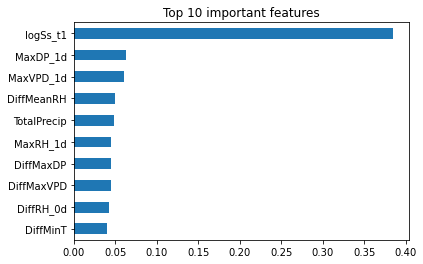

In [110]:
feat_importances = pd.Series(y100_rf_models[2].steps[1][1].feature_importances_,
                             index=new_columns)
feat_importances.nlargest(10).sort_values(ascending = True).plot(kind='barh')
plt.title("Top 10 important features")
plt.show()

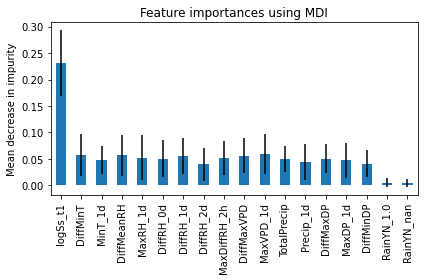

In [996]:
# plot feature importances with error bars:
# this probably only works if I save all the random forests rather than just the best 
#   estimator??? mmmm.... not sure if that makes sense; see this link for code:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf_objects[2].steps[1][1].feature_importances_

forest_importances = pd.Series(importances, index=new_columns)
std = np.std([tree.feature_importances_ for tree in rf_objects[2].steps[1][1].estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Random Forest Classifier:

#### Continuing on with the remainder of the analysis...

Here I've written a `for` loop to perform a random forests analysis (hyperparameters determined by `RandomizedSearchCV()`) for the y100 data set. The code performs 7 sets of analysis (one for each subset of features), and is repeated below for each threshold (100, 200, 500, 1000)... eventually this could all be in one loop.

Scoring criteria is for AUC. I wasn't certain this was doing what I wanted it to do, so I eventually included some lines in the `for` loop (see the two iterations of the 1000-threshold loops below) wherein I calculated it manually. The results are similar, but not the same, and I'm not sure why.

##### Mmmmmmmkay, so I need to update my 'feature_sets' list with the different LASSO feature selections for each of the thresholds I've chosen. So I'll do this before each run of this loop:

In [93]:
# this set of variables depends on what the response variable is - i.e. where I set the threshold or whether I use 
#   a continuous response variable. So... for now I'll stick with the continuous response variable 
#   (ylog_all = log(SsMean +1))

features_lasso = list(larcv_coefs[larcv_coefs['y100'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [96]:
# threshold = 100 spores per day

y100_auc_test_scores = []
y100_rf_models = []

y100_rf_objects = []


## NB: data sets called in this loop have not been preprocessed - doing so is part of the pipeline/program
for features in feature_sets:
    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from
    #     above
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    # create rf pipeline
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state = 545))
    ])
    # create param_dist dict
    param_dist = {
        'model__n_estimators'     : scipy.stats.randint(low=10, high=100),
        'model__max_depth'        : scipy.stats.randint(low=3, high=10),
        'model__class_weight'     : (None, "balanced")
    }

    # create randomized search CV
    random_search_auc = RandomizedSearchCV(rf_pipeline,
                                    param_distributions= param_dist,
                                     n_iter = 30,
                                     cv = 5,
                                     scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                                     verbose = 1,
                                     random_state = 454)
    
    # obtain AUC values from each of the models
    random_search_auc.fit(X_trainvalid_nosoil_log, y100_trainvalid_nosoil) 
    auc_score = ()
    
    preds = random_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y100_test_nosoil, preds[:,1])
    y100_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = random_search_auc.best_estimator_.steps[1][1]
    y100_rf_models.append(model)
    
    y100_rf_objects.append(random_search_auc.best_estimator_)

    y100_auc_test_scores
    y100_rf_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [97]:
y100_rf_results = y100_auc_test_scores.copy()
y100_rf_models = y100_rf_objects.copy()

In [98]:
pd.DataFrame(data = y100_rf_results, index = feature_set_names, columns = ['y100'])

,y100
features_all,0.582583
features_lasso,0.675791
features_VIF,0.702934
features_no_correlation,0.694733
features_same_day,0.528991
features_previous_day,0.506699
features_differences,0.598868


In [1392]:
#y100_rf_objects[2]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   IterativeImputer(random_state=356,
                                                                                    sample_posterior=True))]),
                                                  ['DiffMeanT', 'DiffMaxT',
                                                   'DiffMinT', 'DiffMeanRH',
                                                   'DiffMaxRH', 'DiffMinRH',
                                                   'DiffRH_0d', 'DiffRH_1d',
                                                   'DiffRH_2d', 'MaxDiffRH_2h',
                                                   'MaxDiffRH_3h'

In [100]:
preds = y100_rf_objects[2].predict_proba(X_test_nosoil_log)
#np.array(preds[:,1])
score_metrics(y100_test_nosoil, preds[:,1], 0.5)
#print(roc_auc_score(y100_test_nosoil, preds[:,1]))

,value
accuracy,0.649215
precision,0.771739
recall,0.606838
specificity,0.716216
F1,0.679426
AUC,0.702934


In [1384]:
#pprint(vars(rf_objects[1]));

In [1304]:
#rf_objects[2].steps[1][1].feature_importances_

In [ ]:
# def encode_and_bind(original_dataframe, features_to_encode):
#     dummies = pd.get_dummies(original_dataframe[features_to_encode])
#     res = pd.concat([dummies, original_dataframe], axis=1)
#     res = res.drop(features_to_encode, axis=1)
#     return(res)
# X_train_encoded = encode_and_bind(X_train, features_to_encode)

In [103]:
#fitting = fit()
cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL
cols.remove('RainYN') # remove this variable from the list of variables; alternatively,
                                    # could use a separate 'numeric' variable list and add that, but
                                    # that has some complications

ohe = y100_rf_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
new_columns

['logSs_t1',
 'DiffMinT',
 'MinT_1d',
 'DiffMeanRH',
 'MaxRH_1d',
 'DiffRH_0d',
 'DiffRH_1d',
 'DiffRH_2d',
 'MaxDiffRH_2h',
 'DiffMaxVPD',
 'MaxVPD_1d',
 'TotalPrecip',
 'Precip_1d',
 'DiffMaxDP',
 'MaxDP_1d',
 'DiffMinDP',
 'RainYN_1.0',
 'RainYN_nan']

In [951]:
# feats = {} # a dict to hold feature_name: feature_importance
# for feature, importance in zip(new_columns, rf_objects[1].steps[1][1].feature_importances_
# ):
#     feats[feature] = importance #add the name/value pair 
# 
# importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
# importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

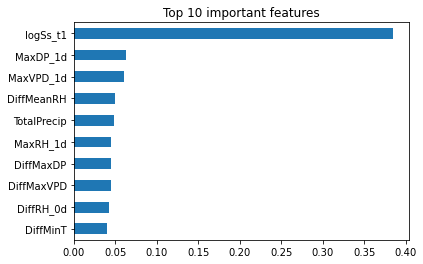

In [110]:
feat_importances = pd.Series(y100_rf_models[2].steps[1][1].feature_importances_,
                             index=new_columns)
feat_importances.nlargest(10).sort_values(ascending = True).plot(kind='barh')
plt.title("Top 10 important features")
plt.show()

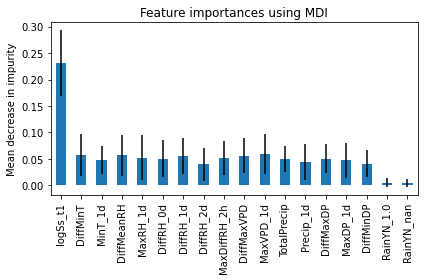

In [996]:
# plot feature importances with error bars:
# this probably only works if I save all the random forests rather than just the best 
#   estimator??? mmmm.... not sure if that makes sense; see this link for code:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf_objects[2].steps[1][1].feature_importances_

forest_importances = pd.Series(importances, index=new_columns)
std = np.std([tree.feature_importances_ for tree in rf_objects[2].steps[1][1].estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Ok, so pretty bad AUC scores. Interestingly, some are LESS than 0.50 - model fitting portion learning false relationships?

##### Must update the data sets to reflect the LASSO selections for ascospores at 200 cutoff:

In [119]:
features_lasso = list(larcv_coefs[larcv_coefs['y200'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [120]:
# threshold = 100 spores per day

y200_auc_test_scores = []
y200_rf_models = []

y200_rf_objects = []


## NB: data sets called in this loop have not been preprocessed - doing so is part of the pipeline/program
for features in feature_sets:
    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from
    #     above
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    # create rf pipeline
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state = 545))
    ])
    # create param_dist dict
    param_dist = {
        'model__n_estimators'     : scipy.stats.randint(low=10, high=100),
        'model__max_depth'        : scipy.stats.randint(low=3, high=10),
        'model__class_weight'     : (None, "balanced")
    }

    # create randomized search CV
    random_search_auc = RandomizedSearchCV(rf_pipeline,
                                    param_distributions= param_dist,
                                     n_iter = 30,
                                     cv = 5,
                                     scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                                     verbose = 1,
                                     random_state = 454)
    
    # obtain AUC values from each of the models
    random_search_auc.fit(X_trainvalid_nosoil_log, y200_trainvalid_nosoil) 
    auc_score = ()
    
    preds = random_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y200_test_nosoil, preds[:,1])
    y200_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = random_search_auc.best_estimator_.steps[1][1]
    y200_rf_models.append(model)
    
    y200_rf_objects.append(random_search_auc.best_estimator_)

    y200_auc_test_scores
    y200_rf_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [121]:
y200_rf_results = y200_auc_test_scores.copy()
y200_rf_models = y200_rf_objects.copy()

In [122]:
pd.DataFrame(data = y200_rf_results, index = feature_set_names, columns = ['y200'])

,y200
features_all,0.618424
features_lasso,0.773431
features_VIF,0.761052
features_no_correlation,0.757515
features_same_day,0.575321
features_previous_day,0.560455
features_differences,0.584273


In [1390]:
preds = y200_rf_models[1].predict_proba(X_test_nosoil_log)
#np.array(preds[:,1])
score_metrics(y100_test_nosoil, preds[:,1], 0.5)

,value
accuracy,0.612565
precision,0.612565
recall,1.000000
specificity,0.000000
F1,0.759740
AUC,0.469277


In [844]:
# 'RainYN' was not important in this model, so I can remove this part of the code:

# going to stick with the 'VIF' features set, since it was ALMOST the best performer
#ohe = rf_objects[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
#ohe.fit(X_trainvalid_nosoil_log, y200_trainvalid_nosoil)
#ohe_feature_names = list(ohe.get_feature_names(categorical_features))
#new_columns = feature_sets[2] + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
#new_columns

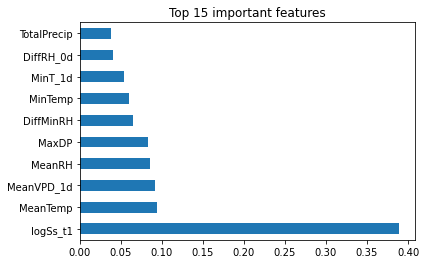

In [1015]:
feat_importances = pd.Series(rf_objects[1].steps[1][1].feature_importances_,
                             index=feature_sets[1])
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

#### update data sets to reflect the LASSO selection for 500 threshold:

In [123]:
features_lasso = list(larcv_coefs[larcv_coefs['y500'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [124]:
# threshold = 500 spores per day

y500_auc_test_scores = []
y500_rf_models = []

y500_rf_objects = []


## NB: data sets called in this loop have not been preprocessed - doing so is part of the pipeline/program
for features in feature_sets:
    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from
    #     above
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    # create rf pipeline
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state = 545))
    ])
    # create param_dist dict
    param_dist = {
        'model__n_estimators'     : scipy.stats.randint(low=10, high=100),
        'model__max_depth'        : scipy.stats.randint(low=3, high=10),
        'model__class_weight'     : (None, "balanced")
    }

    # create randomized search CV
    random_search_auc = RandomizedSearchCV(rf_pipeline,
                                    param_distributions= param_dist,
                                     n_iter = 30,
                                     cv = 5,
                                     scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                                     verbose = 1,
                                     random_state = 454)
    
    # obtain AUC values from each of the models
    random_search_auc.fit(X_trainvalid_nosoil_log, y500_trainvalid_nosoil) 
    auc_score = ()
    
    preds = random_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y500_test_nosoil, preds[:,1])
    y500_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = random_search_auc.best_estimator_.steps[1][1]
    y500_rf_models.append(model)
    
    y500_rf_objects.append(random_search_auc.best_estimator_)

    y500_auc_test_scores
    y500_rf_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [125]:
y500_rf_results = y500_auc_test_scores.copy()
y500_rf_models = y500_rf_objects.copy()

In [127]:
pd.DataFrame(data = y500_rf_results, index = feature_set_names, columns = ['y500'])

,y500
features_all,0.525267
features_lasso,0.758021
features_VIF,0.772059
features_no_correlation,0.731150
features_same_day,0.561364
features_previous_day,0.533824
features_differences,0.606684


Plot the most important features:

In [1316]:
feature_sets[2]

['logSs_t1',
 'DiffMinT',
 'MinT_1d',
 'DiffMeanRH',
 'MaxRH_1d',
 'DiffRH_0d',
 'DiffRH_1d',
 'DiffRH_2d',
 'MaxDiffRH_2h',
 'DiffMaxVPD',
 'MaxVPD_1d',
 'TotalPrecip',
 'Precip_1d',
 'RainYN',
 'DiffMaxDP',
 'MaxDP_1d',
 'DiffMinDP']

In [1317]:
cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL
cols.remove('RainYN') # remove this variable from the list of variables; alternatively,
                                    # could use a separate 'numeric' variable list and add that, but
                                    # that has some complications

ohe = rf_objects[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names(categorical_features))
new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
new_columns

['logSs_t1',
 'DiffMinT',
 'MinT_1d',
 'DiffMeanRH',
 'MaxRH_1d',
 'DiffRH_0d',
 'DiffRH_1d',
 'DiffRH_2d',
 'MaxDiffRH_2h',
 'DiffMaxVPD',
 'MaxVPD_1d',
 'TotalPrecip',
 'Precip_1d',
 'DiffMaxDP',
 'MaxDP_1d',
 'DiffMinDP',
 'RainYN_1.0',
 'RainYN_nan']

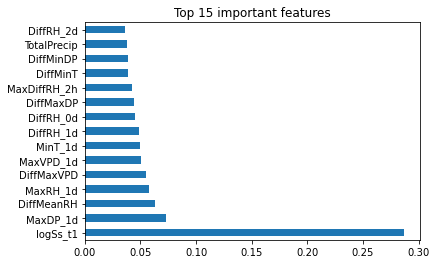

In [1318]:
feat_importances = pd.Series(rf_objects[2].steps[1][1].feature_importances_,
                             index=new_columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

In [1319]:
features_lasso = list(larcv_coefs[larcv_coefs['y1000'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [128]:
# threshold = 1000 spores per day

y1000_auc_test_scores = []
y1000_rf_models = []

y1000_rf_objects = []


## NB: data sets called in this loop have not been preprocessed - doing so is part of the pipeline/program
for features in feature_sets:
    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from
    #     above
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    # create rf pipeline
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state = 545))
    ])
    # create param_dist dict
    param_dist = {
        'model__n_estimators'     : scipy.stats.randint(low=10, high=100),
        'model__max_depth'        : scipy.stats.randint(low=3, high=10),
        'model__class_weight'     : (None, "balanced")
    }

    # create randomized search CV
    random_search_auc = RandomizedSearchCV(rf_pipeline,
                                    param_distributions= param_dist,
                                     n_iter = 30,
                                     cv = 5,
                                     scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                                     verbose = 1,
                                     random_state = 454)
    
    # obtain AUC values from each of the models
    random_search_auc.fit(X_trainvalid_nosoil_log, y1000_trainvalid_nosoil) 
    auc_score = ()
    
    preds = random_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y1000_test_nosoil, preds[:,1])
    y1000_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = random_search_auc.best_estimator_.steps[1][1]
    y1000_rf_models.append(model)
    
    y1000_rf_objects.append(random_search_auc.best_estimator_)

    y1000_auc_test_scores
    y1000_rf_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [129]:
y1000_rf_results = y1000_auc_test_scores.copy()
y1000_rf_models = y1000_rf_objects.copy()

In [130]:
pd.DataFrame(data = y1000_rf_results, index = feature_set_names, columns = ['y1000'])

,y1000
features_all,0.572596
features_lasso,0.790383
features_VIF,0.739786
features_no_correlation,0.747172
features_same_day,0.551069
features_previous_day,0.492772
features_differences,0.588624


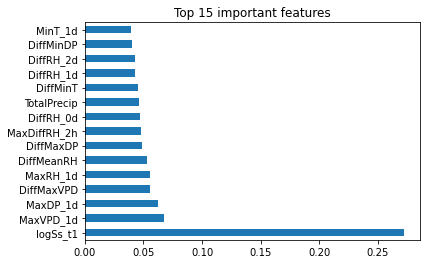

In [910]:
feat_importances = pd.Series(rf_objects[2].steps[1][1].feature_importances_,
                             index=feature_sets[2])
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

Combine all results into one data frame:

In [134]:
pd.DataFrame(data = list(zip(ylog_rf_results, y100_rf_results, y200_rf_results, y500_rf_results, y1000_rf_results)),
                     index = feature_set_names, 
             columns = ['ylog', 'y100', 'y200', 'y500', 'y1000'])

,ylog,y100,y200,y500,y1000
features_all,-0.035255,0.582583,0.618424,0.525267,0.572596
features_lasso,0.291463,0.675791,0.773431,0.758021,0.790383
features_VIF,0.284545,0.702934,0.761052,0.772059,0.739786
features_no_correlation,0.288417,0.694733,0.757515,0.731150,0.747172
features_same_day,-0.045399,0.528991,0.575321,0.561364,0.551069
features_previous_day,-0.046910,0.506699,0.560455,0.533824,0.492772
features_differences,-0.037870,0.598868,0.584273,0.606684,0.588624


In [ ]:
# could also create a dataframe that summarizes 

# Logistic Regression

Here I'll repeat the above, except using logistic regression. For comparison purposes, I will perform a similar analysis in R using more 'statistically sound' assumptions than here.

In [135]:
features_lasso = list(larcv_coefs[larcv_coefs['y100'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [138]:
# Using y100 as the threshold:

y100_auc_test_scores = []
y100_lr_models = []

y100_lr_objects = []


for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    # question: what happens if there are no categorical features? - sort out in the debugging stage
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    lr_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter = 1000, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.0001, 0.001, 0.01, 0.1, 1, 10),
        'model__class_weight'   : (None, 'balanced')
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(lr_pipeline,
                              param_grid=param_dist,
                              cv = 10,
                              scoring = 'roc_auc', # maximize auc score (ways to do multiplie criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y100_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y100_test_nosoil, preds[:,1])
    y100_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y100_lr_models.append(model)
    
    y100_lr_objects.append(grid_search_auc.best_estimator_)
    y100_auc_test_scores
    y100_lr_models

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [140]:
y100_lr_results = y100_auc_test_scores.copy()
y100_lr_models = y100_lr_objects.copy()

In [141]:
pd.DataFrame(data = y100_lr_results, index = feature_set_names, columns = ['y100'])

,y100
features_all,0.568261
features_lasso,0.706168
features_VIF,0.728575
features_no_correlation,0.723377
features_same_day,0.525410
features_previous_day,0.564911
features_differences,0.662740


In [1335]:
y100_lr_models[5][1].coef_[0]

array([ 2.10556150e-03,  2.48637133e-03, -1.13805267e-03, -4.44794924e-03,
       -2.48234484e-03, -2.74514611e-03,  3.60789620e-03,  2.47358734e-03,
        1.93575691e-03, -2.84772755e-03, -2.36306818e-03,  1.02718363e-03,
       -4.68847543e-03, -2.40485890e-03,  3.63221729e-05])

Plot the top 15 coefficients:

In [1042]:
feature_sets[2]

['logSs_t1',
 'DiffMinT',
 'MinT_1d',
 'DiffMeanRH',
 'MaxRH_1d',
 'DiffRH_0d',
 'DiffRH_1d',
 'DiffRH_2d',
 'MaxDiffRH_2h',
 'DiffMaxVPD',
 'MaxVPD_1d',
 'TotalPrecip',
 'Precip_1d',
 'RainYN',
 'DiffMaxDP',
 'MaxDP_1d',
 'DiffMinDP']

In [1043]:
cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL
cols.remove('RainYN') # remove this variable from the list of variables; alternatively,
                                    # could use a separate 'numeric' variable list and add that, but
                                    # that has some complications

ohe = lr_objects[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names(categorical_features))
new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
new_columns

['logSs_t1',
 'DiffMinT',
 'MinT_1d',
 'DiffMeanRH',
 'MaxRH_1d',
 'DiffRH_0d',
 'DiffRH_1d',
 'DiffRH_2d',
 'MaxDiffRH_2h',
 'DiffMaxVPD',
 'MaxVPD_1d',
 'TotalPrecip',
 'Precip_1d',
 'DiffMaxDP',
 'MaxDP_1d',
 'DiffMinDP',
 'RainYN_1.0',
 'RainYN_nan']

In [1056]:
lr_objects[2].steps[1][1].coef_

array([[ 4.67995241e-01,  1.98463588e-04, -3.73681283e-02,
        -2.42870940e-02, -9.27753876e-02,  1.76758145e-02,
        -2.03797853e-03,  3.90913322e-02,  5.60918800e-02,
         4.40394985e-02,  1.26568886e-01, -1.24710865e-01,
         3.60246951e-02,  6.10709152e-02,  1.00681050e-01,
        -3.14846791e-02, -6.08479236e-02, -3.85000698e-02]])

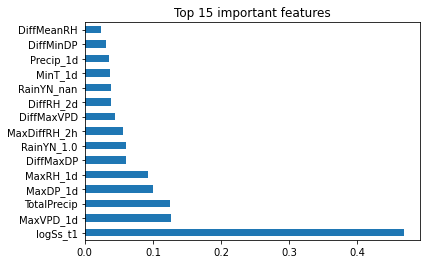

In [1058]:
feat_importances = pd.Series(np.abs(lr_objects[2].steps[1][1].coef_[0]), # take absolute values
                             # of importances
                             index=new_columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

Now try for y200:

In [1344]:
features_lasso = list(larcv_coefs[larcv_coefs['y200'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [142]:
# Using y200 as the threshold:

y200_auc_test_scores = []
y200_lr_models = []

y200_lr_objects = []


for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    # question: what happens if there are no categorical features? - sort out in the debugging stage
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    lr_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter = 1000, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.0001, 0.001, 0.01, 0.1, 1, 10),
        'model__class_weight'   : (None, 'balanced')
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(lr_pipeline,
                              param_grid=param_dist,
                              cv = 10,
                              scoring = 'roc_auc', # maximize auc score (ways to do multiplie criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y200_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y200_test_nosoil, preds[:,1])
    y200_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y200_lr_models.append(model)
    
    y200_lr_objects.append(grid_search_auc.best_estimator_)
    y200_auc_test_scores
    y200_lr_models

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [143]:
y200_lr_results = y200_auc_test_scores.copy()
y200_lr_models = y200_lr_objects.copy()

In [144]:
pd.DataFrame(data = y200_lr_results, index = feature_set_names, columns = ['y200'])

,y200
features_all,0.600298
features_lasso,0.751437
features_VIF,0.764589
features_no_correlation,0.758621
features_same_day,0.581952
features_previous_day,0.567418
features_differences,0.618866


In [1409]:
preds = y200_lr_models[2].predict_proba(X_test_nosoil_log)
#np.array(preds[:,1])
score_metrics(y200_test_nosoil, preds[:,1], 0.5)
#roc_auc_score(y200_test_nosoil, preds[:,1])

,value
accuracy,0.560209
precision,1.000000
recall,0.034483
specificity,1.000000
F1,0.066667
AUC,0.757737


In [1062]:
cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL
cols.remove('RainYN') # remove this variable from the list of variables; alternatively,
                                    # could use a separate 'numeric' variable list and add that, but
                                    # that has some complications

ohe = lr_objects[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names(categorical_features))
new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
new_columns;

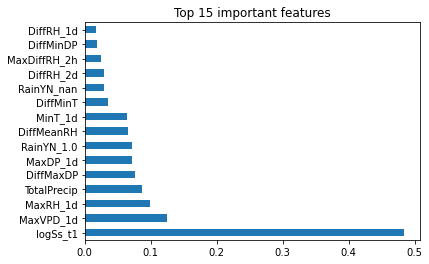

In [1063]:
feat_importances = pd.Series(np.abs(lr_objects[2].steps[1][1].coef_[0]), # take absolute values
                             # of importances
                             index=new_columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

In [1348]:
features_lasso = list(larcv_coefs[larcv_coefs['y500'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [145]:
# Using y500 as the threshold:

y500_auc_test_scores = []
y500_lr_models = []

y500_lr_objects = []


for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    # question: what happens if there are no categorical features? - sort out in the debugging stage
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    lr_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter = 1000, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.0001, 0.001, 0.01, 0.1, 1, 10),
        'model__class_weight'   : (None, 'balanced')
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(lr_pipeline,
                              param_grid=param_dist,
                              cv = 10,
                              scoring = 'roc_auc', # maximize auc score (ways to do multiplie criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y500_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y500_test_nosoil, preds[:,1])
    y500_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y500_lr_models.append(model)
    
    y500_lr_objects.append(grid_search_auc.best_estimator_)
    y500_auc_test_scores
    y500_lr_models

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [146]:
y500_lr_results = y500_auc_test_scores.copy()
y500_lr_models = y500_lr_objects.copy()

In [147]:
pd.DataFrame(data = y500_auc_test_scores, index = feature_set_names, columns = ['y500'])

,y500
features_all,0.578877
features_lasso,0.758690
features_VIF,0.766444
features_no_correlation,0.753743
features_same_day,0.567112
features_previous_day,0.579412
features_differences,0.558289


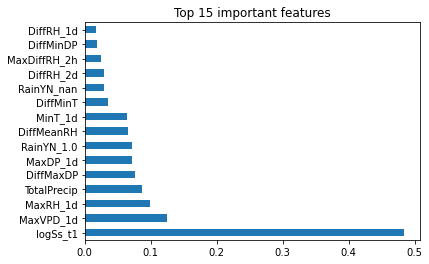

In [1074]:
# same thing as above, so I don't need to make new column names:
feat_importances = pd.Series(np.abs(lr_objects[2].steps[1][1].coef_[0]), # take absolute values
                             # of importances
                             index=new_columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

In [1352]:
features_lasso = list(larcv_coefs[larcv_coefs['y1000'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [151]:
# Using y1000 as the threshold:

y1000_auc_test_scores = []
y1000_lr_models = []

y1000_lr_objects = []


for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    # question: what happens if there are no categorical features? - sort out in the debugging stage
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    lr_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter = 1000, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.0001, 0.001, 0.01, 0.1, 1, 10),
        'model__class_weight'   : (None, 'balanced')
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(lr_pipeline,
                              param_grid=param_dist,
                              cv = 10,
                              scoring = 'roc_auc', # maximize auc score (ways to do multiplie criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y1000_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y1000_test_nosoil, preds[:,1])
    y1000_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y1000_lr_models.append(model)
    
    y1000_lr_objects.append(grid_search_auc.best_estimator_)
    y1000_auc_test_scores
    y1000_lr_models

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [152]:
y1000_lr_results = y1000_auc_test_scores.copy()
y1000_lr_models = y1000_lr_objects.copy()

In [153]:
pd.DataFrame(data = y1000_lr_results, index = feature_set_names, columns = ['y1000'])

,y1000
features_all,0.595380
features_lasso,0.775299
features_VIF,0.755185
features_no_correlation,0.753771
features_same_day,0.614551
features_previous_day,0.521684
features_differences,0.516656


In [1356]:
feature_sets[1]

['logSs_t1']

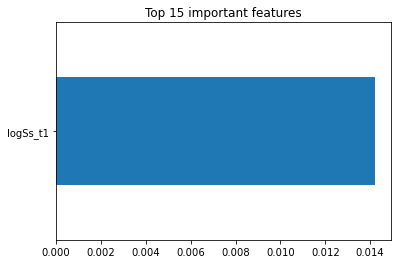

In [1081]:
# ok this time the LASSO data set with just one variable won out:
feat_importances = pd.Series(np.abs(lr_objects[1].steps[1][1].coef_[0]), # take absolute values
                             # of importances
                             index= feature_sets[1])
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

In [1357]:
# combine all results:
pd.DataFrame(data = list(zip(y100_lr_results, y200_lr_results, y500_lr_results, y1000_lr_results)),
                     index = feature_set_names, 
             columns = ['y100', 'y200', 'y500', 'y1000'])

,y100,y200,y500,y1000
features_all,0.573112,0.607317,0.551738,0.573067
features_lasso,0.686879,0.747569,0.555080,0.568825
features_VIF,0.723031,0.770447,0.540642,0.576367
features_biology,0.522523,0.570734,0.543984,0.579510
features_no_correlation,0.707785,0.746021,0.553342,0.578253
features_same_day,0.529106,0.584439,0.546257,0.562382
features_previous_day,0.563063,0.571729,0.558289,0.588152
features_differences,0.648764,0.597812,0.544385,0.583909


# Support Vector Machines

Repeat all of the above for SVM

In [154]:
features_lasso = list(larcv_coefs[larcv_coefs['y100'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [156]:
# as above for threshold = 100 spores per day:

y100_auc_test_scores = []
y100_svm_models = []

y100_svm_objects = []

for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] 
    cat_features = [i for i in features if i in categorical_features] 
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])

    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    svm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC(probability = True, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.01, 0.1, 1.0, 10, 100),
        'model__class_weight'   : (None, 'balanced'),
        'model__gamma'        : (0.01, 0.1, 1.0)
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(svm_pipeline,
                              param_grid=param_dist,
                              cv = 5,
                              scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y100_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y100_test_nosoil, preds[:,1])
    
    y100_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y100_svm_models.append(model)
    
    y100_svm_objects.append(grid_search_auc.best_estimator_)

    y100_auc_test_scores
    y100_svm_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [157]:
y100_svm_results = y100_auc_test_scores.copy()
y100_svm_models = y100_svm_objects.copy()

In [158]:
pd.DataFrame(data = y100_svm_results, index = feature_set_names, columns = ['y100'])

,y100
features_all,0.442134
features_lasso,0.686648
features_VIF,0.725341
features_no_correlation,0.724532
features_same_day,0.522754
features_previous_day,0.436013
features_differences,0.542389


Repeat for cuttoff of 200 ascospores per day:

In [1285]:
features_lasso = list(larcv_coefs[larcv_coefs['y200'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [159]:
# as above for threshold = 200 spores per day:

y200_auc_test_scores = []
y200_svm_models = []

y200_svm_objects = []

for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] 
    cat_features = [i for i in features if i in categorical_features] 
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])

    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    svm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC(probability = True, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.01, 0.1, 1.0, 10, 100),
        'model__class_weight'   : (None, 'balanced'),
        'model__gamma'        : (0.01, 0.1, 1.0)
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(svm_pipeline,
                              param_grid=param_dist,
                              cv = 5,
                              scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y200_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y200_test_nosoil, preds[:,1])
    
    y200_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y200_svm_models.append(model)
    
    y200_svm_objects.append(grid_search_auc.best_estimator_)

    y200_auc_test_scores
    y200_svm_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [160]:
y200_svm_results = y200_auc_test_scores.copy()
y200_svm_models = y200_svm_objects.copy()

In [161]:
pd.DataFrame(data = y200_svm_results, index = feature_set_names, columns = ['y200'])

,y200
features_all,0.401359
features_lasso,0.751216
features_VIF,0.769065
features_no_correlation,0.765805
features_same_day,0.424790
features_previous_day,0.433908
features_differences,0.575652


Repeat for features cutoff of 500 ascospores per day:

In [162]:
features_lasso = list(larcv_coefs[larcv_coefs['y500'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [163]:
# as above for threshold = 500 spores per day:

y500_auc_test_scores = []
y500_svm_models = []

y500_svm_objects = []

for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] 
    cat_features = [i for i in features if i in categorical_features] 
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])

    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    svm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC(probability = True, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.01, 0.1, 1.0, 10, 100),
        'model__class_weight'   : (None, 'balanced'),
        'model__gamma'        : (0.01, 0.1, 1.0)
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(svm_pipeline,
                              param_grid=param_dist,
                              cv = 5,
                              scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y500_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y500_test_nosoil, preds[:,1])
    
    y500_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y500_svm_models.append(model)
    
    y500_svm_objects.append(grid_search_auc.best_estimator_)

    y500_auc_test_scores
    y500_svm_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [1282]:
#preds[:,0]
#preds = y500_svm_models[0].predict_proba(X_test_nosoil_log)
#roc_auc_score(y500_test_nosoil, preds[:,0])


In [164]:
y500_svm_results = y500_auc_test_scores.copy()
y500_svm_models = y500_svm_objects.copy()

In [165]:
pd.DataFrame(data = y500_svm_results, index = feature_set_names, columns = ['y500'])

,y500
features_all,0.433957
features_lasso,0.764037
features_VIF,0.758757
features_no_correlation,0.745455
features_same_day,0.544853
features_previous_day,0.425668
features_differences,0.558021


Repeat for 1,000 ascospores per day

In [1280]:
features_lasso = list(larcv_coefs[larcv_coefs['y1000'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [166]:
# as above for threshold = 1000 spores per day:

y1000_auc_test_scores = []
y1000_svm_models = []

y1000_svm_objects = []

for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] 
    cat_features = [i for i in features if i in categorical_features] 
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])

    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    svm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC(probability = True, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.01, 0.1, 1.0, 10, 100),
        'model__class_weight'   : (None, 'balanced'),
        'model__gamma'        : (0.01, 0.1, 1.0)
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(svm_pipeline,
                              param_grid=param_dist,
                              cv = 5,
                              scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y1000_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y1000_test_nosoil, preds[:,1])
    
    y1000_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y1000_svm_models.append(model)
    
    y1000_svm_objects.append(grid_search_auc.best_estimator_)

    y1000_auc_test_scores
    y1000_svm_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [167]:
y1000_svm_results = y1000_auc_test_scores.copy()
y1000_svm_models = y1000_svm_objects.copy()

In [168]:
pd.DataFrame(data = y1000_svm_results, index = feature_set_names, columns = ['y1000'])

,y1000
features_all,0.535512
features_lasso,0.778284
features_VIF,0.749529
features_no_correlation,0.764535
features_same_day,0.402891
features_previous_day,0.465745
features_differences,0.560497


In [169]:
# combine all data for final results table:
# combine all results:
pd.DataFrame(data = list(zip(y100_svm_results, y200_svm_results, y500_svm_results, y1000_svm_results)),
                     index = feature_set_names, 
             columns = ['y100', 'y200', 'y500', 'y1000'])

,y100,y200,y500,y1000
features_all,0.442134,0.401359,0.433957,0.535512
features_lasso,0.686648,0.751216,0.764037,0.778284
features_VIF,0.725341,0.769065,0.758757,0.749529
features_no_correlation,0.724532,0.765805,0.745455,0.764535
features_same_day,0.522754,0.424790,0.544853,0.402891
features_previous_day,0.436013,0.433908,0.425668,0.465745
features_differences,0.542389,0.575652,0.558021,0.560497


In [1206]:
# predictions are different between runs... would I have to 
y1000_svm_models[2].predict(X_test_nosoil_log).sum()

55

In [1220]:
grid_search_auc.best_estimator_.score(X_trainvalid_nosoil_log, y1000_trainvalid_nosoil)
# pd.DataFrame(grid_search_auc.cv_results_)
grid_search_auc.scorer_

make_scorer(roc_auc_score, needs_threshold=True)

In [1213]:
#y100_svm_objects
y1000_svm_models[7][1]

SVC(C=10, gamma=0.1, probability=True, random_state=545)

In [1242]:
y1000_svm_pred = y1000_svm_models[7].predict(X_test_nosoil_log)
auc_val = roc_auc_score(y1000_svm_pred, y1000_test_nosoil)
auc_val

0.6236144578313253

In [1240]:
# I think only LR has probabilities; therefore maybe use the non-probability metrics:
y1000_svm_pred = y1000_svm_models[7].predict(X_test_nosoil_log)

#y1000_sm_pred = y1000_svm_models[2].

score_metrics_no_prob(y1000_test_nosoil, y1000_svm_pred)

,value
accuracy,0.759162
precision,0.440000
recall,0.255814
specificity,0.905405
F1,0.323529
AUC,0.580610


## Classification model evaluation statistics AND feature importances for all models:

Here I'll summarize the models based on the statistics I've decided on above (in the 'score_metrics()' function I've defined). These are primarily for the classification models.

I'm going to focus on VIF-models 

First, create null models for all of these:

In [210]:
# evaluate null models:
dummy_reg = DummyRegressor()
dummy_reg.fit(X_trainvalid_nosoil_log, y_trainvalid_nosoil_log)

dc_100 = DummyClassifier(strategy='prior')
dc_100.fit(X_trainvalid_nosoil_log, y100_trainvalid_nosoil)

dc_200 = DummyClassifier(strategy='prior')
dc_200.fit(X_trainvalid_nosoil_log, y200_trainvalid_nosoil)

dc_500 = DummyClassifier(strategy='prior')
dc_500.fit(X_trainvalid_nosoil_log, y500_trainvalid_nosoil)

dc_1000 = DummyClassifier(strategy='prior')
dc_1000.fit(X_trainvalid_nosoil_log, y1000_trainvalid_nosoil);

#rf500_probs = y500_rf_models[2].predict_proba(X_test_nosoil_log)

#score_metrics(y500_test_nosoil, rf500_probs[:,1], 0.5)

In [204]:
# for regression:
preds = dummy_reg.predict(X_test_nosoil_log)
print(r2_score(y_test_nosoil_log, preds))
print(100*np.mean(np.abs((preds - y_test_nosoil_log)/y_test_nosoil_log)))
print(mean_squared_error(y_test_nosoil_log, preds))

-0.06287204887821218
inf
0.6916652091441942


In [212]:
# for classification:
dummy_model_sets = [dc_100, dc_200, dc_500, dc_1000]
test_sets = [y100_test_nosoil, y200_test_nosoil, y500_test_nosoil, y1000_test_nosoil]

dummy_scores_df = pd.DataFrame()

for models, test in zip(dummy_model_sets, test_sets):
    probs = models.predict_proba(X_test_nosoil_log)
    
    scores = score_metrics(test, probs[:,1], 0.5)
    
    dummy_scores_df = pd.concat([dummy_scores_df, scores], axis=1)
    
dummy_scores_df.columns = ['y100', 'y200', 'y500', 'y1000']
dummy_scores_df

<ipython-input-2-d6cf8bb53d5f>:13: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
<ipython-input-2-d6cf8bb53d5f>:13: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


,y100,y200,y500,y1000
accuracy,0.612565,0.455497,0.712042,0.774869
precision,0.612565,0.455497,NaN,NaN
recall,1.000000,1.000000,0.000000,0.000000
specificity,0.000000,0.000000,1.000000,1.000000
F1,0.759740,0.625899,NaN,NaN
AUC,0.500000,0.500000,0.500000,0.500000


In [190]:
# models = [y500_rf_models[2], y500_lr_models[2], y500_svm_models[2]]

# scores_df = pd.DataFrame()

# for m in models:
#     probs = m.predict_proba(X_test_nosoil_log)
    
#     scores = score_metrics(y500_test_nosoil, probs[:,1], 0.5)
    
#     scores_df = pd.concat([scores_df, scores], axis=1)
    
# scores_df.columns = ['randomforest', 'logistic', 'SVM']
# scores_df

,randomforest,logistic,SVM
accuracy,0.753927,0.748691,0.753927
precision,0.600000,0.600000,0.590909
recall,0.436364,0.381818,0.472727
specificity,0.882353,0.897059,0.867647
F1,0.505263,0.466667,0.525253
AUC,0.772059,0.766444,0.758757


In [189]:
# random forest models:

model_sets = [y100_rf_models[2], y200_rf_models[2], y500_rf_models[2], y1000_rf_models[2]]
test_sets = [y100_test_nosoil, y200_test_nosoil, y500_test_nosoil, y1000_test_nosoil]

scores_df = pd.DataFrame()

for models, test in zip(model_sets, test_sets):
    probs = models.predict_proba(X_test_nosoil_log)
    
    scores = score_metrics(test, probs[:,1], 0.5)
    
    scores_df = pd.concat([scores_df, scores], axis=1)
    
scores_df.columns = ['y100', 'y200', 'y500', 'y1000']
scores_df

,y100,y200,y500,y1000
accuracy,0.649215,0.675393,0.753927,0.795812
precision,0.771739,0.647059,0.600000,0.547619
recall,0.606838,0.632184,0.436364,0.534884
specificity,0.716216,0.711538,0.882353,0.871622
F1,0.679426,0.639535,0.505263,0.541176
AUC,0.702934,0.761052,0.772059,0.739786


In [213]:
# logistic regression models:

model_sets = [y100_lr_models[2], y200_lr_models[2], y500_lr_models[2], y1000_lr_models[2]]
test_sets = [y100_test_nosoil, y200_test_nosoil, y500_test_nosoil, y1000_test_nosoil]

scores_lr_df = pd.DataFrame()

for models, test in zip(model_sets, test_sets):
    probs = models.predict_proba(X_test_nosoil_log)
    
    scores = score_metrics(test, probs[:,1], 0.5)
    
    scores_lr_df = pd.concat([scores_lr_df, scores], axis=1)
    
scores_lr_df.columns = ['y100', 'y200', 'y500', 'y1000']
scores_lr_df

,y100,y200,y500,y1000
accuracy,0.664921,0.722513,0.748691,0.795812
precision,0.797753,0.717949,0.600000,1.000000
recall,0.606838,0.643678,0.381818,0.093023
specificity,0.756757,0.788462,0.897059,1.000000
F1,0.689320,0.678788,0.466667,0.170213
AUC,0.728575,0.764589,0.766444,0.755185


In [214]:
# SVM models:

model_sets = [y100_svm_models[2], y200_svm_models[2], y500_svm_models[2], y1000_svm_models[2]]
test_sets = [y100_test_nosoil, y200_test_nosoil, y500_test_nosoil, y1000_test_nosoil]

scores_svm_df = pd.DataFrame()

for models, test in zip(model_sets, test_sets):
    probs = models.predict_proba(X_test_nosoil_log)
    
    scores = score_metrics(test, probs[:,1], 0.5)
    
    scores_svm_df = pd.concat([scores_svm_df, scores], axis=1)
    
scores_svm_df.columns = ['y100', 'y200', 'y500', 'y1000']
scores_svm_df

,y100,y200,y500,y1000
accuracy,0.607330,0.643979,0.753927,0.801047
precision,0.617978,0.579832,0.590909,0.666667
recall,0.940171,0.793103,0.472727,0.232558
specificity,0.081081,0.519231,0.867647,0.966216
F1,0.745763,0.669903,0.525253,0.344828
AUC,0.725341,0.769065,0.758757,0.749529


#### Make feature importance plots for each of the methods; will focus on y500 threshold for now!

The tricky part is getting the right column names for each of the models. NB: never mind! The same feature set can be used for all models using the VIF variables

In [224]:

cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL
cols.remove('RainYN') # remove this variable from the list of variables; alternatively,
                                    # could use a separate 'numeric' variable list and add that, but
                                    # that has some complications

ohe = ylog_rf_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
new_columns;

#ohe = y500_rf_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
#ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
#new_columns_rfclass = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
#new_columns_rfclass

#ohe = y500_lr_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
#ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
#new_columns_lr = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
#new_columns_lr

#ohe = y500_svm_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
#ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
#new_columns_svm = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
#new_columns_svm;

In [225]:
#print(new_columns_rfreg)
#print(new_columns_rfclass)
#print(new_columns_lr)
#print(new_columns_svm)

In [275]:
from pylab import rcParams

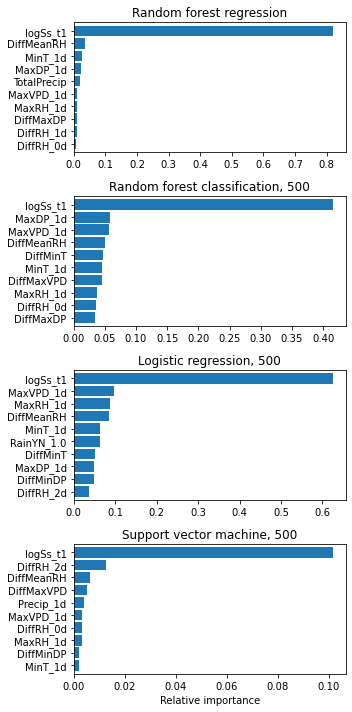

In [283]:

rcParams['figure.figsize'] = 5, 10

fig = plt.figure()

plt.subplot(4,1,1)
feat_importances_rfreg = pd.Series(ylog_rf_models[2].steps[1][1].feature_importances_,
                             index=new_columns)
feat_importances_rfreg.nlargest(10).sort_values(ascending = True).plot(kind='barh', width = 0.85)
plt.title("Random forest regression")
#plt.show()


plt.subplot(4,1,2)
feat_importances_rf500 = pd.Series(y500_rf_models[2].steps[1][1].feature_importances_,
                             index=new_columns)
feat_importances_rf500.nlargest(10).sort_values(ascending = True).plot(kind='barh', width = 0.85)
plt.title("Random forest classification, 500")
#plt.show()


plt.subplot(4,1,3)
feat_importances_lr500 = pd.Series(np.abs(y500_lr_models[2].steps[1][1].coef_[0]), # take absolute values here
                             index=new_columns)
feat_importances_lr500.nlargest(10).sort_values(ascending = True).plot(kind='barh', width = 0.85)
plt.title("Logistic regression, 500")
#plt.show()


# getting feature importances is a bit weird for SVM if using the 'rbf' kernel, but here it is:

plt.subplot(4,1,4)
perm_importance = permutation_importance(y500_svm_models[2], X_test_nosoil_log, y500_test_nosoil)

feature_names = X_test_nosoil_log.columns # must use all original column names
features = np.array(feature_names)

feat_importances_svm500 = pd.Series(np.abs(perm_importance.importances_mean),
                             index=features)

feat_importances_svm500.nlargest(10).sort_values(ascending = True).plot(kind='barh', width = 0.85)
plt.title("Support vector machine, 500")
plt.xlabel("Relative importance")
#plt.show()

fig.tight_layout()
#fig.subplots_adjust(hspace=0.6)
plt.savefig("feature importances.png", dpi = 300)


And also make a dataframe showing all the feature importance values:

In [286]:
blah = pd.concat([feat_importances_rfreg, feat_importances_rf500, feat_importances_lr500, feat_importances_svm500], 
                 axis=1)

blah.columns = ['rf_reg', 'rf_y500', 'lr_y500', 'svm_y500']

blah.to_csv("feature importances dataframe.csv")


In [67]:
# LASSO feature selection - need scaled features
# ONE OPTION FOR DOING THIS BELOW: this is using the transformed/encoded X data set and using the binary y
#                                  target
# Lasso:
larcv = LassoCV(n_alphas=100, cv = 10, max_iter = 10000) 

y_data_sets = [y_trainvalid_nosoil_log, y100_trainvalid_nosoil, y200_trainvalid_nosoil, 
               y500_trainvalid_nosoil, y1000_trainvalid_nosoil]
#y_data_sets = [ylog_all, y100_all, y200_all, y500_all, y1000_all]
#larcv_coefs = pd.DataFrame(index = X_all.columns)
larcv_coefs = pd.DataFrame(index = X_trainvalid.columns)

# a for loop to perform all fits at once:
for y in y_data_sets:
    larcv.fit(X_trainvalid, y)
    larcv_ycoefs = pd.DataFrame(data=abs(larcv.coef_), index=X_trainvalid.columns)
    
    larcv_coefs = pd.concat([larcv_coefs, larcv_ycoefs], axis=1)
    
larcv_coefs.columns = ['ylog', 'y100', 'y200', 'y500', 'y1000']

In [68]:
# display results; remove variables that weren't selected in any of the models (i.e. their coefficient = 0)
larcv_coefs[(larcv_coefs.T > 1e-6).any()].sort_values(by='ylog', ascending=False)

,ylog,y100,y200,y500,y1000
logSs_t1,0.368919,0.128645,0.155954,0.181878,0.14188
MeanRH,0.073478,0.000000,0.035407,0.019537,0.00000
TotalPrecip,0.063709,0.025243,0.019007,0.000000,0.00000
MaxDP,0.058479,0.030315,0.032696,0.000000,0.00000
MinTemp,0.022790,0.000000,0.040527,0.000000,0.00000
MeanVPD_1d,0.005460,0.017325,0.031176,0.001569,0.00000
MinDP_1d,0.002042,0.003667,0.000000,0.000000,0.00000
DiffRH_0d,0.000000,0.000000,0.004352,0.000000,0.00000
MeanTemp,0.000000,0.000000,0.020870,0.001591,0.00000
MaxDiffRH_3h,0.000000,0.000830,0.000000,0.000000,0.00000


In [ ]:
# feature importances for each of the models:

#### Exploration of how AUC values are calculated:
Try the last model from above, but this time explicitly calculate the AUC to see how they compare:

In [283]:
# Using y1000 as the threshold:

y1000_auc_test_scores_2 = []
calculated_auc = []
y1000_models_2 = {}

for features, name in zip(feature_sets, feature_set_names):
    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from
    #     above
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = True, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    # question: what happens if there are no categorical features? - sort out in the debugging stage
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    lr_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter = 1000, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.0001, 0.001, 0.01, 0.1, 1, 10),
        'model__class_weight'   : (None, 'balanced')
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(lr_pipeline,
                              param_grid=param_dist,
                              cv = 10,
                              scoring = 'roc_auc', # maximize the f1 score (ways to do multiplie criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid, y1000_trainvalid) 
    auc_score = ()
    auc_score = grid_search_auc.score(X_test, y1000_test)
    y1000_auc_test_scores_2.append(auc_score)
    
    AUC = ()
    y_proba = ()
    y_proba = grid_search_auc.predict_proba(X_test)[:,1]
    AUC = roc_auc_score(y1000_test, y_proba)
    calculated_auc.append(AUC)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y1000_models_2.update({name: model})

    #y1000_auc_test_scores
    #y1000_models

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  5.6min finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   48.2s finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.6min finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  3.0min finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   52.2s finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.3min finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.7min finished


In [288]:
calculated_auc

[0.7298245614035088,
 0.7929824561403509,
 0.7403508771929824,
 0.656140350877193,
 0.7087719298245614,
 0.6491228070175439,
 0.8210526315789473,
 0.6771929824561403]

In [289]:
y1000_auc_test_scores_2

[0.7298245614035088,
 0.8035087719298246,
 0.7192982456140351,
 0.656140350877193,
 0.7087719298245614,
 0.6842105263157895,
 0.7964912280701755,
 0.6947368421052632]

OK... These are close-ish, but still different. Differences due to randomness somewhere or what?!